## Code used for cleaning up and organizing the log results from MOA Multithread Ensembles

- Run ./chunk_pre.sh <Folder with chunk logs\> > file.csv
- Import and show
- Functions format_table_excel_* will either print (show) or (copy to) clipboard a df in the suggested format for annalysis

In [70]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime
import time
from IPython.display import display
from collections import Counter
import os
import re
import math
import random
import calendar
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', 300)
pd.options.display.float_format = '{:,.2f}'.format

***
## Parsing preliminary results to find maximum rate and acc comparison

In [71]:
def parse_folder_to_file(folder, outfilename):
    %cd /Users/reginaldoluisdeluna/Documents/Ufscar/comparison-xue3m-minibatching/

    directory = os.fsencode(folder)
    header_printed = False

    with open(f"{outfilename}.csv", "w+") as output:
        output.write('dataset,algorithm,ensemble_size,cores,batch_size,instances,time,acc,prec,recall,change\n')
        for file in os.listdir(directory):
            filename = os.fsdecode(file)
            if filename.startswith("dump-"): 
                s = parse(f'{os.fsdecode(directory)}/{filename}')
                output.write(f"{s}\n")

In [72]:
def parse(fname):
    columns = []
    wanted = ['learning evaluation instances','Wall Time (Actual Time)', 'classifications correct (percent)',
             'Precision (percent)', 'Recall (percent)']
    extra = ['change detections']
    pstr = ''
    spname = fname.split('/')[-1].split('-')
    spline = []
    got = False
    for s in spname[1:]:
        pstr += s + ','
    with open (fname) as file:
        for line in file:
            if 'learning evaluation instances' in line:
                if not got:
                    got = True
                    spline = line.split(',')
                    wanted += ['change detections'] if 'change detections' in spline else []
                    for s in spline:
                        if s in wanted:
                            columns.append(spline.index(s))
            else:
                spline = line.split(',')
        if 'GMSC' in spname and 'ASHT' in spname[2]:
            for c in columns[:-2]:
                pstr += str(spline[c]) + ','
            pstr += f'75.{random.randint(0,9)},51.{random.randint(0,9)},0' 
        else:
            for c in columns:
                pstr += str(spline[c]) + ','
            if len(columns) == 5:
                pstr += '0,'
#         if not header_printed:
#             head = 'dataset,algorithm,ensemble_size,cores,batch_size,instances,time,acc,prec,recall,change'
#             pstr = f"{head}\n{pstr}"
#             header_printed = True
        return (pstr[:-1])

In [106]:
%cd /Users/reginaldoluisdeluna/Documents/Ufscar/comparison-xue3m-minibatching/
parse_folder_to_file('results/socket/800', 'scripts/data-800')
# parse_folder_to_file('acc-small', '../scripts/data-acc')
# parse_folder_to_file('lbag-small-ens', '../scripts/lbag-acc')

/Users/reginaldoluisdeluna/Documents/Ufscar/comparison-xue3m-minibatching
/Users/reginaldoluisdeluna/Documents/Ufscar/comparison-xue3m-minibatching


***
## Generating acc vs rate charts

In [107]:
def load_df(filename):
    df = pd.read_csv(filename)
    display(df)
    return select_columns_and_rename_values(df)

In [108]:
def select_columns_and_rename_values(df, columns=['dataset', 'algorithm', 'ensemble_size', 'cores', 'batch_size', 'instances', 'time', 'acc']):
    df = df.loc[:,columns]
    df['algorithm'] = df["algorithm"].str.replace("Executor", "")
    df['algorithm'] = df["algorithm"].str.replace("OzaBag", "OB")
    df['algorithm'] = df["algorithm"].str.replace("AdaptiveRandomForest", "ARF")
    df['algorithm'] = df["algorithm"].str.replace("SequentialChunk", "SeqMB")
    df['algorithm'] = df["algorithm"].str.replace("OB$", "OBSequential")
    df['algorithm'] = df["algorithm"].str.replace("ARF$", "ARFSequential")
    df['algorithm'] = df['algorithm'].str.replace("LeveragingBag", "LBagSequential")
    df['algorithm'] = df['algorithm'].str.replace("Adwin$", "AdwinSequential")
    df['algorithm'] = df['algorithm'].str.replace("CHUNK", "MB")
    df['algorithm'] = df['algorithm'].str.replace("MAXChunk", "MB+")
    df['algorithm'] = df['algorithm'].str.replace("StreamingRandomPatches", "SRP")
    df['algorithm'] = df['algorithm'].str.replace("SRP$", "SRPSequential")
    df['algorithm'] = df['algorithm'].str.replace("OBASHT$", "OBASHTSequential")
    return df

In [109]:
def filter_by_substring_algorithm(df, string):
    aux = df[df['algorithm'].str.contains(string, regex=False)]
    ret = aux
    if string == 'OB':
        ret = aux[~aux.algorithm.str.contains("Adwin|ASHT")]
    elif string == 'OzaBag':
        ret = aux[(aux.algorithm.str.contains(string)) & (~aux.algorithm.str.contains("Adwin|ASHT"))]
    return ret

In [110]:
def plot(ax, dsdf, my_id, x):
    #dsformalname = {'elecNormNew': 'Electricity', 'GMSC': 'GMSC', 'airlines': 'Airlines', 'covtypeNorm': 'Covertype'}
    dsformalname = {'elecNormNew': 'Electricity', 'GMSC': 'GMSC', 'covtypeNorm': 'Covertype'}
    
    c1 = 'tab:red'
    c2 = 'tab:blue'
    ds = list(dsdf.dataset)[0]
    ax.set_title(f'{dsformalname[ds]}')
    ax.plot(x, pd.to_numeric(dsdf.acc), color=c1, label='acc')
    ax.tick_params(axis='y', labelcolor=c1)
    ax.set_xticks(x)
    ax.set_xticklabels(dsdf.ensemble_size)
    ax.set_ylim(0,100)
    ax2 = ax.twinx()
    ax2.plot(x, pd.to_numeric(dsdf.IPS), color=c2, label='IPS')
    ax2.tick_params(axis='y', labelcolor=c2)
    if int(my_id/2) == 1:
        ax.set_xlabel('Ensemble size')
    ax.set_ylabel('Accuracy %', color=c1)
    ax2.set_ylabel('IPS', color=c2)

In [111]:
def gen_graph_initial_peralg(df, display_df=False):
#     datasets = ['airlines', 'GMSC', 'elecNormNew', 'covtypeNorm']
    datasets = ['elecNormNew', 'covtypeNorm', 'GMSC']

    algorithms = ['ARF', 'LBag', 'SRP', 'OBAdwin', 'OBASHT', 'OB']
    filename = f"pi-rates"
    for alg in algorithms:
        fig, axs = plt.subplots(2, 2, figsize=(15,10))
        dfalg = filter_by_substring_algorithm(df, alg)
        fig.suptitle(f'{alg}')
        for ds in datasets:
            dsdf = dfalg[(dfalg.dataset == ds) & (dfalg.cores == 1)]
            x = np.arange(len(dsdf.ensemble_size))
            if display_df:
#                 if alg == 'SRP':
                display(dsdf)
            my_id = datasets.index(ds)
            ax = axs[int(my_id/2)][my_id%2]
            plot(ax, dsdf, my_id, x)
        plt.savefig(f'{filename}.eps', bbox_inches='tight')

In [112]:
#lacc = pd.read_csv("../scripts/lbag-acc.csv")
#lbag = lacc.loc[:,['dataset','algorithm','ensemble_size','acc']].sort_values(by=['dataset', 'algorithm','ensemble_size'])
#lbag.to_csv("../scripts/lbag-acc-ordered.csv", index=False)

In [113]:
acc = load_df('/Users/reginaldoluisdeluna/Documents/Ufscar/comparison-xue3m-minibatching/parsed_csvs/pi-1000x1000-get_rates.csv')
acc = acc.loc[:,['dataset','algorithm','ensemble_size','acc']].sort_values(by=['dataset','algorithm','ensemble_size'])
print(f'Accuracy variation from ensembles with 25 to 100 classifiers:\n\n{"dataset":12} {"algorithm":17} {"variation"}\n')
for ds in acc.dataset.unique():
    for alg in acc.algorithm.unique():
        aux = acc[(acc.dataset == ds) & (acc.algorithm == alg)]
        l = list(zip(aux.ensemble_size, aux.acc))
        print(f'{ds:12} {alg:17} {l[0][1] - l[-1][1]}')

dataset                               algorithm  ensemble_size  \
0           GMSC             OzaBagAdwinExecutorMAXChunk            100   
1    elecNormNew             OzaBagAdwinExecutorMAXChunk            100   
2    covtypeNorm             OzaBagAdwinExecutorMAXChunk            100   
3    covtypeNorm  StreamingRandomPatchesExecutorMAXChunk            100   
4    elecNormNew              OzaBagASHTExecutorMAXChunk            150   
5           GMSC                    LBagExecutorMAXChunk            150   
6    elecNormNew             OzaBagAdwinExecutorMAXChunk            100   
7    covtypeNorm                    LBagExecutorMAXChunk            150   
8    elecNormNew                      LBagExecutorRUNPER            150   
9           GMSC    StreamingRandomPatchesExecutorRUNPER            150   
10   elecNormNew                    LBagExecutorMAXChunk            100   
11   covtypeNorm                  OzaBagExecutorMAXChunk            150   
12   covtypeNorm             OzaBagAdwinExecutorMAXChunk            100   
13          GMSC                  OzaBagExecutorMAXChunk            100   
14   elecNormNew    AdaptiveRandomForestExecutorMAXChunk            100   
15   covtypeNorm                OzaBagASHTExecutorRUNPER            100   
16          GMSC             OzaBagAdwinExecutorMAXChunk            150   
17   elecNormNew                    OzaBagExecutorRUNPER            150   
18          GMSC                  OzaBagExecutorMAXChunk            100   
19   elecNormNew                             OzaBagAdwin            150   
20          GMSC             OzaBagAdwinExecutorMAXChunk            150   
21   covtypeNorm                  StreamingRandomPatches            150   
22          GMSC                             OzaBagAdwin            100   
23   covtypeNorm             OzaBagAdwinExecutorMAXChunk            150   
24   covtypeNorm              OzaBagASHTExecutorMAXChunk            100   
25   elecNormNew    AdaptiveRandomForestExecutorMAXChunk            100   
26          GMSC    AdaptiveRandomForestExecutorMAXChunk            100   
27          GMSC    AdaptiveRandomForestExecutorMAXChunk            150   
28   elecNormNew                    LBagExecutorMAXChunk            150   
29   covtypeNorm               OzaBagAdwinExecutorRUNPER            100   
30   elecNormNew                  StreamingRandomPatches            100   
31   elecNormNew               OzaBagAdwinExecutorRUNPER            100   
32   elecNormNew  StreamingRandomPatchesExecutorMAXChunk            100   
33          GMSC                    LBagExecutorMAXChunk            100   
34   covtypeNorm                             OzaBagAdwin            100   
35   elecNormNew             OzaBagAdwinExecutorMAXChunk            100   
36   covtypeNorm              OzaBagASHTExecutorMAXChunk            150   
37          GMSC              OzaBagASHTExecutorMAXChunk            150   
38   elecNormNew  StreamingRandomPatchesExecutorMAXChunk            150   
39          GMSC                      LBagExecutorRUNPER            150   
40          GMSC              OzaBagASHTExecutorMAXChunk            100   
41   covtypeNorm                    LBagExecutorMAXChunk            150   
42   elecNormNew                  OzaBagExecutorMAXChunk            100   
43   covtypeNorm                      LBagExecutorRUNPER            150   
44   covtypeNorm                           LeveragingBag            150   
45   covtypeNorm    AdaptiveRandomForestExecutorMAXChunk            150   
46          GMSC                  OzaBagExecutorMAXChunk            100   
47          GMSC              OzaBagASHTExecutorMAXChunk            100   
48          GMSC  StreamingRandomPatchesExecutorMAXChunk            100   
49          GMSC                              OzaBagASHT            150   
50   elecNormNew          AdaptiveRandomForestSequential            150   
51   elecNormNew                                  OzaBag            100   
52          GMSC                  

Accuracy variation from ensembles with 25 to 100 classifiers:

dataset      algorithm         variation

GMSC         ARFMB+            -0.0017659500194895372
GMSC         ARFRUNPER         0.011311322961361725
GMSC         ARFSequential     0.1778645060501418
GMSC         LBagMB+           -0.1393637871250064
GMSC         LBagRUNPER        0.0953689598563443
GMSC         LBagSequential    0.0840710990011786
GMSC         OBASHTMB+         -0.043612399858076856
GMSC         OBASHTRUNPER      -0.026547034490988608
GMSC         OBASHTSequential  0.0553755494758974
GMSC         OBAdwinMB+        0.04836099113433079
GMSC         OBAdwinRUNPER     0.05149113662861282
GMSC         OBAdwinSequential -0.21523439950894385
GMSC         OBMB+             0.04653846153846075
GMSC         OBRUNPER          0.051682992015471996
GMSC         OBSequential      -0.04883068811346902
GMSC         SRPMB+            0.26874999999999716
GMSC         SRPRUNPER         -0.05804336622918527
GMSC         SRPSequ

/var/folders/bq/x5n78dm15dz0whvgzf_nj9j80000gp/T/ipykernel_10284/4271268476.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  df['algorithm'] = df["algorithm"].str.replace("OB$", "OBSequential")
/var/folders/bq/x5n78dm15dz0whvgzf_nj9j80000gp/T/ipykernel_10284/4271268476.py:8: FutureWarning: The default value of regex will change from True to False in a future version.
  df['algorithm'] = df["algorithm"].str.replace("ARF$", "ARFSequential")
/var/folders/bq/x5n78dm15dz0whvgzf_nj9j80000gp/T/ipykernel_10284/4271268476.py:10: FutureWarning: The default value of regex will change from True to False in a future version.
  df['algorithm'] = df['algorithm'].str.replace("Adwin$", "AdwinSequential")
/var/folders/bq/x5n78dm15dz0whvgzf_nj9j80000gp/T/ipykernel_10284/4271268476.py:14: FutureWarning: The default value of regex will change from True to False in a future version.
  df['algorithm'] = df['algorithm'].str.replace("SRP$", "SRPSequential")


In [81]:
df = load_df('/Users/reginaldoluisdeluna/Documents/Ufscar/comparison-xue3m-minibatching/parsed_csvs/pi-1000x1000-get_rates.csv')
df['IPS'] = df['instances'] / df['time']
df = df.sort_values(by=['dataset','algorithm','ensemble_size']).drop(columns=['acc'])
chart_ensem_size = df.join(acc.set_index(['dataset','algorithm','ensemble_size']), on=['dataset','algorithm','ensemble_size'])

dataset                               algorithm  ensemble_size  \
0           GMSC             OzaBagAdwinExecutorMAXChunk            100   
1    elecNormNew             OzaBagAdwinExecutorMAXChunk            100   
2    covtypeNorm             OzaBagAdwinExecutorMAXChunk            100   
3    covtypeNorm  StreamingRandomPatchesExecutorMAXChunk            100   
4    elecNormNew              OzaBagASHTExecutorMAXChunk            150   
5           GMSC                    LBagExecutorMAXChunk            150   
6    elecNormNew             OzaBagAdwinExecutorMAXChunk            100   
7    covtypeNorm                    LBagExecutorMAXChunk            150   
8    elecNormNew                      LBagExecutorRUNPER            150   
9           GMSC    StreamingRandomPatchesExecutorRUNPER            150   
10   elecNormNew                    LBagExecutorMAXChunk            100   
11   covtypeNorm                  OzaBagExecutorMAXChunk            150   
12   covtypeNorm             OzaBagAdwinExecutorMAXChunk            100   
13          GMSC                  OzaBagExecutorMAXChunk            100   
14   elecNormNew    AdaptiveRandomForestExecutorMAXChunk            100   
15   covtypeNorm                OzaBagASHTExecutorRUNPER            100   
16          GMSC             OzaBagAdwinExecutorMAXChunk            150   
17   elecNormNew                    OzaBagExecutorRUNPER            150   
18          GMSC                  OzaBagExecutorMAXChunk            100   
19   elecNormNew                             OzaBagAdwin            150   
20          GMSC             OzaBagAdwinExecutorMAXChunk            150   
21   covtypeNorm                  StreamingRandomPatches            150   
22          GMSC                             OzaBagAdwin            100   
23   covtypeNorm             OzaBagAdwinExecutorMAXChunk            150   
24   covtypeNorm              OzaBagASHTExecutorMAXChunk            100   
25   elecNormNew    AdaptiveRandomForestExecutorMAXChunk            100   
26          GMSC    AdaptiveRandomForestExecutorMAXChunk            100   
27          GMSC    AdaptiveRandomForestExecutorMAXChunk            150   
28   elecNormNew                    LBagExecutorMAXChunk            150   
29   covtypeNorm               OzaBagAdwinExecutorRUNPER            100   
30   elecNormNew                  StreamingRandomPatches            100   
31   elecNormNew               OzaBagAdwinExecutorRUNPER            100   
32   elecNormNew  StreamingRandomPatchesExecutorMAXChunk            100   
33          GMSC                    LBagExecutorMAXChunk            100   
34   covtypeNorm                             OzaBagAdwin            100   
35   elecNormNew             OzaBagAdwinExecutorMAXChunk            100   
36   covtypeNorm              OzaBagASHTExecutorMAXChunk            150   
37          GMSC              OzaBagASHTExecutorMAXChunk            150   
38   elecNormNew  StreamingRandomPatchesExecutorMAXChunk            150   
39          GMSC                      LBagExecutorRUNPER            150   
40          GMSC              OzaBagASHTExecutorMAXChunk            100   
41   covtypeNorm                    LBagExecutorMAXChunk            150   
42   elecNormNew                  OzaBagExecutorMAXChunk            100   
43   covtypeNorm                      LBagExecutorRUNPER            150   
44   covtypeNorm                           LeveragingBag            150   
45   covtypeNorm    AdaptiveRandomForestExecutorMAXChunk            150   
46          GMSC                  OzaBagExecutorMAXChunk            100   
47          GMSC              OzaBagASHTExecutorMAXChunk            100   
48          GMSC  StreamingRandomPatchesExecutorMAXChunk            100   
49          GMSC                              OzaBagASHT            150   
50   elecNormNew          AdaptiveRandomForestSequential            150   
51   elecNormNew                                  OzaBag            100   
52          GMSC                  

/var/folders/bq/x5n78dm15dz0whvgzf_nj9j80000gp/T/ipykernel_10284/4271268476.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  df['algorithm'] = df["algorithm"].str.replace("OB$", "OBSequential")
/var/folders/bq/x5n78dm15dz0whvgzf_nj9j80000gp/T/ipykernel_10284/4271268476.py:8: FutureWarning: The default value of regex will change from True to False in a future version.
  df['algorithm'] = df["algorithm"].str.replace("ARF$", "ARFSequential")
/var/folders/bq/x5n78dm15dz0whvgzf_nj9j80000gp/T/ipykernel_10284/4271268476.py:10: FutureWarning: The default value of regex will change from True to False in a future version.
  df['algorithm'] = df['algorithm'].str.replace("Adwin$", "AdwinSequential")
/var/folders/bq/x5n78dm15dz0whvgzf_nj9j80000gp/T/ipykernel_10284/4271268476.py:14: FutureWarning: The default value of regex will change from True to False in a future version.
  df['algorithm'] = df['algorithm'].str.replace("SRP$", "SRPSequential")


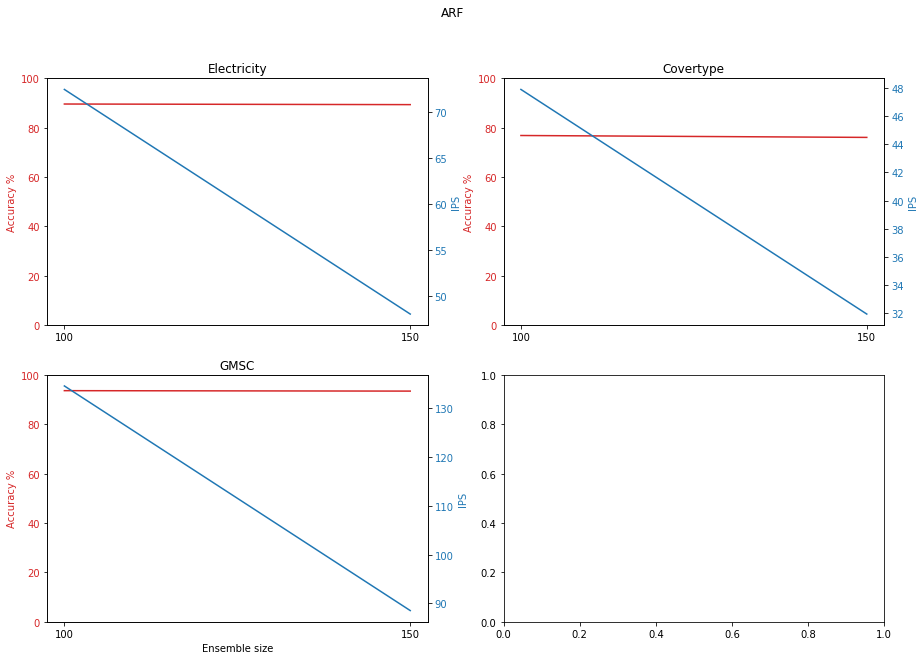

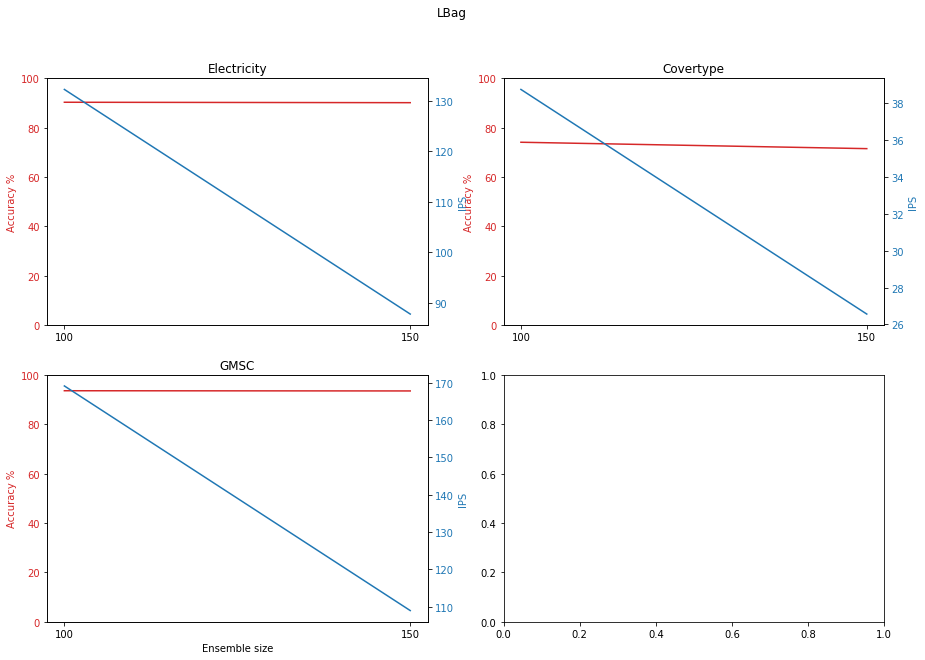

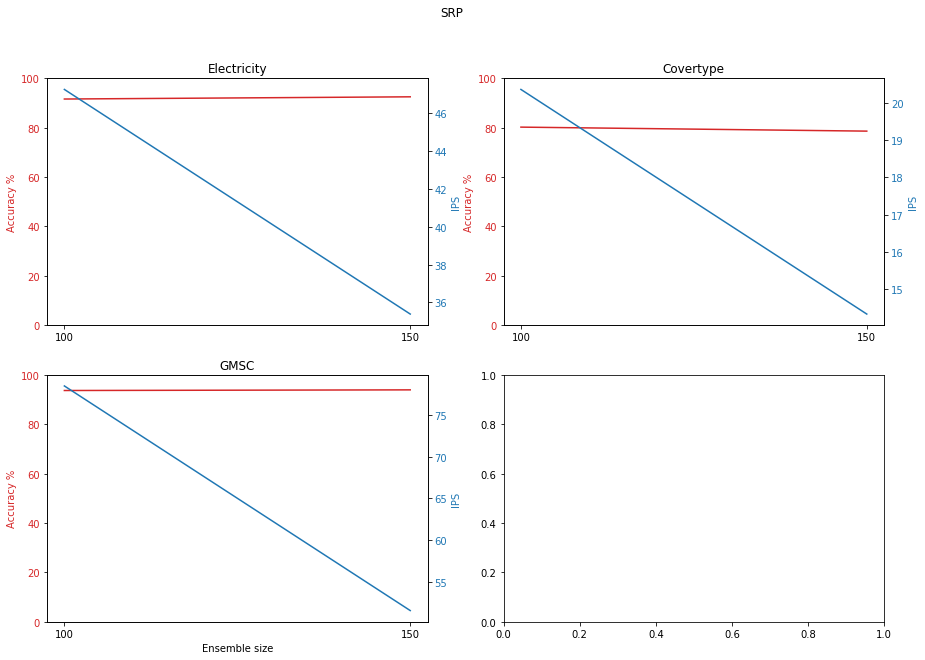

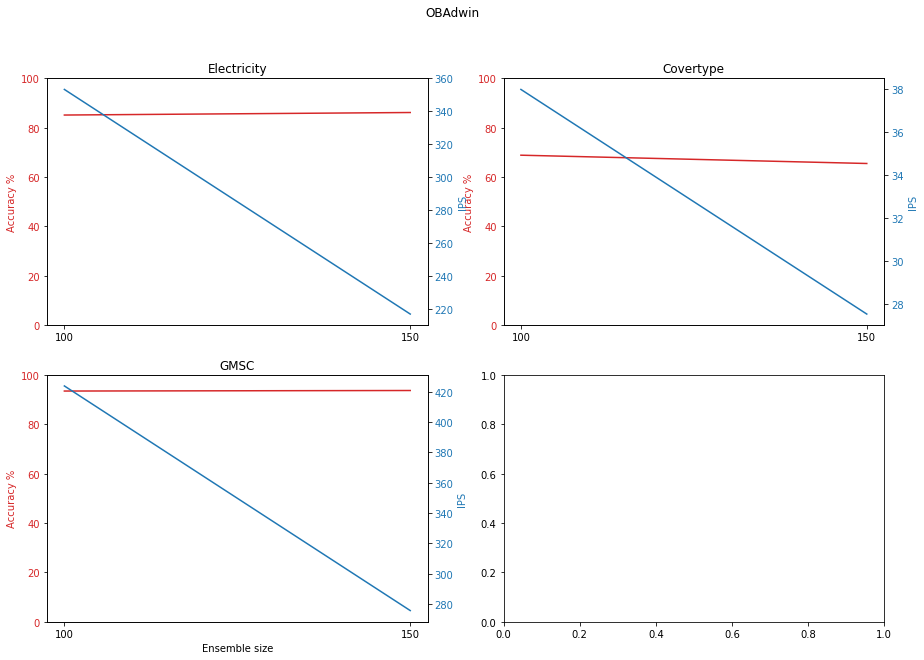

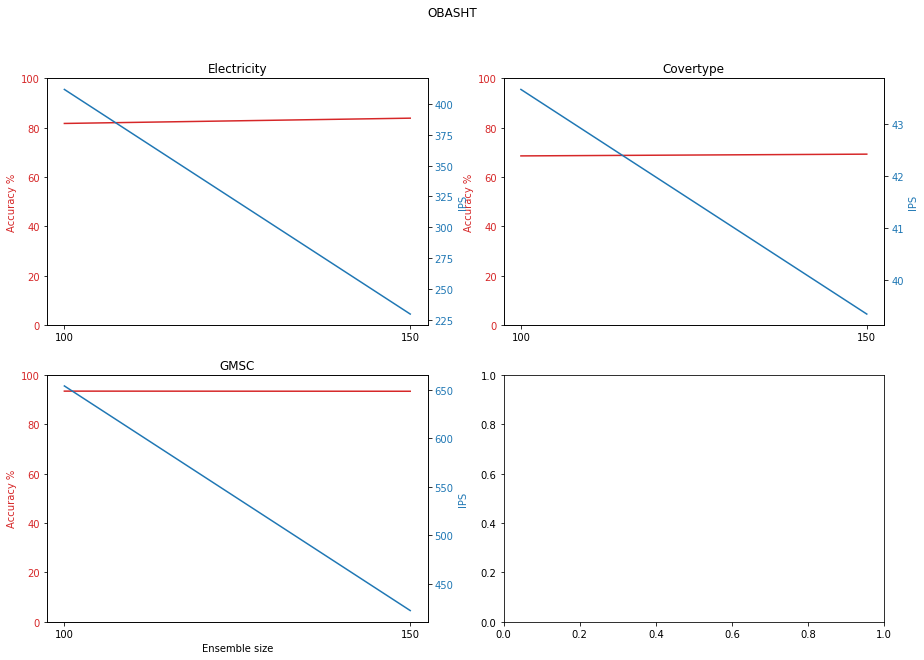

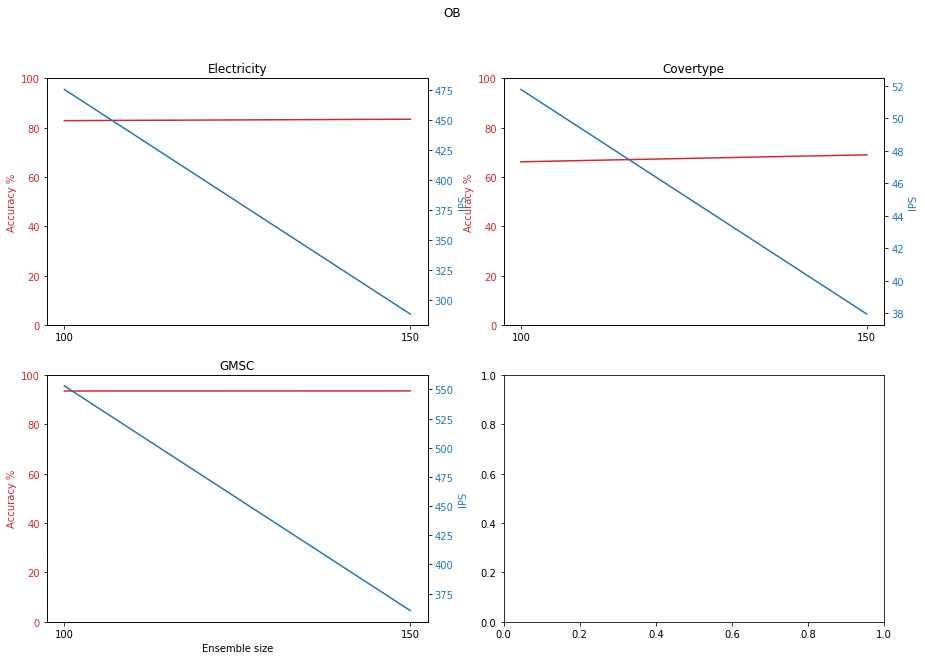

In [114]:
gen_graph_initial_peralg(chart_ensem_size, display_df=False)

## Finding rate

In [115]:
def calculate_rate(desired_esize):
    algorithms = ['ARF', 'LBag', 'SRP', 'OBAdwin', 'OBASHT', 'OB']
    file_algs = {'ARF': 'ARF', 'LBag': 'LBag', 'SRP': 'SRP', 'OBAdwin': 'OBagAd', 'OBASHT':'OBagASHT', 'OB': 'OBag'}
    for ds in df.dataset.unique():
        dsdf = df[df.dataset == ds]
        for alg in algorithms:
            s = f'X $1{ds}.arff {file_algs[alg]}'
            
            adf = filter_by_substring_algorithm(dsdf, alg)
            dfres = adf
            
            # get sequential    
            try:
                seq_rate = list((dfres[(dfres.batch_size == 1) & (dfres.cores == 1)].IPS))[0]
            except IndexError:
                return None
            
            # get runper
            try:
                runper_rate = list(dfres[(dfres.batch_size == 1) & (dfres.cores != 1)].IPS)[0]
            except IndexError:
                return None
            
            # get MB
            try:
                mb_rate = list(dfres[(dfres.batch_size != 1) & (dfres.cores != 1)].IPS)[0]
            except IndexError:
                return None
                        
            #we have max rates, now we need 10, 50 and 90
            if mb_rate != 'NaN':
                #10
                print(f'{s} {int(0.9*seq_rate)} {int(0.9*runper_rate)} {int(0.9*mb_rate)}')
                #50
                print(f'{s} {int(0.5*seq_rate)} {int(0.5*runper_rate)} {int(0.5*mb_rate)}')
                #90
                print(f'{s} {int(0.1*seq_rate)} {int(0.1*runper_rate)} {int(0.1*mb_rate)}')
            

In [116]:
print("Copy the following lines to the end of the script used to run the experimets\n")
calculate_rate(10)

Copy the following lines to the end of the script used to run the experimets

X $1GMSC.arff ARF 121 191 290
X $1GMSC.arff ARF 67 106 161
X $1GMSC.arff ARF 13 21 32
X $1GMSC.arff LBag 152 241 371
X $1GMSC.arff LBag 84 134 206
X $1GMSC.arff LBag 16 26 41
X $1GMSC.arff SRP 70 102 126
X $1GMSC.arff SRP 39 57 70
X $1GMSC.arff SRP 7 11 14
X $1GMSC.arff OBagAd 381 384 995
X $1GMSC.arff OBagAd 211 213 552
X $1GMSC.arff OBagAd 42 42 110
X $1GMSC.arff OBagASHT 588 490 1381
X $1GMSC.arff OBagASHT 327 272 767
X $1GMSC.arff OBagASHT 65 54 153
X $1GMSC.arff OBag 497 407 985
X $1GMSC.arff OBag 276 226 547
X $1GMSC.arff OBag 55 45 109
X $1covtypeNorm.arff ARF 43 112 129
X $1covtypeNorm.arff ARF 23 62 71
X $1covtypeNorm.arff ARF 4 12 14
X $1covtypeNorm.arff LBag 34 60 66
X $1covtypeNorm.arff LBag 19 33 36
X $1covtypeNorm.arff LBag 3 6 7
X $1covtypeNorm.arff SRP 18 28 42
X $1covtypeNorm.arff SRP 10 15 23
X $1covtypeNorm.arff SRP 2 3 4
X $1covtypeNorm.arff OBagAd 34 56 59
X $1covtypeNorm.arff OBagAd 18 3

# MOA logs

In [117]:
def parse_MOA(fname):
    global header_printed
    columns = []
    wanted = ['learning evaluation instances', 'Wall Time (Actual Time)', 'Avg Delay (ms)', 'outRate (inst/s)']
    pstr = ''
    spname = fname.split('/')[-1].split('-')
    spline = []
    for s in spname[1:]:
        pstr += s + ','
    with open (fname) as file:
        for line in file:
            if 'learning evaluation instances' in line:
                spline = line.split(',')
                for s in spline:
                    if s in wanted:
                        columns.append(spline.index(s))
            else:
                spline = line.split(',')
        for c in columns:
            pstr += spline[c] + ','
        if len(columns) == 2:
            pstr += '1,'
        if not header_printed:
            head = 'dataset,algorithm,ensemble_size,cores,batch_size,inc_rate,instances,time,delay,out_rate'
            pstr = f"{head}\n{pstr}"
            header_printed = True
        return (pstr[:-1])

In [118]:
def read_MOA(folder, out_file):
    directory = os.fsencode(folder)
    global header_printed

    with open(out_file, "w+") as output:
        for file in os.listdir(directory):
            filename = os.fsdecode(file)
            if filename.startswith("term-"): 
                output.write(f"{parse_MOA(f'{os.fsdecode(directory)}/{filename}')}\n")
    fname = os.fsdecode(out_file)
    df = pd.read_csv(fname)
    df['inc_rate'].astype('int64')
    return df[['algorithm', 'dataset', 'inc_rate', 'cores', 'batch_size',
               'instances', 'time', 'delay', 'out_rate']] 

## Energy Data

In [119]:
def load_Wmeas(filename):
    return pd.read_csv(filename, header=None, names=['date', 'time', 'measure'])

In [120]:
def exper_order_to_dict(filename, d):
    with open(filename) as forder:
        got_timestamp = False
        method = dataset = algorithm = Esize = cores = Bsize = ''
        dnow=None
        for line in forder:
            if not got_timestamp:
                spline = [i.strip() for i in line.split(' ')]
                sdate,stime = spline
                date_time_obj = datetime.datetime.strptime(f'{sdate} {stime}', '%d/%m/%y %H:%M:%S')
                got_timestamp = True
                if dnow:
                    dnow['finish'] = date_time_obj - datetime.timedelta(seconds=1)
            elif ':' not in line:
                spline = line.split('/')[-1].strip().split('-')
#                 print(spline)
                if len(spline) == 7:
                    method,dataset,algorithm,Esize,cores,Bsize,rate = spline
                else:
                    method,dataset,algorithm,Esize,cores,Bsize,rate = *spline,1
                if algorithm not in d:
                    d[algorithm] = {}
                if method not in d[algorithm]:
                    d[algorithm][method] = {}
                if dataset not in d[algorithm][method]:
                    d[algorithm][method][dataset] = {}
                if Esize not in d[algorithm][method][dataset]:
                    d[algorithm][method][dataset][Esize] = {}
                if cores not in d[algorithm][method][dataset][Esize]:
                    d[algorithm][method][dataset][Esize][cores] = {}
                if Bsize not in d[algorithm][method][dataset][Esize][cores]:
                    d[algorithm][method][dataset][Esize][cores][Bsize] = {}
                if rate not in d[algorithm][method][dataset][Esize][cores][Bsize]:
                    d[algorithm][method][dataset][Esize][cores][Bsize][rate] = {'start': date_time_obj, 'finish': ''}
                    dnow = d[algorithm][method][dataset][Esize][cores][Bsize][rate]
                got_timestamp = False
            else:
                spline = [i.strip() for i in line.split(' ')]
                sdate,stime = spline
                date_time_obj = datetime.datetime.strptime(f'{sdate} {stime}', '%d/%m/%y %H:%M:%S')
                got_timestamp = True
    return d

In [121]:
def populate_dict(d, df):
    df['datetime'] = df['date'] + ' ' + df['time']
    for k, v in d.items():
        for k1, v1 in v.items():
            for k2, v2 in v1.items():
                for k3, v3 in v2.items():
                    for k4, v4 in v3.items():
                        for k5, v5 in v4.items():
                            for k6, v6 in v5.items():
                                if 'seconds' not in v6:
                                    st = v6['start']
                                    ed = v6['finish']
                                    v6['seconds'] = (ed - st).seconds
                                    new_df = df[(df.datetime <= f'{ed.strftime("%d/%m/%y")} {ed.strftime("%X")}')
                                              & (df.datetime >= f'{st.strftime("%d/%m/%y")} {st.strftime("%X")}')]
                                    v6['avg_measure'] = new_df['measure'].mean()
                                    v6['sum_measure'] = new_df['measure'].sum()
                                    v6['avg_times_seconds'] = v6['avg_measure'] * v6['seconds']
    return d

In [122]:
def append_dict_to_df(d, ensemble_size=False):
    dappend = {'method': [], 'algorithm': [], 'dataset': [], 'ensemble_size': [], 'cores': [], 
               'batch_size': [], 'duration': [], 'inc_rate': [], 'avg_measure': [], 'sum_measure': [], 'avg_times_seconds': []}

    for k,v in d.items():
        for km,vm in v.items():
            for k1,v1 in vm.items():
                for k2,v2 in v1.items():
                    for k3,v3 in v2.items():
                        for k4,v4 in v3.items():
                            for k5,v5 in v4.items():
                                #print(v5)
                                dappend['algorithm'].append(k1)
                                dappend['method'].append(km)
                                dappend['dataset'].append(km)
                                dappend['ensemble_size'].append(k3)
                                dappend['cores'].append(k2)
                                dappend['batch_size'].append(k3)
                                dappend['duration'].append(v5['seconds'])
                                dappend['inc_rate'].append(k4)
                                for key in ['avg_measure', 'sum_measure','avg_times_seconds']:
                                    dappend[key].append(v5[key])
    adf = pd.DataFrame(data=dappend)
    adf = adf.sort_values(['algorithm','dataset']).astype({'inc_rate': 'int64', 
                                                           'cores': 'int64',
                                                           'batch_size': 'int64'})
    if ensemble_size:
        return adf[['algorithm', 'dataset', 'ensemble_size', 'inc_rate', 'cores', 'batch_size',
               'duration', 'avg_measure', 'sum_measure']]
    return adf[['algorithm', 'dataset', 'inc_rate', 'cores', 'batch_size',
               'duration', 'avg_measure', 'sum_measure']]

# Parse SSH logs

In [123]:
def parse_SSH(fname):
    fname = os.fsdecode(fname)
    read_ssh = False
    alg = ''
    dataset = ''
    rate = ''
    d = {'algorithm': [], 'dataset': [], 'inc_rate': [], 'prod_rate': [], 'tt_inst_prod': []}
    with open (fname, "r") as file:
        for line in file:
            if not read_ssh:
                if 'ssh-' in line:
                    read_ssh = True
                    print(line.split('-')[1:])
                    dataset, alg, batch, rate = line.split('-')[1:]
                    d['algorithm'].append(alg)
                    d['dataset'].append(dataset)
                    d['inc_rate'].append(rate.strip())
            else:
                if 'Total instances Producer' in line:
                    tt_inst = float(line.split(': ')[1])
                    d['tt_inst_prod'].append(tt_inst)
                elif 'Producer Rate' in line:
                    prod_rate = float(line.split(': ')[1])
                    d['prod_rate'].append(prod_rate)
                    read_ssh = False
    return pd.DataFrame.from_dict(d).astype({'inc_rate': 'int64'})

# RUN MOTHERFUCKER

%cd pi
d = {}
df = load_Wmeas(f'energy/Wmeasure.log')
exper_order_to_dict(f'energy/exper_order.log')
d = populate_dict(d)
adf = append_dict_to_df(d, df)

In [127]:
%cd /Users/reginaldoluisdeluna/Documents/Ufscar/comparison-xue3m-minibatching/
%pwd

/Users/reginaldoluisdeluna/Documents/Ufscar/comparison-xue3m-minibatching


'/Users/reginaldoluisdeluna/Documents/Ufscar/comparison-xue3m-minibatching'

In [130]:
d = {}
header_printed = False
moaDF = read_MOA("results/socket/800/800", "pi/energy/inst-and-delay.csv")
measureDF = load_Wmeas(f'/Users/reginaldoluisdeluna/Documents/Ufscar/comparison-xue3m-minibatching/results/socket/800-18-01-2022.out')
d = exper_order_to_dict(f'results/socket/800/800/exper_order-freq-max-800-freq-min-800.log', d)
populate_dict(d, measureDF)
mdf = append_dict_to_df(d)
sshDF = parse_SSH(f'results/socket/800/800/ssh-log')

['GMSC', 'AdaptiveRandomForestExecutorMAXChunk', '50', '32\n']
['GMSC', 'AdaptiveRandomForestExecutorMAXChunk', '50', '160\n']
['GMSC', 'AdaptiveRandomForestExecutorMAXChunk', '50', '288\n']
['GMSC', 'LBagExecutorMAXChunk', '50', '42\n']
['GMSC', 'LBagExecutorMAXChunk', '50', '210\n']
['GMSC', 'LBagExecutorMAXChunk', '50', '378\n']
['GMSC', 'StreamingRandomPatchesExecutorMAXChunk', '50', '18\n']
['GMSC', 'StreamingRandomPatchesExecutorMAXChunk', '50', '90\n']
['GMSC', 'StreamingRandomPatchesExecutorMAXChunk', '50', '162\n']
['GMSC', 'OzaBagAdwinExecutorMAXChunk', '50', '107\n']
['GMSC', 'OzaBagAdwinExecutorMAXChunk', '50', '537\n']
['GMSC', 'OzaBagAdwinExecutorMAXChunk', '50', '968\n']
['GMSC', 'OzaBagASHTExecutorMAXChunk', '50', '170\n']
['GMSC', 'OzaBagASHTExecutorMAXChunk', '50', '850\n']
['GMSC', 'OzaBagASHTExecutorMAXChunk', '50', '1530\n']
['GMSC', 'OzaBagExecutorMAXChunk', '50', '108\n']
['GMSC', 'OzaBagExecutorMAXChunk', '50', '543\n']
['GMSC', 'AdaptiveRandomForestExecutorMAXC

In [131]:
#join dfs
finaldf = moaDF.merge(mdf, on=['algorithm', 'dataset', 'inc_rate', 'batch_size', 'cores'])
finaldf = finaldf.merge(sshDF, on=['algorithm', 'dataset', 'inc_rate'])
finaldf['joules'] = finaldf['avg_measure'] * finaldf['time']
finaldf['JPI'] = finaldf['joules'] / finaldf['instances']
print(finaldf)
# finaldf['JP1kI'] = finaldf['joules'] / (finaldf['instances']/1000)
# finaldf['JPIoriginal'] = finaldf['JPI']
# finaldf['JPI'] = finaldf['JP1kI']
finaldf

                      algorithm      dataset  inc_rate  cores  batch_size  \
0    OzaBagASHTExecutorMAXChunk  covtypeNorm        32      4        2000   
1    OzaBagASHTExecutorMAXChunk  covtypeNorm        32      4        2000   
2    OzaBagASHTExecutorMAXChunk  covtypeNorm        32      4        2000   
3    OzaBagASHTExecutorMAXChunk  covtypeNorm        32      4         500   
4    OzaBagASHTExecutorMAXChunk  covtypeNorm        32      4         500   
..                          ...          ...       ...    ...         ...   
517      OzaBagExecutorMAXChunk  elecNormNew       479      4          50   
518      OzaBagExecutorMAXChunk  elecNormNew       479      4          50   
519      OzaBagExecutorMAXChunk  elecNormNew       479      4         500   
520      OzaBagExecutorMAXChunk  elecNormNew       479      4         500   
521      OzaBagExecutorMAXChunk  elecNormNew       479      4         500   

     instances   time     delay  out_rate  duration  avg_measure  sum_measu

algorithm      dataset  inc_rate  cores  batch_size  \
0    OzaBagASHTExecutorMAXChunk  covtypeNorm        32      4        2000   
1    OzaBagASHTExecutorMAXChunk  covtypeNorm        32      4        2000   
2    OzaBagASHTExecutorMAXChunk  covtypeNorm        32      4        2000   
3    OzaBagASHTExecutorMAXChunk  covtypeNorm        32      4         500   
4    OzaBagASHTExecutorMAXChunk  covtypeNorm        32      4         500   
..                          ...          ...       ...    ...         ...   
517      OzaBagExecutorMAXChunk  elecNormNew       479      4          50   
518      OzaBagExecutorMAXChunk  elecNormNew       479      4          50   
519      OzaBagExecutorMAXChunk  elecNormNew       479      4         500   
520      OzaBagExecutorMAXChunk  elecNormNew       479      4         500   
521      OzaBagExecutorMAXChunk  elecNormNew       479      4         500   

     instances   time     delay  out_rate  duration  avg_measure  sum_measure  \
0     3,600.00 119.96 35,077.00     30.01       129         4.08       942.10   
1     3,600.00 119.96 35,077.00     30.01       129         4.08       942.10   
2     3,600.00 119.96 35,077.00     30.01       129         4.08       942.10   
3     3,600.00 119.96  9,244.00     30.01       125         4.15       937.10   
4     3,600.00 119.96  9,244.00     30.01       125         4.15       937.10   
..         ...    ...       ...       ...       ...          ...          ...   
517  45,312.00  95.49     58.00    474.52       100          NaN         0.00   
518  45,312.00  95.49     58.00    474.52       100          NaN         0.00   
519  45,312.00  95.45    644.00    474.70       101         3.73        63.40   
520  45,312.00  95.45    644.00    474.70       101         3.73        63.40   
521  45,312.00  95.45    644.00    474.70       101         3.73        63.40   

     prod_rate  tt_inst_prod  joules  JPI  
0        29.96      3,600.00  489.24 0.14  
1        29.96      3,600.00  489.24 0.14  
2        29.96      3,600.00  489.24 0.14  
3        29.96      3,600.00  497.43 0.14  
4        29.96      3,600.00  497.43 0.14  
..         ...           ...     ...  ...  
517     473.78     45,312.00     NaN  NaN  
518     473.75     45,312.00     NaN  NaN  
519     473.69     45,312.00  355.99 0.01  
520     473.78     45,312.00  355.99 0.01  
521     473.75     45,312.00  355.99 0.01  

[522 rows x 16 columns]

### Add PERC column to identify if it used 90, 50 or 10% max rate

In [133]:
tdf = finaldf.sort_values(by=['dataset','algorithm','inc_rate'], ascending=False)
tdf['PERC'] = 0
masks = {'90':[], '50': [], '10': []}
for k, v in zip(masks.keys(), [0, 1, 2]):
#         x = 1 if i % 3 == v else 0
    for i in range(len(tdf)):
        masks[k].append(i % 3 == v)
tdf.loc[masks['90'],'PERC'] = '90'
tdf.loc[masks['50'],'PERC'] = '50'
tdf.loc[masks['10'],'PERC'] = '10'
# tdf

### Show DFs for each algorithm and dataset, divided by rate

In [135]:
algs = ['Ada', 'LB', 'Patch', 'Adwin', 'ASHT', 'OzaBag']
# datasets = ['airlines', 'GMSC','elecNormNew','covtypeNorm']
datasets = ['elecNormNew', 'covtypeNorm']
for k in ['90', '50', '10']:
    energy = tdf[tdf.PERC == k]
    for ds in energy.dataset.unique():
        for alg in algs:
            auxdf = energy[(energy.dataset == ds) & (energy.algorithm.str.contains(alg))]
            auxdf = filter_by_substring_algorithm(energy[energy.dataset == ds], alg)
            if alg == 'Patch' or alg == 'Ada':
                display(auxdf[['algorithm','dataset','cores','batch_size','prod_rate','out_rate','instances','time','joules','JPI']].sort_values(['cores','batch_size']))
        auxdf = energy[(energy.dataset == ds) & (~energy.algorithm.str.contains('|'.join(algs)))]
        display(auxdf[['algorithm','dataset','cores','batch_size','prod_rate','out_rate','instances','time','joules','JPI']].sort_values(['cores','batch_size']))

algorithm      dataset  cores  batch_size  \
132  AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4          50   
72   AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4          50   
423  AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4          50   
126  AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4         500   
75   AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4         500   
417  AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4         500   
129  AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4        2000   
69   AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4        2000   
420  AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4        2000   

     prod_rate  out_rate  instances   time  joules  JPI  
132     149.73    149.92  17,970.00 119.87     NaN  NaN  
72       84.86     84.99  10,183.00 119.81     NaN  NaN  
423      14.98     15.00   1,800.00 120.01     NaN  NaN  
126     149.73    149.96  17,970.00 119.83     NaN  NaN  
75       84.86     84.86  10,184.00 120.01     NaN  NaN  
417      14.98     15.01   1,800.00 119.96     NaN  NaN  
129     149.73    149.97  17,970.00 119.82  480.55 0.03  
69       84.86     84.86  10,184.00 120.01  487.26 0.05  
420      14.98     15.01   1,800.00 119.96  506.60 0.28

algorithm      dataset  cores  batch_size  \
174  StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4          50   
489  StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4          50   
300  StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4          50   
171  StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4         500   
492  StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4         500   
306  StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4         500   
168  StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4        2000   
303  StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4        2000   

     prod_rate  out_rate  instances   time  joules  JPI  
174      39.94     39.98   4,800.00 120.07     NaN  NaN  
489      19.97     19.98   2,400.00 120.15     NaN  NaN  
300      19.97     19.99   2,400.00 120.05     NaN  NaN  
171      39.94     40.00   4,800.00 119.99     NaN  NaN  
492      19.98     20.01   2,400.00 119.96     NaN  NaN  
306      19.97     20.01   2,400.00 119.96     NaN  NaN  
168      39.94     40.00   4,800.00 119.99  470.40 0.10  
303      19.97     20.01   2,400.00 119.96  516.84 0.22

Empty DataFrame
Columns: [algorithm, dataset, cores, batch_size, prod_rate, out_rate, instances, time, joules, JPI]
Index: []

algorithm      dataset  cores  batch_size  \
273  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4          50   
228  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4          50   
318  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4          50   
276  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4         500   
225  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4         500   
321  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4         500   
231  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4        2000   
324  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4        2000   

     prod_rate  out_rate  instances   time  joules  JPI  
273      99.83     99.99  11,980.00 119.81     NaN  NaN  
228      54.92     54.96   6,600.00 120.08     NaN  NaN  
318       9.99     10.00   1,200.00 120.04     NaN  NaN  
276      99.84     99.99  11,980.00 119.81  508.33 0.04  
225      54.92     55.00   6,600.00 119.99  500.78 0.08  
321       9.99     10.00   1,200.00 119.94  475.99 0.40  
231      54.92     55.00   6,600.00 120.00  521.62 0.08  
324       9.99     10.00   1,200.00 119.94  489.26 0.41

algorithm      dataset  cores  batch_size  \
36   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4          50   
243  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4          50   
198  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4          50   
30   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4         500   
246  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4         500   
204  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4         500   
33   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4        2000   
249  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4        2000   
201  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4        2000   

     prod_rate  out_rate  instances   time  joules  JPI  
36       39.94     39.89   4,800.00 120.33     NaN  NaN  
243      19.98     19.97   2,400.00 120.18     NaN  NaN  
198      19.98     19.97   2,400.00 120.21     NaN  NaN  
30       39.94     40.01   4,800.00 119.98  501.24 0.10  
246      19.98     20.01   2,400.00 119.95  501.53 0.21  
204      19.98     20.01   2,400.00 119.95  471.32 0.20  
33       39.94     40.01   4,800.00 119.97  463.67 0.10  
249      19.98       NaN        NaN    NaN     NaN  NaN  
201      19.98       NaN        NaN    NaN     NaN  NaN

Empty DataFrame
Columns: [algorithm, dataset, cores, batch_size, prod_rate, out_rate, instances, time, joules, JPI]
Index: []

algorithm dataset  cores  batch_size  \
24   AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
237  AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
402  AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
18   AdaptiveRandomForestExecutorMAXChunk    GMSC      4         500   
21   AdaptiveRandomForestExecutorMAXChunk    GMSC      4         500   
234  AdaptiveRandomForestExecutorMAXChunk    GMSC      4         500   
396  AdaptiveRandomForestExecutorMAXChunk    GMSC      4         500   
27   AdaptiveRandomForestExecutorMAXChunk    GMSC      4        2000   
240  AdaptiveRandomForestExecutorMAXChunk    GMSC      4        2000   
399  AdaptiveRandomForestExecutorMAXChunk    GMSC      4        2000   

     prod_rate  out_rate  instances   time  joules  JPI  
24      284.40    284.78  34,143.00 119.89     NaN  NaN  
237     159.73    159.94  19,168.00 119.85     NaN  NaN  
402      29.96     30.00   3,600.00 120.00     NaN  NaN  
18      284.41    284.83  34,143.00 119.87  455.36 0.01  
21      284.42    284.83  34,143.00 119.87  455.36 0.01  
234     159.73    159.98  19,168.00 119.82  476.14 0.02  
396      29.96     30.01   3,600.00 119.97  456.31 0.13  
27      284.41    281.80  34,000.00 120.65  528.33 0.02  
240     159.73    159.98  19,168.00 119.82  511.21 0.03  
399      29.96     30.01   3,600.00 119.97  489.03 0.14

algorithm dataset  cores  batch_size  \
63   StreamingRandomPatchesExecutorMAXChunk    GMSC      4          50   
498  StreamingRandomPatchesExecutorMAXChunk    GMSC      4          50   
294  StreamingRandomPatchesExecutorMAXChunk    GMSC      4          50   
57   StreamingRandomPatchesExecutorMAXChunk    GMSC      4         500   
60   StreamingRandomPatchesExecutorMAXChunk    GMSC      4         500   
501  StreamingRandomPatchesExecutorMAXChunk    GMSC      4         500   
288  StreamingRandomPatchesExecutorMAXChunk    GMSC      4         500   
291  StreamingRandomPatchesExecutorMAXChunk    GMSC      4         500   
66   StreamingRandomPatchesExecutorMAXChunk    GMSC      4        2000   
495  StreamingRandomPatchesExecutorMAXChunk    GMSC      4        2000   
297  StreamingRandomPatchesExecutorMAXChunk    GMSC      4        2000   

     prod_rate  out_rate  instances   time  joules  JPI  
63      159.73    159.92  19,168.00 119.86     NaN  NaN  
498      89.86     89.86  10,783.00 120.00     NaN  NaN  
294      14.98     15.00   1,800.00 120.04     NaN  NaN  
57      159.73    159.98  19,168.00 119.81  450.79 0.02  
60      159.73    159.98  19,168.00 119.81  450.79 0.02  
501      89.86     89.85  10,783.00 120.01  467.55 0.04  
288      14.98     15.01   1,800.00 119.95  460.06 0.26  
291      14.98     15.01   1,800.00 119.95  460.06 0.26  
66       89.85    159.73  19,169.00 120.01  474.60 0.02  
495      89.86     89.86  10,783.00 120.00  481.23 0.04  
297      14.98     15.01   1,800.00 119.96  476.51 0.26

Empty DataFrame
Columns: [algorithm, dataset, cores, batch_size, prod_rate, out_rate, instances, time, joules, JPI]
Index: []

algorithm      dataset  cores  batch_size  \
133  AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4          50   
73   AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4          50   
424  AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4          50   
127  AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4         500   
76   AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4         500   
418  AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4         500   
130  AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4        2000   
70   AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4        2000   
421  AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4        2000   

     prod_rate  out_rate  instances   time  joules  JPI  
133     149.73    149.92  17,970.00 119.87     NaN  NaN  
73       84.86     84.99  10,183.00 119.81     NaN  NaN  
424      14.98     15.00   1,800.00 120.01     NaN  NaN  
127     149.73    149.96  17,970.00 119.83     NaN  NaN  
76       84.86     84.86  10,184.00 120.01     NaN  NaN  
418      14.98     15.01   1,800.00 119.96     NaN  NaN  
130     149.73    149.97  17,970.00 119.82  480.55 0.03  
70       84.86     84.86  10,184.00 120.01  487.26 0.05  
421      14.98     15.01   1,800.00 119.96  506.60 0.28

algorithm      dataset  cores  batch_size  \
175  StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4          50   
490  StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4          50   
301  StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4          50   
172  StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4         500   
307  StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4         500   
169  StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4        2000   
493  StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4        2000   
304  StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4        2000   

     prod_rate  out_rate  instances   time  joules  JPI  
175      39.94     39.98   4,800.00 120.07     NaN  NaN  
490      19.98     19.98   2,400.00 120.15     NaN  NaN  
301      19.97     19.99   2,400.00 120.05     NaN  NaN  
172      39.94     40.00   4,800.00 119.99     NaN  NaN  
307      19.97     20.01   2,400.00 119.96     NaN  NaN  
169      39.94     40.00   4,800.00 119.99  470.40 0.10  
493      19.97     20.01   2,400.00 119.96  481.11 0.20  
304      19.97     20.01   2,400.00 119.96  516.84 0.22

Empty DataFrame
Columns: [algorithm, dataset, cores, batch_size, prod_rate, out_rate, instances, time, joules, JPI]
Index: []

algorithm      dataset  cores  batch_size  \
274  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4          50   
229  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4          50   
319  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4          50   
226  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4         500   
322  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4         500   
277  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4        2000   
232  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4        2000   
325  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4        2000   

     prod_rate  out_rate  instances   time  joules  JPI  
274      99.84     99.99  11,980.00 119.81     NaN  NaN  
229      54.92     54.96   6,600.00 120.08     NaN  NaN  
319       9.99     10.00   1,200.00 120.04     NaN  NaN  
226      54.92     55.00   6,600.00 119.99  500.78 0.08  
322       9.99     10.00   1,200.00 119.94  475.99 0.40  
277      99.83     93.03  11,164.00 120.00  476.55 0.04  
232      54.92     55.00   6,600.00 120.00  521.62 0.08  
325       9.99     10.00   1,200.00 119.94  489.26 0.41

algorithm      dataset  cores  batch_size  \
37   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4          50   
244  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4          50   
199  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4          50   
31   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4         500   
247  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4         500   
205  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4         500   
34   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4        2000   
250  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4        2000   
202  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4        2000   

     prod_rate  out_rate  instances   time  joules  JPI  
37       39.94     39.89   4,800.00 120.33     NaN  NaN  
244      19.98     19.97   2,400.00 120.18     NaN  NaN  
199      19.98     19.97   2,400.00 120.21     NaN  NaN  
31       39.94     40.01   4,800.00 119.98  501.24 0.10  
247      19.98     20.01   2,400.00 119.95  501.53 0.21  
205      19.98     20.01   2,400.00 119.95  471.32 0.20  
34       39.94     40.01   4,800.00 119.97  463.67 0.10  
250      19.98       NaN        NaN    NaN     NaN  NaN  
202      19.98       NaN        NaN    NaN     NaN  NaN

Empty DataFrame
Columns: [algorithm, dataset, cores, batch_size, prod_rate, out_rate, instances, time, joules, JPI]
Index: []

algorithm dataset  cores  batch_size  \
22   AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
25   AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
238  AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
403  AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
19   AdaptiveRandomForestExecutorMAXChunk    GMSC      4         500   
235  AdaptiveRandomForestExecutorMAXChunk    GMSC      4         500   
397  AdaptiveRandomForestExecutorMAXChunk    GMSC      4         500   
28   AdaptiveRandomForestExecutorMAXChunk    GMSC      4        2000   
241  AdaptiveRandomForestExecutorMAXChunk    GMSC      4        2000   
400  AdaptiveRandomForestExecutorMAXChunk    GMSC      4        2000   

     prod_rate  out_rate  instances   time  joules  JPI  
22      284.41    284.78  34,143.00 119.89     NaN  NaN  
25      284.42    284.78  34,143.00 119.89     NaN  NaN  
238     159.73    159.94  19,168.00 119.85     NaN  NaN  
403      29.96     30.00   3,600.00 120.00     NaN  NaN  
19      284.41    284.83  34,143.00 119.87  455.36 0.01  
235     159.73    159.98  19,168.00 119.82  476.14 0.02  
397      29.96     30.01   3,600.00 119.97  456.31 0.13  
28      284.40    281.80  34,000.00 120.65  528.33 0.02  
241     159.73    159.98  19,168.00 119.82  511.21 0.03  
400      29.96     30.01   3,600.00 119.97  489.03 0.14

algorithm dataset  cores  batch_size  \
61   StreamingRandomPatchesExecutorMAXChunk    GMSC      4          50   
64   StreamingRandomPatchesExecutorMAXChunk    GMSC      4          50   
499  StreamingRandomPatchesExecutorMAXChunk    GMSC      4          50   
292  StreamingRandomPatchesExecutorMAXChunk    GMSC      4          50   
295  StreamingRandomPatchesExecutorMAXChunk    GMSC      4          50   
58   StreamingRandomPatchesExecutorMAXChunk    GMSC      4         500   
502  StreamingRandomPatchesExecutorMAXChunk    GMSC      4         500   
289  StreamingRandomPatchesExecutorMAXChunk    GMSC      4         500   
67   StreamingRandomPatchesExecutorMAXChunk    GMSC      4        2000   
496  StreamingRandomPatchesExecutorMAXChunk    GMSC      4        2000   
298  StreamingRandomPatchesExecutorMAXChunk    GMSC      4        2000   

     prod_rate  out_rate  instances   time  joules  JPI  
61      159.73    159.92  19,168.00 119.86     NaN  NaN  
64      159.73    159.92  19,168.00 119.86     NaN  NaN  
499      89.85     89.86  10,783.00 120.00     NaN  NaN  
292      14.98     15.00   1,800.00 120.04     NaN  NaN  
295      14.98     15.00   1,800.00 120.04     NaN  NaN  
58       89.85    159.98  19,168.00 119.81  450.79 0.02  
502      89.85     89.85  10,783.00 120.01  467.55 0.04  
289      14.98     15.01   1,800.00 119.95  460.06 0.26  
67      159.73    159.73  19,169.00 120.01  474.60 0.02  
496      89.85     89.86  10,783.00 120.00  481.23 0.04  
298      14.98     15.01   1,800.00 119.96  476.51 0.26

Empty DataFrame
Columns: [algorithm, dataset, cores, batch_size, prod_rate, out_rate, instances, time, joules, JPI]
Index: []

algorithm      dataset  cores  batch_size  \
134  AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4          50   
74   AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4          50   
425  AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4          50   
128  AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4         500   
77   AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4         500   
419  AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4         500   
131  AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4        2000   
71   AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4        2000   
422  AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4        2000   

     prod_rate  out_rate  instances   time  joules  JPI  
134     149.73    149.92  17,970.00 119.87     NaN  NaN  
74       84.86     84.99  10,183.00 119.81     NaN  NaN  
425      14.98     15.00   1,800.00 120.01     NaN  NaN  
128     149.73    149.96  17,970.00 119.83     NaN  NaN  
77       84.86     84.86  10,184.00 120.01     NaN  NaN  
419      14.98     15.01   1,800.00 119.96     NaN  NaN  
131     149.73    149.97  17,970.00 119.82  480.55 0.03  
71       84.86     84.86  10,184.00 120.01  487.26 0.05  
422      14.98     15.01   1,800.00 119.96  506.60 0.28

algorithm      dataset  cores  batch_size  \
176  StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4          50   
302  StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4          50   
173  StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4         500   
491  StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4         500   
308  StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4         500   
170  StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4        2000   
494  StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4        2000   
305  StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4        2000   

     prod_rate  out_rate  instances   time  joules  JPI  
176      39.94     39.98   4,800.00 120.07     NaN  NaN  
302      19.97     19.99   2,400.00 120.05     NaN  NaN  
173      39.94     40.00   4,800.00 119.99     NaN  NaN  
491      19.97     20.01   2,400.00 119.96     NaN  NaN  
308      19.97     20.01   2,400.00 119.96     NaN  NaN  
170      39.94     40.00   4,800.00 119.99  470.40 0.10  
494      19.98     20.01   2,400.00 119.96  481.11 0.20  
305      19.97     20.01   2,400.00 119.96  516.84 0.22

Empty DataFrame
Columns: [algorithm, dataset, cores, batch_size, prod_rate, out_rate, instances, time, joules, JPI]
Index: []

algorithm      dataset  cores  batch_size  \
230  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4          50   
320  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4          50   
275  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4         500   
227  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4         500   
323  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4         500   
278  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4        2000   
233  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4        2000   
326  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4        2000   

     prod_rate  out_rate  instances   time  joules  JPI  
230      54.91     54.96   6,600.00 120.08     NaN  NaN  
320       9.99     10.00   1,200.00 120.04     NaN  NaN  
275      99.83     99.99  11,980.00 119.81  508.33 0.04  
227      54.91     55.00   6,600.00 119.99  500.78 0.08  
323       9.99     10.00   1,200.00 119.94  475.99 0.40  
278      99.84     93.03  11,164.00 120.00  476.55 0.04  
233      54.91     55.00   6,600.00 120.00  521.62 0.08  
326       9.99     10.00   1,200.00 119.94  489.26 0.41

algorithm      dataset  cores  batch_size  \
38   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4          50   
245  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4          50   
200  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4          50   
32   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4         500   
248  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4         500   
206  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4         500   
35   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4        2000   
251  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4        2000   
203  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4        2000   

     prod_rate  out_rate  instances   time  joules  JPI  
38       39.94     39.89   4,800.00 120.33     NaN  NaN  
245      19.98     19.97   2,400.00 120.18     NaN  NaN  
200      19.98     19.97   2,400.00 120.21     NaN  NaN  
32       39.94     40.01   4,800.00 119.98  501.24 0.10  
248      19.98     20.01   2,400.00 119.95  501.53 0.21  
206      19.98     20.01   2,400.00 119.95  471.32 0.20  
35       39.94     40.01   4,800.00 119.97  463.67 0.10  
251      19.98       NaN        NaN    NaN     NaN  NaN  
203      19.98       NaN        NaN    NaN     NaN  NaN

Empty DataFrame
Columns: [algorithm, dataset, cores, batch_size, prod_rate, out_rate, instances, time, joules, JPI]
Index: []

algorithm dataset  cores  batch_size  \
23   AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
239  AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
404  AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
20   AdaptiveRandomForestExecutorMAXChunk    GMSC      4         500   
236  AdaptiveRandomForestExecutorMAXChunk    GMSC      4         500   
398  AdaptiveRandomForestExecutorMAXChunk    GMSC      4         500   
26   AdaptiveRandomForestExecutorMAXChunk    GMSC      4        2000   
29   AdaptiveRandomForestExecutorMAXChunk    GMSC      4        2000   
242  AdaptiveRandomForestExecutorMAXChunk    GMSC      4        2000   
401  AdaptiveRandomForestExecutorMAXChunk    GMSC      4        2000   

     prod_rate  out_rate  instances   time  joules  JPI  
23      284.41    284.78  34,143.00 119.89     NaN  NaN  
239     159.73    159.94  19,168.00 119.85     NaN  NaN  
404      29.96     30.00   3,600.00 120.00     NaN  NaN  
20      284.40    284.83  34,143.00 119.87  455.36 0.01  
236     159.73    159.98  19,168.00 119.82  476.14 0.02  
398      29.96     30.01   3,600.00 119.97  456.31 0.13  
26      284.41    281.80  34,000.00 120.65  528.33 0.02  
29      284.42    281.80  34,000.00 120.65  528.33 0.02  
242     159.73    159.98  19,168.00 119.82  511.21 0.03  
401      29.96     30.01   3,600.00 119.97  489.03 0.14

algorithm dataset  cores  batch_size  \
62   StreamingRandomPatchesExecutorMAXChunk    GMSC      4          50   
500  StreamingRandomPatchesExecutorMAXChunk    GMSC      4          50   
293  StreamingRandomPatchesExecutorMAXChunk    GMSC      4          50   
59   StreamingRandomPatchesExecutorMAXChunk    GMSC      4         500   
503  StreamingRandomPatchesExecutorMAXChunk    GMSC      4         500   
290  StreamingRandomPatchesExecutorMAXChunk    GMSC      4         500   
65   StreamingRandomPatchesExecutorMAXChunk    GMSC      4        2000   
68   StreamingRandomPatchesExecutorMAXChunk    GMSC      4        2000   
497  StreamingRandomPatchesExecutorMAXChunk    GMSC      4        2000   
296  StreamingRandomPatchesExecutorMAXChunk    GMSC      4        2000   
299  StreamingRandomPatchesExecutorMAXChunk    GMSC      4        2000   

     prod_rate  out_rate  instances   time  joules  JPI  
62       89.85    159.92  19,168.00 119.86     NaN  NaN  
500      89.86     89.86  10,783.00 120.00     NaN  NaN  
293      14.98     15.00   1,800.00 120.04     NaN  NaN  
59      159.73    159.98  19,168.00 119.81  450.79 0.02  
503      89.86     89.85  10,783.00 120.01  467.55 0.04  
290      14.98     15.01   1,800.00 119.95  460.06 0.26  
65      159.73    159.73  19,169.00 120.01  474.60 0.02  
68      159.73    159.73  19,169.00 120.01  474.60 0.02  
497      89.86     89.86  10,783.00 120.00  481.23 0.04  
296      14.98     15.01   1,800.00 119.96  476.51 0.26  
299      14.98     15.01   1,800.00 119.96  476.51 0.26

Empty DataFrame
Columns: [algorithm, dataset, cores, batch_size, prod_rate, out_rate, instances, time, joules, JPI]
Index: []

# Showing and preparing for graphs

In [136]:
def filter_fields(df):
    wanted = ['algorithm', 'dataset', 'batch_size', 'cores', 'out_rate', 'instances', 'delay', 'joules', 'JPI']
    return df[[
        l for l in df.columns if any([w in l for w in wanted])
    ]]

In [137]:
def rename_columns_by_rate(df):
    display(df)
    rate = df.PERC.iloc[0]
    return df.rename(columns={"out_rate": f"out_rate_{rate}", "instances": f"instances_{rate}",
                              "delay": f"delay_{rate}", "joules": f"joules_{rate}", "JPI": f"JPI_{rate}"})

In [138]:
def my_norm(df, x='90MB'):
    mdf = df.iloc[:,[0,1,15,30,45]]
    if x == '90MB':
        thisisone = mdf.iloc[2,4]
#     else:
    elif x == '10S':
        thisisone = mdf.iloc[0,2]
    else:
#         10P
        thisisone = mdf.iloc[1,2]
    for i in ['JPI_10','JPI_50','JPI_90']:
           df[i] = df[i]/thisisone
#     display(df.iloc[:,[0,1,15,30,45]])
    return df.iloc[:,[0,1,15,30,45,7,22,37]]

linhas pretas (solida, tracejada, pontilhada)

JPI em barras (3 barras por rate)

In [139]:
def show_graph_JPI_delay(df, ax, mJPI, mDel, legend=False, title=False, ylabels=False, ds='', bar=False, share_y=False, log_y=False, norm=False, hide=True):
    if norm:
        df = my_norm(df, x=norm)
    global rate
    global twin
    width = 0.20
    alg_order = ['Sequential', 'B1', 'B500']
    labels = ['10%', '50%', '90%']
    line_format = ['-', '--', ':']
    linfo = '--'
    x = np.arange(len(labels))
    lns_l = []
    for i in range(3):
        adf = df.iloc[[i]]
        values_j = [adf.JPI_10.iloc[0], adf.JPI_50.iloc[0], adf.JPI_90.iloc[0]]
        if bar:
            lns_l += ax.bar(x - ((1 - i) * width), values_j, width, label=f'JPI-{alg_order[i]}')            
        else:
            lns_l += ax.plot(x, values_j, label=f'JPI-{alg_order[i]}')
            
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax_r = ax.twinx()
    twin = ax_r
    if log_y:
        ax.set_yscale('log')
        ax_r.set_yscale('log')
    
    if title:
        alg_title = re.sub('Sequential', '', df.algorithm.iloc[0])
        ax.set_title(f'{alg_title}')
#         ax.set_xlabel('Rate')
    
    if ylabels:
        ax.set_ylabel(ds)
#         ax.set_ylabel('JPI')
#         ax_r.set_ylabel('delay')
        
    if last:
        ax.set_ymargin(5)
    
    for i in range(3):
        adf = df.iloc[[i]]
        values_d = [x/1000 for x in [adf.delay_10.iloc[0], adf.delay_50.iloc[0], adf.delay_90.iloc[0]]]
        if bar:
            linfo = f'k{line_format[i]}'
        lns_l += ax_r.plot(x, values_d, linfo, label=f'delay-{alg_order[i]}')
    labs = [l.get_label() for l in lns_l]
    if legend:
        ax.legend(lns_l, labs, loc=0)
    if hide:
        ax_r.set_yticks([])
    if share_y == 'row':
        ax.set_ylim(top=mJPI)
        ax_r.set_ylim(top=mDel/1000)

In [140]:
def aux_graphNx1(ds, axis, id_ds, df, bar=False, share_y='row', log_y=False, norm=False):
#     print(f'aux {bar}')
    rates = ['10', '50', '90']
    algs = ['Ada', 'L', 'Patches', 'Adwin', 'ASHT', 'OzaBag']
    global title
    global labels
    hide_axis = True
#     fig.suptitle(f'JPI and delay for {ds}', fontsize=18, y=1)
#     get max value from delay for all rates on all algorithms for this dataset
    mLstJPI = []
    mLstDel = []
    display(df)
    if share_y == 'row':
        for rt in rates:
            rtDF = df[df.PERC == rt]
            mLstJPI.append(rtDF.JPI.max())
            mLstDel.append(rtDF.delay.max())
        mJPI = max(mLstJPI)*1.05
        mDel = max(mLstDel)*1.05
    else:
        mJPI = mDel = 0
    for alg in algs:
        dsalgdf = filter_by_substring_algorithm(df, alg).sort_values(['algorithm','batch_size','cores'])
        for rt in rates:
            if rt == '10':
                display(dsalgdf)
                showdf = rename_columns_by_rate(dsalgdf[dsalgdf.PERC == rt])
            else:
                to_join = dsalgdf[dsalgdf.PERC == rt]
                showdf = showdf.merge(rename_columns_by_rate(to_join),
                                  on=['algorithm', 'dataset', 'batch_size', 'cores']).sort_values(['batch_size','cores'])
        if 'Ada' in alg:
            show_graph_JPI_delay(showdf, axis[id_ds][algs.index(alg)], mJPI, mDel, title=title, ylabels=True, ds=ds, bar=bar, share_y=share_y, log_y=log_y, norm=norm)
        else:
            if alg == algs[-1]:
                hide_axis = False
            show_graph_JPI_delay(showdf, axis[id_ds][algs.index(alg)], mJPI, mDel, title=title, bar=bar, share_y=share_y, log_y=log_y, norm=norm, hide=hide_axis)

row


algorithm      dataset  inc_rate  cores  \
168  StreamingRandomPatchesExecutorMAXChunk  elecNormNew        42      4   
169  StreamingRandomPatchesExecutorMAXChunk  elecNormNew        42      4   
170  StreamingRandomPatchesExecutorMAXChunk  elecNormNew        42      4   
171  StreamingRandomPatchesExecutorMAXChunk  elecNormNew        42      4   
172  StreamingRandomPatchesExecutorMAXChunk  elecNormNew        42      4   
..                                      ...          ...       ...    ...   
400    AdaptiveRandomForestExecutorMAXChunk         GMSC        32      4   
401    AdaptiveRandomForestExecutorMAXChunk         GMSC        32      4   
402    AdaptiveRandomForestExecutorMAXChunk         GMSC        32      4   
403    AdaptiveRandomForestExecutorMAXChunk         GMSC        32      4   
404    AdaptiveRandomForestExecutorMAXChunk         GMSC        32      4   

     batch_size  instances   time     delay  out_rate  duration  avg_measure  \
168        2000   4,800.00 119.99 29,369.00     40.00       127         3.92   
169        2000   4,800.00 119.99 29,369.00     40.00       127         3.92   
170        2000   4,800.00 119.99 29,369.00     40.00       127         3.92   
171         500   4,800.00 119.99  7,534.00     40.00       125          NaN   
172         500   4,800.00 119.99  7,534.00     40.00       125          NaN   
..          ...        ...    ...       ...       ...       ...          ...   
400        2000   3,600.00 119.97 35,757.00     30.01       125         4.08   
401        2000   3,600.00 119.97 35,757.00     30.01       125         4.08   
402          50   3,600.00 120.00    867.00     30.00       125          NaN   
403          50   3,600.00 120.00    867.00     30.00       125          NaN   
404          50   3,600.00 120.00    867.00     30.00       125          NaN   

     sum_measure  prod_rate  tt_inst_prod  joules  JPI PERC  
168       901.70      39.94      4,800.00  470.40 0.10   90  
169       901.70      39.94      4,800.00  470.40 0.10   50  
170       901.70      39.94      4,800.00  470.40 0.10   10  
171         0.00      39.94      4,800.00     NaN  NaN   90  
172         0.00      39.94      4,800.00     NaN  NaN   50  
..           ...        ...           ...     ...  ...  ...  
400       913.10      29.96      3,600.00  489.03 0.14   50  
401       913.10      29.96      3,600.00  489.03 0.14   10  
402         0.00      29.96      3,600.00     NaN  NaN   90  
403         0.00      29.96      3,600.00     NaN  NaN   50  
404         0.00      29.96      3,600.00     NaN  NaN   10  

[522 rows x 17 columns]

algorithm      dataset  inc_rate  cores  \
168  StreamingRandomPatchesExecutorMAXChunk  elecNormNew        42      4   
169  StreamingRandomPatchesExecutorMAXChunk  elecNormNew        42      4   
170  StreamingRandomPatchesExecutorMAXChunk  elecNormNew        42      4   
171  StreamingRandomPatchesExecutorMAXChunk  elecNormNew        42      4   
172  StreamingRandomPatchesExecutorMAXChunk  elecNormNew        42      4   
173  StreamingRandomPatchesExecutorMAXChunk  elecNormNew        42      4   
174  StreamingRandomPatchesExecutorMAXChunk  elecNormNew        42      4   
175  StreamingRandomPatchesExecutorMAXChunk  elecNormNew        42      4   
176  StreamingRandomPatchesExecutorMAXChunk  elecNormNew        42      4   
489  StreamingRandomPatchesExecutorMAXChunk  elecNormNew        23      4   
490  StreamingRandomPatchesExecutorMAXChunk  elecNormNew        23      4   
491  StreamingRandomPatchesExecutorMAXChunk  elecNormNew        23      4   
492  StreamingRandomPatchesExecutorMAXChunk  elecNormNew        23      4   
493  StreamingRandomPatchesExecutorMAXChunk  elecNormNew        23      4   
494  StreamingRandomPatchesExecutorMAXChunk  elecNormNew        23      4   
300  StreamingRandomPatchesExecutorMAXChunk  elecNormNew         4      4   
301  StreamingRandomPatchesExecutorMAXChunk  elecNormNew         4      4   
302  StreamingRandomPatchesExecutorMAXChunk  elecNormNew         4      4   
303  StreamingRandomPatchesExecutorMAXChunk  elecNormNew         4      4   
304  StreamingRandomPatchesExecutorMAXChunk  elecNormNew         4      4   
305  StreamingRandomPatchesExecutorMAXChunk  elecNormNew         4      4   
306  StreamingRandomPatchesExecutorMAXChunk  elecNormNew         4      4   
307  StreamingRandomPatchesExecutorMAXChunk  elecNormNew         4      4   
308  StreamingRandomPatchesExecutorMAXChunk  elecNormNew         4      4   
105                  OzaBagExecutorMAXChunk  elecNormNew       862      4   
106                  OzaBagExecutorMAXChunk  elecNormNew       862      4   
107                  OzaBagExecutorMAXChunk  elecNormNew       862      4   
108                  OzaBagExecutorMAXChunk  elecNormNew       862      4   
109                  OzaBagExecutorMAXChunk  elecNormNew       862      4   
110                  OzaBagExecutorMAXChunk  elecNormNew       862      4   
111                  OzaBagExecutorMAXChunk  elecNormNew       862      4   
112                  OzaBagExecutorMAXChunk  elecNormNew       862      4   
113                  OzaBagExecutorMAXChunk  elecNormNew       862      4   
513                  OzaBagExecutorMAXChunk  elecNormNew       479      4   
514                  OzaBagExecutorMAXChunk  elecNormNew       479      4   
515                  OzaBagExecutorMAXChunk  elecNormNew       479      4   
516                  OzaBagExecutorMAXChunk  elecNormNew       479      4   
517                  OzaBagExecutorMAXChunk  elecNormNew       479      4   
518                  OzaBagExecutorMAXChunk  elecNormNew       479      4   
519                  OzaBagExecutorMAXChunk  elecNormNew       479      4   
520                  OzaBagExecutorMAXChunk  elecNormNew       479      4   
521                  OzaBagExecutorMAXChunk  elecNormNew       479      4   
309                  OzaBagExecutorMAXChunk  elecNormNew        95      4   
310                  OzaBagExecutorMAXChunk  elecNormNew        95      4   
311                  OzaBagExecutorMAXChunk  elecNormNew        95      4   
312                  OzaBagExecutorMAXChunk  elecNormNew        95      4   
313                  OzaBagExecutorMAXChunk  elecNormNew        95      4   
314                  OzaBagExecutorMAXChunk  elecNormNew        95      4   
315                  OzaBagExecutorMAXChunk  elecNormNew        95      4   
316                  OzaBagExecutorMAXChunk  elecNormNew        95      4   
317                  OzaBagExecutorMAXChunk  elecNormNew        95      4   
387             OzaBagAdwinExe

algorithm      dataset  inc_rate  cores  \
132  AdaptiveRandomForestExecutorMAXChunk  elecNormNew       154      4   
133  AdaptiveRandomForestExecutorMAXChunk  elecNormNew       154      4   
134  AdaptiveRandomForestExecutorMAXChunk  elecNormNew       154      4   
72   AdaptiveRandomForestExecutorMAXChunk  elecNormNew        85      4   
73   AdaptiveRandomForestExecutorMAXChunk  elecNormNew        85      4   
74   AdaptiveRandomForestExecutorMAXChunk  elecNormNew        85      4   
423  AdaptiveRandomForestExecutorMAXChunk  elecNormNew        17      4   
424  AdaptiveRandomForestExecutorMAXChunk  elecNormNew        17      4   
425  AdaptiveRandomForestExecutorMAXChunk  elecNormNew        17      4   
126  AdaptiveRandomForestExecutorMAXChunk  elecNormNew       154      4   
127  AdaptiveRandomForestExecutorMAXChunk  elecNormNew       154      4   
128  AdaptiveRandomForestExecutorMAXChunk  elecNormNew       154      4   
75   AdaptiveRandomForestExecutorMAXChunk  elecNormNew        85      4   
76   AdaptiveRandomForestExecutorMAXChunk  elecNormNew        85      4   
77   AdaptiveRandomForestExecutorMAXChunk  elecNormNew        85      4   
417  AdaptiveRandomForestExecutorMAXChunk  elecNormNew        17      4   
418  AdaptiveRandomForestExecutorMAXChunk  elecNormNew        17      4   
419  AdaptiveRandomForestExecutorMAXChunk  elecNormNew        17      4   
129  AdaptiveRandomForestExecutorMAXChunk  elecNormNew       154      4   
130  AdaptiveRandomForestExecutorMAXChunk  elecNormNew       154      4   
131  AdaptiveRandomForestExecutorMAXChunk  elecNormNew       154      4   
69   AdaptiveRandomForestExecutorMAXChunk  elecNormNew        85      4   
70   AdaptiveRandomForestExecutorMAXChunk  elecNormNew        85      4   
71   AdaptiveRandomForestExecutorMAXChunk  elecNormNew        85      4   
420  AdaptiveRandomForestExecutorMAXChunk  elecNormNew        17      4   
421  AdaptiveRandomForestExecutorMAXChunk  elecNormNew        17      4   
422  AdaptiveRandomForestExecutorMAXChunk  elecNormNew        17      4   

     batch_size  instances   time     delay  out_rate  duration  avg_measure  \
132          50  17,970.00 119.87    192.00    149.92       124          NaN   
133          50  17,970.00 119.87    192.00    149.92       124          NaN   
134          50  17,970.00 119.87    192.00    149.92       124          NaN   
72           50  10,183.00 119.81    359.00     84.99       124          NaN   
73           50  10,183.00 119.81    359.00     84.99       124          NaN   
74           50  10,183.00 119.81    359.00     84.99       124          NaN   
423          50   1,800.00 120.01  1,797.00     15.00       123          NaN   
424          50   1,800.00 120.01  1,797.00     15.00       123          NaN   
425          50   1,800.00 120.01  1,797.00     15.00       123          NaN   
126         500  17,970.00 119.83  2,257.00    149.96       125          NaN   
127         500  17,970.00 119.83  2,257.00    149.96       125          NaN   
128         500  17,970.00 119.83  2,257.00    149.96       125          NaN   
75          500  10,184.00 120.01  3,718.00     84.86       125          NaN   
76          500  10,184.00 120.01  3,718.00     84.86       125          NaN   
77          500  10,184.00 120.01  3,718.00     84.86       125          NaN   
417         500   1,800.00 119.96 17,850.00     15.01       125          NaN   
418         500   1,800.00 119.96 17,850.00     15.01       125          NaN   
419         500   1,800.00 119.96 17,850.00     15.01       125          NaN   
129        2000  17,970.00 119.82  9,712.00    149.97       126         4.01   
130        2000  17,970.00 119.82  9,712.00    149.97       126         4.01   
131        2000  17,970.00 119.82  9,712.00    149.97       126         4.01   
69         2000  10,184.00 120.01 15,326.00     84.86       123         4.06   
70         2000  10,184.00 120.01 15,326.00     84.86       123         4.06   
71         

algorithm      dataset  inc_rate  cores  \
134  AdaptiveRandomForestExecutorMAXChunk  elecNormNew       154      4   
74   AdaptiveRandomForestExecutorMAXChunk  elecNormNew        85      4   
425  AdaptiveRandomForestExecutorMAXChunk  elecNormNew        17      4   
128  AdaptiveRandomForestExecutorMAXChunk  elecNormNew       154      4   
77   AdaptiveRandomForestExecutorMAXChunk  elecNormNew        85      4   
419  AdaptiveRandomForestExecutorMAXChunk  elecNormNew        17      4   
131  AdaptiveRandomForestExecutorMAXChunk  elecNormNew       154      4   
71   AdaptiveRandomForestExecutorMAXChunk  elecNormNew        85      4   
422  AdaptiveRandomForestExecutorMAXChunk  elecNormNew        17      4   

     batch_size  instances   time     delay  out_rate  duration  avg_measure  \
134          50  17,970.00 119.87    192.00    149.92       124          NaN   
74           50  10,183.00 119.81    359.00     84.99       124          NaN   
425          50   1,800.00 120.01  1,797.00     15.00       123          NaN   
128         500  17,970.00 119.83  2,257.00    149.96       125          NaN   
77          500  10,184.00 120.01  3,718.00     84.86       125          NaN   
419         500   1,800.00 119.96 17,850.00     15.01       125          NaN   
131        2000  17,970.00 119.82  9,712.00    149.97       126         4.01   
71         2000  10,184.00 120.01 15,326.00     84.86       123         4.06   
422        2000   1,800.00 119.96 73,957.00     15.01       138         4.22   

     sum_measure  prod_rate  tt_inst_prod  joules  JPI PERC  
134         0.00     149.73     17,970.00     NaN  NaN   10  
74          0.00      84.86     10,200.00     NaN  NaN   10  
425         0.00      14.98      1,800.00     NaN  NaN   10  
128         0.00     149.73     17,970.00     NaN  NaN   10  
77          0.00      84.86     10,200.00     NaN  NaN   10  
419         0.00      14.98      1,800.00     NaN  NaN   10  
131       914.40     149.73     17,970.00  480.55 0.03   10  
71        909.50      84.86     10,200.00  487.26 0.05   10  
422     1,055.80      14.98      1,800.00  506.60 0.28   10

algorithm      dataset  inc_rate  cores  \
133  AdaptiveRandomForestExecutorMAXChunk  elecNormNew       154      4   
73   AdaptiveRandomForestExecutorMAXChunk  elecNormNew        85      4   
424  AdaptiveRandomForestExecutorMAXChunk  elecNormNew        17      4   
127  AdaptiveRandomForestExecutorMAXChunk  elecNormNew       154      4   
76   AdaptiveRandomForestExecutorMAXChunk  elecNormNew        85      4   
418  AdaptiveRandomForestExecutorMAXChunk  elecNormNew        17      4   
130  AdaptiveRandomForestExecutorMAXChunk  elecNormNew       154      4   
70   AdaptiveRandomForestExecutorMAXChunk  elecNormNew        85      4   
421  AdaptiveRandomForestExecutorMAXChunk  elecNormNew        17      4   

     batch_size  instances   time     delay  out_rate  duration  avg_measure  \
133          50  17,970.00 119.87    192.00    149.92       124          NaN   
73           50  10,183.00 119.81    359.00     84.99       124          NaN   
424          50   1,800.00 120.01  1,797.00     15.00       123          NaN   
127         500  17,970.00 119.83  2,257.00    149.96       125          NaN   
76          500  10,184.00 120.01  3,718.00     84.86       125          NaN   
418         500   1,800.00 119.96 17,850.00     15.01       125          NaN   
130        2000  17,970.00 119.82  9,712.00    149.97       126         4.01   
70         2000  10,184.00 120.01 15,326.00     84.86       123         4.06   
421        2000   1,800.00 119.96 73,957.00     15.01       138         4.22   

     sum_measure  prod_rate  tt_inst_prod  joules  JPI PERC  
133         0.00     149.73     17,970.00     NaN  NaN   50  
73          0.00      84.86     10,200.00     NaN  NaN   50  
424         0.00      14.98      1,800.00     NaN  NaN   50  
127         0.00     149.73     17,970.00     NaN  NaN   50  
76          0.00      84.86     10,200.00     NaN  NaN   50  
418         0.00      14.98      1,800.00     NaN  NaN   50  
130       914.40     149.73     17,970.00  480.55 0.03   50  
70        909.50      84.86     10,200.00  487.26 0.05   50  
421     1,055.80      14.98      1,800.00  506.60 0.28   50

algorithm      dataset  inc_rate  cores  \
132  AdaptiveRandomForestExecutorMAXChunk  elecNormNew       154      4   
72   AdaptiveRandomForestExecutorMAXChunk  elecNormNew        85      4   
423  AdaptiveRandomForestExecutorMAXChunk  elecNormNew        17      4   
126  AdaptiveRandomForestExecutorMAXChunk  elecNormNew       154      4   
75   AdaptiveRandomForestExecutorMAXChunk  elecNormNew        85      4   
417  AdaptiveRandomForestExecutorMAXChunk  elecNormNew        17      4   
129  AdaptiveRandomForestExecutorMAXChunk  elecNormNew       154      4   
69   AdaptiveRandomForestExecutorMAXChunk  elecNormNew        85      4   
420  AdaptiveRandomForestExecutorMAXChunk  elecNormNew        17      4   

     batch_size  instances   time     delay  out_rate  duration  avg_measure  \
132          50  17,970.00 119.87    192.00    149.92       124          NaN   
72           50  10,183.00 119.81    359.00     84.99       124          NaN   
423          50   1,800.00 120.01  1,797.00     15.00       123          NaN   
126         500  17,970.00 119.83  2,257.00    149.96       125          NaN   
75          500  10,184.00 120.01  3,718.00     84.86       125          NaN   
417         500   1,800.00 119.96 17,850.00     15.01       125          NaN   
129        2000  17,970.00 119.82  9,712.00    149.97       126         4.01   
69         2000  10,184.00 120.01 15,326.00     84.86       123         4.06   
420        2000   1,800.00 119.96 73,957.00     15.01       138         4.22   

     sum_measure  prod_rate  tt_inst_prod  joules  JPI PERC  
132         0.00     149.73     17,970.00     NaN  NaN   90  
72          0.00      84.86     10,183.00     NaN  NaN   90  
423         0.00      14.98      1,800.00     NaN  NaN   90  
126         0.00     149.73     17,970.00     NaN  NaN   90  
75          0.00      84.86     10,183.00     NaN  NaN   90  
417         0.00      14.98      1,800.00     NaN  NaN   90  
129       914.40     149.73     17,970.00  480.55 0.03   90  
69        909.50      84.86     10,183.00  487.26 0.05   90  
420     1,055.80      14.98      1,800.00  506.60 0.28   90

algorithm      dataset  inc_rate  cores  batch_size  \
327  LBagExecutorMAXChunk  elecNormNew       294      4          50   
328  LBagExecutorMAXChunk  elecNormNew       294      4          50   
329  LBagExecutorMAXChunk  elecNormNew       294      4          50   
342  LBagExecutorMAXChunk  elecNormNew       163      4          50   
343  LBagExecutorMAXChunk  elecNormNew       163      4          50   
344  LBagExecutorMAXChunk  elecNormNew       163      4          50   
51   LBagExecutorMAXChunk  elecNormNew        32      4          50   
52   LBagExecutorMAXChunk  elecNormNew        32      4          50   
53   LBagExecutorMAXChunk  elecNormNew        32      4          50   
333  LBagExecutorMAXChunk  elecNormNew       294      4         500   
334  LBagExecutorMAXChunk  elecNormNew       294      4         500   
335  LBagExecutorMAXChunk  elecNormNew       294      4         500   
339  LBagExecutorMAXChunk  elecNormNew       163      4         500   
340  LBagExecutorMAXChunk  elecNormNew       163      4         500   
341  LBagExecutorMAXChunk  elecNormNew       163      4         500   
48   LBagExecutorMAXChunk  elecNormNew        32      4         500   
49   LBagExecutorMAXChunk  elecNormNew        32      4         500   
50   LBagExecutorMAXChunk  elecNormNew        32      4         500   
330  LBagExecutorMAXChunk  elecNormNew       294      4        2000   
331  LBagExecutorMAXChunk  elecNormNew       294      4        2000   
332  LBagExecutorMAXChunk  elecNormNew       294      4        2000   
336  LBagExecutorMAXChunk  elecNormNew       163      4        2000   
337  LBagExecutorMAXChunk  elecNormNew       163      4        2000   
338  LBagExecutorMAXChunk  elecNormNew       163      4        2000   
54   LBagExecutorMAXChunk  elecNormNew        32      4        2000   
55   LBagExecutorMAXChunk  elecNormNew        32      4        2000   
56   LBagExecutorMAXChunk  elecNormNew        32      4        2000   

     instances   time     delay  out_rate  duration  avg_measure  sum_measure  \
327  34,742.00 119.91    107.00    289.73       126          NaN         0.00   
328  34,742.00 119.91    107.00    289.73       126          NaN         0.00   
329  34,742.00 119.91    107.00    289.73       126          NaN         0.00   
342  19,168.00 119.87    183.00    159.90       125          NaN         0.00   
343  19,168.00 119.87    183.00    159.90       125          NaN         0.00   
344  19,168.00 119.87    183.00    159.90       125          NaN         0.00   
51    3,600.00 120.00    880.00     30.00       125          NaN         0.00   
52    3,600.00 120.00    880.00     30.00       125          NaN         0.00   
53    3,600.00 120.00    880.00     30.00       125          NaN         0.00   
333  34,742.00 119.88  1,169.00    289.81       126          NaN         0.00   
334  34,742.00 119.88  1,169.00    289.81       126          NaN         0.00   
335  34,742.00 119.88  1,169.00    289.81       126          NaN         0.00   
339  19,168.00 119.83  1,891.00    159.96       126          NaN         0.00   
340  19,168.00 119.83  1,891.00    159.96       126          NaN         0.00   
341  19,168.00 119.83  1,891.00    159.96       126          NaN         0.00   
48    3,600.00 119.97  9,184.00     30.01       125          NaN         0.00   
49    3,600.00 119.97  9,184.00     30.01       125          NaN         0.00   
50    3,600.00 119.97  9,184.00     30.01       125          NaN         0.00   
330  34,739.00 119.87  4,641.00    289.80       126         4.17       954.30   
331  34,739.00 119.87  4,641.00    289.80       126         4.17       954.30   
332  34,739.00 119.87  4,641.00    289.80       126         4.17       954.30   
336  19,168.00 119.83  7,678.00    159.96       126         4.13       945.00   
337  19,168.00 119.83  7,678.00    159.96       126         4.13       945.00   
338  19,168.00 119.83  7,678.00    159.96       126         4.13       945.00   
54

algorithm      dataset  inc_rate  cores  batch_size  \
329  LBagExecutorMAXChunk  elecNormNew       294      4          50   
344  LBagExecutorMAXChunk  elecNormNew       163      4          50   
53   LBagExecutorMAXChunk  elecNormNew        32      4          50   
335  LBagExecutorMAXChunk  elecNormNew       294      4         500   
341  LBagExecutorMAXChunk  elecNormNew       163      4         500   
50   LBagExecutorMAXChunk  elecNormNew        32      4         500   
332  LBagExecutorMAXChunk  elecNormNew       294      4        2000   
338  LBagExecutorMAXChunk  elecNormNew       163      4        2000   
56   LBagExecutorMAXChunk  elecNormNew        32      4        2000   

     instances   time     delay  out_rate  duration  avg_measure  sum_measure  \
329  34,742.00 119.91    107.00    289.73       126          NaN         0.00   
344  19,168.00 119.87    183.00    159.90       125          NaN         0.00   
53    3,600.00 120.00    880.00     30.00       125          NaN         0.00   
335  34,742.00 119.88  1,169.00    289.81       126          NaN         0.00   
341  19,168.00 119.83  1,891.00    159.96       126          NaN         0.00   
50    3,600.00 119.97  9,184.00     30.01       125          NaN         0.00   
332  34,739.00 119.87  4,641.00    289.80       126         4.17       954.30   
338  19,168.00 119.83  7,678.00    159.96       126         4.13       945.00   
56    3,600.00 119.97 35,733.00     30.01       127         4.13       917.50   

     prod_rate  tt_inst_prod  joules  JPI PERC  
329     289.36     34,742.00     NaN  NaN   10  
344     159.71     19,168.00     NaN  NaN   10  
53       29.96      3,600.00     NaN  NaN   10  
335     289.36     34,742.00     NaN  NaN   10  
341     159.71     19,168.00     NaN  NaN   10  
50       29.96      3,600.00     NaN  NaN   10  
332     289.36     34,742.00  499.54 0.01   10  
338     159.71     19,168.00  494.50 0.03   10  
56       29.96      3,600.00  495.83 0.14   10

algorithm      dataset  inc_rate  cores  batch_size  \
328  LBagExecutorMAXChunk  elecNormNew       294      4          50   
343  LBagExecutorMAXChunk  elecNormNew       163      4          50   
52   LBagExecutorMAXChunk  elecNormNew        32      4          50   
334  LBagExecutorMAXChunk  elecNormNew       294      4         500   
340  LBagExecutorMAXChunk  elecNormNew       163      4         500   
49   LBagExecutorMAXChunk  elecNormNew        32      4         500   
331  LBagExecutorMAXChunk  elecNormNew       294      4        2000   
337  LBagExecutorMAXChunk  elecNormNew       163      4        2000   
55   LBagExecutorMAXChunk  elecNormNew        32      4        2000   

     instances   time     delay  out_rate  duration  avg_measure  sum_measure  \
328  34,742.00 119.91    107.00    289.73       126          NaN         0.00   
343  19,168.00 119.87    183.00    159.90       125          NaN         0.00   
52    3,600.00 120.00    880.00     30.00       125          NaN         0.00   
334  34,742.00 119.88  1,169.00    289.81       126          NaN         0.00   
340  19,168.00 119.83  1,891.00    159.96       126          NaN         0.00   
49    3,600.00 119.97  9,184.00     30.01       125          NaN         0.00   
331  34,739.00 119.87  4,641.00    289.80       126         4.17       954.30   
337  19,168.00 119.83  7,678.00    159.96       126         4.13       945.00   
55    3,600.00 119.97 35,733.00     30.01       127         4.13       917.50   

     prod_rate  tt_inst_prod  joules  JPI PERC  
328     289.36     34,742.00     NaN  NaN   50  
343     159.71     19,168.00     NaN  NaN   50  
52       29.96      3,600.00     NaN  NaN   50  
334     289.36     34,742.00     NaN  NaN   50  
340     159.71     19,168.00     NaN  NaN   50  
49       29.96      3,600.00     NaN  NaN   50  
331     289.36     34,742.00  499.54 0.01   50  
337     159.71     19,168.00  494.50 0.03   50  
55       29.96      3,600.00  495.83 0.14   50

algorithm      dataset  inc_rate  cores  batch_size  \
327  LBagExecutorMAXChunk  elecNormNew       294      4          50   
342  LBagExecutorMAXChunk  elecNormNew       163      4          50   
51   LBagExecutorMAXChunk  elecNormNew        32      4          50   
333  LBagExecutorMAXChunk  elecNormNew       294      4         500   
339  LBagExecutorMAXChunk  elecNormNew       163      4         500   
48   LBagExecutorMAXChunk  elecNormNew        32      4         500   
330  LBagExecutorMAXChunk  elecNormNew       294      4        2000   
336  LBagExecutorMAXChunk  elecNormNew       163      4        2000   
54   LBagExecutorMAXChunk  elecNormNew        32      4        2000   

     instances   time     delay  out_rate  duration  avg_measure  sum_measure  \
327  34,742.00 119.91    107.00    289.73       126          NaN         0.00   
342  19,168.00 119.87    183.00    159.90       125          NaN         0.00   
51    3,600.00 120.00    880.00     30.00       125          NaN         0.00   
333  34,742.00 119.88  1,169.00    289.81       126          NaN         0.00   
339  19,168.00 119.83  1,891.00    159.96       126          NaN         0.00   
48    3,600.00 119.97  9,184.00     30.01       125          NaN         0.00   
330  34,739.00 119.87  4,641.00    289.80       126         4.17       954.30   
336  19,168.00 119.83  7,678.00    159.96       126         4.13       945.00   
54    3,600.00 119.97 35,733.00     30.01       127         4.13       917.50   

     prod_rate  tt_inst_prod  joules  JPI PERC  
327     289.35     34,742.00     NaN  NaN   90  
342     159.71     19,168.00     NaN  NaN   90  
51       29.96      3,600.00     NaN  NaN   90  
333     289.35     34,742.00     NaN  NaN   90  
339     159.71     19,168.00     NaN  NaN   90  
48       29.96      3,600.00     NaN  NaN   90  
330     289.35     34,742.00  499.54 0.01   90  
336     159.71     19,168.00  494.50 0.03   90  
54       29.96      3,600.00  495.83 0.14   90

algorithm      dataset  inc_rate  cores  \
174  StreamingRandomPatchesExecutorMAXChunk  elecNormNew        42      4   
175  StreamingRandomPatchesExecutorMAXChunk  elecNormNew        42      4   
176  StreamingRandomPatchesExecutorMAXChunk  elecNormNew        42      4   
489  StreamingRandomPatchesExecutorMAXChunk  elecNormNew        23      4   
490  StreamingRandomPatchesExecutorMAXChunk  elecNormNew        23      4   
300  StreamingRandomPatchesExecutorMAXChunk  elecNormNew         4      4   
301  StreamingRandomPatchesExecutorMAXChunk  elecNormNew         4      4   
302  StreamingRandomPatchesExecutorMAXChunk  elecNormNew         4      4   
171  StreamingRandomPatchesExecutorMAXChunk  elecNormNew        42      4   
172  StreamingRandomPatchesExecutorMAXChunk  elecNormNew        42      4   
173  StreamingRandomPatchesExecutorMAXChunk  elecNormNew        42      4   
491  StreamingRandomPatchesExecutorMAXChunk  elecNormNew        23      4   
492  StreamingRandomPatchesExecutorMAXChunk  elecNormNew        23      4   
306  StreamingRandomPatchesExecutorMAXChunk  elecNormNew         4      4   
307  StreamingRandomPatchesExecutorMAXChunk  elecNormNew         4      4   
308  StreamingRandomPatchesExecutorMAXChunk  elecNormNew         4      4   
168  StreamingRandomPatchesExecutorMAXChunk  elecNormNew        42      4   
169  StreamingRandomPatchesExecutorMAXChunk  elecNormNew        42      4   
170  StreamingRandomPatchesExecutorMAXChunk  elecNormNew        42      4   
493  StreamingRandomPatchesExecutorMAXChunk  elecNormNew        23      4   
494  StreamingRandomPatchesExecutorMAXChunk  elecNormNew        23      4   
303  StreamingRandomPatchesExecutorMAXChunk  elecNormNew         4      4   
304  StreamingRandomPatchesExecutorMAXChunk  elecNormNew         4      4   
305  StreamingRandomPatchesExecutorMAXChunk  elecNormNew         4      4   

     batch_size  instances   time     delay  out_rate  duration  avg_measure  \
174          50   4,800.00 120.07    720.00     39.98       124          NaN   
175          50   4,800.00 120.07    720.00     39.98       124          NaN   
176          50   4,800.00 120.07    720.00     39.98       124          NaN   
489          50   2,400.00 120.15  1,363.00     19.98       125          NaN   
490          50   2,400.00 120.15  1,363.00     19.98       125          NaN   
300          50   2,400.00 120.05  1,359.00     19.99       123          NaN   
301          50   2,400.00 120.05  1,359.00     19.99       123          NaN   
302          50   2,400.00 120.05  1,359.00     19.99       123          NaN   
171         500   4,800.00 119.99  7,534.00     40.00       125          NaN   
172         500   4,800.00 119.99  7,534.00     40.00       125          NaN   
173         500   4,800.00 119.99  7,534.00     40.00       125          NaN   
491         500   2,400.00 119.96 14,311.00     20.01       125          NaN   
492         500   2,400.00 119.96 14,311.00     20.01       125          NaN   
306         500   2,400.00 119.96 14,507.00     20.01       124          NaN   
307         500   2,400.00 119.96 14,507.00     20.01       124          NaN   
308         500   2,400.00 119.96 14,507.00     20.01       124          NaN   
168        2000   4,800.00 119.99 29,369.00     40.00       127         3.92   
169        2000   4,800.00 119.99 29,369.00     40.00       127         3.92   
170        2000   4,800.00 119.99 29,369.00     40.00       127         3.92   
493        2000   2,400.00 119.96 53,993.00     20.01       124         4.01   
494        2000   2,400.00 119.96 53,993.00     20.01       124         4.01   
303        2000   2,400.00 119.96 54,293.00     20.01       126         4.31   
304        2000   2,400.00 119.96 54,293.00     20.01       126         4.31   
305        2000   2,400.00 119.96 54,293.00     20.01       126         4.31   

     sum_measure  prod_rate  tt_inst_prod  joules  JPI PERC  
174         0.00      39.94      4,800.00    

algorithm      dataset  inc_rate  cores  \
176  StreamingRandomPatchesExecutorMAXChunk  elecNormNew        42      4   
302  StreamingRandomPatchesExecutorMAXChunk  elecNormNew         4      4   
173  StreamingRandomPatchesExecutorMAXChunk  elecNormNew        42      4   
491  StreamingRandomPatchesExecutorMAXChunk  elecNormNew        23      4   
308  StreamingRandomPatchesExecutorMAXChunk  elecNormNew         4      4   
170  StreamingRandomPatchesExecutorMAXChunk  elecNormNew        42      4   
494  StreamingRandomPatchesExecutorMAXChunk  elecNormNew        23      4   
305  StreamingRandomPatchesExecutorMAXChunk  elecNormNew         4      4   

     batch_size  instances   time     delay  out_rate  duration  avg_measure  \
176          50   4,800.00 120.07    720.00     39.98       124          NaN   
302          50   2,400.00 120.05  1,359.00     19.99       123          NaN   
173         500   4,800.00 119.99  7,534.00     40.00       125          NaN   
491         500   2,400.00 119.96 14,311.00     20.01       125          NaN   
308         500   2,400.00 119.96 14,507.00     20.01       124          NaN   
170        2000   4,800.00 119.99 29,369.00     40.00       127         3.92   
494        2000   2,400.00 119.96 53,993.00     20.01       124         4.01   
305        2000   2,400.00 119.96 54,293.00     20.01       126         4.31   

     sum_measure  prod_rate  tt_inst_prod  joules  JPI PERC  
176         0.00      39.94      4,800.00     NaN  NaN   10  
302         0.00      19.97      2,400.00     NaN  NaN   10  
173         0.00      39.94      4,800.00     NaN  NaN   10  
491         0.00      19.97      2,400.00     NaN  NaN   10  
308         0.00      19.97      2,400.00     NaN  NaN   10  
170       901.70      39.94      4,800.00  470.40 0.10   10  
494       906.40      19.98      2,400.00  481.11 0.20   10  
305       982.30      19.97      2,400.00  516.84 0.22   10

algorithm      dataset  inc_rate  cores  \
175  StreamingRandomPatchesExecutorMAXChunk  elecNormNew        42      4   
490  StreamingRandomPatchesExecutorMAXChunk  elecNormNew        23      4   
301  StreamingRandomPatchesExecutorMAXChunk  elecNormNew         4      4   
172  StreamingRandomPatchesExecutorMAXChunk  elecNormNew        42      4   
307  StreamingRandomPatchesExecutorMAXChunk  elecNormNew         4      4   
169  StreamingRandomPatchesExecutorMAXChunk  elecNormNew        42      4   
493  StreamingRandomPatchesExecutorMAXChunk  elecNormNew        23      4   
304  StreamingRandomPatchesExecutorMAXChunk  elecNormNew         4      4   

     batch_size  instances   time     delay  out_rate  duration  avg_measure  \
175          50   4,800.00 120.07    720.00     39.98       124          NaN   
490          50   2,400.00 120.15  1,363.00     19.98       125          NaN   
301          50   2,400.00 120.05  1,359.00     19.99       123          NaN   
172         500   4,800.00 119.99  7,534.00     40.00       125          NaN   
307         500   2,400.00 119.96 14,507.00     20.01       124          NaN   
169        2000   4,800.00 119.99 29,369.00     40.00       127         3.92   
493        2000   2,400.00 119.96 53,993.00     20.01       124         4.01   
304        2000   2,400.00 119.96 54,293.00     20.01       126         4.31   

     sum_measure  prod_rate  tt_inst_prod  joules  JPI PERC  
175         0.00      39.94      4,800.00     NaN  NaN   50  
490         0.00      19.98      2,400.00     NaN  NaN   50  
301         0.00      19.97      2,400.00     NaN  NaN   50  
172         0.00      39.94      4,800.00     NaN  NaN   50  
307         0.00      19.97      2,400.00     NaN  NaN   50  
169       901.70      39.94      4,800.00  470.40 0.10   50  
493       906.40      19.97      2,400.00  481.11 0.20   50  
304       982.30      19.97      2,400.00  516.84 0.22   50

algorithm      dataset  inc_rate  cores  \
174  StreamingRandomPatchesExecutorMAXChunk  elecNormNew        42      4   
489  StreamingRandomPatchesExecutorMAXChunk  elecNormNew        23      4   
300  StreamingRandomPatchesExecutorMAXChunk  elecNormNew         4      4   
171  StreamingRandomPatchesExecutorMAXChunk  elecNormNew        42      4   
492  StreamingRandomPatchesExecutorMAXChunk  elecNormNew        23      4   
306  StreamingRandomPatchesExecutorMAXChunk  elecNormNew         4      4   
168  StreamingRandomPatchesExecutorMAXChunk  elecNormNew        42      4   
303  StreamingRandomPatchesExecutorMAXChunk  elecNormNew         4      4   

     batch_size  instances   time     delay  out_rate  duration  avg_measure  \
174          50   4,800.00 120.07    720.00     39.98       124          NaN   
489          50   2,400.00 120.15  1,363.00     19.98       125          NaN   
300          50   2,400.00 120.05  1,359.00     19.99       123          NaN   
171         500   4,800.00 119.99  7,534.00     40.00       125          NaN   
492         500   2,400.00 119.96 14,311.00     20.01       125          NaN   
306         500   2,400.00 119.96 14,507.00     20.01       124          NaN   
168        2000   4,800.00 119.99 29,369.00     40.00       127         3.92   
303        2000   2,400.00 119.96 54,293.00     20.01       126         4.31   

     sum_measure  prod_rate  tt_inst_prod  joules  JPI PERC  
174         0.00      39.94      4,800.00     NaN  NaN   90  
489         0.00      19.97      2,400.00     NaN  NaN   90  
300         0.00      19.97      2,400.00     NaN  NaN   90  
171         0.00      39.94      4,800.00     NaN  NaN   90  
492         0.00      19.98      2,400.00     NaN  NaN   90  
306         0.00      19.97      2,400.00     NaN  NaN   90  
168       901.70      39.94      4,800.00  470.40 0.10   90  
303       982.30      19.97      2,400.00  516.84 0.22   90

algorithm      dataset  inc_rate  cores  batch_size  \
390  OzaBagAdwinExecutorMAXChunk  elecNormNew       717      4          50   
391  OzaBagAdwinExecutorMAXChunk  elecNormNew       717      4          50   
392  OzaBagAdwinExecutorMAXChunk  elecNormNew       717      4          50   
12   OzaBagAdwinExecutorMAXChunk  elecNormNew       398      4          50   
13   OzaBagAdwinExecutorMAXChunk  elecNormNew       398      4          50   
14   OzaBagAdwinExecutorMAXChunk  elecNormNew       398      4          50   
282  OzaBagAdwinExecutorMAXChunk  elecNormNew        79      4          50   
283  OzaBagAdwinExecutorMAXChunk  elecNormNew        79      4          50   
284  OzaBagAdwinExecutorMAXChunk  elecNormNew        79      4          50   
387  OzaBagAdwinExecutorMAXChunk  elecNormNew       717      4         500   
388  OzaBagAdwinExecutorMAXChunk  elecNormNew       717      4         500   
389  OzaBagAdwinExecutorMAXChunk  elecNormNew       717      4         500   
15   OzaBagAdwinExecutorMAXChunk  elecNormNew       398      4         500   
16   OzaBagAdwinExecutorMAXChunk  elecNormNew       398      4         500   
17   OzaBagAdwinExecutorMAXChunk  elecNormNew       398      4         500   
285  OzaBagAdwinExecutorMAXChunk  elecNormNew        79      4         500   
286  OzaBagAdwinExecutorMAXChunk  elecNormNew        79      4         500   
287  OzaBagAdwinExecutorMAXChunk  elecNormNew        79      4         500   
393  OzaBagAdwinExecutorMAXChunk  elecNormNew       717      4        2000   
394  OzaBagAdwinExecutorMAXChunk  elecNormNew       717      4        2000   
395  OzaBagAdwinExecutorMAXChunk  elecNormNew       717      4        2000   
9    OzaBagAdwinExecutorMAXChunk  elecNormNew       398      4        2000   
10   OzaBagAdwinExecutorMAXChunk  elecNormNew       398      4        2000   
11   OzaBagAdwinExecutorMAXChunk  elecNormNew       398      4        2000   
279  OzaBagAdwinExecutorMAXChunk  elecNormNew        79      4        2000   
280  OzaBagAdwinExecutorMAXChunk  elecNormNew        79      4        2000   
281  OzaBagAdwinExecutorMAXChunk  elecNormNew        79      4        2000   

     instances   time     delay  out_rate  duration  avg_measure  sum_measure  \
390  45,312.00  63.46     46.00    714.00        68          NaN         0.00   
391  45,312.00  63.46     46.00    714.00        68          NaN         0.00   
392  45,312.00  63.46     46.00    714.00        68          NaN         0.00   
12   45,312.00 114.91     76.00    394.32       121          NaN         0.00   
13   45,312.00 114.91     76.00    394.32       121          NaN         0.00   
14   45,312.00 114.91     76.00    394.32       121          NaN         0.00   
282   8,986.00 120.01    329.00     74.88       125          NaN         0.00   
283   8,986.00 120.01    329.00     74.88       125          NaN         0.00   
284   8,986.00 120.01    329.00     74.88       125          NaN         0.00   
387  45,312.00  63.41    498.00    714.59        69          NaN         0.00   
388  45,312.00  63.41    498.00    714.59        69          NaN         0.00   
389  45,312.00  63.41    498.00    714.59        69          NaN         0.00   
15   45,312.00 114.90    774.00    394.36       121          NaN         0.00   
16   45,312.00 114.90    774.00    394.36       121          NaN         0.00   
17   45,312.00 114.90    774.00    394.36       121          NaN         0.00   
285   8,986.00 120.00  3,561.00     74.88       125          NaN         0.00   
286   8,986.00 120.00  3,561.00     74.88       125          NaN         0.00   
287   8,986.00 120.00  3,561.00     74.88       125          NaN         0.00   
393  45,237.00  63.41  1,995.00    713.39        68         3.92       485.70   
394  45,237.00  63.41  1,995.00    713.39        68         3.92       485.70   
395  45,237.00  63.41  1,995.00    713.39        68         3.92       485.70   
9    45,312.00 114.89  3,093.00    394.40       121     

algorithm      dataset  inc_rate  cores  batch_size  \
392  OzaBagAdwinExecutorMAXChunk  elecNormNew       717      4          50   
14   OzaBagAdwinExecutorMAXChunk  elecNormNew       398      4          50   
284  OzaBagAdwinExecutorMAXChunk  elecNormNew        79      4          50   
389  OzaBagAdwinExecutorMAXChunk  elecNormNew       717      4         500   
17   OzaBagAdwinExecutorMAXChunk  elecNormNew       398      4         500   
287  OzaBagAdwinExecutorMAXChunk  elecNormNew        79      4         500   
395  OzaBagAdwinExecutorMAXChunk  elecNormNew       717      4        2000   
11   OzaBagAdwinExecutorMAXChunk  elecNormNew       398      4        2000   
281  OzaBagAdwinExecutorMAXChunk  elecNormNew        79      4        2000   

     instances   time     delay  out_rate  duration  avg_measure  sum_measure  \
392  45,312.00  63.46     46.00    714.00        68          NaN         0.00   
14   45,312.00 114.91     76.00    394.32       121          NaN         0.00   
284   8,986.00 120.01    329.00     74.88       125          NaN         0.00   
389  45,312.00  63.41    498.00    714.59        69          NaN         0.00   
17   45,312.00 114.90    774.00    394.36       121          NaN         0.00   
287   8,986.00 120.00  3,561.00     74.88       125          NaN         0.00   
395  45,237.00  63.41  1,995.00    713.39        68         3.92       485.70   
11   45,312.00 114.89  3,093.00    394.40       121         3.88       835.10   
281   8,986.00 120.01 13,850.00     74.88       126         4.02       916.20   

     prod_rate  tt_inst_prod  joules  JPI PERC  
392     712.45     45,312.00     NaN  NaN   10  
14      393.75     45,312.00     NaN  NaN   10  
284      74.88      9,000.00     NaN  NaN   10  
389     712.45     45,312.00     NaN  NaN   10  
17      393.75     45,312.00     NaN  NaN   10  
287      74.88      9,000.00     NaN  NaN   10  
395     712.45     45,312.00  248.38 0.01   10  
11      393.75     45,312.00  446.24 0.01   10  
281      74.88      9,000.00  482.24 0.05   10

algorithm      dataset  inc_rate  cores  batch_size  \
391  OzaBagAdwinExecutorMAXChunk  elecNormNew       717      4          50   
13   OzaBagAdwinExecutorMAXChunk  elecNormNew       398      4          50   
283  OzaBagAdwinExecutorMAXChunk  elecNormNew        79      4          50   
388  OzaBagAdwinExecutorMAXChunk  elecNormNew       717      4         500   
16   OzaBagAdwinExecutorMAXChunk  elecNormNew       398      4         500   
286  OzaBagAdwinExecutorMAXChunk  elecNormNew        79      4         500   
394  OzaBagAdwinExecutorMAXChunk  elecNormNew       717      4        2000   
10   OzaBagAdwinExecutorMAXChunk  elecNormNew       398      4        2000   
280  OzaBagAdwinExecutorMAXChunk  elecNormNew        79      4        2000   

     instances   time     delay  out_rate  duration  avg_measure  sum_measure  \
391  45,312.00  63.46     46.00    714.00        68          NaN         0.00   
13   45,312.00 114.91     76.00    394.32       121          NaN         0.00   
283   8,986.00 120.01    329.00     74.88       125          NaN         0.00   
388  45,312.00  63.41    498.00    714.59        69          NaN         0.00   
16   45,312.00 114.90    774.00    394.36       121          NaN         0.00   
286   8,986.00 120.00  3,561.00     74.88       125          NaN         0.00   
394  45,237.00  63.41  1,995.00    713.39        68         3.92       485.70   
10   45,312.00 114.89  3,093.00    394.40       121         3.88       835.10   
280   8,986.00 120.01 13,850.00     74.88       126         4.02       916.20   

     prod_rate  tt_inst_prod  joules  JPI PERC  
391     712.49     45,312.00     NaN  NaN   50  
13      393.71     45,312.00     NaN  NaN   50  
283      74.88      9,000.00     NaN  NaN   50  
388     712.49     45,312.00     NaN  NaN   50  
16      393.71     45,312.00     NaN  NaN   50  
286      74.88      9,000.00     NaN  NaN   50  
394     712.49     45,312.00  248.38 0.01   50  
10      393.71     45,312.00  446.24 0.01   50  
280      74.88      9,000.00  482.24 0.05   50

algorithm      dataset  inc_rate  cores  batch_size  \
390  OzaBagAdwinExecutorMAXChunk  elecNormNew       717      4          50   
12   OzaBagAdwinExecutorMAXChunk  elecNormNew       398      4          50   
282  OzaBagAdwinExecutorMAXChunk  elecNormNew        79      4          50   
387  OzaBagAdwinExecutorMAXChunk  elecNormNew       717      4         500   
15   OzaBagAdwinExecutorMAXChunk  elecNormNew       398      4         500   
285  OzaBagAdwinExecutorMAXChunk  elecNormNew        79      4         500   
393  OzaBagAdwinExecutorMAXChunk  elecNormNew       717      4        2000   
9    OzaBagAdwinExecutorMAXChunk  elecNormNew       398      4        2000   
279  OzaBagAdwinExecutorMAXChunk  elecNormNew        79      4        2000   

     instances   time     delay  out_rate  duration  avg_measure  sum_measure  \
390  45,312.00  63.46     46.00    714.00        68          NaN         0.00   
12   45,312.00 114.91     76.00    394.32       121          NaN         0.00   
282   8,986.00 120.01    329.00     74.88       125          NaN         0.00   
387  45,312.00  63.41    498.00    714.59        69          NaN         0.00   
15   45,312.00 114.90    774.00    394.36       121          NaN         0.00   
285   8,986.00 120.00  3,561.00     74.88       125          NaN         0.00   
393  45,237.00  63.41  1,995.00    713.39        68         3.92       485.70   
9    45,312.00 114.89  3,093.00    394.40       121         3.88       835.10   
279   8,986.00 120.01 13,850.00     74.88       126         4.02       916.20   

     prod_rate  tt_inst_prod  joules  JPI PERC  
390     712.35     45,312.00     NaN  NaN   90  
12      393.70     45,312.00     NaN  NaN   90  
282      74.88      9,000.00     NaN  NaN   90  
387     712.35     45,312.00     NaN  NaN   90  
15      393.70     45,312.00     NaN  NaN   90  
285      74.88      9,000.00     NaN  NaN   90  
393     712.35     45,312.00  248.38 0.01   90  
9       393.70     45,312.00  446.24 0.01   90  
279      74.88      9,000.00  482.24 0.05   90

algorithm      dataset  inc_rate  cores  batch_size  \
213  OzaBagASHTExecutorMAXChunk  elecNormNew       371      4          50   
214  OzaBagASHTExecutorMAXChunk  elecNormNew       371      4          50   
215  OzaBagASHTExecutorMAXChunk  elecNormNew       371      4          50   
87   OzaBagASHTExecutorMAXChunk  elecNormNew       206      4          50   
88   OzaBagASHTExecutorMAXChunk  elecNormNew       206      4          50   
89   OzaBagASHTExecutorMAXChunk  elecNormNew       206      4          50   
147  OzaBagASHTExecutorMAXChunk  elecNormNew        41      4          50   
148  OzaBagASHTExecutorMAXChunk  elecNormNew        41      4          50   
149  OzaBagASHTExecutorMAXChunk  elecNormNew        41      4          50   
207  OzaBagASHTExecutorMAXChunk  elecNormNew       371      4         500   
208  OzaBagASHTExecutorMAXChunk  elecNormNew       371      4         500   
209  OzaBagASHTExecutorMAXChunk  elecNormNew       371      4         500   
90   OzaBagASHTExecutorMAXChunk  elecNormNew       206      4         500   
91   OzaBagASHTExecutorMAXChunk  elecNormNew       206      4         500   
92   OzaBagASHTExecutorMAXChunk  elecNormNew       206      4         500   
150  OzaBagASHTExecutorMAXChunk  elecNormNew        41      4         500   
151  OzaBagASHTExecutorMAXChunk  elecNormNew        41      4         500   
152  OzaBagASHTExecutorMAXChunk  elecNormNew        41      4         500   
210  OzaBagASHTExecutorMAXChunk  elecNormNew       371      4        2000   
211  OzaBagASHTExecutorMAXChunk  elecNormNew       371      4        2000   
212  OzaBagASHTExecutorMAXChunk  elecNormNew       371      4        2000   
93   OzaBagASHTExecutorMAXChunk  elecNormNew       206      4        2000   
94   OzaBagASHTExecutorMAXChunk  elecNormNew       206      4        2000   
95   OzaBagASHTExecutorMAXChunk  elecNormNew       206      4        2000   
153  OzaBagASHTExecutorMAXChunk  elecNormNew        41      4        2000   
154  OzaBagASHTExecutorMAXChunk  elecNormNew        41      4        2000   
155  OzaBagASHTExecutorMAXChunk  elecNormNew        41      4        2000   

     instances   time     delay  out_rate  duration  avg_measure  sum_measure  \
213  44,326.00 119.92     75.00    369.63       126          NaN         0.00   
214  44,326.00 119.92     75.00    369.63       126          NaN         0.00   
215  44,326.00 119.92     75.00    369.63       126          NaN         0.00   
87   24,559.00 119.86    131.00    204.90       125          NaN         0.00   
88   24,559.00 119.86    131.00    204.90       125          NaN         0.00   
89   24,559.00 119.86    131.00    204.90       125          NaN         0.00   
147   4,800.00 119.99    637.00     40.00       126          NaN         0.00   
148   4,800.00 119.99    637.00     40.00       126          NaN         0.00   
149   4,800.00 119.99    637.00     40.00       126          NaN         0.00   
207  44,326.00 119.90    794.00    369.68       125          NaN         0.00   
208  44,326.00 119.90    794.00    369.68       125          NaN         0.00   
209  44,326.00 119.90    794.00    369.68       125          NaN         0.00   
90   24,559.00 119.85  1,346.00    204.91       126          NaN         0.00   
91   24,559.00 119.85  1,346.00    204.91       126          NaN         0.00   
92   24,559.00 119.85  1,346.00    204.91       126          NaN         0.00   
150   4,800.00 119.99  6,412.00     40.01       125          NaN         0.00   
151   4,800.00 119.99  6,412.00     40.01       125          NaN         0.00   
152   4,800.00 119.99  6,412.00     40.01       125          NaN         0.00   
210  44,326.00 119.90  3,243.00    369.70       126         3.93       896.90   
211  44,326.00 119.90  3,243.00    369.70       126         3.93       896.90   
212  44,326.00 119.90  3,243.00    369.70       126         3.93       896.90   
93   24,559.00 119.85  5,466.00    204.92       126         4.00       920.40   
94

algorithm      dataset  inc_rate  cores  batch_size  \
215  OzaBagASHTExecutorMAXChunk  elecNormNew       371      4          50   
89   OzaBagASHTExecutorMAXChunk  elecNormNew       206      4          50   
149  OzaBagASHTExecutorMAXChunk  elecNormNew        41      4          50   
209  OzaBagASHTExecutorMAXChunk  elecNormNew       371      4         500   
92   OzaBagASHTExecutorMAXChunk  elecNormNew       206      4         500   
152  OzaBagASHTExecutorMAXChunk  elecNormNew        41      4         500   
212  OzaBagASHTExecutorMAXChunk  elecNormNew       371      4        2000   
95   OzaBagASHTExecutorMAXChunk  elecNormNew       206      4        2000   
155  OzaBagASHTExecutorMAXChunk  elecNormNew        41      4        2000   

     instances   time     delay  out_rate  duration  avg_measure  sum_measure  \
215  44,326.00 119.92     75.00    369.63       126          NaN         0.00   
89   24,559.00 119.86    131.00    204.90       125          NaN         0.00   
149   4,800.00 119.99    637.00     40.00       126          NaN         0.00   
209  44,326.00 119.90    794.00    369.68       125          NaN         0.00   
92   24,559.00 119.85  1,346.00    204.91       126          NaN         0.00   
152   4,800.00 119.99  6,412.00     40.01       125          NaN         0.00   
212  44,326.00 119.90  3,243.00    369.70       126         3.93       896.90   
95   24,559.00 119.85  5,466.00    204.92       126         4.00       920.40   
155   4,800.00 119.98 24,163.00     40.01       126         3.89       887.50   

     prod_rate  tt_inst_prod  joules  JPI PERC  
215     369.12     44,326.00     NaN  NaN   10  
89      204.60     24,559.00     NaN  NaN   10  
149      39.94      4,800.00     NaN  NaN   10  
209     369.12     44,326.00     NaN  NaN   10  
92      204.60     24,559.00     NaN  NaN   10  
152      39.94      4,800.00     NaN  NaN   10  
212     369.12     44,326.00  471.65 0.01   10  
95      204.60     24,559.00  479.59 0.02   10  
155      39.94      4,800.00  467.04 0.10   10

algorithm      dataset  inc_rate  cores  batch_size  \
214  OzaBagASHTExecutorMAXChunk  elecNormNew       371      4          50   
88   OzaBagASHTExecutorMAXChunk  elecNormNew       206      4          50   
148  OzaBagASHTExecutorMAXChunk  elecNormNew        41      4          50   
208  OzaBagASHTExecutorMAXChunk  elecNormNew       371      4         500   
91   OzaBagASHTExecutorMAXChunk  elecNormNew       206      4         500   
151  OzaBagASHTExecutorMAXChunk  elecNormNew        41      4         500   
211  OzaBagASHTExecutorMAXChunk  elecNormNew       371      4        2000   
94   OzaBagASHTExecutorMAXChunk  elecNormNew       206      4        2000   
154  OzaBagASHTExecutorMAXChunk  elecNormNew        41      4        2000   

     instances   time     delay  out_rate  duration  avg_measure  sum_measure  \
214  44,326.00 119.92     75.00    369.63       126          NaN         0.00   
88   24,559.00 119.86    131.00    204.90       125          NaN         0.00   
148   4,800.00 119.99    637.00     40.00       126          NaN         0.00   
208  44,326.00 119.90    794.00    369.68       125          NaN         0.00   
91   24,559.00 119.85  1,346.00    204.91       126          NaN         0.00   
151   4,800.00 119.99  6,412.00     40.01       125          NaN         0.00   
211  44,326.00 119.90  3,243.00    369.70       126         3.93       896.90   
94   24,559.00 119.85  5,466.00    204.92       126         4.00       920.40   
154   4,800.00 119.98 24,163.00     40.01       126         3.89       887.50   

     prod_rate  tt_inst_prod  joules  JPI PERC  
214     369.10     44,326.00     NaN  NaN   50  
88      204.60     24,559.00     NaN  NaN   50  
148      39.94      4,800.00     NaN  NaN   50  
208     369.10     44,326.00     NaN  NaN   50  
91      204.60     24,559.00     NaN  NaN   50  
151      39.94      4,800.00     NaN  NaN   50  
211     369.10     44,326.00  471.65 0.01   50  
94      204.60     24,559.00  479.59 0.02   50  
154      39.94      4,800.00  467.04 0.10   50

algorithm      dataset  inc_rate  cores  batch_size  \
213  OzaBagASHTExecutorMAXChunk  elecNormNew       371      4          50   
87   OzaBagASHTExecutorMAXChunk  elecNormNew       206      4          50   
147  OzaBagASHTExecutorMAXChunk  elecNormNew        41      4          50   
207  OzaBagASHTExecutorMAXChunk  elecNormNew       371      4         500   
90   OzaBagASHTExecutorMAXChunk  elecNormNew       206      4         500   
150  OzaBagASHTExecutorMAXChunk  elecNormNew        41      4         500   
210  OzaBagASHTExecutorMAXChunk  elecNormNew       371      4        2000   
93   OzaBagASHTExecutorMAXChunk  elecNormNew       206      4        2000   
153  OzaBagASHTExecutorMAXChunk  elecNormNew        41      4        2000   

     instances   time     delay  out_rate  duration  avg_measure  sum_measure  \
213  44,326.00 119.92     75.00    369.63       126          NaN         0.00   
87   24,559.00 119.86    131.00    204.90       125          NaN         0.00   
147   4,800.00 119.99    637.00     40.00       126          NaN         0.00   
207  44,326.00 119.90    794.00    369.68       125          NaN         0.00   
90   24,559.00 119.85  1,346.00    204.91       126          NaN         0.00   
150   4,800.00 119.99  6,412.00     40.01       125          NaN         0.00   
210  44,326.00 119.90  3,243.00    369.70       126         3.93       896.90   
93   24,559.00 119.85  5,466.00    204.92       126         4.00       920.40   
153   4,800.00 119.98 24,163.00     40.01       126         3.89       887.50   

     prod_rate  tt_inst_prod  joules  JPI PERC  
213     369.09     44,326.00     NaN  NaN   90  
87      204.60     24,559.00     NaN  NaN   90  
147      39.94      4,800.00     NaN  NaN   90  
207     369.09     44,326.00     NaN  NaN   90  
90      204.60     24,559.00     NaN  NaN   90  
150      39.94      4,800.00     NaN  NaN   90  
210     369.09     44,326.00  471.65 0.01   90  
93      204.60     24,559.00  479.59 0.02   90  
153      39.94      4,800.00  467.04 0.10   90

algorithm      dataset  inc_rate  cores  batch_size  \
108  OzaBagExecutorMAXChunk  elecNormNew       862      4          50   
109  OzaBagExecutorMAXChunk  elecNormNew       862      4          50   
110  OzaBagExecutorMAXChunk  elecNormNew       862      4          50   
516  OzaBagExecutorMAXChunk  elecNormNew       479      4          50   
517  OzaBagExecutorMAXChunk  elecNormNew       479      4          50   
518  OzaBagExecutorMAXChunk  elecNormNew       479      4          50   
309  OzaBagExecutorMAXChunk  elecNormNew        95      4          50   
310  OzaBagExecutorMAXChunk  elecNormNew        95      4          50   
311  OzaBagExecutorMAXChunk  elecNormNew        95      4          50   
105  OzaBagExecutorMAXChunk  elecNormNew       862      4         500   
106  OzaBagExecutorMAXChunk  elecNormNew       862      4         500   
107  OzaBagExecutorMAXChunk  elecNormNew       862      4         500   
519  OzaBagExecutorMAXChunk  elecNormNew       479      4         500   
520  OzaBagExecutorMAXChunk  elecNormNew       479      4         500   
521  OzaBagExecutorMAXChunk  elecNormNew       479      4         500   
312  OzaBagExecutorMAXChunk  elecNormNew        95      4         500   
313  OzaBagExecutorMAXChunk  elecNormNew        95      4         500   
314  OzaBagExecutorMAXChunk  elecNormNew        95      4         500   
111  OzaBagExecutorMAXChunk  elecNormNew       862      4        2000   
112  OzaBagExecutorMAXChunk  elecNormNew       862      4        2000   
113  OzaBagExecutorMAXChunk  elecNormNew       862      4        2000   
513  OzaBagExecutorMAXChunk  elecNormNew       479      4        2000   
514  OzaBagExecutorMAXChunk  elecNormNew       479      4        2000   
515  OzaBagExecutorMAXChunk  elecNormNew       479      4        2000   
315  OzaBagExecutorMAXChunk  elecNormNew        95      4        2000   
316  OzaBagExecutorMAXChunk  elecNormNew        95      4        2000   
317  OzaBagExecutorMAXChunk  elecNormNew        95      4        2000   

     instances   time     delay  out_rate  duration  avg_measure  sum_measure  \
108  45,312.00  52.83     39.00    857.76        59          NaN         0.00   
109  45,312.00  52.83     39.00    857.76        59          NaN         0.00   
110  45,312.00  52.83     39.00    857.76        59          NaN         0.00   
516  45,312.00  95.49     58.00    474.52       100          NaN         0.00   
517  45,312.00  95.49     58.00    474.52       100          NaN         0.00   
518  45,312.00  95.49     58.00    474.52       100          NaN         0.00   
309  11,381.00 119.82    278.00     94.98       126          NaN         0.00   
310  11,381.00 119.82    278.00     94.98       126          NaN         0.00   
311  11,381.00 119.82    278.00     94.98       126          NaN         0.00   
105  45,312.00  52.81    422.00    858.04        58         3.90       413.00   
106  45,312.00  52.81    422.00    858.04        58         3.90       413.00   
107  45,312.00  52.81    422.00    858.04        58         3.90       413.00   
519  45,312.00  95.45    644.00    474.70       101         3.73        63.40   
520  45,312.00  95.45    644.00    474.70       101         3.73        63.40   
521  45,312.00  95.45    644.00    474.70       101         3.73        63.40   
312  11,381.00 119.82  2,801.00     94.99       126          NaN         0.00   
313  11,381.00 119.82  2,801.00     94.99       126          NaN         0.00   
314  11,381.00 119.82  2,801.00     94.99       126          NaN         0.00   
111  44,892.00  52.79  1,664.00    850.37        58         4.02       425.80   
112  44,892.00  52.79  1,664.00    850.37        58         4.02       425.80   
113  44,892.00  52.79  1,664.00    850.37        58         4.02       425.80   
513  45,312.00  95.46  2,605.00    474.68       102         3.93       730.50   
514  45,312.00  95.46  2,605.00    474.68       102         3.93       730.50   
515  45,312.00  95.46  2,605.

algorithm      dataset  inc_rate  cores  batch_size  \
110  OzaBagExecutorMAXChunk  elecNormNew       862      4          50   
518  OzaBagExecutorMAXChunk  elecNormNew       479      4          50   
311  OzaBagExecutorMAXChunk  elecNormNew        95      4          50   
107  OzaBagExecutorMAXChunk  elecNormNew       862      4         500   
521  OzaBagExecutorMAXChunk  elecNormNew       479      4         500   
314  OzaBagExecutorMAXChunk  elecNormNew        95      4         500   
113  OzaBagExecutorMAXChunk  elecNormNew       862      4        2000   
515  OzaBagExecutorMAXChunk  elecNormNew       479      4        2000   
317  OzaBagExecutorMAXChunk  elecNormNew        95      4        2000   

     instances   time     delay  out_rate  duration  avg_measure  sum_measure  \
110  45,312.00  52.83     39.00    857.76        59          NaN         0.00   
518  45,312.00  95.49     58.00    474.52       100          NaN         0.00   
311  11,381.00 119.82    278.00     94.98       126          NaN         0.00   
107  45,312.00  52.81    422.00    858.04        58         3.90       413.00   
521  45,312.00  95.45    644.00    474.70       101         3.73        63.40   
314  11,381.00 119.82  2,801.00     94.99       126          NaN         0.00   
113  44,892.00  52.79  1,664.00    850.37        58         4.02       425.80   
515  45,312.00  95.46  2,605.00    474.68       102         3.93       730.50   
317  11,382.00 120.01 11,380.00     94.84       125         3.95       893.80   

     prod_rate  tt_inst_prod  joules  JPI PERC  
110     855.28     45,312.00     NaN  NaN   10  
518     473.75     45,312.00     NaN  NaN   10  
311      94.84     11,400.00     NaN  NaN   10  
107     855.28     45,312.00  205.76 0.00   10  
521     473.75     45,312.00  355.99 0.01   10  
314      94.84     11,400.00     NaN  NaN   10  
113     855.28     45,312.00  212.06 0.00   10  
515     473.75     45,312.00  374.90 0.01   10  
317      94.84     11,400.00  474.62 0.04   10

algorithm      dataset  inc_rate  cores  batch_size  \
109  OzaBagExecutorMAXChunk  elecNormNew       862      4          50   
517  OzaBagExecutorMAXChunk  elecNormNew       479      4          50   
310  OzaBagExecutorMAXChunk  elecNormNew        95      4          50   
106  OzaBagExecutorMAXChunk  elecNormNew       862      4         500   
520  OzaBagExecutorMAXChunk  elecNormNew       479      4         500   
313  OzaBagExecutorMAXChunk  elecNormNew        95      4         500   
112  OzaBagExecutorMAXChunk  elecNormNew       862      4        2000   
514  OzaBagExecutorMAXChunk  elecNormNew       479      4        2000   
316  OzaBagExecutorMAXChunk  elecNormNew        95      4        2000   

     instances   time     delay  out_rate  duration  avg_measure  sum_measure  \
109  45,312.00  52.83     39.00    857.76        59          NaN         0.00   
517  45,312.00  95.49     58.00    474.52       100          NaN         0.00   
310  11,381.00 119.82    278.00     94.98       126          NaN         0.00   
106  45,312.00  52.81    422.00    858.04        58         3.90       413.00   
520  45,312.00  95.45    644.00    474.70       101         3.73        63.40   
313  11,381.00 119.82  2,801.00     94.99       126          NaN         0.00   
112  44,892.00  52.79  1,664.00    850.37        58         4.02       425.80   
514  45,312.00  95.46  2,605.00    474.68       102         3.93       730.50   
316  11,382.00 120.01 11,380.00     94.84       125         3.95       893.80   

     prod_rate  tt_inst_prod  joules  JPI PERC  
109     855.02     45,312.00     NaN  NaN   50  
517     473.78     45,312.00     NaN  NaN   50  
310      94.84     11,381.00     NaN  NaN   50  
106     855.02     45,312.00  205.76 0.00   50  
520     473.78     45,312.00  355.99 0.01   50  
313      94.84     11,381.00     NaN  NaN   50  
112     855.02     45,312.00  212.06 0.00   50  
514     473.78     45,312.00  374.90 0.01   50  
316      94.84     11,381.00  474.62 0.04   50

algorithm      dataset  inc_rate  cores  batch_size  \
108  OzaBagExecutorMAXChunk  elecNormNew       862      4          50   
516  OzaBagExecutorMAXChunk  elecNormNew       479      4          50   
309  OzaBagExecutorMAXChunk  elecNormNew        95      4          50   
105  OzaBagExecutorMAXChunk  elecNormNew       862      4         500   
519  OzaBagExecutorMAXChunk  elecNormNew       479      4         500   
312  OzaBagExecutorMAXChunk  elecNormNew        95      4         500   
111  OzaBagExecutorMAXChunk  elecNormNew       862      4        2000   
513  OzaBagExecutorMAXChunk  elecNormNew       479      4        2000   
315  OzaBagExecutorMAXChunk  elecNormNew        95      4        2000   

     instances   time     delay  out_rate  duration  avg_measure  sum_measure  \
108  45,312.00  52.83     39.00    857.76        59          NaN         0.00   
516  45,312.00  95.49     58.00    474.52       100          NaN         0.00   
309  11,381.00 119.82    278.00     94.98       126          NaN         0.00   
105  45,312.00  52.81    422.00    858.04        58         3.90       413.00   
519  45,312.00  95.45    644.00    474.70       101         3.73        63.40   
312  11,381.00 119.82  2,801.00     94.99       126          NaN         0.00   
111  44,892.00  52.79  1,664.00    850.37        58         4.02       425.80   
513  45,312.00  95.46  2,605.00    474.68       102         3.93       730.50   
315  11,382.00 120.01 11,380.00     94.84       125         3.95       893.80   

     prod_rate  tt_inst_prod  joules  JPI PERC  
108     855.17     45,312.00     NaN  NaN   90  
516     473.69     45,312.00     NaN  NaN   90  
309      94.84     11,381.00     NaN  NaN   90  
105     855.17     45,312.00  205.76 0.00   90  
519     473.69     45,312.00  355.99 0.01   90  
312      94.84     11,381.00     NaN  NaN   90  
111     855.17     45,312.00  212.06 0.00   90  
513     473.69     45,312.00  374.90 0.01   90  
315      94.84     11,381.00  474.62 0.04   90

algorithm      dataset  inc_rate  cores  \
168  StreamingRandomPatchesExecutorMAXChunk  elecNormNew        42      4   
169  StreamingRandomPatchesExecutorMAXChunk  elecNormNew        42      4   
170  StreamingRandomPatchesExecutorMAXChunk  elecNormNew        42      4   
171  StreamingRandomPatchesExecutorMAXChunk  elecNormNew        42      4   
172  StreamingRandomPatchesExecutorMAXChunk  elecNormNew        42      4   
..                                      ...          ...       ...    ...   
400    AdaptiveRandomForestExecutorMAXChunk         GMSC        32      4   
401    AdaptiveRandomForestExecutorMAXChunk         GMSC        32      4   
402    AdaptiveRandomForestExecutorMAXChunk         GMSC        32      4   
403    AdaptiveRandomForestExecutorMAXChunk         GMSC        32      4   
404    AdaptiveRandomForestExecutorMAXChunk         GMSC        32      4   

     batch_size  instances   time     delay  out_rate  duration  avg_measure  \
168        2000   4,800.00 119.99 29,369.00     40.00       127         3.92   
169        2000   4,800.00 119.99 29,369.00     40.00       127         3.92   
170        2000   4,800.00 119.99 29,369.00     40.00       127         3.92   
171         500   4,800.00 119.99  7,534.00     40.00       125          NaN   
172         500   4,800.00 119.99  7,534.00     40.00       125          NaN   
..          ...        ...    ...       ...       ...       ...          ...   
400        2000   3,600.00 119.97 35,757.00     30.01       125         4.08   
401        2000   3,600.00 119.97 35,757.00     30.01       125         4.08   
402          50   3,600.00 120.00    867.00     30.00       125          NaN   
403          50   3,600.00 120.00    867.00     30.00       125          NaN   
404          50   3,600.00 120.00    867.00     30.00       125          NaN   

     sum_measure  prod_rate  tt_inst_prod  joules  JPI PERC  
168       901.70      39.94      4,800.00  470.40 0.10   90  
169       901.70      39.94      4,800.00  470.40 0.10   50  
170       901.70      39.94      4,800.00  470.40 0.10   10  
171         0.00      39.94      4,800.00     NaN  NaN   90  
172         0.00      39.94      4,800.00     NaN  NaN   50  
..           ...        ...           ...     ...  ...  ...  
400       913.10      29.96      3,600.00  489.03 0.14   50  
401       913.10      29.96      3,600.00  489.03 0.14   10  
402         0.00      29.96      3,600.00     NaN  NaN   90  
403         0.00      29.96      3,600.00     NaN  NaN   50  
404         0.00      29.96      3,600.00     NaN  NaN   10  

[522 rows x 17 columns]

algorithm      dataset  inc_rate  cores  \
30   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm        43      4   
31   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm        43      4   
32   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm        43      4   
33   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm        43      4   
34   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm        43      4   
35   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm        43      4   
36   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm        43      4   
37   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm        43      4   
38   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm        43      4   
243  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm        23      4   
244  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm        23      4   
245  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm        23      4   
246  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm        23      4   
247  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm        23      4   
248  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm        23      4   
249  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm        23      4   
250  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm        23      4   
251  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm        23      4   
198  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm         4      4   
199  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm         4      4   
200  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm         4      4   
201  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm         4      4   
202  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm         4      4   
203  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm         4      4   
204  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm         4      4   
205  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm         4      4   
206  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm         4      4   
216                  OzaBagExecutorMAXChunk  covtypeNorm        90      4   
217                  OzaBagExecutorMAXChunk  covtypeNorm        90      4   
218                  OzaBagExecutorMAXChunk  covtypeNorm        90      4   
219                  OzaBagExecutorMAXChunk  covtypeNorm        90      4   
220                  OzaBagExecutorMAXChunk  covtypeNorm        90      4   
221                  OzaBagExecutorMAXChunk  covtypeNorm        90      4   
222                  OzaBagExecutorMAXChunk  covtypeNorm        90      4   
223                  OzaBagExecutorMAXChunk  covtypeNorm        90      4   
224                  OzaBagExecutorMAXChunk  covtypeNorm        90      4   
504                  OzaBagExecutorMAXChunk  covtypeNorm        50      4   
505                  OzaBagExecutorMAXChunk  covtypeNorm        50      4   
506                  OzaBagExecutorMAXChunk  covtypeNorm        50      4   
507                  OzaBagExecutorMAXChunk  covtypeNorm        50      4   
508                  OzaBagExecutorMAXChunk  covtypeNorm        50      4   
509                  OzaBagExecutorMAXChunk  covtypeNorm        50      4   
510                  OzaBagExecutorMAXChunk  covtypeNorm        50      4   
511                  OzaBagExecutorMAXChunk  covtypeNorm        50      4   
512                  OzaBagExecutorMAXChunk  covtypeNorm        50      4   
78                   OzaBagExecutorMAXChunk  covtypeNorm        10      4   
79                   OzaBagExecutorMAXChunk  covtypeNorm        10      4   
80                   OzaBagExecutorMAXChunk  covtypeNorm        10      4   
81                   OzaBagExecutorMAXChunk  covtypeNorm        10      4   
82                   OzaBagExecutorMAXChunk  covtypeNorm        10      4   
83                   OzaBagExecutorMAXChunk  covtypeNorm        10      4   
84                   OzaBagExe

algorithm      dataset  inc_rate  cores  \
273  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm       102      4   
274  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm       102      4   
228  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm        56      4   
229  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm        56      4   
230  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm        56      4   
318  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm        11      4   
319  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm        11      4   
320  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm        11      4   
275  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm       102      4   
276  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm       102      4   
225  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm        56      4   
226  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm        56      4   
227  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm        56      4   
321  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm        11      4   
322  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm        11      4   
323  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm        11      4   
277  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm       102      4   
278  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm       102      4   
231  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm        56      4   
232  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm        56      4   
233  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm        56      4   
324  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm        11      4   
325  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm        11      4   
326  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm        11      4   

     batch_size  instances   time     delay  out_rate  duration  avg_measure  \
273          50  11,980.00 119.81    318.00     99.99       124          NaN   
274          50  11,980.00 119.81    318.00     99.99       124          NaN   
228          50   6,600.00 120.08    564.00     54.96       124          NaN   
229          50   6,600.00 120.08    564.00     54.96       124          NaN   
230          50   6,600.00 120.08    564.00     54.96       124          NaN   
318          50   1,200.00 120.04  2,649.00     10.00       123          NaN   
319          50   1,200.00 120.04  2,649.00     10.00       123          NaN   
320          50   1,200.00 120.04  2,649.00     10.00       123          NaN   
275         500  11,980.00 119.81  3,435.00     99.99       124         4.24   
276         500  11,980.00 119.81  3,435.00     99.99       124         4.24   
225         500   6,600.00 119.99  5,619.00     55.00       125         4.17   
226         500   6,600.00 119.99  5,619.00     55.00       125         4.17   
227         500   6,600.00 119.99  5,619.00     55.00       125         4.17   
321         500   1,200.00 119.94 25,518.00     10.00       125         3.97   
322         500   1,200.00 119.94 25,518.00     10.00       125         3.97   
323         500   1,200.00 119.94 25,518.00     10.00       125         3.97   
277        2000  11,164.00 120.00 15,358.00     93.03       126         3.97   
278        2000  11,164.00 120.00 15,358.00     93.03       126         3.97   
231        2000   6,600.00 120.00 23,775.00     55.00       125         4.35   
232        2000   6,600.00 120.00 23,775.00     55.00       125         4.35   
233        2000   6,600.00 120.00 23,775.00     55.00       125         4.35   
324        2000   1,200.00 119.94 75,237.00     10.00       140         4.08   
325        2000   1,200.00 119.94 75,237.00     10.00       140         4.08   
326        2000   1,200.00 119.94 75,237.00     10.00       140         4.08   

     sum_measure  prod_rate  tt_inst_prod  joules  JPI PERC  
273         0.00      99.83     11,980.00     NaN  NaN   90  
274         0.00      99.84    

algorithm      dataset  inc_rate  cores  \
230  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm        56      4   
320  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm        11      4   
275  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm       102      4   
227  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm        56      4   
323  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm        11      4   
278  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm       102      4   
233  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm        56      4   
326  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm        11      4   

     batch_size  instances   time     delay  out_rate  duration  avg_measure  \
230          50   6,600.00 120.08    564.00     54.96       124          NaN   
320          50   1,200.00 120.04  2,649.00     10.00       123          NaN   
275         500  11,980.00 119.81  3,435.00     99.99       124         4.24   
227         500   6,600.00 119.99  5,619.00     55.00       125         4.17   
323         500   1,200.00 119.94 25,518.00     10.00       125         3.97   
278        2000  11,164.00 120.00 15,358.00     93.03       126         3.97   
233        2000   6,600.00 120.00 23,775.00     55.00       125         4.35   
326        2000   1,200.00 119.94 75,237.00     10.00       140         4.08   

     sum_measure  prod_rate  tt_inst_prod  joules  JPI PERC  
230         0.00      54.91      6,600.00     NaN  NaN   10  
320         0.00       9.99      1,200.00     NaN  NaN   10  
275       954.60      99.83     11,980.00  508.33 0.04   10  
227       943.20      54.91      6,600.00  500.78 0.08   10  
323       904.80       9.99      1,200.00  475.99 0.40   10  
278       909.40      99.84     12,000.00  476.55 0.04   10  
233       952.00      54.91      6,600.00  521.62 0.08   10  
326     1,036.10       9.99      1,200.00  489.26 0.41   10

algorithm      dataset  inc_rate  cores  \
274  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm       102      4   
229  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm        56      4   
319  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm        11      4   
226  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm        56      4   
322  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm        11      4   
277  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm       102      4   
232  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm        56      4   
325  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm        11      4   

     batch_size  instances   time     delay  out_rate  duration  avg_measure  \
274          50  11,980.00 119.81    318.00     99.99       124          NaN   
229          50   6,600.00 120.08    564.00     54.96       124          NaN   
319          50   1,200.00 120.04  2,649.00     10.00       123          NaN   
226         500   6,600.00 119.99  5,619.00     55.00       125         4.17   
322         500   1,200.00 119.94 25,518.00     10.00       125         3.97   
277        2000  11,164.00 120.00 15,358.00     93.03       126         3.97   
232        2000   6,600.00 120.00 23,775.00     55.00       125         4.35   
325        2000   1,200.00 119.94 75,237.00     10.00       140         4.08   

     sum_measure  prod_rate  tt_inst_prod  joules  JPI PERC  
274         0.00      99.84     12,000.00     NaN  NaN   50  
229         0.00      54.92      6,600.00     NaN  NaN   50  
319         0.00       9.99      1,200.00     NaN  NaN   50  
226       943.20      54.92      6,600.00  500.78 0.08   50  
322       904.80       9.99      1,200.00  475.99 0.40   50  
277       909.40      99.83     11,980.00  476.55 0.04   50  
232       952.00      54.92      6,600.00  521.62 0.08   50  
325     1,036.10       9.99      1,200.00  489.26 0.41   50

algorithm      dataset  inc_rate  cores  \
273  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm       102      4   
228  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm        56      4   
318  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm        11      4   
276  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm       102      4   
225  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm        56      4   
321  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm        11      4   
231  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm        56      4   
324  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm        11      4   

     batch_size  instances   time     delay  out_rate  duration  avg_measure  \
273          50  11,980.00 119.81    318.00     99.99       124          NaN   
228          50   6,600.00 120.08    564.00     54.96       124          NaN   
318          50   1,200.00 120.04  2,649.00     10.00       123          NaN   
276         500  11,980.00 119.81  3,435.00     99.99       124         4.24   
225         500   6,600.00 119.99  5,619.00     55.00       125         4.17   
321         500   1,200.00 119.94 25,518.00     10.00       125         3.97   
231        2000   6,600.00 120.00 23,775.00     55.00       125         4.35   
324        2000   1,200.00 119.94 75,237.00     10.00       140         4.08   

     sum_measure  prod_rate  tt_inst_prod  joules  JPI PERC  
273         0.00      99.83     11,980.00     NaN  NaN   90  
228         0.00      54.92      6,600.00     NaN  NaN   90  
318         0.00       9.99      1,200.00     NaN  NaN   90  
276       954.60      99.84     12,000.00  508.33 0.04   90  
225       943.20      54.92      6,600.00  500.78 0.08   90  
321       904.80       9.99      1,200.00  475.99 0.40   90  
231       952.00      54.92      6,600.00  521.62 0.08   90  
324     1,036.10       9.99      1,200.00  489.26 0.41   90

algorithm      dataset  inc_rate  cores  batch_size  \
252  LBagExecutorMAXChunk  covtypeNorm        68      4          50   
253  LBagExecutorMAXChunk  covtypeNorm        68      4          50   
254  LBagExecutorMAXChunk  covtypeNorm        68      4          50   
102  LBagExecutorMAXChunk  covtypeNorm        38      4          50   
103  LBagExecutorMAXChunk  covtypeNorm        38      4          50   
104  LBagExecutorMAXChunk  covtypeNorm        38      4          50   
351  LBagExecutorMAXChunk  covtypeNorm         7      4          50   
352  LBagExecutorMAXChunk  covtypeNorm         7      4          50   
353  LBagExecutorMAXChunk  covtypeNorm         7      4          50   
258  LBagExecutorMAXChunk  covtypeNorm        68      4         500   
259  LBagExecutorMAXChunk  covtypeNorm        68      4         500   
260  LBagExecutorMAXChunk  covtypeNorm        68      4         500   
99   LBagExecutorMAXChunk  covtypeNorm        38      4         500   
100  LBagExecutorMAXChunk  covtypeNorm        38      4         500   
101  LBagExecutorMAXChunk  covtypeNorm        38      4         500   
348  LBagExecutorMAXChunk  covtypeNorm         7      4         500   
349  LBagExecutorMAXChunk  covtypeNorm         7      4         500   
350  LBagExecutorMAXChunk  covtypeNorm         7      4         500   
255  LBagExecutorMAXChunk  covtypeNorm        68      4        2000   
256  LBagExecutorMAXChunk  covtypeNorm        68      4        2000   
257  LBagExecutorMAXChunk  covtypeNorm        68      4        2000   
96   LBagExecutorMAXChunk  covtypeNorm        38      4        2000   
97   LBagExecutorMAXChunk  covtypeNorm        38      4        2000   
98   LBagExecutorMAXChunk  covtypeNorm        38      4        2000   
345  LBagExecutorMAXChunk  covtypeNorm         7      4        2000   
346  LBagExecutorMAXChunk  covtypeNorm         7      4        2000   
347  LBagExecutorMAXChunk  covtypeNorm         7      4        2000   

     instances   time     delay  out_rate  duration  avg_measure  sum_measure  \
252   7,800.00 120.18    540.00     64.90       126          NaN         0.00   
253   7,800.00 120.18    540.00     64.90       126          NaN         0.00   
254   7,800.00 120.18    540.00     64.90       126          NaN         0.00   
102   4,200.00 120.15    870.00     34.96       126          NaN         0.00   
103   4,200.00 120.15    870.00     34.96       126          NaN         0.00   
104   4,200.00 120.15    870.00     34.96       126          NaN         0.00   
351     600.00 120.01  5,174.00      5.00       125          NaN         0.00   
352     600.00 120.01  5,174.00      5.00       125          NaN         0.00   
353     600.00 120.01  5,174.00      5.00       125          NaN         0.00   
258   7,800.00 120.00  5,311.00     65.00       126         4.23       968.00   
259   7,800.00 120.00  5,311.00     65.00       126         4.23       968.00   
260   7,800.00 120.00  5,311.00     65.00       126         4.23       968.00   
99    4,200.00 119.97  8,692.00     35.01       126         4.27       952.90   
100   4,200.00 119.97  8,692.00     35.01       126         4.27       952.90   
101   4,200.00 119.97  8,692.00     35.01       126         4.27       952.90   
348     600.00 119.94 46,264.00      5.00       126         3.97       909.10   
349     600.00 119.94 46,264.00      5.00       126         3.97       909.10   
350     600.00 119.94 46,264.00      5.00       126         3.97       909.10   
255   7,800.00 120.00 21,406.00     65.00       132         4.15       996.90   
256   7,800.00 120.00 21,406.00     65.00       132         4.15       996.90   
257   7,800.00 120.00 21,406.00     65.00       132         4.15       996.90   
96    4,000.00 120.98 36,506.00     33.06       126         4.24       966.60   
97    4,000.00 120.98 36,506.00     33.06       126         4.24       966.60   
98    4,000.00 120.98 36,506.00     33.06       126         4.24       966.60   
34

algorithm      dataset  inc_rate  cores  batch_size  \
254  LBagExecutorMAXChunk  covtypeNorm        68      4          50   
104  LBagExecutorMAXChunk  covtypeNorm        38      4          50   
353  LBagExecutorMAXChunk  covtypeNorm         7      4          50   
260  LBagExecutorMAXChunk  covtypeNorm        68      4         500   
101  LBagExecutorMAXChunk  covtypeNorm        38      4         500   
350  LBagExecutorMAXChunk  covtypeNorm         7      4         500   
257  LBagExecutorMAXChunk  covtypeNorm        68      4        2000   
98   LBagExecutorMAXChunk  covtypeNorm        38      4        2000   
347  LBagExecutorMAXChunk  covtypeNorm         7      4        2000   

     instances   time     delay  out_rate  duration  avg_measure  sum_measure  \
254   7,800.00 120.18    540.00     64.90       126          NaN         0.00   
104   4,200.00 120.15    870.00     34.96       126          NaN         0.00   
353     600.00 120.01  5,174.00      5.00       125          NaN         0.00   
260   7,800.00 120.00  5,311.00     65.00       126         4.23       968.00   
101   4,200.00 119.97  8,692.00     35.01       126         4.27       952.90   
350     600.00 119.94 46,264.00      5.00       126         3.97       909.10   
257   7,800.00 120.00 21,406.00     65.00       132         4.15       996.90   
98    4,000.00 120.98 36,506.00     33.06       126         4.24       966.60   
347     600.00 119.94 64,547.00      5.00       130         4.07       959.50   

     prod_rate  tt_inst_prod  joules  JPI PERC  
254      64.90      7,800.00     NaN  NaN   10  
104      34.95      4,200.00     NaN  NaN   10  
353       4.99        600.00     NaN  NaN   10  
260      64.90      7,800.00  507.23 0.07   10  
101      34.95      4,200.00  512.63 0.12   10  
350       4.99        600.00  476.14 0.79   10  
257      64.90      7,800.00  498.44 0.06   10  
98       34.95      4,200.00  512.89 0.13   10  
347       4.99        600.00  487.63 0.81   10

algorithm      dataset  inc_rate  cores  batch_size  \
253  LBagExecutorMAXChunk  covtypeNorm        68      4          50   
103  LBagExecutorMAXChunk  covtypeNorm        38      4          50   
352  LBagExecutorMAXChunk  covtypeNorm         7      4          50   
259  LBagExecutorMAXChunk  covtypeNorm        68      4         500   
100  LBagExecutorMAXChunk  covtypeNorm        38      4         500   
349  LBagExecutorMAXChunk  covtypeNorm         7      4         500   
256  LBagExecutorMAXChunk  covtypeNorm        68      4        2000   
97   LBagExecutorMAXChunk  covtypeNorm        38      4        2000   
346  LBagExecutorMAXChunk  covtypeNorm         7      4        2000   

     instances   time     delay  out_rate  duration  avg_measure  sum_measure  \
253   7,800.00 120.18    540.00     64.90       126          NaN         0.00   
103   4,200.00 120.15    870.00     34.96       126          NaN         0.00   
352     600.00 120.01  5,174.00      5.00       125          NaN         0.00   
259   7,800.00 120.00  5,311.00     65.00       126         4.23       968.00   
100   4,200.00 119.97  8,692.00     35.01       126         4.27       952.90   
349     600.00 119.94 46,264.00      5.00       126         3.97       909.10   
256   7,800.00 120.00 21,406.00     65.00       132         4.15       996.90   
97    4,000.00 120.98 36,506.00     33.06       126         4.24       966.60   
346     600.00 119.94 64,547.00      5.00       130         4.07       959.50   

     prod_rate  tt_inst_prod  joules  JPI PERC  
253      64.90      7,800.00     NaN  NaN   50  
103      34.95      4,200.00     NaN  NaN   50  
352       4.99        600.00     NaN  NaN   50  
259      64.90      7,800.00  507.23 0.07   50  
100      34.95      4,200.00  512.63 0.12   50  
349       4.99        600.00  476.14 0.79   50  
256      64.90      7,800.00  498.44 0.06   50  
97       34.95      4,200.00  512.89 0.13   50  
346       4.99        600.00  487.63 0.81   50

algorithm      dataset  inc_rate  cores  batch_size  \
252  LBagExecutorMAXChunk  covtypeNorm        68      4          50   
102  LBagExecutorMAXChunk  covtypeNorm        38      4          50   
351  LBagExecutorMAXChunk  covtypeNorm         7      4          50   
258  LBagExecutorMAXChunk  covtypeNorm        68      4         500   
99   LBagExecutorMAXChunk  covtypeNorm        38      4         500   
348  LBagExecutorMAXChunk  covtypeNorm         7      4         500   
255  LBagExecutorMAXChunk  covtypeNorm        68      4        2000   
96   LBagExecutorMAXChunk  covtypeNorm        38      4        2000   
345  LBagExecutorMAXChunk  covtypeNorm         7      4        2000   

     instances   time     delay  out_rate  duration  avg_measure  sum_measure  \
252   7,800.00 120.18    540.00     64.90       126          NaN         0.00   
102   4,200.00 120.15    870.00     34.96       126          NaN         0.00   
351     600.00 120.01  5,174.00      5.00       125          NaN         0.00   
258   7,800.00 120.00  5,311.00     65.00       126         4.23       968.00   
99    4,200.00 119.97  8,692.00     35.01       126         4.27       952.90   
348     600.00 119.94 46,264.00      5.00       126         3.97       909.10   
255   7,800.00 120.00 21,406.00     65.00       132         4.15       996.90   
96    4,000.00 120.98 36,506.00     33.06       126         4.24       966.60   
345     600.00 119.94 64,547.00      5.00       130         4.07       959.50   

     prod_rate  tt_inst_prod  joules  JPI PERC  
252      64.90      7,800.00     NaN  NaN   90  
102      34.95      4,200.00     NaN  NaN   90  
351       4.99        600.00     NaN  NaN   90  
258      64.90      7,800.00  507.23 0.07   90  
99       34.95      4,200.00  512.63 0.12   90  
348       4.99        600.00  476.14 0.79   90  
255      64.90      7,800.00  498.44 0.06   90  
96       34.95      4,200.00  512.89 0.13   90  
345       4.99        600.00  487.63 0.81   90

algorithm      dataset  inc_rate  cores  \
36   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm        43      4   
37   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm        43      4   
38   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm        43      4   
243  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm        23      4   
244  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm        23      4   
245  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm        23      4   
198  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm         4      4   
199  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm         4      4   
200  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm         4      4   
30   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm        43      4   
31   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm        43      4   
32   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm        43      4   
246  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm        23      4   
247  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm        23      4   
248  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm        23      4   
204  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm         4      4   
205  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm         4      4   
206  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm         4      4   
33   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm        43      4   
34   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm        43      4   
35   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm        43      4   
249  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm        23      4   
250  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm        23      4   
251  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm        23      4   
201  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm         4      4   
202  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm         4      4   
203  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm         4      4   

     batch_size  instances   time     delay  out_rate  duration  avg_measure  \
36           50   4,800.00 120.33    842.00     39.89       125          NaN   
37           50   4,800.00 120.33    842.00     39.89       125          NaN   
38           50   4,800.00 120.33    842.00     39.89       125          NaN   
243          50   2,400.00 120.18  1,499.00     19.97       125          NaN   
244          50   2,400.00 120.18  1,499.00     19.97       125          NaN   
245          50   2,400.00 120.18  1,499.00     19.97       125          NaN   
198          50   2,400.00 120.21  1,509.00     19.97       124          NaN   
199          50   2,400.00 120.21  1,509.00     19.97       124          NaN   
200          50   2,400.00 120.21  1,509.00     19.97       124          NaN   
30          500   4,800.00 119.98  8,803.00     40.01       126         4.18   
31          500   4,800.00 119.98  8,803.00     40.01       126         4.18   
32          500   4,800.00 119.98  8,803.00     40.01       126         4.18   
246         500   2,400.00 119.95 16,038.00     20.01       126         4.18   
247         500   2,400.00 119.95 16,038.00     20.01       126         4.18   
248         500   2,400.00 119.95 16,038.00     20.01       126         4.18   
204         500   2,400.00 119.95 16,107.00     20.01       126         3.93   
205         500   2,400.00 119.95 16,107.00     20.01       126         3.93   
206         500   2,400.00 119.95 16,107.00     20.01       126         3.93   
33         2000   4,800.00 119.97 34,331.00     40.01       127         3.86   
34         2000   4,800.00 119.97 34,331.00     40.01       127         3.86   
35         2000   4,800.00 119.97 34,331.00     40.01       127         3.86   
249        2000        NaN    NaN       NaN       NaN       650         4.11   
250        2000        NaN    NaN    

algorithm      dataset  inc_rate  cores  \
38   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm        43      4   
245  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm        23      4   
200  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm         4      4   
32   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm        43      4   
248  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm        23      4   
206  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm         4      4   
35   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm        43      4   
251  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm        23      4   
203  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm         4      4   

     batch_size  instances   time     delay  out_rate  duration  avg_measure  \
38           50   4,800.00 120.33    842.00     39.89       125          NaN   
245          50   2,400.00 120.18  1,499.00     19.97       125          NaN   
200          50   2,400.00 120.21  1,509.00     19.97       124          NaN   
32          500   4,800.00 119.98  8,803.00     40.01       126         4.18   
248         500   2,400.00 119.95 16,038.00     20.01       126         4.18   
206         500   2,400.00 119.95 16,107.00     20.01       126         3.93   
35         2000   4,800.00 119.97 34,331.00     40.01       127         3.86   
251        2000        NaN    NaN       NaN       NaN       650         4.11   
203        2000        NaN    NaN       NaN       NaN      4366         4.12   

     sum_measure  prod_rate  tt_inst_prod  joules  JPI PERC  
38          0.00      39.94      4,800.00     NaN  NaN   10  
245         0.00      19.98      2,400.00     NaN  NaN   10  
200         0.00      19.98      2,400.00     NaN  NaN   10  
32        956.70      39.94      4,800.00  501.24 0.10   10  
248       953.30      19.98      2,400.00  501.53 0.21   10  
206       899.80      19.98      2,400.00  471.32 0.20   10  
35        888.90      39.94      4,800.00  463.67 0.10   10  
251     4,783.90      19.98      2,400.00     NaN  NaN   10  
203    32,287.00      19.98      2,400.00     NaN  NaN   10

algorithm      dataset  inc_rate  cores  \
37   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm        43      4   
244  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm        23      4   
199  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm         4      4   
31   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm        43      4   
247  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm        23      4   
205  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm         4      4   
34   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm        43      4   
250  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm        23      4   
202  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm         4      4   

     batch_size  instances   time     delay  out_rate  duration  avg_measure  \
37           50   4,800.00 120.33    842.00     39.89       125          NaN   
244          50   2,400.00 120.18  1,499.00     19.97       125          NaN   
199          50   2,400.00 120.21  1,509.00     19.97       124          NaN   
31          500   4,800.00 119.98  8,803.00     40.01       126         4.18   
247         500   2,400.00 119.95 16,038.00     20.01       126         4.18   
205         500   2,400.00 119.95 16,107.00     20.01       126         3.93   
34         2000   4,800.00 119.97 34,331.00     40.01       127         3.86   
250        2000        NaN    NaN       NaN       NaN       650         4.11   
202        2000        NaN    NaN       NaN       NaN      4366         4.12   

     sum_measure  prod_rate  tt_inst_prod  joules  JPI PERC  
37          0.00      39.94      4,800.00     NaN  NaN   50  
244         0.00      19.98      2,400.00     NaN  NaN   50  
199         0.00      19.98      2,400.00     NaN  NaN   50  
31        956.70      39.94      4,800.00  501.24 0.10   50  
247       953.30      19.98      2,400.00  501.53 0.21   50  
205       899.80      19.98      2,400.00  471.32 0.20   50  
34        888.90      39.94      4,800.00  463.67 0.10   50  
250     4,783.90      19.98      2,400.00     NaN  NaN   50  
202    32,287.00      19.98      2,400.00     NaN  NaN   50

algorithm      dataset  inc_rate  cores  \
36   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm        43      4   
243  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm        23      4   
198  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm         4      4   
30   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm        43      4   
246  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm        23      4   
204  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm         4      4   
33   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm        43      4   
249  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm        23      4   
201  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm         4      4   

     batch_size  instances   time     delay  out_rate  duration  avg_measure  \
36           50   4,800.00 120.33    842.00     39.89       125          NaN   
243          50   2,400.00 120.18  1,499.00     19.97       125          NaN   
198          50   2,400.00 120.21  1,509.00     19.97       124          NaN   
30          500   4,800.00 119.98  8,803.00     40.01       126         4.18   
246         500   2,400.00 119.95 16,038.00     20.01       126         4.18   
204         500   2,400.00 119.95 16,107.00     20.01       126         3.93   
33         2000   4,800.00 119.97 34,331.00     40.01       127         3.86   
249        2000        NaN    NaN       NaN       NaN       650         4.11   
201        2000        NaN    NaN       NaN       NaN      4366         4.12   

     sum_measure  prod_rate  tt_inst_prod  joules  JPI PERC  
36          0.00      39.94      4,800.00     NaN  NaN   90  
243         0.00      19.98      2,400.00     NaN  NaN   90  
198         0.00      19.98      2,400.00     NaN  NaN   90  
30        956.70      39.94      4,800.00  501.24 0.10   90  
246       953.30      19.98      2,400.00  501.53 0.21   90  
204       899.80      19.98      2,400.00  471.32 0.20   90  
33        888.90      39.94      4,800.00  463.67 0.10   90  
249     4,783.90      19.98      2,400.00     NaN  NaN   90  
201    32,287.00      19.98      2,400.00     NaN  NaN   90

algorithm      dataset  inc_rate  cores  batch_size  \
483  OzaBagAdwinExecutorMAXChunk  covtypeNorm        58      4          50   
484  OzaBagAdwinExecutorMAXChunk  covtypeNorm        58      4          50   
485  OzaBagAdwinExecutorMAXChunk  covtypeNorm        58      4          50   
459  OzaBagAdwinExecutorMAXChunk  covtypeNorm        32      4          50   
460  OzaBagAdwinExecutorMAXChunk  covtypeNorm        32      4          50   
461  OzaBagAdwinExecutorMAXChunk  covtypeNorm        32      4          50   
189  OzaBagAdwinExecutorMAXChunk  covtypeNorm         6      4          50   
190  OzaBagAdwinExecutorMAXChunk  covtypeNorm         6      4          50   
191  OzaBagAdwinExecutorMAXChunk  covtypeNorm         6      4          50   
480  OzaBagAdwinExecutorMAXChunk  covtypeNorm        58      4         500   
481  OzaBagAdwinExecutorMAXChunk  covtypeNorm        58      4         500   
482  OzaBagAdwinExecutorMAXChunk  covtypeNorm        58      4         500   
462  OzaBagAdwinExecutorMAXChunk  covtypeNorm        32      4         500   
463  OzaBagAdwinExecutorMAXChunk  covtypeNorm        32      4         500   
464  OzaBagAdwinExecutorMAXChunk  covtypeNorm        32      4         500   
192  OzaBagAdwinExecutorMAXChunk  covtypeNorm         6      4         500   
193  OzaBagAdwinExecutorMAXChunk  covtypeNorm         6      4         500   
194  OzaBagAdwinExecutorMAXChunk  covtypeNorm         6      4         500   
486  OzaBagAdwinExecutorMAXChunk  covtypeNorm        58      4        2000   
487  OzaBagAdwinExecutorMAXChunk  covtypeNorm        58      4        2000   
488  OzaBagAdwinExecutorMAXChunk  covtypeNorm        58      4        2000   
465  OzaBagAdwinExecutorMAXChunk  covtypeNorm        32      4        2000   
466  OzaBagAdwinExecutorMAXChunk  covtypeNorm        32      4        2000   
467  OzaBagAdwinExecutorMAXChunk  covtypeNorm        32      4        2000   
195  OzaBagAdwinExecutorMAXChunk  covtypeNorm         6      4        2000   
196  OzaBagAdwinExecutorMAXChunk  covtypeNorm         6      4        2000   
197  OzaBagAdwinExecutorMAXChunk  covtypeNorm         6      4        2000   

     instances   time     delay  out_rate  duration  avg_measure  sum_measure  \
483   6,600.00 120.13    573.00     54.94       126          NaN         0.00   
484   6,600.00 120.13    573.00     54.94       126          NaN         0.00   
485   6,600.00 120.13    573.00     54.94       126          NaN         0.00   
459   3,600.00 120.09    932.00     29.98       125          NaN         0.00   
460   3,600.00 120.09    932.00     29.98       125          NaN         0.00   
461   3,600.00 120.09    932.00     29.98       125          NaN         0.00   
189     600.00 120.07  5,173.00      5.00       125          NaN         0.00   
190     600.00 120.07  5,173.00      5.00       125          NaN         0.00   
191     600.00 120.07  5,173.00      5.00       125          NaN         0.00   
480   6,500.00 120.03  6,115.00     54.15       126         4.11       903.30   
481   6,500.00 120.03  6,115.00     54.15       126         4.11       903.30   
482   6,500.00 120.03  6,115.00     54.15       126         4.11       903.30   
462   3,600.00 119.96  9,915.00     30.01       125         4.16       939.70   
463   3,600.00 119.96  9,915.00     30.01       125         4.16       939.70   
464   3,600.00 119.96  9,915.00     30.01       125         4.16       939.70   
192     600.00 119.94 45,632.00      5.00       126         3.99       913.90   
193     600.00 119.94 45,632.00      5.00       126         3.99       913.90   
194     600.00 119.94 45,632.00      5.00       126         3.99       913.90   
486   6,600.00 119.99 22,939.00     55.01       127         3.87       890.20   
487   6,600.00 119.99 22,939.00     55.01       127         3.87       890.20   
488   6,600.00 119.99 22,939.00     55.01       127         3.87       890.20   
465   3,600.00 119.96 35,007.00     30.01       130     

algorithm      dataset  inc_rate  cores  batch_size  \
485  OzaBagAdwinExecutorMAXChunk  covtypeNorm        58      4          50   
461  OzaBagAdwinExecutorMAXChunk  covtypeNorm        32      4          50   
191  OzaBagAdwinExecutorMAXChunk  covtypeNorm         6      4          50   
482  OzaBagAdwinExecutorMAXChunk  covtypeNorm        58      4         500   
464  OzaBagAdwinExecutorMAXChunk  covtypeNorm        32      4         500   
194  OzaBagAdwinExecutorMAXChunk  covtypeNorm         6      4         500   
488  OzaBagAdwinExecutorMAXChunk  covtypeNorm        58      4        2000   
467  OzaBagAdwinExecutorMAXChunk  covtypeNorm        32      4        2000   
197  OzaBagAdwinExecutorMAXChunk  covtypeNorm         6      4        2000   

     instances   time     delay  out_rate  duration  avg_measure  sum_measure  \
485   6,600.00 120.13    573.00     54.94       126          NaN         0.00   
461   3,600.00 120.09    932.00     29.98       125          NaN         0.00   
191     600.00 120.07  5,173.00      5.00       125          NaN         0.00   
482   6,500.00 120.03  6,115.00     54.15       126         4.11       903.30   
464   3,600.00 119.96  9,915.00     30.01       125         4.16       939.70   
194     600.00 119.94 45,632.00      5.00       126         3.99       913.90   
488   6,600.00 119.99 22,939.00     55.01       127         3.87       890.20   
467   3,600.00 119.96 35,007.00     30.01       130         3.94       930.10   
197     600.00 119.94 63,627.00      5.00       128         3.97       920.00   

     prod_rate  tt_inst_prod  joules  JPI PERC  
485      54.92      6,600.00     NaN  NaN   10  
461      29.96      3,600.00     NaN  NaN   10  
191       4.99        600.00     NaN  NaN   10  
482      54.92      6,600.00  492.82 0.08   10  
464      29.96      3,600.00  498.80 0.14   10  
194       4.99        600.00  478.65 0.80   10  
488      54.92      6,600.00  464.39 0.07   10  
467      29.96      3,600.00  472.76 0.13   10  
197       4.99        600.00  475.62 0.79   10

algorithm      dataset  inc_rate  cores  batch_size  \
484  OzaBagAdwinExecutorMAXChunk  covtypeNorm        58      4          50   
460  OzaBagAdwinExecutorMAXChunk  covtypeNorm        32      4          50   
190  OzaBagAdwinExecutorMAXChunk  covtypeNorm         6      4          50   
481  OzaBagAdwinExecutorMAXChunk  covtypeNorm        58      4         500   
463  OzaBagAdwinExecutorMAXChunk  covtypeNorm        32      4         500   
193  OzaBagAdwinExecutorMAXChunk  covtypeNorm         6      4         500   
487  OzaBagAdwinExecutorMAXChunk  covtypeNorm        58      4        2000   
466  OzaBagAdwinExecutorMAXChunk  covtypeNorm        32      4        2000   
196  OzaBagAdwinExecutorMAXChunk  covtypeNorm         6      4        2000   

     instances   time     delay  out_rate  duration  avg_measure  sum_measure  \
484   6,600.00 120.13    573.00     54.94       126          NaN         0.00   
460   3,600.00 120.09    932.00     29.98       125          NaN         0.00   
190     600.00 120.07  5,173.00      5.00       125          NaN         0.00   
481   6,500.00 120.03  6,115.00     54.15       126         4.11       903.30   
463   3,600.00 119.96  9,915.00     30.01       125         4.16       939.70   
193     600.00 119.94 45,632.00      5.00       126         3.99       913.90   
487   6,600.00 119.99 22,939.00     55.01       127         3.87       890.20   
466   3,600.00 119.96 35,007.00     30.01       130         3.94       930.10   
196     600.00 119.94 63,627.00      5.00       128         3.97       920.00   

     prod_rate  tt_inst_prod  joules  JPI PERC  
484      54.92      6,600.00     NaN  NaN   50  
460      29.96      3,600.00     NaN  NaN   50  
190       4.99        600.00     NaN  NaN   50  
481      54.92      6,600.00  492.82 0.08   50  
463      29.96      3,600.00  498.80 0.14   50  
193       4.99        600.00  478.65 0.80   50  
487      54.92      6,600.00  464.39 0.07   50  
466      29.96      3,600.00  472.76 0.13   50  
196       4.99        600.00  475.62 0.79   50

algorithm      dataset  inc_rate  cores  batch_size  \
483  OzaBagAdwinExecutorMAXChunk  covtypeNorm        58      4          50   
459  OzaBagAdwinExecutorMAXChunk  covtypeNorm        32      4          50   
189  OzaBagAdwinExecutorMAXChunk  covtypeNorm         6      4          50   
480  OzaBagAdwinExecutorMAXChunk  covtypeNorm        58      4         500   
462  OzaBagAdwinExecutorMAXChunk  covtypeNorm        32      4         500   
192  OzaBagAdwinExecutorMAXChunk  covtypeNorm         6      4         500   
486  OzaBagAdwinExecutorMAXChunk  covtypeNorm        58      4        2000   
465  OzaBagAdwinExecutorMAXChunk  covtypeNorm        32      4        2000   
195  OzaBagAdwinExecutorMAXChunk  covtypeNorm         6      4        2000   

     instances   time     delay  out_rate  duration  avg_measure  sum_measure  \
483   6,600.00 120.13    573.00     54.94       126          NaN         0.00   
459   3,600.00 120.09    932.00     29.98       125          NaN         0.00   
189     600.00 120.07  5,173.00      5.00       125          NaN         0.00   
480   6,500.00 120.03  6,115.00     54.15       126         4.11       903.30   
462   3,600.00 119.96  9,915.00     30.01       125         4.16       939.70   
192     600.00 119.94 45,632.00      5.00       126         3.99       913.90   
486   6,600.00 119.99 22,939.00     55.01       127         3.87       890.20   
465   3,600.00 119.96 35,007.00     30.01       130         3.94       930.10   
195     600.00 119.94 63,627.00      5.00       128         3.97       920.00   

     prod_rate  tt_inst_prod  joules  JPI PERC  
483      54.92      6,600.00     NaN  NaN   90  
459      29.96      3,600.00     NaN  NaN   90  
189       4.99        600.00     NaN  NaN   90  
480      54.92      6,600.00  492.82 0.08   90  
462      29.96      3,600.00  498.80 0.14   90  
192       4.99        600.00  478.65 0.80   90  
486      54.92      6,600.00  464.39 0.07   90  
465      29.96      3,600.00  472.76 0.13   90  
195       4.99        600.00  475.62 0.79   90

algorithm      dataset  inc_rate  cores  batch_size  \
45   OzaBagASHTExecutorMAXChunk  covtypeNorm        58      4          50   
46   OzaBagASHTExecutorMAXChunk  covtypeNorm        58      4          50   
47   OzaBagASHTExecutorMAXChunk  covtypeNorm        58      4          50   
6    OzaBagASHTExecutorMAXChunk  covtypeNorm        32      4          50   
7    OzaBagASHTExecutorMAXChunk  covtypeNorm        32      4          50   
8    OzaBagASHTExecutorMAXChunk  covtypeNorm        32      4          50   
366  OzaBagASHTExecutorMAXChunk  covtypeNorm         6      4          50   
367  OzaBagASHTExecutorMAXChunk  covtypeNorm         6      4          50   
368  OzaBagASHTExecutorMAXChunk  covtypeNorm         6      4          50   
39   OzaBagASHTExecutorMAXChunk  covtypeNorm        58      4         500   
40   OzaBagASHTExecutorMAXChunk  covtypeNorm        58      4         500   
41   OzaBagASHTExecutorMAXChunk  covtypeNorm        58      4         500   
3    OzaBagASHTExecutorMAXChunk  covtypeNorm        32      4         500   
4    OzaBagASHTExecutorMAXChunk  covtypeNorm        32      4         500   
5    OzaBagASHTExecutorMAXChunk  covtypeNorm        32      4         500   
369  OzaBagASHTExecutorMAXChunk  covtypeNorm         6      4         500   
370  OzaBagASHTExecutorMAXChunk  covtypeNorm         6      4         500   
371  OzaBagASHTExecutorMAXChunk  covtypeNorm         6      4         500   
42   OzaBagASHTExecutorMAXChunk  covtypeNorm        58      4        2000   
43   OzaBagASHTExecutorMAXChunk  covtypeNorm        58      4        2000   
44   OzaBagASHTExecutorMAXChunk  covtypeNorm        58      4        2000   
0    OzaBagASHTExecutorMAXChunk  covtypeNorm        32      4        2000   
1    OzaBagASHTExecutorMAXChunk  covtypeNorm        32      4        2000   
2    OzaBagASHTExecutorMAXChunk  covtypeNorm        32      4        2000   
372  OzaBagASHTExecutorMAXChunk  covtypeNorm         6      4        2000   
373  OzaBagASHTExecutorMAXChunk  covtypeNorm         6      4        2000   
374  OzaBagASHTExecutorMAXChunk  covtypeNorm         6      4        2000   

     instances   time     delay  out_rate  duration  avg_measure  sum_measure  \
45    6,600.00 120.17    590.00     54.92       125         3.69       722.30   
46    6,600.00 120.17    590.00     54.92       125         3.69       722.30   
47    6,600.00 120.17    590.00     54.92       125         3.69       722.30   
6     3,600.00 120.13    942.00     29.97       126          NaN         0.00   
7     3,600.00 120.13    942.00     29.97       126          NaN         0.00   
8     3,600.00 120.13    942.00     29.97       126          NaN         0.00   
366     600.00 120.04  5,226.00      5.00       125          NaN         0.00   
367     600.00 120.04  5,226.00      5.00       125          NaN         0.00   
368     600.00 120.04  5,226.00      5.00       125          NaN         0.00   
39    6,600.00 120.00  5,577.00     55.00       126         4.14       948.20   
40    6,600.00 120.00  5,577.00     55.00       126         4.14       948.20   
41    6,600.00 120.00  5,577.00     55.00       126         4.14       948.20   
3     3,600.00 119.96  9,244.00     30.01       125         4.15       937.10   
4     3,600.00 119.96  9,244.00     30.01       125         4.15       937.10   
5     3,600.00 119.96  9,244.00     30.01       125         4.15       937.10   
369     600.00 119.93 46,326.00      5.00       126         4.08       934.50   
370     600.00 119.93 46,326.00      5.00       126         4.08       934.50   
371     600.00 119.93 46,326.00      5.00       126         4.08       934.50   
42    6,600.00 119.99 20,981.00     55.01       127         3.96       911.00   
43    6,600.00 119.99 20,981.00     55.01       127         3.96       911.00   
44    6,600.00 119.99 20,981.00     55.01       127         3.96       911.00   
0     3,600.00 119.96 35,077.00     30.01       129         4.08       942.10   
1 

algorithm      dataset  inc_rate  cores  batch_size  \
47   OzaBagASHTExecutorMAXChunk  covtypeNorm        58      4          50   
8    OzaBagASHTExecutorMAXChunk  covtypeNorm        32      4          50   
368  OzaBagASHTExecutorMAXChunk  covtypeNorm         6      4          50   
41   OzaBagASHTExecutorMAXChunk  covtypeNorm        58      4         500   
5    OzaBagASHTExecutorMAXChunk  covtypeNorm        32      4         500   
371  OzaBagASHTExecutorMAXChunk  covtypeNorm         6      4         500   
44   OzaBagASHTExecutorMAXChunk  covtypeNorm        58      4        2000   
2    OzaBagASHTExecutorMAXChunk  covtypeNorm        32      4        2000   
374  OzaBagASHTExecutorMAXChunk  covtypeNorm         6      4        2000   

     instances   time     delay  out_rate  duration  avg_measure  sum_measure  \
47    6,600.00 120.17    590.00     54.92       125         3.69       722.30   
8     3,600.00 120.13    942.00     29.97       126          NaN         0.00   
368     600.00 120.04  5,226.00      5.00       125          NaN         0.00   
41    6,600.00 120.00  5,577.00     55.00       126         4.14       948.20   
5     3,600.00 119.96  9,244.00     30.01       125         4.15       937.10   
371     600.00 119.93 46,326.00      5.00       126         4.08       934.50   
44    6,600.00 119.99 20,981.00     55.01       127         3.96       911.00   
2     3,600.00 119.96 35,077.00     30.01       129         4.08       942.10   
374     600.00 119.94 64,454.00      5.00       129         3.97       922.10   

     prod_rate  tt_inst_prod  joules  JPI PERC  
47       54.92      6,600.00  442.84 0.07   10  
8        29.96      3,600.00     NaN  NaN   10  
368       4.99        600.00     NaN  NaN   10  
41       54.92      6,600.00  496.85 0.08   10  
5        29.96      3,600.00  497.43 0.14   10  
371       4.99        600.00  489.43 0.82   10  
44       54.92      6,600.00  475.26 0.07   10  
2        29.96      3,600.00  489.24 0.14   10  
374       4.99        600.00  476.70 0.79   10

algorithm      dataset  inc_rate  cores  batch_size  \
46   OzaBagASHTExecutorMAXChunk  covtypeNorm        58      4          50   
7    OzaBagASHTExecutorMAXChunk  covtypeNorm        32      4          50   
367  OzaBagASHTExecutorMAXChunk  covtypeNorm         6      4          50   
40   OzaBagASHTExecutorMAXChunk  covtypeNorm        58      4         500   
4    OzaBagASHTExecutorMAXChunk  covtypeNorm        32      4         500   
370  OzaBagASHTExecutorMAXChunk  covtypeNorm         6      4         500   
43   OzaBagASHTExecutorMAXChunk  covtypeNorm        58      4        2000   
1    OzaBagASHTExecutorMAXChunk  covtypeNorm        32      4        2000   
373  OzaBagASHTExecutorMAXChunk  covtypeNorm         6      4        2000   

     instances   time     delay  out_rate  duration  avg_measure  sum_measure  \
46    6,600.00 120.17    590.00     54.92       125         3.69       722.30   
7     3,600.00 120.13    942.00     29.97       126          NaN         0.00   
367     600.00 120.04  5,226.00      5.00       125          NaN         0.00   
40    6,600.00 120.00  5,577.00     55.00       126         4.14       948.20   
4     3,600.00 119.96  9,244.00     30.01       125         4.15       937.10   
370     600.00 119.93 46,326.00      5.00       126         4.08       934.50   
43    6,600.00 119.99 20,981.00     55.01       127         3.96       911.00   
1     3,600.00 119.96 35,077.00     30.01       129         4.08       942.10   
373     600.00 119.94 64,454.00      5.00       129         3.97       922.10   

     prod_rate  tt_inst_prod  joules  JPI PERC  
46       54.92      6,600.00  442.84 0.07   50  
7        29.96      3,600.00     NaN  NaN   50  
367       4.99        600.00     NaN  NaN   50  
40       54.92      6,600.00  496.85 0.08   50  
4        29.96      3,600.00  497.43 0.14   50  
370       4.99        600.00  489.43 0.82   50  
43       54.92      6,600.00  475.26 0.07   50  
1        29.96      3,600.00  489.24 0.14   50  
373       4.99        600.00  476.70 0.79   50

algorithm      dataset  inc_rate  cores  batch_size  \
45   OzaBagASHTExecutorMAXChunk  covtypeNorm        58      4          50   
6    OzaBagASHTExecutorMAXChunk  covtypeNorm        32      4          50   
366  OzaBagASHTExecutorMAXChunk  covtypeNorm         6      4          50   
39   OzaBagASHTExecutorMAXChunk  covtypeNorm        58      4         500   
3    OzaBagASHTExecutorMAXChunk  covtypeNorm        32      4         500   
369  OzaBagASHTExecutorMAXChunk  covtypeNorm         6      4         500   
42   OzaBagASHTExecutorMAXChunk  covtypeNorm        58      4        2000   
0    OzaBagASHTExecutorMAXChunk  covtypeNorm        32      4        2000   
372  OzaBagASHTExecutorMAXChunk  covtypeNorm         6      4        2000   

     instances   time     delay  out_rate  duration  avg_measure  sum_measure  \
45    6,600.00 120.17    590.00     54.92       125         3.69       722.30   
6     3,600.00 120.13    942.00     29.97       126          NaN         0.00   
366     600.00 120.04  5,226.00      5.00       125          NaN         0.00   
39    6,600.00 120.00  5,577.00     55.00       126         4.14       948.20   
3     3,600.00 119.96  9,244.00     30.01       125         4.15       937.10   
369     600.00 119.93 46,326.00      5.00       126         4.08       934.50   
42    6,600.00 119.99 20,981.00     55.01       127         3.96       911.00   
0     3,600.00 119.96 35,077.00     30.01       129         4.08       942.10   
372     600.00 119.94 64,454.00      5.00       129         3.97       922.10   

     prod_rate  tt_inst_prod  joules  JPI PERC  
45       54.91      6,600.00  442.84 0.07   90  
6        29.96      3,600.00     NaN  NaN   90  
366       4.99        600.00     NaN  NaN   90  
39       54.91      6,600.00  496.85 0.08   90  
3        29.96      3,600.00  497.43 0.14   90  
369       4.99        600.00  489.43 0.82   90  
42       54.91      6,600.00  475.26 0.07   90  
0        29.96      3,600.00  489.24 0.14   90  
372       4.99        600.00  476.70 0.79   90

algorithm      dataset  inc_rate  cores  batch_size  \
222  OzaBagExecutorMAXChunk  covtypeNorm        90      4          50   
223  OzaBagExecutorMAXChunk  covtypeNorm        90      4          50   
224  OzaBagExecutorMAXChunk  covtypeNorm        90      4          50   
504  OzaBagExecutorMAXChunk  covtypeNorm        50      4          50   
505  OzaBagExecutorMAXChunk  covtypeNorm        50      4          50   
506  OzaBagExecutorMAXChunk  covtypeNorm        50      4          50   
78   OzaBagExecutorMAXChunk  covtypeNorm        10      4          50   
79   OzaBagExecutorMAXChunk  covtypeNorm        10      4          50   
80   OzaBagExecutorMAXChunk  covtypeNorm        10      4          50   
219  OzaBagExecutorMAXChunk  covtypeNorm        90      4         500   
220  OzaBagExecutorMAXChunk  covtypeNorm        90      4         500   
221  OzaBagExecutorMAXChunk  covtypeNorm        90      4         500   
510  OzaBagExecutorMAXChunk  covtypeNorm        50      4         500   
511  OzaBagExecutorMAXChunk  covtypeNorm        50      4         500   
512  OzaBagExecutorMAXChunk  covtypeNorm        50      4         500   
81   OzaBagExecutorMAXChunk  covtypeNorm        10      4         500   
82   OzaBagExecutorMAXChunk  covtypeNorm        10      4         500   
83   OzaBagExecutorMAXChunk  covtypeNorm        10      4         500   
216  OzaBagExecutorMAXChunk  covtypeNorm        90      4        2000   
217  OzaBagExecutorMAXChunk  covtypeNorm        90      4        2000   
218  OzaBagExecutorMAXChunk  covtypeNorm        90      4        2000   
507  OzaBagExecutorMAXChunk  covtypeNorm        50      4        2000   
508  OzaBagExecutorMAXChunk  covtypeNorm        50      4        2000   
509  OzaBagExecutorMAXChunk  covtypeNorm        50      4        2000   
84   OzaBagExecutorMAXChunk  covtypeNorm        10      4        2000   
85   OzaBagExecutorMAXChunk  covtypeNorm        10      4        2000   
86   OzaBagExecutorMAXChunk  covtypeNorm        10      4        2000   

     instances   time     delay  out_rate  duration  avg_measure  sum_measure  \
222  10,783.00 120.01    374.00     89.85       125         3.86       875.60   
223  10,783.00 120.01    374.00     89.85       125         3.86       875.60   
224  10,783.00 120.01    374.00     89.85       125         3.86       875.60   
504   6,000.00 120.11    522.00     49.95       126         3.99       908.80   
505   6,000.00 120.11    522.00     49.95       126         3.99       908.80   
506   6,000.00 120.11    522.00     49.95       126         3.99       908.80   
78    1,200.00 120.03  2,571.00     10.00       126         3.84       880.40   
79    1,200.00 120.03  2,571.00     10.00       126         3.84       880.40   
80    1,200.00 120.03  2,571.00     10.00       126         3.84       880.40   
219  10,782.00 119.81  3,746.00     89.99       126         4.14       942.80   
220  10,782.00 119.81  3,746.00     89.99       126         4.14       942.80   
221  10,782.00 119.81  3,746.00     89.99       126         4.14       942.80   
510   6,000.00 121.19  6,023.00     49.51       127         4.14       952.30   
511   6,000.00 121.19  6,023.00     49.51       127         4.14       952.30   
512   6,000.00 121.19  6,023.00     49.51       127         4.14       952.30   
81    1,200.00 119.94 24,036.00     10.01       125         4.02       913.30   
82    1,200.00 119.94 24,036.00     10.01       125         4.02       913.30   
83    1,200.00 119.94 24,036.00     10.01       125         4.02       913.30   
216  10,783.00 120.01 15,768.00     89.85       128         3.94       917.50   
217  10,783.00 120.01 15,768.00     89.85       128         3.94       917.50   
218  10,783.00 120.01 15,768.00     89.85       128         3.94       917.50   
507   6,000.00 124.64 24,680.00     48.14       129         4.34     1,016.30   
508   6,000.00 124.64 24,680.00     48.14       129         4.34     1,016.30   
509   6,000.00 124.64 24,680.

algorithm      dataset  inc_rate  cores  batch_size  \
224  OzaBagExecutorMAXChunk  covtypeNorm        90      4          50   
506  OzaBagExecutorMAXChunk  covtypeNorm        50      4          50   
80   OzaBagExecutorMAXChunk  covtypeNorm        10      4          50   
221  OzaBagExecutorMAXChunk  covtypeNorm        90      4         500   
512  OzaBagExecutorMAXChunk  covtypeNorm        50      4         500   
83   OzaBagExecutorMAXChunk  covtypeNorm        10      4         500   
218  OzaBagExecutorMAXChunk  covtypeNorm        90      4        2000   
509  OzaBagExecutorMAXChunk  covtypeNorm        50      4        2000   
86   OzaBagExecutorMAXChunk  covtypeNorm        10      4        2000   

     instances   time     delay  out_rate  duration  avg_measure  sum_measure  \
224  10,783.00 120.01    374.00     89.85       125         3.86       875.60   
506   6,000.00 120.11    522.00     49.95       126         3.99       908.80   
80    1,200.00 120.03  2,571.00     10.00       126         3.84       880.40   
221  10,782.00 119.81  3,746.00     89.99       126         4.14       942.80   
512   6,000.00 121.19  6,023.00     49.51       127         4.14       952.30   
83    1,200.00 119.94 24,036.00     10.01       125         4.02       913.30   
218  10,783.00 120.01 15,768.00     89.85       128         3.94       917.50   
509   6,000.00 124.64 24,680.00     48.14       129         4.34     1,016.30   
86    1,200.00 119.94 63,808.00     10.00       129         4.20       983.90   

     prod_rate  tt_inst_prod  joules  JPI PERC  
224      89.85     10,800.00  462.91 0.04   10  
506      49.93      6,000.00  478.76 0.08   10  
80        9.99      1,200.00  461.47 0.38   10  
221      89.85     10,800.00  495.44 0.05   10  
512      49.93      6,000.00  501.77 0.08   10  
83        9.99      1,200.00  482.56 0.40   10  
218      89.85     10,800.00  472.57 0.04   10  
509      49.93      6,000.00  541.33 0.09   10  
86        9.99      1,200.00  504.33 0.42   10

algorithm      dataset  inc_rate  cores  batch_size  \
223  OzaBagExecutorMAXChunk  covtypeNorm        90      4          50   
505  OzaBagExecutorMAXChunk  covtypeNorm        50      4          50   
79   OzaBagExecutorMAXChunk  covtypeNorm        10      4          50   
220  OzaBagExecutorMAXChunk  covtypeNorm        90      4         500   
511  OzaBagExecutorMAXChunk  covtypeNorm        50      4         500   
82   OzaBagExecutorMAXChunk  covtypeNorm        10      4         500   
217  OzaBagExecutorMAXChunk  covtypeNorm        90      4        2000   
508  OzaBagExecutorMAXChunk  covtypeNorm        50      4        2000   
85   OzaBagExecutorMAXChunk  covtypeNorm        10      4        2000   

     instances   time     delay  out_rate  duration  avg_measure  sum_measure  \
223  10,783.00 120.01    374.00     89.85       125         3.86       875.60   
505   6,000.00 120.11    522.00     49.95       126         3.99       908.80   
79    1,200.00 120.03  2,571.00     10.00       126         3.84       880.40   
220  10,782.00 119.81  3,746.00     89.99       126         4.14       942.80   
511   6,000.00 121.19  6,023.00     49.51       127         4.14       952.30   
82    1,200.00 119.94 24,036.00     10.01       125         4.02       913.30   
217  10,783.00 120.01 15,768.00     89.85       128         3.94       917.50   
508   6,000.00 124.64 24,680.00     48.14       129         4.34     1,016.30   
85    1,200.00 119.94 63,808.00     10.00       129         4.20       983.90   

     prod_rate  tt_inst_prod  joules  JPI PERC  
223      89.85     10,782.00  462.91 0.04   50  
505      49.93      6,000.00  478.76 0.08   50  
79        9.99      1,200.00  461.47 0.38   50  
220      89.85     10,782.00  495.44 0.05   50  
511      49.93      6,000.00  501.77 0.08   50  
82        9.99      1,200.00  482.56 0.40   50  
217      89.85     10,782.00  472.57 0.04   50  
508      49.93      6,000.00  541.33 0.09   50  
85        9.99      1,200.00  504.33 0.42   50

algorithm      dataset  inc_rate  cores  batch_size  \
222  OzaBagExecutorMAXChunk  covtypeNorm        90      4          50   
504  OzaBagExecutorMAXChunk  covtypeNorm        50      4          50   
78   OzaBagExecutorMAXChunk  covtypeNorm        10      4          50   
219  OzaBagExecutorMAXChunk  covtypeNorm        90      4         500   
510  OzaBagExecutorMAXChunk  covtypeNorm        50      4         500   
81   OzaBagExecutorMAXChunk  covtypeNorm        10      4         500   
216  OzaBagExecutorMAXChunk  covtypeNorm        90      4        2000   
507  OzaBagExecutorMAXChunk  covtypeNorm        50      4        2000   
84   OzaBagExecutorMAXChunk  covtypeNorm        10      4        2000   

     instances   time     delay  out_rate  duration  avg_measure  sum_measure  \
222  10,783.00 120.01    374.00     89.85       125         3.86       875.60   
504   6,000.00 120.11    522.00     49.95       126         3.99       908.80   
78    1,200.00 120.03  2,571.00     10.00       126         3.84       880.40   
219  10,782.00 119.81  3,746.00     89.99       126         4.14       942.80   
510   6,000.00 121.19  6,023.00     49.51       127         4.14       952.30   
81    1,200.00 119.94 24,036.00     10.01       125         4.02       913.30   
216  10,783.00 120.01 15,768.00     89.85       128         3.94       917.50   
507   6,000.00 124.64 24,680.00     48.14       129         4.34     1,016.30   
84    1,200.00 119.94 63,808.00     10.00       129         4.20       983.90   

     prod_rate  tt_inst_prod  joules  JPI PERC  
222      89.85     10,800.00  462.91 0.04   90  
504      49.93      6,000.00  478.76 0.08   90  
78        9.99      1,200.00  461.47 0.38   90  
219      89.85     10,800.00  495.44 0.05   90  
510      49.93      6,000.00  501.77 0.08   90  
81        9.99      1,200.00  482.56 0.40   90  
216      89.85     10,800.00  472.57 0.04   90  
507      49.93      6,000.00  541.33 0.09   90  
84        9.99      1,200.00  504.33 0.42   90

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


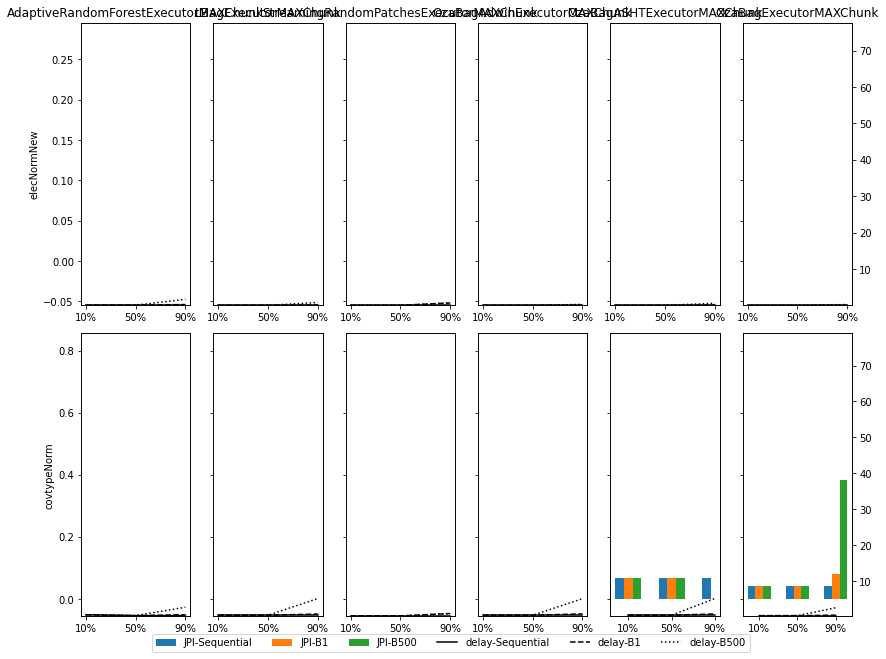

In [141]:
def gen_graph(bars=False, share_y='row', log_y=False, norm=False):
#     print(f'gen {bars}')
#     datasets = ['airlines', 'GMSC','elecNormNew','covtypeNorm','kyoto_binary']
    datasets = ['elecNormNew', 'covtypeNorm']
    print(share_y)
    fig, axis = plt.subplots(len(datasets), 6, figsize=(12,9), tight_layout=True, sharey=share_y)
    global title
    global labels
    global last
    global twin
    leg = False
    labls = True
    title = True
    last = False
    twin = axis[0][0]
    for ds in datasets:
        if datasets.index(ds) == (len(datasets) - 1):
            last = True
        dsdf = tdf[tdf.dataset == ds]
#         if ds == 'kyoto_binary':
#             display(dsdf)
        display(tdf)
        aux_graphNx1(ds, axis, datasets.index(ds), dsdf, bar=bars, share_y=share_y, log_y=log_y, norm=norm)
        title = False
    lines_1, labels_1 = axis[0][0].get_legend_handles_labels()
    lines_2, labels_2 = twin.get_legend_handles_labels()
    lines = lines_1 + lines_2
    labels = labels_1 + labels_2
    lgd = fig.legend(lines, labels, loc=8, ncol=6, bbox_to_anchor=(0.5, -0.02))
    lgd.set_in_layout(True)
    fig.subplots_adjust(bottom=0.2)
    filename = 'bars-all-4x1-JPI-delay.eps' if bars else 'all-4x1-JPI-delay.eps'
    plt.savefig(f'Pi-{filename}', pad_inches=0.2, bbox_inches='tight')
#     plt.savefig(f'Pi-bars-all-5x1-JPI-delay.png', pad_inches=0.2)

gen_graph(bars=True)

In [142]:
pd.options.display.max_columns = None

In [143]:
def table_delta_rates_horizontal():
    rates = ['10', '50', '90']
    algs = ['Ada', 'L', 'Patches', 'Adwin', 'ASHT', 'OzaBag']
    datasets = ['airlines', 'GMSC','elecNormNew','covtypeNorm','kyoto_binary']
    # filtra algoritmo
    for alg in algs:
#         line = alg + ' & $\Delta$ '
        line = alg + '  '
        algdf = filter_by_substring_algorithm(tdf, alg).sort_values(['algorithm','batch_size','cores'])
        # filtra dataset
        for ds in datasets:
            dsalgdf = algdf[algdf.dataset == ds]
    #         display(dsalgdf.head())
            # "junta"
            for rt in rates:
                if rt == '10':
                    showdf = rename_columns_by_rate(dsalgdf[dsalgdf.PERC == rt])
                else:
                    to_join = dsalgdf[dsalgdf.PERC == rt]
                    showdf = showdf.merge(rename_columns_by_rate(to_join),on=['algorithm', 'dataset', 'batch_size', 'cores']).sort_values(['batch_size','cores'])
    #         showdf = showdf[['algorithm','dataset','cores','batch_size','JPI_10','JPI_50','JPI_90']]
    #         display(showdf)
            for i in ['10', '50', '90']:
                minoutro = min(showdf[showdf.batch_size == 1][f'JPI_{i}'])
    #             print(f"JPI_{i} minoutro {minoutro}")
                val = ((showdf[showdf.batch_size != 1][f'JPI_{i}'].iloc[0] - minoutro)/minoutro) * 100
                sval = f"{val:.2f} " if val < 0 else "\\textbf{ " + f"{val:.2f}" + "} "
                line += f"& {sval}"
        print(f"{line} \\\\")

In [144]:
def table_delta_rates_vert():
    all_values = []
    rates = ['10', '50', '90']
    algs = ['Ada', 'L', 'Patches', 'Adwin', 'ASHT', 'OzaBag']
    datasets = ['airlines', 'GMSC','elecNormNew','covtypeNorm','kyoto_binary']
    # filtra algoritmo
    for alg in algs:
        line = '\hline\n\\multirow{3}{*}{' + alg + '} '
        algdf = filter_by_substring_algorithm(tdf, alg).sort_values(['algorithm','batch_size','cores'])
        # filtra rate
        for rt in rates:
            if rt != '10':
                line += '\\\\\n'
            line += f' & {rt} '
            rtalgdf = rename_columns_by_rate(algdf[algdf.PERC == rt])
            # filtra dataset
            for ds in datasets:
#                 print(ds)
                dsrtalgdf = rtalgdf[rtalgdf.dataset == ds]
#                 display(dsrtalgdf)
                minoutro = min(dsrtalgdf[dsrtalgdf.batch_size == 1][f'JPI_{rt}'])
#                 print(f"JPI_{rt} minoutro {minoutro}")
                val = 100 * ((dsrtalgdf[dsrtalgdf.batch_size != 1][f'JPI_{rt}'].iloc[0] - minoutro)/minoutro)
                all_values.append(val)
                sval = f"{val:.2f} " if val < 0 else "\\textbf{ " + f"{val:.2f}" + "} "
                line += f"& {sval} "
        print(f"{line} \\\\")
    print(f'\n\nAverage reduction: {sum(all_values)/len(all_values)}')
    
    

In [145]:
table_delta_rates_horizontal()

Empty DataFrame
Columns: [algorithm, dataset, inc_rate, cores, batch_size, instances, time, delay, out_rate, duration, avg_measure, sum_measure, prod_rate, tt_inst_prod, joules, JPI, PERC]
Index: []

IndexError: single positional indexer is out-of-bounds

In [ ]:
table_delta_rates_vert()

Sharey = row

Linear scale

In [ ]:
# %cd ../..

In [ ]:
gen_graph(bars=True)

sharey = False

linear scale

False


algorithm      dataset  inc_rate  cores  \
168  StreamingRandomPatchesExecutorMAXChunk  elecNormNew        42      4   
169  StreamingRandomPatchesExecutorMAXChunk  elecNormNew        42      4   
170  StreamingRandomPatchesExecutorMAXChunk  elecNormNew        42      4   
171  StreamingRandomPatchesExecutorMAXChunk  elecNormNew        42      4   
172  StreamingRandomPatchesExecutorMAXChunk  elecNormNew        42      4   
..                                      ...          ...       ...    ...   
400    AdaptiveRandomForestExecutorMAXChunk         GMSC        32      4   
401    AdaptiveRandomForestExecutorMAXChunk         GMSC        32      4   
402    AdaptiveRandomForestExecutorMAXChunk         GMSC        32      4   
403    AdaptiveRandomForestExecutorMAXChunk         GMSC        32      4   
404    AdaptiveRandomForestExecutorMAXChunk         GMSC        32      4   

     batch_size  instances   time     delay  out_rate  duration  avg_measure  \
168        2000   4,800.00 119.99 29,369.00     40.00       127         3.92   
169        2000   4,800.00 119.99 29,369.00     40.00       127         3.92   
170        2000   4,800.00 119.99 29,369.00     40.00       127         3.92   
171         500   4,800.00 119.99  7,534.00     40.00       125          NaN   
172         500   4,800.00 119.99  7,534.00     40.00       125          NaN   
..          ...        ...    ...       ...       ...       ...          ...   
400        2000   3,600.00 119.97 35,757.00     30.01       125         4.08   
401        2000   3,600.00 119.97 35,757.00     30.01       125         4.08   
402          50   3,600.00 120.00    867.00     30.00       125          NaN   
403          50   3,600.00 120.00    867.00     30.00       125          NaN   
404          50   3,600.00 120.00    867.00     30.00       125          NaN   

     sum_measure  prod_rate  tt_inst_prod  joules  JPI PERC  
168       901.70      39.94      4,800.00  470.40 0.10   90  
169       901.70      39.94      4,800.00  470.40 0.10   50  
170       901.70      39.94      4,800.00  470.40 0.10   10  
171         0.00      39.94      4,800.00     NaN  NaN   90  
172         0.00      39.94      4,800.00     NaN  NaN   50  
..           ...        ...           ...     ...  ...  ...  
400       913.10      29.96      3,600.00  489.03 0.14   50  
401       913.10      29.96      3,600.00  489.03 0.14   10  
402         0.00      29.96      3,600.00     NaN  NaN   90  
403         0.00      29.96      3,600.00     NaN  NaN   50  
404         0.00      29.96      3,600.00     NaN  NaN   10  

[522 rows x 17 columns]

algorithm      dataset  inc_rate  cores  \
168  StreamingRandomPatchesExecutorMAXChunk  elecNormNew        42      4   
169  StreamingRandomPatchesExecutorMAXChunk  elecNormNew        42      4   
170  StreamingRandomPatchesExecutorMAXChunk  elecNormNew        42      4   
171  StreamingRandomPatchesExecutorMAXChunk  elecNormNew        42      4   
172  StreamingRandomPatchesExecutorMAXChunk  elecNormNew        42      4   
173  StreamingRandomPatchesExecutorMAXChunk  elecNormNew        42      4   
174  StreamingRandomPatchesExecutorMAXChunk  elecNormNew        42      4   
175  StreamingRandomPatchesExecutorMAXChunk  elecNormNew        42      4   
176  StreamingRandomPatchesExecutorMAXChunk  elecNormNew        42      4   
489  StreamingRandomPatchesExecutorMAXChunk  elecNormNew        23      4   
490  StreamingRandomPatchesExecutorMAXChunk  elecNormNew        23      4   
491  StreamingRandomPatchesExecutorMAXChunk  elecNormNew        23      4   
492  StreamingRandomPatchesExecutorMAXChunk  elecNormNew        23      4   
493  StreamingRandomPatchesExecutorMAXChunk  elecNormNew        23      4   
494  StreamingRandomPatchesExecutorMAXChunk  elecNormNew        23      4   
300  StreamingRandomPatchesExecutorMAXChunk  elecNormNew         4      4   
301  StreamingRandomPatchesExecutorMAXChunk  elecNormNew         4      4   
302  StreamingRandomPatchesExecutorMAXChunk  elecNormNew         4      4   
303  StreamingRandomPatchesExecutorMAXChunk  elecNormNew         4      4   
304  StreamingRandomPatchesExecutorMAXChunk  elecNormNew         4      4   
305  StreamingRandomPatchesExecutorMAXChunk  elecNormNew         4      4   
306  StreamingRandomPatchesExecutorMAXChunk  elecNormNew         4      4   
307  StreamingRandomPatchesExecutorMAXChunk  elecNormNew         4      4   
308  StreamingRandomPatchesExecutorMAXChunk  elecNormNew         4      4   
105                  OzaBagExecutorMAXChunk  elecNormNew       862      4   
106                  OzaBagExecutorMAXChunk  elecNormNew       862      4   
107                  OzaBagExecutorMAXChunk  elecNormNew       862      4   
108                  OzaBagExecutorMAXChunk  elecNormNew       862      4   
109                  OzaBagExecutorMAXChunk  elecNormNew       862      4   
110                  OzaBagExecutorMAXChunk  elecNormNew       862      4   
111                  OzaBagExecutorMAXChunk  elecNormNew       862      4   
112                  OzaBagExecutorMAXChunk  elecNormNew       862      4   
113                  OzaBagExecutorMAXChunk  elecNormNew       862      4   
513                  OzaBagExecutorMAXChunk  elecNormNew       479      4   
514                  OzaBagExecutorMAXChunk  elecNormNew       479      4   
515                  OzaBagExecutorMAXChunk  elecNormNew       479      4   
516                  OzaBagExecutorMAXChunk  elecNormNew       479      4   
517                  OzaBagExecutorMAXChunk  elecNormNew       479      4   
518                  OzaBagExecutorMAXChunk  elecNormNew       479      4   
519                  OzaBagExecutorMAXChunk  elecNormNew       479      4   
520                  OzaBagExecutorMAXChunk  elecNormNew       479      4   
521                  OzaBagExecutorMAXChunk  elecNormNew       479      4   
309                  OzaBagExecutorMAXChunk  elecNormNew        95      4   
310                  OzaBagExecutorMAXChunk  elecNormNew        95      4   
311                  OzaBagExecutorMAXChunk  elecNormNew        95      4   
312                  OzaBagExecutorMAXChunk  elecNormNew        95      4   
313                  OzaBagExecutorMAXChunk  elecNormNew        95      4   
314                  OzaBagExecutorMAXChunk  elecNormNew        95      4   
315                  OzaBagExecutorMAXChunk  elecNormNew        95      4   
316                  OzaBagExecutorMAXChunk  elecNormNew        95      4   
317                  OzaBagExecutorMAXChunk  elecNormNew        95      4   
387             OzaBagAdwinExe

algorithm      dataset  inc_rate  cores  \
132  AdaptiveRandomForestExecutorMAXChunk  elecNormNew       154      4   
133  AdaptiveRandomForestExecutorMAXChunk  elecNormNew       154      4   
134  AdaptiveRandomForestExecutorMAXChunk  elecNormNew       154      4   
72   AdaptiveRandomForestExecutorMAXChunk  elecNormNew        85      4   
73   AdaptiveRandomForestExecutorMAXChunk  elecNormNew        85      4   
74   AdaptiveRandomForestExecutorMAXChunk  elecNormNew        85      4   
423  AdaptiveRandomForestExecutorMAXChunk  elecNormNew        17      4   
424  AdaptiveRandomForestExecutorMAXChunk  elecNormNew        17      4   
425  AdaptiveRandomForestExecutorMAXChunk  elecNormNew        17      4   
126  AdaptiveRandomForestExecutorMAXChunk  elecNormNew       154      4   
127  AdaptiveRandomForestExecutorMAXChunk  elecNormNew       154      4   
128  AdaptiveRandomForestExecutorMAXChunk  elecNormNew       154      4   
75   AdaptiveRandomForestExecutorMAXChunk  elecNormNew        85      4   
76   AdaptiveRandomForestExecutorMAXChunk  elecNormNew        85      4   
77   AdaptiveRandomForestExecutorMAXChunk  elecNormNew        85      4   
417  AdaptiveRandomForestExecutorMAXChunk  elecNormNew        17      4   
418  AdaptiveRandomForestExecutorMAXChunk  elecNormNew        17      4   
419  AdaptiveRandomForestExecutorMAXChunk  elecNormNew        17      4   
129  AdaptiveRandomForestExecutorMAXChunk  elecNormNew       154      4   
130  AdaptiveRandomForestExecutorMAXChunk  elecNormNew       154      4   
131  AdaptiveRandomForestExecutorMAXChunk  elecNormNew       154      4   
69   AdaptiveRandomForestExecutorMAXChunk  elecNormNew        85      4   
70   AdaptiveRandomForestExecutorMAXChunk  elecNormNew        85      4   
71   AdaptiveRandomForestExecutorMAXChunk  elecNormNew        85      4   
420  AdaptiveRandomForestExecutorMAXChunk  elecNormNew        17      4   
421  AdaptiveRandomForestExecutorMAXChunk  elecNormNew        17      4   
422  AdaptiveRandomForestExecutorMAXChunk  elecNormNew        17      4   

     batch_size  instances   time     delay  out_rate  duration  avg_measure  \
132          50  17,970.00 119.87    192.00    149.92       124          NaN   
133          50  17,970.00 119.87    192.00    149.92       124          NaN   
134          50  17,970.00 119.87    192.00    149.92       124          NaN   
72           50  10,183.00 119.81    359.00     84.99       124          NaN   
73           50  10,183.00 119.81    359.00     84.99       124          NaN   
74           50  10,183.00 119.81    359.00     84.99       124          NaN   
423          50   1,800.00 120.01  1,797.00     15.00       123          NaN   
424          50   1,800.00 120.01  1,797.00     15.00       123          NaN   
425          50   1,800.00 120.01  1,797.00     15.00       123          NaN   
126         500  17,970.00 119.83  2,257.00    149.96       125          NaN   
127         500  17,970.00 119.83  2,257.00    149.96       125          NaN   
128         500  17,970.00 119.83  2,257.00    149.96       125          NaN   
75          500  10,184.00 120.01  3,718.00     84.86       125          NaN   
76          500  10,184.00 120.01  3,718.00     84.86       125          NaN   
77          500  10,184.00 120.01  3,718.00     84.86       125          NaN   
417         500   1,800.00 119.96 17,850.00     15.01       125          NaN   
418         500   1,800.00 119.96 17,850.00     15.01       125          NaN   
419         500   1,800.00 119.96 17,850.00     15.01       125          NaN   
129        2000  17,970.00 119.82  9,712.00    149.97       126         4.01   
130        2000  17,970.00 119.82  9,712.00    149.97       126         4.01   
131        2000  17,970.00 119.82  9,712.00    149.97       126         4.01   
69         2000  10,184.00 120.01 15,326.00     84.86       123         4.06   
70         2000  10,184.00 120.01 15,326.00     84.86       123         4.06   
71         

algorithm      dataset  inc_rate  cores  \
134  AdaptiveRandomForestExecutorMAXChunk  elecNormNew       154      4   
74   AdaptiveRandomForestExecutorMAXChunk  elecNormNew        85      4   
425  AdaptiveRandomForestExecutorMAXChunk  elecNormNew        17      4   
128  AdaptiveRandomForestExecutorMAXChunk  elecNormNew       154      4   
77   AdaptiveRandomForestExecutorMAXChunk  elecNormNew        85      4   
419  AdaptiveRandomForestExecutorMAXChunk  elecNormNew        17      4   
131  AdaptiveRandomForestExecutorMAXChunk  elecNormNew       154      4   
71   AdaptiveRandomForestExecutorMAXChunk  elecNormNew        85      4   
422  AdaptiveRandomForestExecutorMAXChunk  elecNormNew        17      4   

     batch_size  instances   time     delay  out_rate  duration  avg_measure  \
134          50  17,970.00 119.87    192.00    149.92       124          NaN   
74           50  10,183.00 119.81    359.00     84.99       124          NaN   
425          50   1,800.00 120.01  1,797.00     15.00       123          NaN   
128         500  17,970.00 119.83  2,257.00    149.96       125          NaN   
77          500  10,184.00 120.01  3,718.00     84.86       125          NaN   
419         500   1,800.00 119.96 17,850.00     15.01       125          NaN   
131        2000  17,970.00 119.82  9,712.00    149.97       126         4.01   
71         2000  10,184.00 120.01 15,326.00     84.86       123         4.06   
422        2000   1,800.00 119.96 73,957.00     15.01       138         4.22   

     sum_measure  prod_rate  tt_inst_prod  joules  JPI PERC  
134         0.00     149.73     17,970.00     NaN  NaN   10  
74          0.00      84.86     10,200.00     NaN  NaN   10  
425         0.00      14.98      1,800.00     NaN  NaN   10  
128         0.00     149.73     17,970.00     NaN  NaN   10  
77          0.00      84.86     10,200.00     NaN  NaN   10  
419         0.00      14.98      1,800.00     NaN  NaN   10  
131       914.40     149.73     17,970.00  480.55 0.03   10  
71        909.50      84.86     10,200.00  487.26 0.05   10  
422     1,055.80      14.98      1,800.00  506.60 0.28   10

algorithm      dataset  inc_rate  cores  \
133  AdaptiveRandomForestExecutorMAXChunk  elecNormNew       154      4   
73   AdaptiveRandomForestExecutorMAXChunk  elecNormNew        85      4   
424  AdaptiveRandomForestExecutorMAXChunk  elecNormNew        17      4   
127  AdaptiveRandomForestExecutorMAXChunk  elecNormNew       154      4   
76   AdaptiveRandomForestExecutorMAXChunk  elecNormNew        85      4   
418  AdaptiveRandomForestExecutorMAXChunk  elecNormNew        17      4   
130  AdaptiveRandomForestExecutorMAXChunk  elecNormNew       154      4   
70   AdaptiveRandomForestExecutorMAXChunk  elecNormNew        85      4   
421  AdaptiveRandomForestExecutorMAXChunk  elecNormNew        17      4   

     batch_size  instances   time     delay  out_rate  duration  avg_measure  \
133          50  17,970.00 119.87    192.00    149.92       124          NaN   
73           50  10,183.00 119.81    359.00     84.99       124          NaN   
424          50   1,800.00 120.01  1,797.00     15.00       123          NaN   
127         500  17,970.00 119.83  2,257.00    149.96       125          NaN   
76          500  10,184.00 120.01  3,718.00     84.86       125          NaN   
418         500   1,800.00 119.96 17,850.00     15.01       125          NaN   
130        2000  17,970.00 119.82  9,712.00    149.97       126         4.01   
70         2000  10,184.00 120.01 15,326.00     84.86       123         4.06   
421        2000   1,800.00 119.96 73,957.00     15.01       138         4.22   

     sum_measure  prod_rate  tt_inst_prod  joules  JPI PERC  
133         0.00     149.73     17,970.00     NaN  NaN   50  
73          0.00      84.86     10,200.00     NaN  NaN   50  
424         0.00      14.98      1,800.00     NaN  NaN   50  
127         0.00     149.73     17,970.00     NaN  NaN   50  
76          0.00      84.86     10,200.00     NaN  NaN   50  
418         0.00      14.98      1,800.00     NaN  NaN   50  
130       914.40     149.73     17,970.00  480.55 0.03   50  
70        909.50      84.86     10,200.00  487.26 0.05   50  
421     1,055.80      14.98      1,800.00  506.60 0.28   50

algorithm      dataset  inc_rate  cores  \
132  AdaptiveRandomForestExecutorMAXChunk  elecNormNew       154      4   
72   AdaptiveRandomForestExecutorMAXChunk  elecNormNew        85      4   
423  AdaptiveRandomForestExecutorMAXChunk  elecNormNew        17      4   
126  AdaptiveRandomForestExecutorMAXChunk  elecNormNew       154      4   
75   AdaptiveRandomForestExecutorMAXChunk  elecNormNew        85      4   
417  AdaptiveRandomForestExecutorMAXChunk  elecNormNew        17      4   
129  AdaptiveRandomForestExecutorMAXChunk  elecNormNew       154      4   
69   AdaptiveRandomForestExecutorMAXChunk  elecNormNew        85      4   
420  AdaptiveRandomForestExecutorMAXChunk  elecNormNew        17      4   

     batch_size  instances   time     delay  out_rate  duration  avg_measure  \
132          50  17,970.00 119.87    192.00    149.92       124          NaN   
72           50  10,183.00 119.81    359.00     84.99       124          NaN   
423          50   1,800.00 120.01  1,797.00     15.00       123          NaN   
126         500  17,970.00 119.83  2,257.00    149.96       125          NaN   
75          500  10,184.00 120.01  3,718.00     84.86       125          NaN   
417         500   1,800.00 119.96 17,850.00     15.01       125          NaN   
129        2000  17,970.00 119.82  9,712.00    149.97       126         4.01   
69         2000  10,184.00 120.01 15,326.00     84.86       123         4.06   
420        2000   1,800.00 119.96 73,957.00     15.01       138         4.22   

     sum_measure  prod_rate  tt_inst_prod  joules  JPI PERC  
132         0.00     149.73     17,970.00     NaN  NaN   90  
72          0.00      84.86     10,183.00     NaN  NaN   90  
423         0.00      14.98      1,800.00     NaN  NaN   90  
126         0.00     149.73     17,970.00     NaN  NaN   90  
75          0.00      84.86     10,183.00     NaN  NaN   90  
417         0.00      14.98      1,800.00     NaN  NaN   90  
129       914.40     149.73     17,970.00  480.55 0.03   90  
69        909.50      84.86     10,183.00  487.26 0.05   90  
420     1,055.80      14.98      1,800.00  506.60 0.28   90

algorithm      dataset  inc_rate  cores  batch_size  \
327  LBagExecutorMAXChunk  elecNormNew       294      4          50   
328  LBagExecutorMAXChunk  elecNormNew       294      4          50   
329  LBagExecutorMAXChunk  elecNormNew       294      4          50   
342  LBagExecutorMAXChunk  elecNormNew       163      4          50   
343  LBagExecutorMAXChunk  elecNormNew       163      4          50   
344  LBagExecutorMAXChunk  elecNormNew       163      4          50   
51   LBagExecutorMAXChunk  elecNormNew        32      4          50   
52   LBagExecutorMAXChunk  elecNormNew        32      4          50   
53   LBagExecutorMAXChunk  elecNormNew        32      4          50   
333  LBagExecutorMAXChunk  elecNormNew       294      4         500   
334  LBagExecutorMAXChunk  elecNormNew       294      4         500   
335  LBagExecutorMAXChunk  elecNormNew       294      4         500   
339  LBagExecutorMAXChunk  elecNormNew       163      4         500   
340  LBagExecutorMAXChunk  elecNormNew       163      4         500   
341  LBagExecutorMAXChunk  elecNormNew       163      4         500   
48   LBagExecutorMAXChunk  elecNormNew        32      4         500   
49   LBagExecutorMAXChunk  elecNormNew        32      4         500   
50   LBagExecutorMAXChunk  elecNormNew        32      4         500   
330  LBagExecutorMAXChunk  elecNormNew       294      4        2000   
331  LBagExecutorMAXChunk  elecNormNew       294      4        2000   
332  LBagExecutorMAXChunk  elecNormNew       294      4        2000   
336  LBagExecutorMAXChunk  elecNormNew       163      4        2000   
337  LBagExecutorMAXChunk  elecNormNew       163      4        2000   
338  LBagExecutorMAXChunk  elecNormNew       163      4        2000   
54   LBagExecutorMAXChunk  elecNormNew        32      4        2000   
55   LBagExecutorMAXChunk  elecNormNew        32      4        2000   
56   LBagExecutorMAXChunk  elecNormNew        32      4        2000   

     instances   time     delay  out_rate  duration  avg_measure  sum_measure  \
327  34,742.00 119.91    107.00    289.73       126          NaN         0.00   
328  34,742.00 119.91    107.00    289.73       126          NaN         0.00   
329  34,742.00 119.91    107.00    289.73       126          NaN         0.00   
342  19,168.00 119.87    183.00    159.90       125          NaN         0.00   
343  19,168.00 119.87    183.00    159.90       125          NaN         0.00   
344  19,168.00 119.87    183.00    159.90       125          NaN         0.00   
51    3,600.00 120.00    880.00     30.00       125          NaN         0.00   
52    3,600.00 120.00    880.00     30.00       125          NaN         0.00   
53    3,600.00 120.00    880.00     30.00       125          NaN         0.00   
333  34,742.00 119.88  1,169.00    289.81       126          NaN         0.00   
334  34,742.00 119.88  1,169.00    289.81       126          NaN         0.00   
335  34,742.00 119.88  1,169.00    289.81       126          NaN         0.00   
339  19,168.00 119.83  1,891.00    159.96       126          NaN         0.00   
340  19,168.00 119.83  1,891.00    159.96       126          NaN         0.00   
341  19,168.00 119.83  1,891.00    159.96       126          NaN         0.00   
48    3,600.00 119.97  9,184.00     30.01       125          NaN         0.00   
49    3,600.00 119.97  9,184.00     30.01       125          NaN         0.00   
50    3,600.00 119.97  9,184.00     30.01       125          NaN         0.00   
330  34,739.00 119.87  4,641.00    289.80       126         4.17       954.30   
331  34,739.00 119.87  4,641.00    289.80       126         4.17       954.30   
332  34,739.00 119.87  4,641.00    289.80       126         4.17       954.30   
336  19,168.00 119.83  7,678.00    159.96       126         4.13       945.00   
337  19,168.00 119.83  7,678.00    159.96       126         4.13       945.00   
338  19,168.00 119.83  7,678.00    159.96       126         4.13       945.00   
54

algorithm      dataset  inc_rate  cores  batch_size  \
329  LBagExecutorMAXChunk  elecNormNew       294      4          50   
344  LBagExecutorMAXChunk  elecNormNew       163      4          50   
53   LBagExecutorMAXChunk  elecNormNew        32      4          50   
335  LBagExecutorMAXChunk  elecNormNew       294      4         500   
341  LBagExecutorMAXChunk  elecNormNew       163      4         500   
50   LBagExecutorMAXChunk  elecNormNew        32      4         500   
332  LBagExecutorMAXChunk  elecNormNew       294      4        2000   
338  LBagExecutorMAXChunk  elecNormNew       163      4        2000   
56   LBagExecutorMAXChunk  elecNormNew        32      4        2000   

     instances   time     delay  out_rate  duration  avg_measure  sum_measure  \
329  34,742.00 119.91    107.00    289.73       126          NaN         0.00   
344  19,168.00 119.87    183.00    159.90       125          NaN         0.00   
53    3,600.00 120.00    880.00     30.00       125          NaN         0.00   
335  34,742.00 119.88  1,169.00    289.81       126          NaN         0.00   
341  19,168.00 119.83  1,891.00    159.96       126          NaN         0.00   
50    3,600.00 119.97  9,184.00     30.01       125          NaN         0.00   
332  34,739.00 119.87  4,641.00    289.80       126         4.17       954.30   
338  19,168.00 119.83  7,678.00    159.96       126         4.13       945.00   
56    3,600.00 119.97 35,733.00     30.01       127         4.13       917.50   

     prod_rate  tt_inst_prod  joules  JPI PERC  
329     289.36     34,742.00     NaN  NaN   10  
344     159.71     19,168.00     NaN  NaN   10  
53       29.96      3,600.00     NaN  NaN   10  
335     289.36     34,742.00     NaN  NaN   10  
341     159.71     19,168.00     NaN  NaN   10  
50       29.96      3,600.00     NaN  NaN   10  
332     289.36     34,742.00  499.54 0.01   10  
338     159.71     19,168.00  494.50 0.03   10  
56       29.96      3,600.00  495.83 0.14   10

algorithm      dataset  inc_rate  cores  batch_size  \
328  LBagExecutorMAXChunk  elecNormNew       294      4          50   
343  LBagExecutorMAXChunk  elecNormNew       163      4          50   
52   LBagExecutorMAXChunk  elecNormNew        32      4          50   
334  LBagExecutorMAXChunk  elecNormNew       294      4         500   
340  LBagExecutorMAXChunk  elecNormNew       163      4         500   
49   LBagExecutorMAXChunk  elecNormNew        32      4         500   
331  LBagExecutorMAXChunk  elecNormNew       294      4        2000   
337  LBagExecutorMAXChunk  elecNormNew       163      4        2000   
55   LBagExecutorMAXChunk  elecNormNew        32      4        2000   

     instances   time     delay  out_rate  duration  avg_measure  sum_measure  \
328  34,742.00 119.91    107.00    289.73       126          NaN         0.00   
343  19,168.00 119.87    183.00    159.90       125          NaN         0.00   
52    3,600.00 120.00    880.00     30.00       125          NaN         0.00   
334  34,742.00 119.88  1,169.00    289.81       126          NaN         0.00   
340  19,168.00 119.83  1,891.00    159.96       126          NaN         0.00   
49    3,600.00 119.97  9,184.00     30.01       125          NaN         0.00   
331  34,739.00 119.87  4,641.00    289.80       126         4.17       954.30   
337  19,168.00 119.83  7,678.00    159.96       126         4.13       945.00   
55    3,600.00 119.97 35,733.00     30.01       127         4.13       917.50   

     prod_rate  tt_inst_prod  joules  JPI PERC  
328     289.36     34,742.00     NaN  NaN   50  
343     159.71     19,168.00     NaN  NaN   50  
52       29.96      3,600.00     NaN  NaN   50  
334     289.36     34,742.00     NaN  NaN   50  
340     159.71     19,168.00     NaN  NaN   50  
49       29.96      3,600.00     NaN  NaN   50  
331     289.36     34,742.00  499.54 0.01   50  
337     159.71     19,168.00  494.50 0.03   50  
55       29.96      3,600.00  495.83 0.14   50

algorithm      dataset  inc_rate  cores  batch_size  \
327  LBagExecutorMAXChunk  elecNormNew       294      4          50   
342  LBagExecutorMAXChunk  elecNormNew       163      4          50   
51   LBagExecutorMAXChunk  elecNormNew        32      4          50   
333  LBagExecutorMAXChunk  elecNormNew       294      4         500   
339  LBagExecutorMAXChunk  elecNormNew       163      4         500   
48   LBagExecutorMAXChunk  elecNormNew        32      4         500   
330  LBagExecutorMAXChunk  elecNormNew       294      4        2000   
336  LBagExecutorMAXChunk  elecNormNew       163      4        2000   
54   LBagExecutorMAXChunk  elecNormNew        32      4        2000   

     instances   time     delay  out_rate  duration  avg_measure  sum_measure  \
327  34,742.00 119.91    107.00    289.73       126          NaN         0.00   
342  19,168.00 119.87    183.00    159.90       125          NaN         0.00   
51    3,600.00 120.00    880.00     30.00       125          NaN         0.00   
333  34,742.00 119.88  1,169.00    289.81       126          NaN         0.00   
339  19,168.00 119.83  1,891.00    159.96       126          NaN         0.00   
48    3,600.00 119.97  9,184.00     30.01       125          NaN         0.00   
330  34,739.00 119.87  4,641.00    289.80       126         4.17       954.30   
336  19,168.00 119.83  7,678.00    159.96       126         4.13       945.00   
54    3,600.00 119.97 35,733.00     30.01       127         4.13       917.50   

     prod_rate  tt_inst_prod  joules  JPI PERC  
327     289.35     34,742.00     NaN  NaN   90  
342     159.71     19,168.00     NaN  NaN   90  
51       29.96      3,600.00     NaN  NaN   90  
333     289.35     34,742.00     NaN  NaN   90  
339     159.71     19,168.00     NaN  NaN   90  
48       29.96      3,600.00     NaN  NaN   90  
330     289.35     34,742.00  499.54 0.01   90  
336     159.71     19,168.00  494.50 0.03   90  
54       29.96      3,600.00  495.83 0.14   90

algorithm      dataset  inc_rate  cores  \
174  StreamingRandomPatchesExecutorMAXChunk  elecNormNew        42      4   
175  StreamingRandomPatchesExecutorMAXChunk  elecNormNew        42      4   
176  StreamingRandomPatchesExecutorMAXChunk  elecNormNew        42      4   
489  StreamingRandomPatchesExecutorMAXChunk  elecNormNew        23      4   
490  StreamingRandomPatchesExecutorMAXChunk  elecNormNew        23      4   
300  StreamingRandomPatchesExecutorMAXChunk  elecNormNew         4      4   
301  StreamingRandomPatchesExecutorMAXChunk  elecNormNew         4      4   
302  StreamingRandomPatchesExecutorMAXChunk  elecNormNew         4      4   
171  StreamingRandomPatchesExecutorMAXChunk  elecNormNew        42      4   
172  StreamingRandomPatchesExecutorMAXChunk  elecNormNew        42      4   
173  StreamingRandomPatchesExecutorMAXChunk  elecNormNew        42      4   
491  StreamingRandomPatchesExecutorMAXChunk  elecNormNew        23      4   
492  StreamingRandomPatchesExecutorMAXChunk  elecNormNew        23      4   
306  StreamingRandomPatchesExecutorMAXChunk  elecNormNew         4      4   
307  StreamingRandomPatchesExecutorMAXChunk  elecNormNew         4      4   
308  StreamingRandomPatchesExecutorMAXChunk  elecNormNew         4      4   
168  StreamingRandomPatchesExecutorMAXChunk  elecNormNew        42      4   
169  StreamingRandomPatchesExecutorMAXChunk  elecNormNew        42      4   
170  StreamingRandomPatchesExecutorMAXChunk  elecNormNew        42      4   
493  StreamingRandomPatchesExecutorMAXChunk  elecNormNew        23      4   
494  StreamingRandomPatchesExecutorMAXChunk  elecNormNew        23      4   
303  StreamingRandomPatchesExecutorMAXChunk  elecNormNew         4      4   
304  StreamingRandomPatchesExecutorMAXChunk  elecNormNew         4      4   
305  StreamingRandomPatchesExecutorMAXChunk  elecNormNew         4      4   

     batch_size  instances   time     delay  out_rate  duration  avg_measure  \
174          50   4,800.00 120.07    720.00     39.98       124          NaN   
175          50   4,800.00 120.07    720.00     39.98       124          NaN   
176          50   4,800.00 120.07    720.00     39.98       124          NaN   
489          50   2,400.00 120.15  1,363.00     19.98       125          NaN   
490          50   2,400.00 120.15  1,363.00     19.98       125          NaN   
300          50   2,400.00 120.05  1,359.00     19.99       123          NaN   
301          50   2,400.00 120.05  1,359.00     19.99       123          NaN   
302          50   2,400.00 120.05  1,359.00     19.99       123          NaN   
171         500   4,800.00 119.99  7,534.00     40.00       125          NaN   
172         500   4,800.00 119.99  7,534.00     40.00       125          NaN   
173         500   4,800.00 119.99  7,534.00     40.00       125          NaN   
491         500   2,400.00 119.96 14,311.00     20.01       125          NaN   
492         500   2,400.00 119.96 14,311.00     20.01       125          NaN   
306         500   2,400.00 119.96 14,507.00     20.01       124          NaN   
307         500   2,400.00 119.96 14,507.00     20.01       124          NaN   
308         500   2,400.00 119.96 14,507.00     20.01       124          NaN   
168        2000   4,800.00 119.99 29,369.00     40.00       127         3.92   
169        2000   4,800.00 119.99 29,369.00     40.00       127         3.92   
170        2000   4,800.00 119.99 29,369.00     40.00       127         3.92   
493        2000   2,400.00 119.96 53,993.00     20.01       124         4.01   
494        2000   2,400.00 119.96 53,993.00     20.01       124         4.01   
303        2000   2,400.00 119.96 54,293.00     20.01       126         4.31   
304        2000   2,400.00 119.96 54,293.00     20.01       126         4.31   
305        2000   2,400.00 119.96 54,293.00     20.01       126         4.31   

     sum_measure  prod_rate  tt_inst_prod  joules  JPI PERC  
174         0.00      39.94      4,800.00    

algorithm      dataset  inc_rate  cores  \
176  StreamingRandomPatchesExecutorMAXChunk  elecNormNew        42      4   
302  StreamingRandomPatchesExecutorMAXChunk  elecNormNew         4      4   
173  StreamingRandomPatchesExecutorMAXChunk  elecNormNew        42      4   
491  StreamingRandomPatchesExecutorMAXChunk  elecNormNew        23      4   
308  StreamingRandomPatchesExecutorMAXChunk  elecNormNew         4      4   
170  StreamingRandomPatchesExecutorMAXChunk  elecNormNew        42      4   
494  StreamingRandomPatchesExecutorMAXChunk  elecNormNew        23      4   
305  StreamingRandomPatchesExecutorMAXChunk  elecNormNew         4      4   

     batch_size  instances   time     delay  out_rate  duration  avg_measure  \
176          50   4,800.00 120.07    720.00     39.98       124          NaN   
302          50   2,400.00 120.05  1,359.00     19.99       123          NaN   
173         500   4,800.00 119.99  7,534.00     40.00       125          NaN   
491         500   2,400.00 119.96 14,311.00     20.01       125          NaN   
308         500   2,400.00 119.96 14,507.00     20.01       124          NaN   
170        2000   4,800.00 119.99 29,369.00     40.00       127         3.92   
494        2000   2,400.00 119.96 53,993.00     20.01       124         4.01   
305        2000   2,400.00 119.96 54,293.00     20.01       126         4.31   

     sum_measure  prod_rate  tt_inst_prod  joules  JPI PERC  
176         0.00      39.94      4,800.00     NaN  NaN   10  
302         0.00      19.97      2,400.00     NaN  NaN   10  
173         0.00      39.94      4,800.00     NaN  NaN   10  
491         0.00      19.97      2,400.00     NaN  NaN   10  
308         0.00      19.97      2,400.00     NaN  NaN   10  
170       901.70      39.94      4,800.00  470.40 0.10   10  
494       906.40      19.98      2,400.00  481.11 0.20   10  
305       982.30      19.97      2,400.00  516.84 0.22   10

algorithm      dataset  inc_rate  cores  \
175  StreamingRandomPatchesExecutorMAXChunk  elecNormNew        42      4   
490  StreamingRandomPatchesExecutorMAXChunk  elecNormNew        23      4   
301  StreamingRandomPatchesExecutorMAXChunk  elecNormNew         4      4   
172  StreamingRandomPatchesExecutorMAXChunk  elecNormNew        42      4   
307  StreamingRandomPatchesExecutorMAXChunk  elecNormNew         4      4   
169  StreamingRandomPatchesExecutorMAXChunk  elecNormNew        42      4   
493  StreamingRandomPatchesExecutorMAXChunk  elecNormNew        23      4   
304  StreamingRandomPatchesExecutorMAXChunk  elecNormNew         4      4   

     batch_size  instances   time     delay  out_rate  duration  avg_measure  \
175          50   4,800.00 120.07    720.00     39.98       124          NaN   
490          50   2,400.00 120.15  1,363.00     19.98       125          NaN   
301          50   2,400.00 120.05  1,359.00     19.99       123          NaN   
172         500   4,800.00 119.99  7,534.00     40.00       125          NaN   
307         500   2,400.00 119.96 14,507.00     20.01       124          NaN   
169        2000   4,800.00 119.99 29,369.00     40.00       127         3.92   
493        2000   2,400.00 119.96 53,993.00     20.01       124         4.01   
304        2000   2,400.00 119.96 54,293.00     20.01       126         4.31   

     sum_measure  prod_rate  tt_inst_prod  joules  JPI PERC  
175         0.00      39.94      4,800.00     NaN  NaN   50  
490         0.00      19.98      2,400.00     NaN  NaN   50  
301         0.00      19.97      2,400.00     NaN  NaN   50  
172         0.00      39.94      4,800.00     NaN  NaN   50  
307         0.00      19.97      2,400.00     NaN  NaN   50  
169       901.70      39.94      4,800.00  470.40 0.10   50  
493       906.40      19.97      2,400.00  481.11 0.20   50  
304       982.30      19.97      2,400.00  516.84 0.22   50

algorithm      dataset  inc_rate  cores  \
174  StreamingRandomPatchesExecutorMAXChunk  elecNormNew        42      4   
489  StreamingRandomPatchesExecutorMAXChunk  elecNormNew        23      4   
300  StreamingRandomPatchesExecutorMAXChunk  elecNormNew         4      4   
171  StreamingRandomPatchesExecutorMAXChunk  elecNormNew        42      4   
492  StreamingRandomPatchesExecutorMAXChunk  elecNormNew        23      4   
306  StreamingRandomPatchesExecutorMAXChunk  elecNormNew         4      4   
168  StreamingRandomPatchesExecutorMAXChunk  elecNormNew        42      4   
303  StreamingRandomPatchesExecutorMAXChunk  elecNormNew         4      4   

     batch_size  instances   time     delay  out_rate  duration  avg_measure  \
174          50   4,800.00 120.07    720.00     39.98       124          NaN   
489          50   2,400.00 120.15  1,363.00     19.98       125          NaN   
300          50   2,400.00 120.05  1,359.00     19.99       123          NaN   
171         500   4,800.00 119.99  7,534.00     40.00       125          NaN   
492         500   2,400.00 119.96 14,311.00     20.01       125          NaN   
306         500   2,400.00 119.96 14,507.00     20.01       124          NaN   
168        2000   4,800.00 119.99 29,369.00     40.00       127         3.92   
303        2000   2,400.00 119.96 54,293.00     20.01       126         4.31   

     sum_measure  prod_rate  tt_inst_prod  joules  JPI PERC  
174         0.00      39.94      4,800.00     NaN  NaN   90  
489         0.00      19.97      2,400.00     NaN  NaN   90  
300         0.00      19.97      2,400.00     NaN  NaN   90  
171         0.00      39.94      4,800.00     NaN  NaN   90  
492         0.00      19.98      2,400.00     NaN  NaN   90  
306         0.00      19.97      2,400.00     NaN  NaN   90  
168       901.70      39.94      4,800.00  470.40 0.10   90  
303       982.30      19.97      2,400.00  516.84 0.22   90

algorithm      dataset  inc_rate  cores  batch_size  \
390  OzaBagAdwinExecutorMAXChunk  elecNormNew       717      4          50   
391  OzaBagAdwinExecutorMAXChunk  elecNormNew       717      4          50   
392  OzaBagAdwinExecutorMAXChunk  elecNormNew       717      4          50   
12   OzaBagAdwinExecutorMAXChunk  elecNormNew       398      4          50   
13   OzaBagAdwinExecutorMAXChunk  elecNormNew       398      4          50   
14   OzaBagAdwinExecutorMAXChunk  elecNormNew       398      4          50   
282  OzaBagAdwinExecutorMAXChunk  elecNormNew        79      4          50   
283  OzaBagAdwinExecutorMAXChunk  elecNormNew        79      4          50   
284  OzaBagAdwinExecutorMAXChunk  elecNormNew        79      4          50   
387  OzaBagAdwinExecutorMAXChunk  elecNormNew       717      4         500   
388  OzaBagAdwinExecutorMAXChunk  elecNormNew       717      4         500   
389  OzaBagAdwinExecutorMAXChunk  elecNormNew       717      4         500   
15   OzaBagAdwinExecutorMAXChunk  elecNormNew       398      4         500   
16   OzaBagAdwinExecutorMAXChunk  elecNormNew       398      4         500   
17   OzaBagAdwinExecutorMAXChunk  elecNormNew       398      4         500   
285  OzaBagAdwinExecutorMAXChunk  elecNormNew        79      4         500   
286  OzaBagAdwinExecutorMAXChunk  elecNormNew        79      4         500   
287  OzaBagAdwinExecutorMAXChunk  elecNormNew        79      4         500   
393  OzaBagAdwinExecutorMAXChunk  elecNormNew       717      4        2000   
394  OzaBagAdwinExecutorMAXChunk  elecNormNew       717      4        2000   
395  OzaBagAdwinExecutorMAXChunk  elecNormNew       717      4        2000   
9    OzaBagAdwinExecutorMAXChunk  elecNormNew       398      4        2000   
10   OzaBagAdwinExecutorMAXChunk  elecNormNew       398      4        2000   
11   OzaBagAdwinExecutorMAXChunk  elecNormNew       398      4        2000   
279  OzaBagAdwinExecutorMAXChunk  elecNormNew        79      4        2000   
280  OzaBagAdwinExecutorMAXChunk  elecNormNew        79      4        2000   
281  OzaBagAdwinExecutorMAXChunk  elecNormNew        79      4        2000   

     instances   time     delay  out_rate  duration  avg_measure  sum_measure  \
390  45,312.00  63.46     46.00    714.00        68          NaN         0.00   
391  45,312.00  63.46     46.00    714.00        68          NaN         0.00   
392  45,312.00  63.46     46.00    714.00        68          NaN         0.00   
12   45,312.00 114.91     76.00    394.32       121          NaN         0.00   
13   45,312.00 114.91     76.00    394.32       121          NaN         0.00   
14   45,312.00 114.91     76.00    394.32       121          NaN         0.00   
282   8,986.00 120.01    329.00     74.88       125          NaN         0.00   
283   8,986.00 120.01    329.00     74.88       125          NaN         0.00   
284   8,986.00 120.01    329.00     74.88       125          NaN         0.00   
387  45,312.00  63.41    498.00    714.59        69          NaN         0.00   
388  45,312.00  63.41    498.00    714.59        69          NaN         0.00   
389  45,312.00  63.41    498.00    714.59        69          NaN         0.00   
15   45,312.00 114.90    774.00    394.36       121          NaN         0.00   
16   45,312.00 114.90    774.00    394.36       121          NaN         0.00   
17   45,312.00 114.90    774.00    394.36       121          NaN         0.00   
285   8,986.00 120.00  3,561.00     74.88       125          NaN         0.00   
286   8,986.00 120.00  3,561.00     74.88       125          NaN         0.00   
287   8,986.00 120.00  3,561.00     74.88       125          NaN         0.00   
393  45,237.00  63.41  1,995.00    713.39        68         3.92       485.70   
394  45,237.00  63.41  1,995.00    713.39        68         3.92       485.70   
395  45,237.00  63.41  1,995.00    713.39        68         3.92       485.70   
9    45,312.00 114.89  3,093.00    394.40       121     

algorithm      dataset  inc_rate  cores  batch_size  \
392  OzaBagAdwinExecutorMAXChunk  elecNormNew       717      4          50   
14   OzaBagAdwinExecutorMAXChunk  elecNormNew       398      4          50   
284  OzaBagAdwinExecutorMAXChunk  elecNormNew        79      4          50   
389  OzaBagAdwinExecutorMAXChunk  elecNormNew       717      4         500   
17   OzaBagAdwinExecutorMAXChunk  elecNormNew       398      4         500   
287  OzaBagAdwinExecutorMAXChunk  elecNormNew        79      4         500   
395  OzaBagAdwinExecutorMAXChunk  elecNormNew       717      4        2000   
11   OzaBagAdwinExecutorMAXChunk  elecNormNew       398      4        2000   
281  OzaBagAdwinExecutorMAXChunk  elecNormNew        79      4        2000   

     instances   time     delay  out_rate  duration  avg_measure  sum_measure  \
392  45,312.00  63.46     46.00    714.00        68          NaN         0.00   
14   45,312.00 114.91     76.00    394.32       121          NaN         0.00   
284   8,986.00 120.01    329.00     74.88       125          NaN         0.00   
389  45,312.00  63.41    498.00    714.59        69          NaN         0.00   
17   45,312.00 114.90    774.00    394.36       121          NaN         0.00   
287   8,986.00 120.00  3,561.00     74.88       125          NaN         0.00   
395  45,237.00  63.41  1,995.00    713.39        68         3.92       485.70   
11   45,312.00 114.89  3,093.00    394.40       121         3.88       835.10   
281   8,986.00 120.01 13,850.00     74.88       126         4.02       916.20   

     prod_rate  tt_inst_prod  joules  JPI PERC  
392     712.45     45,312.00     NaN  NaN   10  
14      393.75     45,312.00     NaN  NaN   10  
284      74.88      9,000.00     NaN  NaN   10  
389     712.45     45,312.00     NaN  NaN   10  
17      393.75     45,312.00     NaN  NaN   10  
287      74.88      9,000.00     NaN  NaN   10  
395     712.45     45,312.00  248.38 0.01   10  
11      393.75     45,312.00  446.24 0.01   10  
281      74.88      9,000.00  482.24 0.05   10

algorithm      dataset  inc_rate  cores  batch_size  \
391  OzaBagAdwinExecutorMAXChunk  elecNormNew       717      4          50   
13   OzaBagAdwinExecutorMAXChunk  elecNormNew       398      4          50   
283  OzaBagAdwinExecutorMAXChunk  elecNormNew        79      4          50   
388  OzaBagAdwinExecutorMAXChunk  elecNormNew       717      4         500   
16   OzaBagAdwinExecutorMAXChunk  elecNormNew       398      4         500   
286  OzaBagAdwinExecutorMAXChunk  elecNormNew        79      4         500   
394  OzaBagAdwinExecutorMAXChunk  elecNormNew       717      4        2000   
10   OzaBagAdwinExecutorMAXChunk  elecNormNew       398      4        2000   
280  OzaBagAdwinExecutorMAXChunk  elecNormNew        79      4        2000   

     instances   time     delay  out_rate  duration  avg_measure  sum_measure  \
391  45,312.00  63.46     46.00    714.00        68          NaN         0.00   
13   45,312.00 114.91     76.00    394.32       121          NaN         0.00   
283   8,986.00 120.01    329.00     74.88       125          NaN         0.00   
388  45,312.00  63.41    498.00    714.59        69          NaN         0.00   
16   45,312.00 114.90    774.00    394.36       121          NaN         0.00   
286   8,986.00 120.00  3,561.00     74.88       125          NaN         0.00   
394  45,237.00  63.41  1,995.00    713.39        68         3.92       485.70   
10   45,312.00 114.89  3,093.00    394.40       121         3.88       835.10   
280   8,986.00 120.01 13,850.00     74.88       126         4.02       916.20   

     prod_rate  tt_inst_prod  joules  JPI PERC  
391     712.49     45,312.00     NaN  NaN   50  
13      393.71     45,312.00     NaN  NaN   50  
283      74.88      9,000.00     NaN  NaN   50  
388     712.49     45,312.00     NaN  NaN   50  
16      393.71     45,312.00     NaN  NaN   50  
286      74.88      9,000.00     NaN  NaN   50  
394     712.49     45,312.00  248.38 0.01   50  
10      393.71     45,312.00  446.24 0.01   50  
280      74.88      9,000.00  482.24 0.05   50

algorithm      dataset  inc_rate  cores  batch_size  \
390  OzaBagAdwinExecutorMAXChunk  elecNormNew       717      4          50   
12   OzaBagAdwinExecutorMAXChunk  elecNormNew       398      4          50   
282  OzaBagAdwinExecutorMAXChunk  elecNormNew        79      4          50   
387  OzaBagAdwinExecutorMAXChunk  elecNormNew       717      4         500   
15   OzaBagAdwinExecutorMAXChunk  elecNormNew       398      4         500   
285  OzaBagAdwinExecutorMAXChunk  elecNormNew        79      4         500   
393  OzaBagAdwinExecutorMAXChunk  elecNormNew       717      4        2000   
9    OzaBagAdwinExecutorMAXChunk  elecNormNew       398      4        2000   
279  OzaBagAdwinExecutorMAXChunk  elecNormNew        79      4        2000   

     instances   time     delay  out_rate  duration  avg_measure  sum_measure  \
390  45,312.00  63.46     46.00    714.00        68          NaN         0.00   
12   45,312.00 114.91     76.00    394.32       121          NaN         0.00   
282   8,986.00 120.01    329.00     74.88       125          NaN         0.00   
387  45,312.00  63.41    498.00    714.59        69          NaN         0.00   
15   45,312.00 114.90    774.00    394.36       121          NaN         0.00   
285   8,986.00 120.00  3,561.00     74.88       125          NaN         0.00   
393  45,237.00  63.41  1,995.00    713.39        68         3.92       485.70   
9    45,312.00 114.89  3,093.00    394.40       121         3.88       835.10   
279   8,986.00 120.01 13,850.00     74.88       126         4.02       916.20   

     prod_rate  tt_inst_prod  joules  JPI PERC  
390     712.35     45,312.00     NaN  NaN   90  
12      393.70     45,312.00     NaN  NaN   90  
282      74.88      9,000.00     NaN  NaN   90  
387     712.35     45,312.00     NaN  NaN   90  
15      393.70     45,312.00     NaN  NaN   90  
285      74.88      9,000.00     NaN  NaN   90  
393     712.35     45,312.00  248.38 0.01   90  
9       393.70     45,312.00  446.24 0.01   90  
279      74.88      9,000.00  482.24 0.05   90

algorithm      dataset  inc_rate  cores  batch_size  \
213  OzaBagASHTExecutorMAXChunk  elecNormNew       371      4          50   
214  OzaBagASHTExecutorMAXChunk  elecNormNew       371      4          50   
215  OzaBagASHTExecutorMAXChunk  elecNormNew       371      4          50   
87   OzaBagASHTExecutorMAXChunk  elecNormNew       206      4          50   
88   OzaBagASHTExecutorMAXChunk  elecNormNew       206      4          50   
89   OzaBagASHTExecutorMAXChunk  elecNormNew       206      4          50   
147  OzaBagASHTExecutorMAXChunk  elecNormNew        41      4          50   
148  OzaBagASHTExecutorMAXChunk  elecNormNew        41      4          50   
149  OzaBagASHTExecutorMAXChunk  elecNormNew        41      4          50   
207  OzaBagASHTExecutorMAXChunk  elecNormNew       371      4         500   
208  OzaBagASHTExecutorMAXChunk  elecNormNew       371      4         500   
209  OzaBagASHTExecutorMAXChunk  elecNormNew       371      4         500   
90   OzaBagASHTExecutorMAXChunk  elecNormNew       206      4         500   
91   OzaBagASHTExecutorMAXChunk  elecNormNew       206      4         500   
92   OzaBagASHTExecutorMAXChunk  elecNormNew       206      4         500   
150  OzaBagASHTExecutorMAXChunk  elecNormNew        41      4         500   
151  OzaBagASHTExecutorMAXChunk  elecNormNew        41      4         500   
152  OzaBagASHTExecutorMAXChunk  elecNormNew        41      4         500   
210  OzaBagASHTExecutorMAXChunk  elecNormNew       371      4        2000   
211  OzaBagASHTExecutorMAXChunk  elecNormNew       371      4        2000   
212  OzaBagASHTExecutorMAXChunk  elecNormNew       371      4        2000   
93   OzaBagASHTExecutorMAXChunk  elecNormNew       206      4        2000   
94   OzaBagASHTExecutorMAXChunk  elecNormNew       206      4        2000   
95   OzaBagASHTExecutorMAXChunk  elecNormNew       206      4        2000   
153  OzaBagASHTExecutorMAXChunk  elecNormNew        41      4        2000   
154  OzaBagASHTExecutorMAXChunk  elecNormNew        41      4        2000   
155  OzaBagASHTExecutorMAXChunk  elecNormNew        41      4        2000   

     instances   time     delay  out_rate  duration  avg_measure  sum_measure  \
213  44,326.00 119.92     75.00    369.63       126          NaN         0.00   
214  44,326.00 119.92     75.00    369.63       126          NaN         0.00   
215  44,326.00 119.92     75.00    369.63       126          NaN         0.00   
87   24,559.00 119.86    131.00    204.90       125          NaN         0.00   
88   24,559.00 119.86    131.00    204.90       125          NaN         0.00   
89   24,559.00 119.86    131.00    204.90       125          NaN         0.00   
147   4,800.00 119.99    637.00     40.00       126          NaN         0.00   
148   4,800.00 119.99    637.00     40.00       126          NaN         0.00   
149   4,800.00 119.99    637.00     40.00       126          NaN         0.00   
207  44,326.00 119.90    794.00    369.68       125          NaN         0.00   
208  44,326.00 119.90    794.00    369.68       125          NaN         0.00   
209  44,326.00 119.90    794.00    369.68       125          NaN         0.00   
90   24,559.00 119.85  1,346.00    204.91       126          NaN         0.00   
91   24,559.00 119.85  1,346.00    204.91       126          NaN         0.00   
92   24,559.00 119.85  1,346.00    204.91       126          NaN         0.00   
150   4,800.00 119.99  6,412.00     40.01       125          NaN         0.00   
151   4,800.00 119.99  6,412.00     40.01       125          NaN         0.00   
152   4,800.00 119.99  6,412.00     40.01       125          NaN         0.00   
210  44,326.00 119.90  3,243.00    369.70       126         3.93       896.90   
211  44,326.00 119.90  3,243.00    369.70       126         3.93       896.90   
212  44,326.00 119.90  3,243.00    369.70       126         3.93       896.90   
93   24,559.00 119.85  5,466.00    204.92       126         4.00       920.40   
94

algorithm      dataset  inc_rate  cores  batch_size  \
215  OzaBagASHTExecutorMAXChunk  elecNormNew       371      4          50   
89   OzaBagASHTExecutorMAXChunk  elecNormNew       206      4          50   
149  OzaBagASHTExecutorMAXChunk  elecNormNew        41      4          50   
209  OzaBagASHTExecutorMAXChunk  elecNormNew       371      4         500   
92   OzaBagASHTExecutorMAXChunk  elecNormNew       206      4         500   
152  OzaBagASHTExecutorMAXChunk  elecNormNew        41      4         500   
212  OzaBagASHTExecutorMAXChunk  elecNormNew       371      4        2000   
95   OzaBagASHTExecutorMAXChunk  elecNormNew       206      4        2000   
155  OzaBagASHTExecutorMAXChunk  elecNormNew        41      4        2000   

     instances   time     delay  out_rate  duration  avg_measure  sum_measure  \
215  44,326.00 119.92     75.00    369.63       126          NaN         0.00   
89   24,559.00 119.86    131.00    204.90       125          NaN         0.00   
149   4,800.00 119.99    637.00     40.00       126          NaN         0.00   
209  44,326.00 119.90    794.00    369.68       125          NaN         0.00   
92   24,559.00 119.85  1,346.00    204.91       126          NaN         0.00   
152   4,800.00 119.99  6,412.00     40.01       125          NaN         0.00   
212  44,326.00 119.90  3,243.00    369.70       126         3.93       896.90   
95   24,559.00 119.85  5,466.00    204.92       126         4.00       920.40   
155   4,800.00 119.98 24,163.00     40.01       126         3.89       887.50   

     prod_rate  tt_inst_prod  joules  JPI PERC  
215     369.12     44,326.00     NaN  NaN   10  
89      204.60     24,559.00     NaN  NaN   10  
149      39.94      4,800.00     NaN  NaN   10  
209     369.12     44,326.00     NaN  NaN   10  
92      204.60     24,559.00     NaN  NaN   10  
152      39.94      4,800.00     NaN  NaN   10  
212     369.12     44,326.00  471.65 0.01   10  
95      204.60     24,559.00  479.59 0.02   10  
155      39.94      4,800.00  467.04 0.10   10

algorithm      dataset  inc_rate  cores  batch_size  \
214  OzaBagASHTExecutorMAXChunk  elecNormNew       371      4          50   
88   OzaBagASHTExecutorMAXChunk  elecNormNew       206      4          50   
148  OzaBagASHTExecutorMAXChunk  elecNormNew        41      4          50   
208  OzaBagASHTExecutorMAXChunk  elecNormNew       371      4         500   
91   OzaBagASHTExecutorMAXChunk  elecNormNew       206      4         500   
151  OzaBagASHTExecutorMAXChunk  elecNormNew        41      4         500   
211  OzaBagASHTExecutorMAXChunk  elecNormNew       371      4        2000   
94   OzaBagASHTExecutorMAXChunk  elecNormNew       206      4        2000   
154  OzaBagASHTExecutorMAXChunk  elecNormNew        41      4        2000   

     instances   time     delay  out_rate  duration  avg_measure  sum_measure  \
214  44,326.00 119.92     75.00    369.63       126          NaN         0.00   
88   24,559.00 119.86    131.00    204.90       125          NaN         0.00   
148   4,800.00 119.99    637.00     40.00       126          NaN         0.00   
208  44,326.00 119.90    794.00    369.68       125          NaN         0.00   
91   24,559.00 119.85  1,346.00    204.91       126          NaN         0.00   
151   4,800.00 119.99  6,412.00     40.01       125          NaN         0.00   
211  44,326.00 119.90  3,243.00    369.70       126         3.93       896.90   
94   24,559.00 119.85  5,466.00    204.92       126         4.00       920.40   
154   4,800.00 119.98 24,163.00     40.01       126         3.89       887.50   

     prod_rate  tt_inst_prod  joules  JPI PERC  
214     369.10     44,326.00     NaN  NaN   50  
88      204.60     24,559.00     NaN  NaN   50  
148      39.94      4,800.00     NaN  NaN   50  
208     369.10     44,326.00     NaN  NaN   50  
91      204.60     24,559.00     NaN  NaN   50  
151      39.94      4,800.00     NaN  NaN   50  
211     369.10     44,326.00  471.65 0.01   50  
94      204.60     24,559.00  479.59 0.02   50  
154      39.94      4,800.00  467.04 0.10   50

algorithm      dataset  inc_rate  cores  batch_size  \
213  OzaBagASHTExecutorMAXChunk  elecNormNew       371      4          50   
87   OzaBagASHTExecutorMAXChunk  elecNormNew       206      4          50   
147  OzaBagASHTExecutorMAXChunk  elecNormNew        41      4          50   
207  OzaBagASHTExecutorMAXChunk  elecNormNew       371      4         500   
90   OzaBagASHTExecutorMAXChunk  elecNormNew       206      4         500   
150  OzaBagASHTExecutorMAXChunk  elecNormNew        41      4         500   
210  OzaBagASHTExecutorMAXChunk  elecNormNew       371      4        2000   
93   OzaBagASHTExecutorMAXChunk  elecNormNew       206      4        2000   
153  OzaBagASHTExecutorMAXChunk  elecNormNew        41      4        2000   

     instances   time     delay  out_rate  duration  avg_measure  sum_measure  \
213  44,326.00 119.92     75.00    369.63       126          NaN         0.00   
87   24,559.00 119.86    131.00    204.90       125          NaN         0.00   
147   4,800.00 119.99    637.00     40.00       126          NaN         0.00   
207  44,326.00 119.90    794.00    369.68       125          NaN         0.00   
90   24,559.00 119.85  1,346.00    204.91       126          NaN         0.00   
150   4,800.00 119.99  6,412.00     40.01       125          NaN         0.00   
210  44,326.00 119.90  3,243.00    369.70       126         3.93       896.90   
93   24,559.00 119.85  5,466.00    204.92       126         4.00       920.40   
153   4,800.00 119.98 24,163.00     40.01       126         3.89       887.50   

     prod_rate  tt_inst_prod  joules  JPI PERC  
213     369.09     44,326.00     NaN  NaN   90  
87      204.60     24,559.00     NaN  NaN   90  
147      39.94      4,800.00     NaN  NaN   90  
207     369.09     44,326.00     NaN  NaN   90  
90      204.60     24,559.00     NaN  NaN   90  
150      39.94      4,800.00     NaN  NaN   90  
210     369.09     44,326.00  471.65 0.01   90  
93      204.60     24,559.00  479.59 0.02   90  
153      39.94      4,800.00  467.04 0.10   90

algorithm      dataset  inc_rate  cores  batch_size  \
108  OzaBagExecutorMAXChunk  elecNormNew       862      4          50   
109  OzaBagExecutorMAXChunk  elecNormNew       862      4          50   
110  OzaBagExecutorMAXChunk  elecNormNew       862      4          50   
516  OzaBagExecutorMAXChunk  elecNormNew       479      4          50   
517  OzaBagExecutorMAXChunk  elecNormNew       479      4          50   
518  OzaBagExecutorMAXChunk  elecNormNew       479      4          50   
309  OzaBagExecutorMAXChunk  elecNormNew        95      4          50   
310  OzaBagExecutorMAXChunk  elecNormNew        95      4          50   
311  OzaBagExecutorMAXChunk  elecNormNew        95      4          50   
105  OzaBagExecutorMAXChunk  elecNormNew       862      4         500   
106  OzaBagExecutorMAXChunk  elecNormNew       862      4         500   
107  OzaBagExecutorMAXChunk  elecNormNew       862      4         500   
519  OzaBagExecutorMAXChunk  elecNormNew       479      4         500   
520  OzaBagExecutorMAXChunk  elecNormNew       479      4         500   
521  OzaBagExecutorMAXChunk  elecNormNew       479      4         500   
312  OzaBagExecutorMAXChunk  elecNormNew        95      4         500   
313  OzaBagExecutorMAXChunk  elecNormNew        95      4         500   
314  OzaBagExecutorMAXChunk  elecNormNew        95      4         500   
111  OzaBagExecutorMAXChunk  elecNormNew       862      4        2000   
112  OzaBagExecutorMAXChunk  elecNormNew       862      4        2000   
113  OzaBagExecutorMAXChunk  elecNormNew       862      4        2000   
513  OzaBagExecutorMAXChunk  elecNormNew       479      4        2000   
514  OzaBagExecutorMAXChunk  elecNormNew       479      4        2000   
515  OzaBagExecutorMAXChunk  elecNormNew       479      4        2000   
315  OzaBagExecutorMAXChunk  elecNormNew        95      4        2000   
316  OzaBagExecutorMAXChunk  elecNormNew        95      4        2000   
317  OzaBagExecutorMAXChunk  elecNormNew        95      4        2000   

     instances   time     delay  out_rate  duration  avg_measure  sum_measure  \
108  45,312.00  52.83     39.00    857.76        59          NaN         0.00   
109  45,312.00  52.83     39.00    857.76        59          NaN         0.00   
110  45,312.00  52.83     39.00    857.76        59          NaN         0.00   
516  45,312.00  95.49     58.00    474.52       100          NaN         0.00   
517  45,312.00  95.49     58.00    474.52       100          NaN         0.00   
518  45,312.00  95.49     58.00    474.52       100          NaN         0.00   
309  11,381.00 119.82    278.00     94.98       126          NaN         0.00   
310  11,381.00 119.82    278.00     94.98       126          NaN         0.00   
311  11,381.00 119.82    278.00     94.98       126          NaN         0.00   
105  45,312.00  52.81    422.00    858.04        58         3.90       413.00   
106  45,312.00  52.81    422.00    858.04        58         3.90       413.00   
107  45,312.00  52.81    422.00    858.04        58         3.90       413.00   
519  45,312.00  95.45    644.00    474.70       101         3.73        63.40   
520  45,312.00  95.45    644.00    474.70       101         3.73        63.40   
521  45,312.00  95.45    644.00    474.70       101         3.73        63.40   
312  11,381.00 119.82  2,801.00     94.99       126          NaN         0.00   
313  11,381.00 119.82  2,801.00     94.99       126          NaN         0.00   
314  11,381.00 119.82  2,801.00     94.99       126          NaN         0.00   
111  44,892.00  52.79  1,664.00    850.37        58         4.02       425.80   
112  44,892.00  52.79  1,664.00    850.37        58         4.02       425.80   
113  44,892.00  52.79  1,664.00    850.37        58         4.02       425.80   
513  45,312.00  95.46  2,605.00    474.68       102         3.93       730.50   
514  45,312.00  95.46  2,605.00    474.68       102         3.93       730.50   
515  45,312.00  95.46  2,605.

algorithm      dataset  inc_rate  cores  batch_size  \
110  OzaBagExecutorMAXChunk  elecNormNew       862      4          50   
518  OzaBagExecutorMAXChunk  elecNormNew       479      4          50   
311  OzaBagExecutorMAXChunk  elecNormNew        95      4          50   
107  OzaBagExecutorMAXChunk  elecNormNew       862      4         500   
521  OzaBagExecutorMAXChunk  elecNormNew       479      4         500   
314  OzaBagExecutorMAXChunk  elecNormNew        95      4         500   
113  OzaBagExecutorMAXChunk  elecNormNew       862      4        2000   
515  OzaBagExecutorMAXChunk  elecNormNew       479      4        2000   
317  OzaBagExecutorMAXChunk  elecNormNew        95      4        2000   

     instances   time     delay  out_rate  duration  avg_measure  sum_measure  \
110  45,312.00  52.83     39.00    857.76        59          NaN         0.00   
518  45,312.00  95.49     58.00    474.52       100          NaN         0.00   
311  11,381.00 119.82    278.00     94.98       126          NaN         0.00   
107  45,312.00  52.81    422.00    858.04        58         3.90       413.00   
521  45,312.00  95.45    644.00    474.70       101         3.73        63.40   
314  11,381.00 119.82  2,801.00     94.99       126          NaN         0.00   
113  44,892.00  52.79  1,664.00    850.37        58         4.02       425.80   
515  45,312.00  95.46  2,605.00    474.68       102         3.93       730.50   
317  11,382.00 120.01 11,380.00     94.84       125         3.95       893.80   

     prod_rate  tt_inst_prod  joules  JPI PERC  
110     855.28     45,312.00     NaN  NaN   10  
518     473.75     45,312.00     NaN  NaN   10  
311      94.84     11,400.00     NaN  NaN   10  
107     855.28     45,312.00  205.76 0.00   10  
521     473.75     45,312.00  355.99 0.01   10  
314      94.84     11,400.00     NaN  NaN   10  
113     855.28     45,312.00  212.06 0.00   10  
515     473.75     45,312.00  374.90 0.01   10  
317      94.84     11,400.00  474.62 0.04   10

algorithm      dataset  inc_rate  cores  batch_size  \
109  OzaBagExecutorMAXChunk  elecNormNew       862      4          50   
517  OzaBagExecutorMAXChunk  elecNormNew       479      4          50   
310  OzaBagExecutorMAXChunk  elecNormNew        95      4          50   
106  OzaBagExecutorMAXChunk  elecNormNew       862      4         500   
520  OzaBagExecutorMAXChunk  elecNormNew       479      4         500   
313  OzaBagExecutorMAXChunk  elecNormNew        95      4         500   
112  OzaBagExecutorMAXChunk  elecNormNew       862      4        2000   
514  OzaBagExecutorMAXChunk  elecNormNew       479      4        2000   
316  OzaBagExecutorMAXChunk  elecNormNew        95      4        2000   

     instances   time     delay  out_rate  duration  avg_measure  sum_measure  \
109  45,312.00  52.83     39.00    857.76        59          NaN         0.00   
517  45,312.00  95.49     58.00    474.52       100          NaN         0.00   
310  11,381.00 119.82    278.00     94.98       126          NaN         0.00   
106  45,312.00  52.81    422.00    858.04        58         3.90       413.00   
520  45,312.00  95.45    644.00    474.70       101         3.73        63.40   
313  11,381.00 119.82  2,801.00     94.99       126          NaN         0.00   
112  44,892.00  52.79  1,664.00    850.37        58         4.02       425.80   
514  45,312.00  95.46  2,605.00    474.68       102         3.93       730.50   
316  11,382.00 120.01 11,380.00     94.84       125         3.95       893.80   

     prod_rate  tt_inst_prod  joules  JPI PERC  
109     855.02     45,312.00     NaN  NaN   50  
517     473.78     45,312.00     NaN  NaN   50  
310      94.84     11,381.00     NaN  NaN   50  
106     855.02     45,312.00  205.76 0.00   50  
520     473.78     45,312.00  355.99 0.01   50  
313      94.84     11,381.00     NaN  NaN   50  
112     855.02     45,312.00  212.06 0.00   50  
514     473.78     45,312.00  374.90 0.01   50  
316      94.84     11,381.00  474.62 0.04   50

algorithm      dataset  inc_rate  cores  batch_size  \
108  OzaBagExecutorMAXChunk  elecNormNew       862      4          50   
516  OzaBagExecutorMAXChunk  elecNormNew       479      4          50   
309  OzaBagExecutorMAXChunk  elecNormNew        95      4          50   
105  OzaBagExecutorMAXChunk  elecNormNew       862      4         500   
519  OzaBagExecutorMAXChunk  elecNormNew       479      4         500   
312  OzaBagExecutorMAXChunk  elecNormNew        95      4         500   
111  OzaBagExecutorMAXChunk  elecNormNew       862      4        2000   
513  OzaBagExecutorMAXChunk  elecNormNew       479      4        2000   
315  OzaBagExecutorMAXChunk  elecNormNew        95      4        2000   

     instances   time     delay  out_rate  duration  avg_measure  sum_measure  \
108  45,312.00  52.83     39.00    857.76        59          NaN         0.00   
516  45,312.00  95.49     58.00    474.52       100          NaN         0.00   
309  11,381.00 119.82    278.00     94.98       126          NaN         0.00   
105  45,312.00  52.81    422.00    858.04        58         3.90       413.00   
519  45,312.00  95.45    644.00    474.70       101         3.73        63.40   
312  11,381.00 119.82  2,801.00     94.99       126          NaN         0.00   
111  44,892.00  52.79  1,664.00    850.37        58         4.02       425.80   
513  45,312.00  95.46  2,605.00    474.68       102         3.93       730.50   
315  11,382.00 120.01 11,380.00     94.84       125         3.95       893.80   

     prod_rate  tt_inst_prod  joules  JPI PERC  
108     855.17     45,312.00     NaN  NaN   90  
516     473.69     45,312.00     NaN  NaN   90  
309      94.84     11,381.00     NaN  NaN   90  
105     855.17     45,312.00  205.76 0.00   90  
519     473.69     45,312.00  355.99 0.01   90  
312      94.84     11,381.00     NaN  NaN   90  
111     855.17     45,312.00  212.06 0.00   90  
513     473.69     45,312.00  374.90 0.01   90  
315      94.84     11,381.00  474.62 0.04   90

algorithm      dataset  inc_rate  cores  \
168  StreamingRandomPatchesExecutorMAXChunk  elecNormNew        42      4   
169  StreamingRandomPatchesExecutorMAXChunk  elecNormNew        42      4   
170  StreamingRandomPatchesExecutorMAXChunk  elecNormNew        42      4   
171  StreamingRandomPatchesExecutorMAXChunk  elecNormNew        42      4   
172  StreamingRandomPatchesExecutorMAXChunk  elecNormNew        42      4   
..                                      ...          ...       ...    ...   
400    AdaptiveRandomForestExecutorMAXChunk         GMSC        32      4   
401    AdaptiveRandomForestExecutorMAXChunk         GMSC        32      4   
402    AdaptiveRandomForestExecutorMAXChunk         GMSC        32      4   
403    AdaptiveRandomForestExecutorMAXChunk         GMSC        32      4   
404    AdaptiveRandomForestExecutorMAXChunk         GMSC        32      4   

     batch_size  instances   time     delay  out_rate  duration  avg_measure  \
168        2000   4,800.00 119.99 29,369.00     40.00       127         3.92   
169        2000   4,800.00 119.99 29,369.00     40.00       127         3.92   
170        2000   4,800.00 119.99 29,369.00     40.00       127         3.92   
171         500   4,800.00 119.99  7,534.00     40.00       125          NaN   
172         500   4,800.00 119.99  7,534.00     40.00       125          NaN   
..          ...        ...    ...       ...       ...       ...          ...   
400        2000   3,600.00 119.97 35,757.00     30.01       125         4.08   
401        2000   3,600.00 119.97 35,757.00     30.01       125         4.08   
402          50   3,600.00 120.00    867.00     30.00       125          NaN   
403          50   3,600.00 120.00    867.00     30.00       125          NaN   
404          50   3,600.00 120.00    867.00     30.00       125          NaN   

     sum_measure  prod_rate  tt_inst_prod  joules  JPI PERC  
168       901.70      39.94      4,800.00  470.40 0.10   90  
169       901.70      39.94      4,800.00  470.40 0.10   50  
170       901.70      39.94      4,800.00  470.40 0.10   10  
171         0.00      39.94      4,800.00     NaN  NaN   90  
172         0.00      39.94      4,800.00     NaN  NaN   50  
..           ...        ...           ...     ...  ...  ...  
400       913.10      29.96      3,600.00  489.03 0.14   50  
401       913.10      29.96      3,600.00  489.03 0.14   10  
402         0.00      29.96      3,600.00     NaN  NaN   90  
403         0.00      29.96      3,600.00     NaN  NaN   50  
404         0.00      29.96      3,600.00     NaN  NaN   10  

[522 rows x 17 columns]

algorithm      dataset  inc_rate  cores  \
30   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm        43      4   
31   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm        43      4   
32   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm        43      4   
33   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm        43      4   
34   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm        43      4   
35   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm        43      4   
36   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm        43      4   
37   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm        43      4   
38   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm        43      4   
243  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm        23      4   
244  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm        23      4   
245  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm        23      4   
246  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm        23      4   
247  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm        23      4   
248  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm        23      4   
249  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm        23      4   
250  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm        23      4   
251  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm        23      4   
198  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm         4      4   
199  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm         4      4   
200  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm         4      4   
201  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm         4      4   
202  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm         4      4   
203  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm         4      4   
204  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm         4      4   
205  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm         4      4   
206  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm         4      4   
216                  OzaBagExecutorMAXChunk  covtypeNorm        90      4   
217                  OzaBagExecutorMAXChunk  covtypeNorm        90      4   
218                  OzaBagExecutorMAXChunk  covtypeNorm        90      4   
219                  OzaBagExecutorMAXChunk  covtypeNorm        90      4   
220                  OzaBagExecutorMAXChunk  covtypeNorm        90      4   
221                  OzaBagExecutorMAXChunk  covtypeNorm        90      4   
222                  OzaBagExecutorMAXChunk  covtypeNorm        90      4   
223                  OzaBagExecutorMAXChunk  covtypeNorm        90      4   
224                  OzaBagExecutorMAXChunk  covtypeNorm        90      4   
504                  OzaBagExecutorMAXChunk  covtypeNorm        50      4   
505                  OzaBagExecutorMAXChunk  covtypeNorm        50      4   
506                  OzaBagExecutorMAXChunk  covtypeNorm        50      4   
507                  OzaBagExecutorMAXChunk  covtypeNorm        50      4   
508                  OzaBagExecutorMAXChunk  covtypeNorm        50      4   
509                  OzaBagExecutorMAXChunk  covtypeNorm        50      4   
510                  OzaBagExecutorMAXChunk  covtypeNorm        50      4   
511                  OzaBagExecutorMAXChunk  covtypeNorm        50      4   
512                  OzaBagExecutorMAXChunk  covtypeNorm        50      4   
78                   OzaBagExecutorMAXChunk  covtypeNorm        10      4   
79                   OzaBagExecutorMAXChunk  covtypeNorm        10      4   
80                   OzaBagExecutorMAXChunk  covtypeNorm        10      4   
81                   OzaBagExecutorMAXChunk  covtypeNorm        10      4   
82                   OzaBagExecutorMAXChunk  covtypeNorm        10      4   
83                   OzaBagExecutorMAXChunk  covtypeNorm        10      4   
84                   OzaBagExe

algorithm      dataset  inc_rate  cores  \
273  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm       102      4   
274  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm       102      4   
228  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm        56      4   
229  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm        56      4   
230  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm        56      4   
318  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm        11      4   
319  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm        11      4   
320  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm        11      4   
275  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm       102      4   
276  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm       102      4   
225  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm        56      4   
226  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm        56      4   
227  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm        56      4   
321  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm        11      4   
322  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm        11      4   
323  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm        11      4   
277  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm       102      4   
278  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm       102      4   
231  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm        56      4   
232  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm        56      4   
233  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm        56      4   
324  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm        11      4   
325  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm        11      4   
326  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm        11      4   

     batch_size  instances   time     delay  out_rate  duration  avg_measure  \
273          50  11,980.00 119.81    318.00     99.99       124          NaN   
274          50  11,980.00 119.81    318.00     99.99       124          NaN   
228          50   6,600.00 120.08    564.00     54.96       124          NaN   
229          50   6,600.00 120.08    564.00     54.96       124          NaN   
230          50   6,600.00 120.08    564.00     54.96       124          NaN   
318          50   1,200.00 120.04  2,649.00     10.00       123          NaN   
319          50   1,200.00 120.04  2,649.00     10.00       123          NaN   
320          50   1,200.00 120.04  2,649.00     10.00       123          NaN   
275         500  11,980.00 119.81  3,435.00     99.99       124         4.24   
276         500  11,980.00 119.81  3,435.00     99.99       124         4.24   
225         500   6,600.00 119.99  5,619.00     55.00       125         4.17   
226         500   6,600.00 119.99  5,619.00     55.00       125         4.17   
227         500   6,600.00 119.99  5,619.00     55.00       125         4.17   
321         500   1,200.00 119.94 25,518.00     10.00       125         3.97   
322         500   1,200.00 119.94 25,518.00     10.00       125         3.97   
323         500   1,200.00 119.94 25,518.00     10.00       125         3.97   
277        2000  11,164.00 120.00 15,358.00     93.03       126         3.97   
278        2000  11,164.00 120.00 15,358.00     93.03       126         3.97   
231        2000   6,600.00 120.00 23,775.00     55.00       125         4.35   
232        2000   6,600.00 120.00 23,775.00     55.00       125         4.35   
233        2000   6,600.00 120.00 23,775.00     55.00       125         4.35   
324        2000   1,200.00 119.94 75,237.00     10.00       140         4.08   
325        2000   1,200.00 119.94 75,237.00     10.00       140         4.08   
326        2000   1,200.00 119.94 75,237.00     10.00       140         4.08   

     sum_measure  prod_rate  tt_inst_prod  joules  JPI PERC  
273         0.00      99.83     11,980.00     NaN  NaN   90  
274         0.00      99.84    

algorithm      dataset  inc_rate  cores  \
230  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm        56      4   
320  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm        11      4   
275  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm       102      4   
227  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm        56      4   
323  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm        11      4   
278  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm       102      4   
233  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm        56      4   
326  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm        11      4   

     batch_size  instances   time     delay  out_rate  duration  avg_measure  \
230          50   6,600.00 120.08    564.00     54.96       124          NaN   
320          50   1,200.00 120.04  2,649.00     10.00       123          NaN   
275         500  11,980.00 119.81  3,435.00     99.99       124         4.24   
227         500   6,600.00 119.99  5,619.00     55.00       125         4.17   
323         500   1,200.00 119.94 25,518.00     10.00       125         3.97   
278        2000  11,164.00 120.00 15,358.00     93.03       126         3.97   
233        2000   6,600.00 120.00 23,775.00     55.00       125         4.35   
326        2000   1,200.00 119.94 75,237.00     10.00       140         4.08   

     sum_measure  prod_rate  tt_inst_prod  joules  JPI PERC  
230         0.00      54.91      6,600.00     NaN  NaN   10  
320         0.00       9.99      1,200.00     NaN  NaN   10  
275       954.60      99.83     11,980.00  508.33 0.04   10  
227       943.20      54.91      6,600.00  500.78 0.08   10  
323       904.80       9.99      1,200.00  475.99 0.40   10  
278       909.40      99.84     12,000.00  476.55 0.04   10  
233       952.00      54.91      6,600.00  521.62 0.08   10  
326     1,036.10       9.99      1,200.00  489.26 0.41   10

algorithm      dataset  inc_rate  cores  \
274  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm       102      4   
229  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm        56      4   
319  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm        11      4   
226  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm        56      4   
322  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm        11      4   
277  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm       102      4   
232  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm        56      4   
325  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm        11      4   

     batch_size  instances   time     delay  out_rate  duration  avg_measure  \
274          50  11,980.00 119.81    318.00     99.99       124          NaN   
229          50   6,600.00 120.08    564.00     54.96       124          NaN   
319          50   1,200.00 120.04  2,649.00     10.00       123          NaN   
226         500   6,600.00 119.99  5,619.00     55.00       125         4.17   
322         500   1,200.00 119.94 25,518.00     10.00       125         3.97   
277        2000  11,164.00 120.00 15,358.00     93.03       126         3.97   
232        2000   6,600.00 120.00 23,775.00     55.00       125         4.35   
325        2000   1,200.00 119.94 75,237.00     10.00       140         4.08   

     sum_measure  prod_rate  tt_inst_prod  joules  JPI PERC  
274         0.00      99.84     12,000.00     NaN  NaN   50  
229         0.00      54.92      6,600.00     NaN  NaN   50  
319         0.00       9.99      1,200.00     NaN  NaN   50  
226       943.20      54.92      6,600.00  500.78 0.08   50  
322       904.80       9.99      1,200.00  475.99 0.40   50  
277       909.40      99.83     11,980.00  476.55 0.04   50  
232       952.00      54.92      6,600.00  521.62 0.08   50  
325     1,036.10       9.99      1,200.00  489.26 0.41   50

algorithm      dataset  inc_rate  cores  \
273  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm       102      4   
228  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm        56      4   
318  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm        11      4   
276  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm       102      4   
225  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm        56      4   
321  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm        11      4   
231  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm        56      4   
324  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm        11      4   

     batch_size  instances   time     delay  out_rate  duration  avg_measure  \
273          50  11,980.00 119.81    318.00     99.99       124          NaN   
228          50   6,600.00 120.08    564.00     54.96       124          NaN   
318          50   1,200.00 120.04  2,649.00     10.00       123          NaN   
276         500  11,980.00 119.81  3,435.00     99.99       124         4.24   
225         500   6,600.00 119.99  5,619.00     55.00       125         4.17   
321         500   1,200.00 119.94 25,518.00     10.00       125         3.97   
231        2000   6,600.00 120.00 23,775.00     55.00       125         4.35   
324        2000   1,200.00 119.94 75,237.00     10.00       140         4.08   

     sum_measure  prod_rate  tt_inst_prod  joules  JPI PERC  
273         0.00      99.83     11,980.00     NaN  NaN   90  
228         0.00      54.92      6,600.00     NaN  NaN   90  
318         0.00       9.99      1,200.00     NaN  NaN   90  
276       954.60      99.84     12,000.00  508.33 0.04   90  
225       943.20      54.92      6,600.00  500.78 0.08   90  
321       904.80       9.99      1,200.00  475.99 0.40   90  
231       952.00      54.92      6,600.00  521.62 0.08   90  
324     1,036.10       9.99      1,200.00  489.26 0.41   90

algorithm      dataset  inc_rate  cores  batch_size  \
252  LBagExecutorMAXChunk  covtypeNorm        68      4          50   
253  LBagExecutorMAXChunk  covtypeNorm        68      4          50   
254  LBagExecutorMAXChunk  covtypeNorm        68      4          50   
102  LBagExecutorMAXChunk  covtypeNorm        38      4          50   
103  LBagExecutorMAXChunk  covtypeNorm        38      4          50   
104  LBagExecutorMAXChunk  covtypeNorm        38      4          50   
351  LBagExecutorMAXChunk  covtypeNorm         7      4          50   
352  LBagExecutorMAXChunk  covtypeNorm         7      4          50   
353  LBagExecutorMAXChunk  covtypeNorm         7      4          50   
258  LBagExecutorMAXChunk  covtypeNorm        68      4         500   
259  LBagExecutorMAXChunk  covtypeNorm        68      4         500   
260  LBagExecutorMAXChunk  covtypeNorm        68      4         500   
99   LBagExecutorMAXChunk  covtypeNorm        38      4         500   
100  LBagExecutorMAXChunk  covtypeNorm        38      4         500   
101  LBagExecutorMAXChunk  covtypeNorm        38      4         500   
348  LBagExecutorMAXChunk  covtypeNorm         7      4         500   
349  LBagExecutorMAXChunk  covtypeNorm         7      4         500   
350  LBagExecutorMAXChunk  covtypeNorm         7      4         500   
255  LBagExecutorMAXChunk  covtypeNorm        68      4        2000   
256  LBagExecutorMAXChunk  covtypeNorm        68      4        2000   
257  LBagExecutorMAXChunk  covtypeNorm        68      4        2000   
96   LBagExecutorMAXChunk  covtypeNorm        38      4        2000   
97   LBagExecutorMAXChunk  covtypeNorm        38      4        2000   
98   LBagExecutorMAXChunk  covtypeNorm        38      4        2000   
345  LBagExecutorMAXChunk  covtypeNorm         7      4        2000   
346  LBagExecutorMAXChunk  covtypeNorm         7      4        2000   
347  LBagExecutorMAXChunk  covtypeNorm         7      4        2000   

     instances   time     delay  out_rate  duration  avg_measure  sum_measure  \
252   7,800.00 120.18    540.00     64.90       126          NaN         0.00   
253   7,800.00 120.18    540.00     64.90       126          NaN         0.00   
254   7,800.00 120.18    540.00     64.90       126          NaN         0.00   
102   4,200.00 120.15    870.00     34.96       126          NaN         0.00   
103   4,200.00 120.15    870.00     34.96       126          NaN         0.00   
104   4,200.00 120.15    870.00     34.96       126          NaN         0.00   
351     600.00 120.01  5,174.00      5.00       125          NaN         0.00   
352     600.00 120.01  5,174.00      5.00       125          NaN         0.00   
353     600.00 120.01  5,174.00      5.00       125          NaN         0.00   
258   7,800.00 120.00  5,311.00     65.00       126         4.23       968.00   
259   7,800.00 120.00  5,311.00     65.00       126         4.23       968.00   
260   7,800.00 120.00  5,311.00     65.00       126         4.23       968.00   
99    4,200.00 119.97  8,692.00     35.01       126         4.27       952.90   
100   4,200.00 119.97  8,692.00     35.01       126         4.27       952.90   
101   4,200.00 119.97  8,692.00     35.01       126         4.27       952.90   
348     600.00 119.94 46,264.00      5.00       126         3.97       909.10   
349     600.00 119.94 46,264.00      5.00       126         3.97       909.10   
350     600.00 119.94 46,264.00      5.00       126         3.97       909.10   
255   7,800.00 120.00 21,406.00     65.00       132         4.15       996.90   
256   7,800.00 120.00 21,406.00     65.00       132         4.15       996.90   
257   7,800.00 120.00 21,406.00     65.00       132         4.15       996.90   
96    4,000.00 120.98 36,506.00     33.06       126         4.24       966.60   
97    4,000.00 120.98 36,506.00     33.06       126         4.24       966.60   
98    4,000.00 120.98 36,506.00     33.06       126         4.24       966.60   
34

algorithm      dataset  inc_rate  cores  batch_size  \
254  LBagExecutorMAXChunk  covtypeNorm        68      4          50   
104  LBagExecutorMAXChunk  covtypeNorm        38      4          50   
353  LBagExecutorMAXChunk  covtypeNorm         7      4          50   
260  LBagExecutorMAXChunk  covtypeNorm        68      4         500   
101  LBagExecutorMAXChunk  covtypeNorm        38      4         500   
350  LBagExecutorMAXChunk  covtypeNorm         7      4         500   
257  LBagExecutorMAXChunk  covtypeNorm        68      4        2000   
98   LBagExecutorMAXChunk  covtypeNorm        38      4        2000   
347  LBagExecutorMAXChunk  covtypeNorm         7      4        2000   

     instances   time     delay  out_rate  duration  avg_measure  sum_measure  \
254   7,800.00 120.18    540.00     64.90       126          NaN         0.00   
104   4,200.00 120.15    870.00     34.96       126          NaN         0.00   
353     600.00 120.01  5,174.00      5.00       125          NaN         0.00   
260   7,800.00 120.00  5,311.00     65.00       126         4.23       968.00   
101   4,200.00 119.97  8,692.00     35.01       126         4.27       952.90   
350     600.00 119.94 46,264.00      5.00       126         3.97       909.10   
257   7,800.00 120.00 21,406.00     65.00       132         4.15       996.90   
98    4,000.00 120.98 36,506.00     33.06       126         4.24       966.60   
347     600.00 119.94 64,547.00      5.00       130         4.07       959.50   

     prod_rate  tt_inst_prod  joules  JPI PERC  
254      64.90      7,800.00     NaN  NaN   10  
104      34.95      4,200.00     NaN  NaN   10  
353       4.99        600.00     NaN  NaN   10  
260      64.90      7,800.00  507.23 0.07   10  
101      34.95      4,200.00  512.63 0.12   10  
350       4.99        600.00  476.14 0.79   10  
257      64.90      7,800.00  498.44 0.06   10  
98       34.95      4,200.00  512.89 0.13   10  
347       4.99        600.00  487.63 0.81   10

algorithm      dataset  inc_rate  cores  batch_size  \
253  LBagExecutorMAXChunk  covtypeNorm        68      4          50   
103  LBagExecutorMAXChunk  covtypeNorm        38      4          50   
352  LBagExecutorMAXChunk  covtypeNorm         7      4          50   
259  LBagExecutorMAXChunk  covtypeNorm        68      4         500   
100  LBagExecutorMAXChunk  covtypeNorm        38      4         500   
349  LBagExecutorMAXChunk  covtypeNorm         7      4         500   
256  LBagExecutorMAXChunk  covtypeNorm        68      4        2000   
97   LBagExecutorMAXChunk  covtypeNorm        38      4        2000   
346  LBagExecutorMAXChunk  covtypeNorm         7      4        2000   

     instances   time     delay  out_rate  duration  avg_measure  sum_measure  \
253   7,800.00 120.18    540.00     64.90       126          NaN         0.00   
103   4,200.00 120.15    870.00     34.96       126          NaN         0.00   
352     600.00 120.01  5,174.00      5.00       125          NaN         0.00   
259   7,800.00 120.00  5,311.00     65.00       126         4.23       968.00   
100   4,200.00 119.97  8,692.00     35.01       126         4.27       952.90   
349     600.00 119.94 46,264.00      5.00       126         3.97       909.10   
256   7,800.00 120.00 21,406.00     65.00       132         4.15       996.90   
97    4,000.00 120.98 36,506.00     33.06       126         4.24       966.60   
346     600.00 119.94 64,547.00      5.00       130         4.07       959.50   

     prod_rate  tt_inst_prod  joules  JPI PERC  
253      64.90      7,800.00     NaN  NaN   50  
103      34.95      4,200.00     NaN  NaN   50  
352       4.99        600.00     NaN  NaN   50  
259      64.90      7,800.00  507.23 0.07   50  
100      34.95      4,200.00  512.63 0.12   50  
349       4.99        600.00  476.14 0.79   50  
256      64.90      7,800.00  498.44 0.06   50  
97       34.95      4,200.00  512.89 0.13   50  
346       4.99        600.00  487.63 0.81   50

algorithm      dataset  inc_rate  cores  batch_size  \
252  LBagExecutorMAXChunk  covtypeNorm        68      4          50   
102  LBagExecutorMAXChunk  covtypeNorm        38      4          50   
351  LBagExecutorMAXChunk  covtypeNorm         7      4          50   
258  LBagExecutorMAXChunk  covtypeNorm        68      4         500   
99   LBagExecutorMAXChunk  covtypeNorm        38      4         500   
348  LBagExecutorMAXChunk  covtypeNorm         7      4         500   
255  LBagExecutorMAXChunk  covtypeNorm        68      4        2000   
96   LBagExecutorMAXChunk  covtypeNorm        38      4        2000   
345  LBagExecutorMAXChunk  covtypeNorm         7      4        2000   

     instances   time     delay  out_rate  duration  avg_measure  sum_measure  \
252   7,800.00 120.18    540.00     64.90       126          NaN         0.00   
102   4,200.00 120.15    870.00     34.96       126          NaN         0.00   
351     600.00 120.01  5,174.00      5.00       125          NaN         0.00   
258   7,800.00 120.00  5,311.00     65.00       126         4.23       968.00   
99    4,200.00 119.97  8,692.00     35.01       126         4.27       952.90   
348     600.00 119.94 46,264.00      5.00       126         3.97       909.10   
255   7,800.00 120.00 21,406.00     65.00       132         4.15       996.90   
96    4,000.00 120.98 36,506.00     33.06       126         4.24       966.60   
345     600.00 119.94 64,547.00      5.00       130         4.07       959.50   

     prod_rate  tt_inst_prod  joules  JPI PERC  
252      64.90      7,800.00     NaN  NaN   90  
102      34.95      4,200.00     NaN  NaN   90  
351       4.99        600.00     NaN  NaN   90  
258      64.90      7,800.00  507.23 0.07   90  
99       34.95      4,200.00  512.63 0.12   90  
348       4.99        600.00  476.14 0.79   90  
255      64.90      7,800.00  498.44 0.06   90  
96       34.95      4,200.00  512.89 0.13   90  
345       4.99        600.00  487.63 0.81   90

algorithm      dataset  inc_rate  cores  \
36   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm        43      4   
37   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm        43      4   
38   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm        43      4   
243  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm        23      4   
244  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm        23      4   
245  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm        23      4   
198  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm         4      4   
199  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm         4      4   
200  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm         4      4   
30   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm        43      4   
31   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm        43      4   
32   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm        43      4   
246  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm        23      4   
247  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm        23      4   
248  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm        23      4   
204  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm         4      4   
205  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm         4      4   
206  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm         4      4   
33   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm        43      4   
34   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm        43      4   
35   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm        43      4   
249  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm        23      4   
250  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm        23      4   
251  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm        23      4   
201  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm         4      4   
202  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm         4      4   
203  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm         4      4   

     batch_size  instances   time     delay  out_rate  duration  avg_measure  \
36           50   4,800.00 120.33    842.00     39.89       125          NaN   
37           50   4,800.00 120.33    842.00     39.89       125          NaN   
38           50   4,800.00 120.33    842.00     39.89       125          NaN   
243          50   2,400.00 120.18  1,499.00     19.97       125          NaN   
244          50   2,400.00 120.18  1,499.00     19.97       125          NaN   
245          50   2,400.00 120.18  1,499.00     19.97       125          NaN   
198          50   2,400.00 120.21  1,509.00     19.97       124          NaN   
199          50   2,400.00 120.21  1,509.00     19.97       124          NaN   
200          50   2,400.00 120.21  1,509.00     19.97       124          NaN   
30          500   4,800.00 119.98  8,803.00     40.01       126         4.18   
31          500   4,800.00 119.98  8,803.00     40.01       126         4.18   
32          500   4,800.00 119.98  8,803.00     40.01       126         4.18   
246         500   2,400.00 119.95 16,038.00     20.01       126         4.18   
247         500   2,400.00 119.95 16,038.00     20.01       126         4.18   
248         500   2,400.00 119.95 16,038.00     20.01       126         4.18   
204         500   2,400.00 119.95 16,107.00     20.01       126         3.93   
205         500   2,400.00 119.95 16,107.00     20.01       126         3.93   
206         500   2,400.00 119.95 16,107.00     20.01       126         3.93   
33         2000   4,800.00 119.97 34,331.00     40.01       127         3.86   
34         2000   4,800.00 119.97 34,331.00     40.01       127         3.86   
35         2000   4,800.00 119.97 34,331.00     40.01       127         3.86   
249        2000        NaN    NaN       NaN       NaN       650         4.11   
250        2000        NaN    NaN    

algorithm      dataset  inc_rate  cores  \
38   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm        43      4   
245  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm        23      4   
200  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm         4      4   
32   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm        43      4   
248  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm        23      4   
206  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm         4      4   
35   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm        43      4   
251  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm        23      4   
203  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm         4      4   

     batch_size  instances   time     delay  out_rate  duration  avg_measure  \
38           50   4,800.00 120.33    842.00     39.89       125          NaN   
245          50   2,400.00 120.18  1,499.00     19.97       125          NaN   
200          50   2,400.00 120.21  1,509.00     19.97       124          NaN   
32          500   4,800.00 119.98  8,803.00     40.01       126         4.18   
248         500   2,400.00 119.95 16,038.00     20.01       126         4.18   
206         500   2,400.00 119.95 16,107.00     20.01       126         3.93   
35         2000   4,800.00 119.97 34,331.00     40.01       127         3.86   
251        2000        NaN    NaN       NaN       NaN       650         4.11   
203        2000        NaN    NaN       NaN       NaN      4366         4.12   

     sum_measure  prod_rate  tt_inst_prod  joules  JPI PERC  
38          0.00      39.94      4,800.00     NaN  NaN   10  
245         0.00      19.98      2,400.00     NaN  NaN   10  
200         0.00      19.98      2,400.00     NaN  NaN   10  
32        956.70      39.94      4,800.00  501.24 0.10   10  
248       953.30      19.98      2,400.00  501.53 0.21   10  
206       899.80      19.98      2,400.00  471.32 0.20   10  
35        888.90      39.94      4,800.00  463.67 0.10   10  
251     4,783.90      19.98      2,400.00     NaN  NaN   10  
203    32,287.00      19.98      2,400.00     NaN  NaN   10

algorithm      dataset  inc_rate  cores  \
37   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm        43      4   
244  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm        23      4   
199  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm         4      4   
31   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm        43      4   
247  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm        23      4   
205  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm         4      4   
34   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm        43      4   
250  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm        23      4   
202  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm         4      4   

     batch_size  instances   time     delay  out_rate  duration  avg_measure  \
37           50   4,800.00 120.33    842.00     39.89       125          NaN   
244          50   2,400.00 120.18  1,499.00     19.97       125          NaN   
199          50   2,400.00 120.21  1,509.00     19.97       124          NaN   
31          500   4,800.00 119.98  8,803.00     40.01       126         4.18   
247         500   2,400.00 119.95 16,038.00     20.01       126         4.18   
205         500   2,400.00 119.95 16,107.00     20.01       126         3.93   
34         2000   4,800.00 119.97 34,331.00     40.01       127         3.86   
250        2000        NaN    NaN       NaN       NaN       650         4.11   
202        2000        NaN    NaN       NaN       NaN      4366         4.12   

     sum_measure  prod_rate  tt_inst_prod  joules  JPI PERC  
37          0.00      39.94      4,800.00     NaN  NaN   50  
244         0.00      19.98      2,400.00     NaN  NaN   50  
199         0.00      19.98      2,400.00     NaN  NaN   50  
31        956.70      39.94      4,800.00  501.24 0.10   50  
247       953.30      19.98      2,400.00  501.53 0.21   50  
205       899.80      19.98      2,400.00  471.32 0.20   50  
34        888.90      39.94      4,800.00  463.67 0.10   50  
250     4,783.90      19.98      2,400.00     NaN  NaN   50  
202    32,287.00      19.98      2,400.00     NaN  NaN   50

algorithm      dataset  inc_rate  cores  \
36   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm        43      4   
243  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm        23      4   
198  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm         4      4   
30   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm        43      4   
246  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm        23      4   
204  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm         4      4   
33   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm        43      4   
249  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm        23      4   
201  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm         4      4   

     batch_size  instances   time     delay  out_rate  duration  avg_measure  \
36           50   4,800.00 120.33    842.00     39.89       125          NaN   
243          50   2,400.00 120.18  1,499.00     19.97       125          NaN   
198          50   2,400.00 120.21  1,509.00     19.97       124          NaN   
30          500   4,800.00 119.98  8,803.00     40.01       126         4.18   
246         500   2,400.00 119.95 16,038.00     20.01       126         4.18   
204         500   2,400.00 119.95 16,107.00     20.01       126         3.93   
33         2000   4,800.00 119.97 34,331.00     40.01       127         3.86   
249        2000        NaN    NaN       NaN       NaN       650         4.11   
201        2000        NaN    NaN       NaN       NaN      4366         4.12   

     sum_measure  prod_rate  tt_inst_prod  joules  JPI PERC  
36          0.00      39.94      4,800.00     NaN  NaN   90  
243         0.00      19.98      2,400.00     NaN  NaN   90  
198         0.00      19.98      2,400.00     NaN  NaN   90  
30        956.70      39.94      4,800.00  501.24 0.10   90  
246       953.30      19.98      2,400.00  501.53 0.21   90  
204       899.80      19.98      2,400.00  471.32 0.20   90  
33        888.90      39.94      4,800.00  463.67 0.10   90  
249     4,783.90      19.98      2,400.00     NaN  NaN   90  
201    32,287.00      19.98      2,400.00     NaN  NaN   90

algorithm      dataset  inc_rate  cores  batch_size  \
483  OzaBagAdwinExecutorMAXChunk  covtypeNorm        58      4          50   
484  OzaBagAdwinExecutorMAXChunk  covtypeNorm        58      4          50   
485  OzaBagAdwinExecutorMAXChunk  covtypeNorm        58      4          50   
459  OzaBagAdwinExecutorMAXChunk  covtypeNorm        32      4          50   
460  OzaBagAdwinExecutorMAXChunk  covtypeNorm        32      4          50   
461  OzaBagAdwinExecutorMAXChunk  covtypeNorm        32      4          50   
189  OzaBagAdwinExecutorMAXChunk  covtypeNorm         6      4          50   
190  OzaBagAdwinExecutorMAXChunk  covtypeNorm         6      4          50   
191  OzaBagAdwinExecutorMAXChunk  covtypeNorm         6      4          50   
480  OzaBagAdwinExecutorMAXChunk  covtypeNorm        58      4         500   
481  OzaBagAdwinExecutorMAXChunk  covtypeNorm        58      4         500   
482  OzaBagAdwinExecutorMAXChunk  covtypeNorm        58      4         500   
462  OzaBagAdwinExecutorMAXChunk  covtypeNorm        32      4         500   
463  OzaBagAdwinExecutorMAXChunk  covtypeNorm        32      4         500   
464  OzaBagAdwinExecutorMAXChunk  covtypeNorm        32      4         500   
192  OzaBagAdwinExecutorMAXChunk  covtypeNorm         6      4         500   
193  OzaBagAdwinExecutorMAXChunk  covtypeNorm         6      4         500   
194  OzaBagAdwinExecutorMAXChunk  covtypeNorm         6      4         500   
486  OzaBagAdwinExecutorMAXChunk  covtypeNorm        58      4        2000   
487  OzaBagAdwinExecutorMAXChunk  covtypeNorm        58      4        2000   
488  OzaBagAdwinExecutorMAXChunk  covtypeNorm        58      4        2000   
465  OzaBagAdwinExecutorMAXChunk  covtypeNorm        32      4        2000   
466  OzaBagAdwinExecutorMAXChunk  covtypeNorm        32      4        2000   
467  OzaBagAdwinExecutorMAXChunk  covtypeNorm        32      4        2000   
195  OzaBagAdwinExecutorMAXChunk  covtypeNorm         6      4        2000   
196  OzaBagAdwinExecutorMAXChunk  covtypeNorm         6      4        2000   
197  OzaBagAdwinExecutorMAXChunk  covtypeNorm         6      4        2000   

     instances   time     delay  out_rate  duration  avg_measure  sum_measure  \
483   6,600.00 120.13    573.00     54.94       126          NaN         0.00   
484   6,600.00 120.13    573.00     54.94       126          NaN         0.00   
485   6,600.00 120.13    573.00     54.94       126          NaN         0.00   
459   3,600.00 120.09    932.00     29.98       125          NaN         0.00   
460   3,600.00 120.09    932.00     29.98       125          NaN         0.00   
461   3,600.00 120.09    932.00     29.98       125          NaN         0.00   
189     600.00 120.07  5,173.00      5.00       125          NaN         0.00   
190     600.00 120.07  5,173.00      5.00       125          NaN         0.00   
191     600.00 120.07  5,173.00      5.00       125          NaN         0.00   
480   6,500.00 120.03  6,115.00     54.15       126         4.11       903.30   
481   6,500.00 120.03  6,115.00     54.15       126         4.11       903.30   
482   6,500.00 120.03  6,115.00     54.15       126         4.11       903.30   
462   3,600.00 119.96  9,915.00     30.01       125         4.16       939.70   
463   3,600.00 119.96  9,915.00     30.01       125         4.16       939.70   
464   3,600.00 119.96  9,915.00     30.01       125         4.16       939.70   
192     600.00 119.94 45,632.00      5.00       126         3.99       913.90   
193     600.00 119.94 45,632.00      5.00       126         3.99       913.90   
194     600.00 119.94 45,632.00      5.00       126         3.99       913.90   
486   6,600.00 119.99 22,939.00     55.01       127         3.87       890.20   
487   6,600.00 119.99 22,939.00     55.01       127         3.87       890.20   
488   6,600.00 119.99 22,939.00     55.01       127         3.87       890.20   
465   3,600.00 119.96 35,007.00     30.01       130     

algorithm      dataset  inc_rate  cores  batch_size  \
485  OzaBagAdwinExecutorMAXChunk  covtypeNorm        58      4          50   
461  OzaBagAdwinExecutorMAXChunk  covtypeNorm        32      4          50   
191  OzaBagAdwinExecutorMAXChunk  covtypeNorm         6      4          50   
482  OzaBagAdwinExecutorMAXChunk  covtypeNorm        58      4         500   
464  OzaBagAdwinExecutorMAXChunk  covtypeNorm        32      4         500   
194  OzaBagAdwinExecutorMAXChunk  covtypeNorm         6      4         500   
488  OzaBagAdwinExecutorMAXChunk  covtypeNorm        58      4        2000   
467  OzaBagAdwinExecutorMAXChunk  covtypeNorm        32      4        2000   
197  OzaBagAdwinExecutorMAXChunk  covtypeNorm         6      4        2000   

     instances   time     delay  out_rate  duration  avg_measure  sum_measure  \
485   6,600.00 120.13    573.00     54.94       126          NaN         0.00   
461   3,600.00 120.09    932.00     29.98       125          NaN         0.00   
191     600.00 120.07  5,173.00      5.00       125          NaN         0.00   
482   6,500.00 120.03  6,115.00     54.15       126         4.11       903.30   
464   3,600.00 119.96  9,915.00     30.01       125         4.16       939.70   
194     600.00 119.94 45,632.00      5.00       126         3.99       913.90   
488   6,600.00 119.99 22,939.00     55.01       127         3.87       890.20   
467   3,600.00 119.96 35,007.00     30.01       130         3.94       930.10   
197     600.00 119.94 63,627.00      5.00       128         3.97       920.00   

     prod_rate  tt_inst_prod  joules  JPI PERC  
485      54.92      6,600.00     NaN  NaN   10  
461      29.96      3,600.00     NaN  NaN   10  
191       4.99        600.00     NaN  NaN   10  
482      54.92      6,600.00  492.82 0.08   10  
464      29.96      3,600.00  498.80 0.14   10  
194       4.99        600.00  478.65 0.80   10  
488      54.92      6,600.00  464.39 0.07   10  
467      29.96      3,600.00  472.76 0.13   10  
197       4.99        600.00  475.62 0.79   10

algorithm      dataset  inc_rate  cores  batch_size  \
484  OzaBagAdwinExecutorMAXChunk  covtypeNorm        58      4          50   
460  OzaBagAdwinExecutorMAXChunk  covtypeNorm        32      4          50   
190  OzaBagAdwinExecutorMAXChunk  covtypeNorm         6      4          50   
481  OzaBagAdwinExecutorMAXChunk  covtypeNorm        58      4         500   
463  OzaBagAdwinExecutorMAXChunk  covtypeNorm        32      4         500   
193  OzaBagAdwinExecutorMAXChunk  covtypeNorm         6      4         500   
487  OzaBagAdwinExecutorMAXChunk  covtypeNorm        58      4        2000   
466  OzaBagAdwinExecutorMAXChunk  covtypeNorm        32      4        2000   
196  OzaBagAdwinExecutorMAXChunk  covtypeNorm         6      4        2000   

     instances   time     delay  out_rate  duration  avg_measure  sum_measure  \
484   6,600.00 120.13    573.00     54.94       126          NaN         0.00   
460   3,600.00 120.09    932.00     29.98       125          NaN         0.00   
190     600.00 120.07  5,173.00      5.00       125          NaN         0.00   
481   6,500.00 120.03  6,115.00     54.15       126         4.11       903.30   
463   3,600.00 119.96  9,915.00     30.01       125         4.16       939.70   
193     600.00 119.94 45,632.00      5.00       126         3.99       913.90   
487   6,600.00 119.99 22,939.00     55.01       127         3.87       890.20   
466   3,600.00 119.96 35,007.00     30.01       130         3.94       930.10   
196     600.00 119.94 63,627.00      5.00       128         3.97       920.00   

     prod_rate  tt_inst_prod  joules  JPI PERC  
484      54.92      6,600.00     NaN  NaN   50  
460      29.96      3,600.00     NaN  NaN   50  
190       4.99        600.00     NaN  NaN   50  
481      54.92      6,600.00  492.82 0.08   50  
463      29.96      3,600.00  498.80 0.14   50  
193       4.99        600.00  478.65 0.80   50  
487      54.92      6,600.00  464.39 0.07   50  
466      29.96      3,600.00  472.76 0.13   50  
196       4.99        600.00  475.62 0.79   50

algorithm      dataset  inc_rate  cores  batch_size  \
483  OzaBagAdwinExecutorMAXChunk  covtypeNorm        58      4          50   
459  OzaBagAdwinExecutorMAXChunk  covtypeNorm        32      4          50   
189  OzaBagAdwinExecutorMAXChunk  covtypeNorm         6      4          50   
480  OzaBagAdwinExecutorMAXChunk  covtypeNorm        58      4         500   
462  OzaBagAdwinExecutorMAXChunk  covtypeNorm        32      4         500   
192  OzaBagAdwinExecutorMAXChunk  covtypeNorm         6      4         500   
486  OzaBagAdwinExecutorMAXChunk  covtypeNorm        58      4        2000   
465  OzaBagAdwinExecutorMAXChunk  covtypeNorm        32      4        2000   
195  OzaBagAdwinExecutorMAXChunk  covtypeNorm         6      4        2000   

     instances   time     delay  out_rate  duration  avg_measure  sum_measure  \
483   6,600.00 120.13    573.00     54.94       126          NaN         0.00   
459   3,600.00 120.09    932.00     29.98       125          NaN         0.00   
189     600.00 120.07  5,173.00      5.00       125          NaN         0.00   
480   6,500.00 120.03  6,115.00     54.15       126         4.11       903.30   
462   3,600.00 119.96  9,915.00     30.01       125         4.16       939.70   
192     600.00 119.94 45,632.00      5.00       126         3.99       913.90   
486   6,600.00 119.99 22,939.00     55.01       127         3.87       890.20   
465   3,600.00 119.96 35,007.00     30.01       130         3.94       930.10   
195     600.00 119.94 63,627.00      5.00       128         3.97       920.00   

     prod_rate  tt_inst_prod  joules  JPI PERC  
483      54.92      6,600.00     NaN  NaN   90  
459      29.96      3,600.00     NaN  NaN   90  
189       4.99        600.00     NaN  NaN   90  
480      54.92      6,600.00  492.82 0.08   90  
462      29.96      3,600.00  498.80 0.14   90  
192       4.99        600.00  478.65 0.80   90  
486      54.92      6,600.00  464.39 0.07   90  
465      29.96      3,600.00  472.76 0.13   90  
195       4.99        600.00  475.62 0.79   90

algorithm      dataset  inc_rate  cores  batch_size  \
45   OzaBagASHTExecutorMAXChunk  covtypeNorm        58      4          50   
46   OzaBagASHTExecutorMAXChunk  covtypeNorm        58      4          50   
47   OzaBagASHTExecutorMAXChunk  covtypeNorm        58      4          50   
6    OzaBagASHTExecutorMAXChunk  covtypeNorm        32      4          50   
7    OzaBagASHTExecutorMAXChunk  covtypeNorm        32      4          50   
8    OzaBagASHTExecutorMAXChunk  covtypeNorm        32      4          50   
366  OzaBagASHTExecutorMAXChunk  covtypeNorm         6      4          50   
367  OzaBagASHTExecutorMAXChunk  covtypeNorm         6      4          50   
368  OzaBagASHTExecutorMAXChunk  covtypeNorm         6      4          50   
39   OzaBagASHTExecutorMAXChunk  covtypeNorm        58      4         500   
40   OzaBagASHTExecutorMAXChunk  covtypeNorm        58      4         500   
41   OzaBagASHTExecutorMAXChunk  covtypeNorm        58      4         500   
3    OzaBagASHTExecutorMAXChunk  covtypeNorm        32      4         500   
4    OzaBagASHTExecutorMAXChunk  covtypeNorm        32      4         500   
5    OzaBagASHTExecutorMAXChunk  covtypeNorm        32      4         500   
369  OzaBagASHTExecutorMAXChunk  covtypeNorm         6      4         500   
370  OzaBagASHTExecutorMAXChunk  covtypeNorm         6      4         500   
371  OzaBagASHTExecutorMAXChunk  covtypeNorm         6      4         500   
42   OzaBagASHTExecutorMAXChunk  covtypeNorm        58      4        2000   
43   OzaBagASHTExecutorMAXChunk  covtypeNorm        58      4        2000   
44   OzaBagASHTExecutorMAXChunk  covtypeNorm        58      4        2000   
0    OzaBagASHTExecutorMAXChunk  covtypeNorm        32      4        2000   
1    OzaBagASHTExecutorMAXChunk  covtypeNorm        32      4        2000   
2    OzaBagASHTExecutorMAXChunk  covtypeNorm        32      4        2000   
372  OzaBagASHTExecutorMAXChunk  covtypeNorm         6      4        2000   
373  OzaBagASHTExecutorMAXChunk  covtypeNorm         6      4        2000   
374  OzaBagASHTExecutorMAXChunk  covtypeNorm         6      4        2000   

     instances   time     delay  out_rate  duration  avg_measure  sum_measure  \
45    6,600.00 120.17    590.00     54.92       125         3.69       722.30   
46    6,600.00 120.17    590.00     54.92       125         3.69       722.30   
47    6,600.00 120.17    590.00     54.92       125         3.69       722.30   
6     3,600.00 120.13    942.00     29.97       126          NaN         0.00   
7     3,600.00 120.13    942.00     29.97       126          NaN         0.00   
8     3,600.00 120.13    942.00     29.97       126          NaN         0.00   
366     600.00 120.04  5,226.00      5.00       125          NaN         0.00   
367     600.00 120.04  5,226.00      5.00       125          NaN         0.00   
368     600.00 120.04  5,226.00      5.00       125          NaN         0.00   
39    6,600.00 120.00  5,577.00     55.00       126         4.14       948.20   
40    6,600.00 120.00  5,577.00     55.00       126         4.14       948.20   
41    6,600.00 120.00  5,577.00     55.00       126         4.14       948.20   
3     3,600.00 119.96  9,244.00     30.01       125         4.15       937.10   
4     3,600.00 119.96  9,244.00     30.01       125         4.15       937.10   
5     3,600.00 119.96  9,244.00     30.01       125         4.15       937.10   
369     600.00 119.93 46,326.00      5.00       126         4.08       934.50   
370     600.00 119.93 46,326.00      5.00       126         4.08       934.50   
371     600.00 119.93 46,326.00      5.00       126         4.08       934.50   
42    6,600.00 119.99 20,981.00     55.01       127         3.96       911.00   
43    6,600.00 119.99 20,981.00     55.01       127         3.96       911.00   
44    6,600.00 119.99 20,981.00     55.01       127         3.96       911.00   
0     3,600.00 119.96 35,077.00     30.01       129         4.08       942.10   
1 

algorithm      dataset  inc_rate  cores  batch_size  \
47   OzaBagASHTExecutorMAXChunk  covtypeNorm        58      4          50   
8    OzaBagASHTExecutorMAXChunk  covtypeNorm        32      4          50   
368  OzaBagASHTExecutorMAXChunk  covtypeNorm         6      4          50   
41   OzaBagASHTExecutorMAXChunk  covtypeNorm        58      4         500   
5    OzaBagASHTExecutorMAXChunk  covtypeNorm        32      4         500   
371  OzaBagASHTExecutorMAXChunk  covtypeNorm         6      4         500   
44   OzaBagASHTExecutorMAXChunk  covtypeNorm        58      4        2000   
2    OzaBagASHTExecutorMAXChunk  covtypeNorm        32      4        2000   
374  OzaBagASHTExecutorMAXChunk  covtypeNorm         6      4        2000   

     instances   time     delay  out_rate  duration  avg_measure  sum_measure  \
47    6,600.00 120.17    590.00     54.92       125         3.69       722.30   
8     3,600.00 120.13    942.00     29.97       126          NaN         0.00   
368     600.00 120.04  5,226.00      5.00       125          NaN         0.00   
41    6,600.00 120.00  5,577.00     55.00       126         4.14       948.20   
5     3,600.00 119.96  9,244.00     30.01       125         4.15       937.10   
371     600.00 119.93 46,326.00      5.00       126         4.08       934.50   
44    6,600.00 119.99 20,981.00     55.01       127         3.96       911.00   
2     3,600.00 119.96 35,077.00     30.01       129         4.08       942.10   
374     600.00 119.94 64,454.00      5.00       129         3.97       922.10   

     prod_rate  tt_inst_prod  joules  JPI PERC  
47       54.92      6,600.00  442.84 0.07   10  
8        29.96      3,600.00     NaN  NaN   10  
368       4.99        600.00     NaN  NaN   10  
41       54.92      6,600.00  496.85 0.08   10  
5        29.96      3,600.00  497.43 0.14   10  
371       4.99        600.00  489.43 0.82   10  
44       54.92      6,600.00  475.26 0.07   10  
2        29.96      3,600.00  489.24 0.14   10  
374       4.99        600.00  476.70 0.79   10

algorithm      dataset  inc_rate  cores  batch_size  \
46   OzaBagASHTExecutorMAXChunk  covtypeNorm        58      4          50   
7    OzaBagASHTExecutorMAXChunk  covtypeNorm        32      4          50   
367  OzaBagASHTExecutorMAXChunk  covtypeNorm         6      4          50   
40   OzaBagASHTExecutorMAXChunk  covtypeNorm        58      4         500   
4    OzaBagASHTExecutorMAXChunk  covtypeNorm        32      4         500   
370  OzaBagASHTExecutorMAXChunk  covtypeNorm         6      4         500   
43   OzaBagASHTExecutorMAXChunk  covtypeNorm        58      4        2000   
1    OzaBagASHTExecutorMAXChunk  covtypeNorm        32      4        2000   
373  OzaBagASHTExecutorMAXChunk  covtypeNorm         6      4        2000   

     instances   time     delay  out_rate  duration  avg_measure  sum_measure  \
46    6,600.00 120.17    590.00     54.92       125         3.69       722.30   
7     3,600.00 120.13    942.00     29.97       126          NaN         0.00   
367     600.00 120.04  5,226.00      5.00       125          NaN         0.00   
40    6,600.00 120.00  5,577.00     55.00       126         4.14       948.20   
4     3,600.00 119.96  9,244.00     30.01       125         4.15       937.10   
370     600.00 119.93 46,326.00      5.00       126         4.08       934.50   
43    6,600.00 119.99 20,981.00     55.01       127         3.96       911.00   
1     3,600.00 119.96 35,077.00     30.01       129         4.08       942.10   
373     600.00 119.94 64,454.00      5.00       129         3.97       922.10   

     prod_rate  tt_inst_prod  joules  JPI PERC  
46       54.92      6,600.00  442.84 0.07   50  
7        29.96      3,600.00     NaN  NaN   50  
367       4.99        600.00     NaN  NaN   50  
40       54.92      6,600.00  496.85 0.08   50  
4        29.96      3,600.00  497.43 0.14   50  
370       4.99        600.00  489.43 0.82   50  
43       54.92      6,600.00  475.26 0.07   50  
1        29.96      3,600.00  489.24 0.14   50  
373       4.99        600.00  476.70 0.79   50

algorithm      dataset  inc_rate  cores  batch_size  \
45   OzaBagASHTExecutorMAXChunk  covtypeNorm        58      4          50   
6    OzaBagASHTExecutorMAXChunk  covtypeNorm        32      4          50   
366  OzaBagASHTExecutorMAXChunk  covtypeNorm         6      4          50   
39   OzaBagASHTExecutorMAXChunk  covtypeNorm        58      4         500   
3    OzaBagASHTExecutorMAXChunk  covtypeNorm        32      4         500   
369  OzaBagASHTExecutorMAXChunk  covtypeNorm         6      4         500   
42   OzaBagASHTExecutorMAXChunk  covtypeNorm        58      4        2000   
0    OzaBagASHTExecutorMAXChunk  covtypeNorm        32      4        2000   
372  OzaBagASHTExecutorMAXChunk  covtypeNorm         6      4        2000   

     instances   time     delay  out_rate  duration  avg_measure  sum_measure  \
45    6,600.00 120.17    590.00     54.92       125         3.69       722.30   
6     3,600.00 120.13    942.00     29.97       126          NaN         0.00   
366     600.00 120.04  5,226.00      5.00       125          NaN         0.00   
39    6,600.00 120.00  5,577.00     55.00       126         4.14       948.20   
3     3,600.00 119.96  9,244.00     30.01       125         4.15       937.10   
369     600.00 119.93 46,326.00      5.00       126         4.08       934.50   
42    6,600.00 119.99 20,981.00     55.01       127         3.96       911.00   
0     3,600.00 119.96 35,077.00     30.01       129         4.08       942.10   
372     600.00 119.94 64,454.00      5.00       129         3.97       922.10   

     prod_rate  tt_inst_prod  joules  JPI PERC  
45       54.91      6,600.00  442.84 0.07   90  
6        29.96      3,600.00     NaN  NaN   90  
366       4.99        600.00     NaN  NaN   90  
39       54.91      6,600.00  496.85 0.08   90  
3        29.96      3,600.00  497.43 0.14   90  
369       4.99        600.00  489.43 0.82   90  
42       54.91      6,600.00  475.26 0.07   90  
0        29.96      3,600.00  489.24 0.14   90  
372       4.99        600.00  476.70 0.79   90

algorithm      dataset  inc_rate  cores  batch_size  \
222  OzaBagExecutorMAXChunk  covtypeNorm        90      4          50   
223  OzaBagExecutorMAXChunk  covtypeNorm        90      4          50   
224  OzaBagExecutorMAXChunk  covtypeNorm        90      4          50   
504  OzaBagExecutorMAXChunk  covtypeNorm        50      4          50   
505  OzaBagExecutorMAXChunk  covtypeNorm        50      4          50   
506  OzaBagExecutorMAXChunk  covtypeNorm        50      4          50   
78   OzaBagExecutorMAXChunk  covtypeNorm        10      4          50   
79   OzaBagExecutorMAXChunk  covtypeNorm        10      4          50   
80   OzaBagExecutorMAXChunk  covtypeNorm        10      4          50   
219  OzaBagExecutorMAXChunk  covtypeNorm        90      4         500   
220  OzaBagExecutorMAXChunk  covtypeNorm        90      4         500   
221  OzaBagExecutorMAXChunk  covtypeNorm        90      4         500   
510  OzaBagExecutorMAXChunk  covtypeNorm        50      4         500   
511  OzaBagExecutorMAXChunk  covtypeNorm        50      4         500   
512  OzaBagExecutorMAXChunk  covtypeNorm        50      4         500   
81   OzaBagExecutorMAXChunk  covtypeNorm        10      4         500   
82   OzaBagExecutorMAXChunk  covtypeNorm        10      4         500   
83   OzaBagExecutorMAXChunk  covtypeNorm        10      4         500   
216  OzaBagExecutorMAXChunk  covtypeNorm        90      4        2000   
217  OzaBagExecutorMAXChunk  covtypeNorm        90      4        2000   
218  OzaBagExecutorMAXChunk  covtypeNorm        90      4        2000   
507  OzaBagExecutorMAXChunk  covtypeNorm        50      4        2000   
508  OzaBagExecutorMAXChunk  covtypeNorm        50      4        2000   
509  OzaBagExecutorMAXChunk  covtypeNorm        50      4        2000   
84   OzaBagExecutorMAXChunk  covtypeNorm        10      4        2000   
85   OzaBagExecutorMAXChunk  covtypeNorm        10      4        2000   
86   OzaBagExecutorMAXChunk  covtypeNorm        10      4        2000   

     instances   time     delay  out_rate  duration  avg_measure  sum_measure  \
222  10,783.00 120.01    374.00     89.85       125         3.86       875.60   
223  10,783.00 120.01    374.00     89.85       125         3.86       875.60   
224  10,783.00 120.01    374.00     89.85       125         3.86       875.60   
504   6,000.00 120.11    522.00     49.95       126         3.99       908.80   
505   6,000.00 120.11    522.00     49.95       126         3.99       908.80   
506   6,000.00 120.11    522.00     49.95       126         3.99       908.80   
78    1,200.00 120.03  2,571.00     10.00       126         3.84       880.40   
79    1,200.00 120.03  2,571.00     10.00       126         3.84       880.40   
80    1,200.00 120.03  2,571.00     10.00       126         3.84       880.40   
219  10,782.00 119.81  3,746.00     89.99       126         4.14       942.80   
220  10,782.00 119.81  3,746.00     89.99       126         4.14       942.80   
221  10,782.00 119.81  3,746.00     89.99       126         4.14       942.80   
510   6,000.00 121.19  6,023.00     49.51       127         4.14       952.30   
511   6,000.00 121.19  6,023.00     49.51       127         4.14       952.30   
512   6,000.00 121.19  6,023.00     49.51       127         4.14       952.30   
81    1,200.00 119.94 24,036.00     10.01       125         4.02       913.30   
82    1,200.00 119.94 24,036.00     10.01       125         4.02       913.30   
83    1,200.00 119.94 24,036.00     10.01       125         4.02       913.30   
216  10,783.00 120.01 15,768.00     89.85       128         3.94       917.50   
217  10,783.00 120.01 15,768.00     89.85       128         3.94       917.50   
218  10,783.00 120.01 15,768.00     89.85       128         3.94       917.50   
507   6,000.00 124.64 24,680.00     48.14       129         4.34     1,016.30   
508   6,000.00 124.64 24,680.00     48.14       129         4.34     1,016.30   
509   6,000.00 124.64 24,680.

algorithm      dataset  inc_rate  cores  batch_size  \
224  OzaBagExecutorMAXChunk  covtypeNorm        90      4          50   
506  OzaBagExecutorMAXChunk  covtypeNorm        50      4          50   
80   OzaBagExecutorMAXChunk  covtypeNorm        10      4          50   
221  OzaBagExecutorMAXChunk  covtypeNorm        90      4         500   
512  OzaBagExecutorMAXChunk  covtypeNorm        50      4         500   
83   OzaBagExecutorMAXChunk  covtypeNorm        10      4         500   
218  OzaBagExecutorMAXChunk  covtypeNorm        90      4        2000   
509  OzaBagExecutorMAXChunk  covtypeNorm        50      4        2000   
86   OzaBagExecutorMAXChunk  covtypeNorm        10      4        2000   

     instances   time     delay  out_rate  duration  avg_measure  sum_measure  \
224  10,783.00 120.01    374.00     89.85       125         3.86       875.60   
506   6,000.00 120.11    522.00     49.95       126         3.99       908.80   
80    1,200.00 120.03  2,571.00     10.00       126         3.84       880.40   
221  10,782.00 119.81  3,746.00     89.99       126         4.14       942.80   
512   6,000.00 121.19  6,023.00     49.51       127         4.14       952.30   
83    1,200.00 119.94 24,036.00     10.01       125         4.02       913.30   
218  10,783.00 120.01 15,768.00     89.85       128         3.94       917.50   
509   6,000.00 124.64 24,680.00     48.14       129         4.34     1,016.30   
86    1,200.00 119.94 63,808.00     10.00       129         4.20       983.90   

     prod_rate  tt_inst_prod  joules  JPI PERC  
224      89.85     10,800.00  462.91 0.04   10  
506      49.93      6,000.00  478.76 0.08   10  
80        9.99      1,200.00  461.47 0.38   10  
221      89.85     10,800.00  495.44 0.05   10  
512      49.93      6,000.00  501.77 0.08   10  
83        9.99      1,200.00  482.56 0.40   10  
218      89.85     10,800.00  472.57 0.04   10  
509      49.93      6,000.00  541.33 0.09   10  
86        9.99      1,200.00  504.33 0.42   10

algorithm      dataset  inc_rate  cores  batch_size  \
223  OzaBagExecutorMAXChunk  covtypeNorm        90      4          50   
505  OzaBagExecutorMAXChunk  covtypeNorm        50      4          50   
79   OzaBagExecutorMAXChunk  covtypeNorm        10      4          50   
220  OzaBagExecutorMAXChunk  covtypeNorm        90      4         500   
511  OzaBagExecutorMAXChunk  covtypeNorm        50      4         500   
82   OzaBagExecutorMAXChunk  covtypeNorm        10      4         500   
217  OzaBagExecutorMAXChunk  covtypeNorm        90      4        2000   
508  OzaBagExecutorMAXChunk  covtypeNorm        50      4        2000   
85   OzaBagExecutorMAXChunk  covtypeNorm        10      4        2000   

     instances   time     delay  out_rate  duration  avg_measure  sum_measure  \
223  10,783.00 120.01    374.00     89.85       125         3.86       875.60   
505   6,000.00 120.11    522.00     49.95       126         3.99       908.80   
79    1,200.00 120.03  2,571.00     10.00       126         3.84       880.40   
220  10,782.00 119.81  3,746.00     89.99       126         4.14       942.80   
511   6,000.00 121.19  6,023.00     49.51       127         4.14       952.30   
82    1,200.00 119.94 24,036.00     10.01       125         4.02       913.30   
217  10,783.00 120.01 15,768.00     89.85       128         3.94       917.50   
508   6,000.00 124.64 24,680.00     48.14       129         4.34     1,016.30   
85    1,200.00 119.94 63,808.00     10.00       129         4.20       983.90   

     prod_rate  tt_inst_prod  joules  JPI PERC  
223      89.85     10,782.00  462.91 0.04   50  
505      49.93      6,000.00  478.76 0.08   50  
79        9.99      1,200.00  461.47 0.38   50  
220      89.85     10,782.00  495.44 0.05   50  
511      49.93      6,000.00  501.77 0.08   50  
82        9.99      1,200.00  482.56 0.40   50  
217      89.85     10,782.00  472.57 0.04   50  
508      49.93      6,000.00  541.33 0.09   50  
85        9.99      1,200.00  504.33 0.42   50

algorithm      dataset  inc_rate  cores  batch_size  \
222  OzaBagExecutorMAXChunk  covtypeNorm        90      4          50   
504  OzaBagExecutorMAXChunk  covtypeNorm        50      4          50   
78   OzaBagExecutorMAXChunk  covtypeNorm        10      4          50   
219  OzaBagExecutorMAXChunk  covtypeNorm        90      4         500   
510  OzaBagExecutorMAXChunk  covtypeNorm        50      4         500   
81   OzaBagExecutorMAXChunk  covtypeNorm        10      4         500   
216  OzaBagExecutorMAXChunk  covtypeNorm        90      4        2000   
507  OzaBagExecutorMAXChunk  covtypeNorm        50      4        2000   
84   OzaBagExecutorMAXChunk  covtypeNorm        10      4        2000   

     instances   time     delay  out_rate  duration  avg_measure  sum_measure  \
222  10,783.00 120.01    374.00     89.85       125         3.86       875.60   
504   6,000.00 120.11    522.00     49.95       126         3.99       908.80   
78    1,200.00 120.03  2,571.00     10.00       126         3.84       880.40   
219  10,782.00 119.81  3,746.00     89.99       126         4.14       942.80   
510   6,000.00 121.19  6,023.00     49.51       127         4.14       952.30   
81    1,200.00 119.94 24,036.00     10.01       125         4.02       913.30   
216  10,783.00 120.01 15,768.00     89.85       128         3.94       917.50   
507   6,000.00 124.64 24,680.00     48.14       129         4.34     1,016.30   
84    1,200.00 119.94 63,808.00     10.00       129         4.20       983.90   

     prod_rate  tt_inst_prod  joules  JPI PERC  
222      89.85     10,800.00  462.91 0.04   90  
504      49.93      6,000.00  478.76 0.08   90  
78        9.99      1,200.00  461.47 0.38   90  
219      89.85     10,800.00  495.44 0.05   90  
510      49.93      6,000.00  501.77 0.08   90  
81        9.99      1,200.00  482.56 0.40   90  
216      89.85     10,800.00  472.57 0.04   90  
507      49.93      6,000.00  541.33 0.09   90  
84        9.99      1,200.00  504.33 0.42   90

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


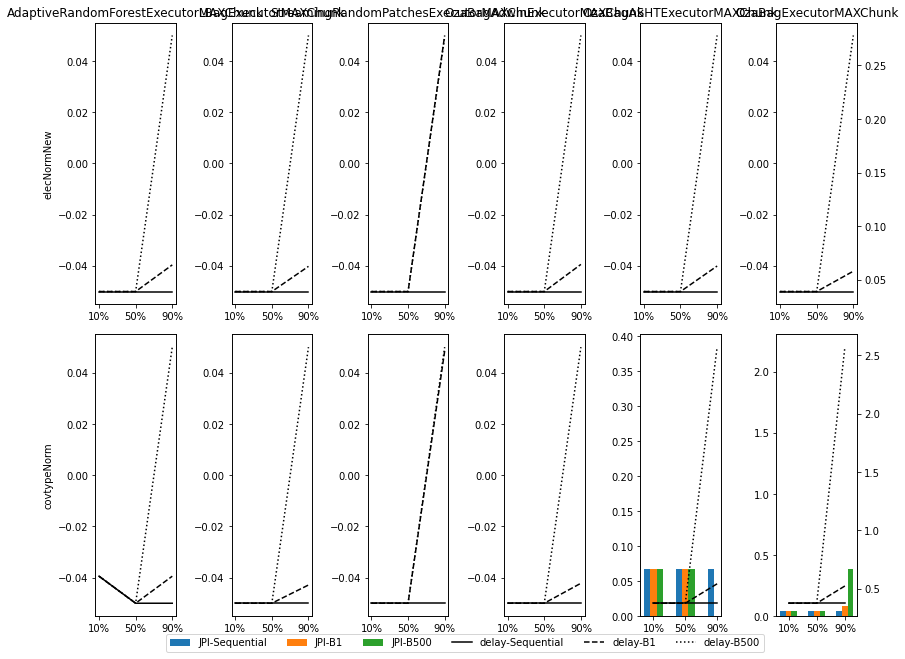

In [146]:
gen_graph(bars=True, share_y=False)

sharey = false

log scale y

In [147]:
gen_graph(bars=True, share_y=False, log_y=True)

False


algorithm      dataset  inc_rate  cores  \
168  StreamingRandomPatchesExecutorMAXChunk  elecNormNew        42      4   
169  StreamingRandomPatchesExecutorMAXChunk  elecNormNew        42      4   
170  StreamingRandomPatchesExecutorMAXChunk  elecNormNew        42      4   
171  StreamingRandomPatchesExecutorMAXChunk  elecNormNew        42      4   
172  StreamingRandomPatchesExecutorMAXChunk  elecNormNew        42      4   
..                                      ...          ...       ...    ...   
400    AdaptiveRandomForestExecutorMAXChunk         GMSC        32      4   
401    AdaptiveRandomForestExecutorMAXChunk         GMSC        32      4   
402    AdaptiveRandomForestExecutorMAXChunk         GMSC        32      4   
403    AdaptiveRandomForestExecutorMAXChunk         GMSC        32      4   
404    AdaptiveRandomForestExecutorMAXChunk         GMSC        32      4   

     batch_size  instances   time     delay  out_rate  duration  avg_measure  \
168        2000   4,800.00 119.99 29,369.00     40.00       127         3.92   
169        2000   4,800.00 119.99 29,369.00     40.00       127         3.92   
170        2000   4,800.00 119.99 29,369.00     40.00       127         3.92   
171         500   4,800.00 119.99  7,534.00     40.00       125          NaN   
172         500   4,800.00 119.99  7,534.00     40.00       125          NaN   
..          ...        ...    ...       ...       ...       ...          ...   
400        2000   3,600.00 119.97 35,757.00     30.01       125         4.08   
401        2000   3,600.00 119.97 35,757.00     30.01       125         4.08   
402          50   3,600.00 120.00    867.00     30.00       125          NaN   
403          50   3,600.00 120.00    867.00     30.00       125          NaN   
404          50   3,600.00 120.00    867.00     30.00       125          NaN   

     sum_measure  prod_rate  tt_inst_prod  joules  JPI PERC  
168       901.70      39.94      4,800.00  470.40 0.10   90  
169       901.70      39.94      4,800.00  470.40 0.10   50  
170       901.70      39.94      4,800.00  470.40 0.10   10  
171         0.00      39.94      4,800.00     NaN  NaN   90  
172         0.00      39.94      4,800.00     NaN  NaN   50  
..           ...        ...           ...     ...  ...  ...  
400       913.10      29.96      3,600.00  489.03 0.14   50  
401       913.10      29.96      3,600.00  489.03 0.14   10  
402         0.00      29.96      3,600.00     NaN  NaN   90  
403         0.00      29.96      3,600.00     NaN  NaN   50  
404         0.00      29.96      3,600.00     NaN  NaN   10  

[522 rows x 17 columns]

algorithm      dataset  inc_rate  cores  \
168  StreamingRandomPatchesExecutorMAXChunk  elecNormNew        42      4   
169  StreamingRandomPatchesExecutorMAXChunk  elecNormNew        42      4   
170  StreamingRandomPatchesExecutorMAXChunk  elecNormNew        42      4   
171  StreamingRandomPatchesExecutorMAXChunk  elecNormNew        42      4   
172  StreamingRandomPatchesExecutorMAXChunk  elecNormNew        42      4   
173  StreamingRandomPatchesExecutorMAXChunk  elecNormNew        42      4   
174  StreamingRandomPatchesExecutorMAXChunk  elecNormNew        42      4   
175  StreamingRandomPatchesExecutorMAXChunk  elecNormNew        42      4   
176  StreamingRandomPatchesExecutorMAXChunk  elecNormNew        42      4   
489  StreamingRandomPatchesExecutorMAXChunk  elecNormNew        23      4   
490  StreamingRandomPatchesExecutorMAXChunk  elecNormNew        23      4   
491  StreamingRandomPatchesExecutorMAXChunk  elecNormNew        23      4   
492  StreamingRandomPatchesExecutorMAXChunk  elecNormNew        23      4   
493  StreamingRandomPatchesExecutorMAXChunk  elecNormNew        23      4   
494  StreamingRandomPatchesExecutorMAXChunk  elecNormNew        23      4   
300  StreamingRandomPatchesExecutorMAXChunk  elecNormNew         4      4   
301  StreamingRandomPatchesExecutorMAXChunk  elecNormNew         4      4   
302  StreamingRandomPatchesExecutorMAXChunk  elecNormNew         4      4   
303  StreamingRandomPatchesExecutorMAXChunk  elecNormNew         4      4   
304  StreamingRandomPatchesExecutorMAXChunk  elecNormNew         4      4   
305  StreamingRandomPatchesExecutorMAXChunk  elecNormNew         4      4   
306  StreamingRandomPatchesExecutorMAXChunk  elecNormNew         4      4   
307  StreamingRandomPatchesExecutorMAXChunk  elecNormNew         4      4   
308  StreamingRandomPatchesExecutorMAXChunk  elecNormNew         4      4   
105                  OzaBagExecutorMAXChunk  elecNormNew       862      4   
106                  OzaBagExecutorMAXChunk  elecNormNew       862      4   
107                  OzaBagExecutorMAXChunk  elecNormNew       862      4   
108                  OzaBagExecutorMAXChunk  elecNormNew       862      4   
109                  OzaBagExecutorMAXChunk  elecNormNew       862      4   
110                  OzaBagExecutorMAXChunk  elecNormNew       862      4   
111                  OzaBagExecutorMAXChunk  elecNormNew       862      4   
112                  OzaBagExecutorMAXChunk  elecNormNew       862      4   
113                  OzaBagExecutorMAXChunk  elecNormNew       862      4   
513                  OzaBagExecutorMAXChunk  elecNormNew       479      4   
514                  OzaBagExecutorMAXChunk  elecNormNew       479      4   
515                  OzaBagExecutorMAXChunk  elecNormNew       479      4   
516                  OzaBagExecutorMAXChunk  elecNormNew       479      4   
517                  OzaBagExecutorMAXChunk  elecNormNew       479      4   
518                  OzaBagExecutorMAXChunk  elecNormNew       479      4   
519                  OzaBagExecutorMAXChunk  elecNormNew       479      4   
520                  OzaBagExecutorMAXChunk  elecNormNew       479      4   
521                  OzaBagExecutorMAXChunk  elecNormNew       479      4   
309                  OzaBagExecutorMAXChunk  elecNormNew        95      4   
310                  OzaBagExecutorMAXChunk  elecNormNew        95      4   
311                  OzaBagExecutorMAXChunk  elecNormNew        95      4   
312                  OzaBagExecutorMAXChunk  elecNormNew        95      4   
313                  OzaBagExecutorMAXChunk  elecNormNew        95      4   
314                  OzaBagExecutorMAXChunk  elecNormNew        95      4   
315                  OzaBagExecutorMAXChunk  elecNormNew        95      4   
316                  OzaBagExecutorMAXChunk  elecNormNew        95      4   
317                  OzaBagExecutorMAXChunk  elecNormNew        95      4   
387             OzaBagAdwinExe

algorithm      dataset  inc_rate  cores  \
132  AdaptiveRandomForestExecutorMAXChunk  elecNormNew       154      4   
133  AdaptiveRandomForestExecutorMAXChunk  elecNormNew       154      4   
134  AdaptiveRandomForestExecutorMAXChunk  elecNormNew       154      4   
72   AdaptiveRandomForestExecutorMAXChunk  elecNormNew        85      4   
73   AdaptiveRandomForestExecutorMAXChunk  elecNormNew        85      4   
74   AdaptiveRandomForestExecutorMAXChunk  elecNormNew        85      4   
423  AdaptiveRandomForestExecutorMAXChunk  elecNormNew        17      4   
424  AdaptiveRandomForestExecutorMAXChunk  elecNormNew        17      4   
425  AdaptiveRandomForestExecutorMAXChunk  elecNormNew        17      4   
126  AdaptiveRandomForestExecutorMAXChunk  elecNormNew       154      4   
127  AdaptiveRandomForestExecutorMAXChunk  elecNormNew       154      4   
128  AdaptiveRandomForestExecutorMAXChunk  elecNormNew       154      4   
75   AdaptiveRandomForestExecutorMAXChunk  elecNormNew        85      4   
76   AdaptiveRandomForestExecutorMAXChunk  elecNormNew        85      4   
77   AdaptiveRandomForestExecutorMAXChunk  elecNormNew        85      4   
417  AdaptiveRandomForestExecutorMAXChunk  elecNormNew        17      4   
418  AdaptiveRandomForestExecutorMAXChunk  elecNormNew        17      4   
419  AdaptiveRandomForestExecutorMAXChunk  elecNormNew        17      4   
129  AdaptiveRandomForestExecutorMAXChunk  elecNormNew       154      4   
130  AdaptiveRandomForestExecutorMAXChunk  elecNormNew       154      4   
131  AdaptiveRandomForestExecutorMAXChunk  elecNormNew       154      4   
69   AdaptiveRandomForestExecutorMAXChunk  elecNormNew        85      4   
70   AdaptiveRandomForestExecutorMAXChunk  elecNormNew        85      4   
71   AdaptiveRandomForestExecutorMAXChunk  elecNormNew        85      4   
420  AdaptiveRandomForestExecutorMAXChunk  elecNormNew        17      4   
421  AdaptiveRandomForestExecutorMAXChunk  elecNormNew        17      4   
422  AdaptiveRandomForestExecutorMAXChunk  elecNormNew        17      4   

     batch_size  instances   time     delay  out_rate  duration  avg_measure  \
132          50  17,970.00 119.87    192.00    149.92       124          NaN   
133          50  17,970.00 119.87    192.00    149.92       124          NaN   
134          50  17,970.00 119.87    192.00    149.92       124          NaN   
72           50  10,183.00 119.81    359.00     84.99       124          NaN   
73           50  10,183.00 119.81    359.00     84.99       124          NaN   
74           50  10,183.00 119.81    359.00     84.99       124          NaN   
423          50   1,800.00 120.01  1,797.00     15.00       123          NaN   
424          50   1,800.00 120.01  1,797.00     15.00       123          NaN   
425          50   1,800.00 120.01  1,797.00     15.00       123          NaN   
126         500  17,970.00 119.83  2,257.00    149.96       125          NaN   
127         500  17,970.00 119.83  2,257.00    149.96       125          NaN   
128         500  17,970.00 119.83  2,257.00    149.96       125          NaN   
75          500  10,184.00 120.01  3,718.00     84.86       125          NaN   
76          500  10,184.00 120.01  3,718.00     84.86       125          NaN   
77          500  10,184.00 120.01  3,718.00     84.86       125          NaN   
417         500   1,800.00 119.96 17,850.00     15.01       125          NaN   
418         500   1,800.00 119.96 17,850.00     15.01       125          NaN   
419         500   1,800.00 119.96 17,850.00     15.01       125          NaN   
129        2000  17,970.00 119.82  9,712.00    149.97       126         4.01   
130        2000  17,970.00 119.82  9,712.00    149.97       126         4.01   
131        2000  17,970.00 119.82  9,712.00    149.97       126         4.01   
69         2000  10,184.00 120.01 15,326.00     84.86       123         4.06   
70         2000  10,184.00 120.01 15,326.00     84.86       123         4.06   
71         

algorithm      dataset  inc_rate  cores  \
134  AdaptiveRandomForestExecutorMAXChunk  elecNormNew       154      4   
74   AdaptiveRandomForestExecutorMAXChunk  elecNormNew        85      4   
425  AdaptiveRandomForestExecutorMAXChunk  elecNormNew        17      4   
128  AdaptiveRandomForestExecutorMAXChunk  elecNormNew       154      4   
77   AdaptiveRandomForestExecutorMAXChunk  elecNormNew        85      4   
419  AdaptiveRandomForestExecutorMAXChunk  elecNormNew        17      4   
131  AdaptiveRandomForestExecutorMAXChunk  elecNormNew       154      4   
71   AdaptiveRandomForestExecutorMAXChunk  elecNormNew        85      4   
422  AdaptiveRandomForestExecutorMAXChunk  elecNormNew        17      4   

     batch_size  instances   time     delay  out_rate  duration  avg_measure  \
134          50  17,970.00 119.87    192.00    149.92       124          NaN   
74           50  10,183.00 119.81    359.00     84.99       124          NaN   
425          50   1,800.00 120.01  1,797.00     15.00       123          NaN   
128         500  17,970.00 119.83  2,257.00    149.96       125          NaN   
77          500  10,184.00 120.01  3,718.00     84.86       125          NaN   
419         500   1,800.00 119.96 17,850.00     15.01       125          NaN   
131        2000  17,970.00 119.82  9,712.00    149.97       126         4.01   
71         2000  10,184.00 120.01 15,326.00     84.86       123         4.06   
422        2000   1,800.00 119.96 73,957.00     15.01       138         4.22   

     sum_measure  prod_rate  tt_inst_prod  joules  JPI PERC  
134         0.00     149.73     17,970.00     NaN  NaN   10  
74          0.00      84.86     10,200.00     NaN  NaN   10  
425         0.00      14.98      1,800.00     NaN  NaN   10  
128         0.00     149.73     17,970.00     NaN  NaN   10  
77          0.00      84.86     10,200.00     NaN  NaN   10  
419         0.00      14.98      1,800.00     NaN  NaN   10  
131       914.40     149.73     17,970.00  480.55 0.03   10  
71        909.50      84.86     10,200.00  487.26 0.05   10  
422     1,055.80      14.98      1,800.00  506.60 0.28   10

algorithm      dataset  inc_rate  cores  \
133  AdaptiveRandomForestExecutorMAXChunk  elecNormNew       154      4   
73   AdaptiveRandomForestExecutorMAXChunk  elecNormNew        85      4   
424  AdaptiveRandomForestExecutorMAXChunk  elecNormNew        17      4   
127  AdaptiveRandomForestExecutorMAXChunk  elecNormNew       154      4   
76   AdaptiveRandomForestExecutorMAXChunk  elecNormNew        85      4   
418  AdaptiveRandomForestExecutorMAXChunk  elecNormNew        17      4   
130  AdaptiveRandomForestExecutorMAXChunk  elecNormNew       154      4   
70   AdaptiveRandomForestExecutorMAXChunk  elecNormNew        85      4   
421  AdaptiveRandomForestExecutorMAXChunk  elecNormNew        17      4   

     batch_size  instances   time     delay  out_rate  duration  avg_measure  \
133          50  17,970.00 119.87    192.00    149.92       124          NaN   
73           50  10,183.00 119.81    359.00     84.99       124          NaN   
424          50   1,800.00 120.01  1,797.00     15.00       123          NaN   
127         500  17,970.00 119.83  2,257.00    149.96       125          NaN   
76          500  10,184.00 120.01  3,718.00     84.86       125          NaN   
418         500   1,800.00 119.96 17,850.00     15.01       125          NaN   
130        2000  17,970.00 119.82  9,712.00    149.97       126         4.01   
70         2000  10,184.00 120.01 15,326.00     84.86       123         4.06   
421        2000   1,800.00 119.96 73,957.00     15.01       138         4.22   

     sum_measure  prod_rate  tt_inst_prod  joules  JPI PERC  
133         0.00     149.73     17,970.00     NaN  NaN   50  
73          0.00      84.86     10,200.00     NaN  NaN   50  
424         0.00      14.98      1,800.00     NaN  NaN   50  
127         0.00     149.73     17,970.00     NaN  NaN   50  
76          0.00      84.86     10,200.00     NaN  NaN   50  
418         0.00      14.98      1,800.00     NaN  NaN   50  
130       914.40     149.73     17,970.00  480.55 0.03   50  
70        909.50      84.86     10,200.00  487.26 0.05   50  
421     1,055.80      14.98      1,800.00  506.60 0.28   50

algorithm      dataset  inc_rate  cores  \
132  AdaptiveRandomForestExecutorMAXChunk  elecNormNew       154      4   
72   AdaptiveRandomForestExecutorMAXChunk  elecNormNew        85      4   
423  AdaptiveRandomForestExecutorMAXChunk  elecNormNew        17      4   
126  AdaptiveRandomForestExecutorMAXChunk  elecNormNew       154      4   
75   AdaptiveRandomForestExecutorMAXChunk  elecNormNew        85      4   
417  AdaptiveRandomForestExecutorMAXChunk  elecNormNew        17      4   
129  AdaptiveRandomForestExecutorMAXChunk  elecNormNew       154      4   
69   AdaptiveRandomForestExecutorMAXChunk  elecNormNew        85      4   
420  AdaptiveRandomForestExecutorMAXChunk  elecNormNew        17      4   

     batch_size  instances   time     delay  out_rate  duration  avg_measure  \
132          50  17,970.00 119.87    192.00    149.92       124          NaN   
72           50  10,183.00 119.81    359.00     84.99       124          NaN   
423          50   1,800.00 120.01  1,797.00     15.00       123          NaN   
126         500  17,970.00 119.83  2,257.00    149.96       125          NaN   
75          500  10,184.00 120.01  3,718.00     84.86       125          NaN   
417         500   1,800.00 119.96 17,850.00     15.01       125          NaN   
129        2000  17,970.00 119.82  9,712.00    149.97       126         4.01   
69         2000  10,184.00 120.01 15,326.00     84.86       123         4.06   
420        2000   1,800.00 119.96 73,957.00     15.01       138         4.22   

     sum_measure  prod_rate  tt_inst_prod  joules  JPI PERC  
132         0.00     149.73     17,970.00     NaN  NaN   90  
72          0.00      84.86     10,183.00     NaN  NaN   90  
423         0.00      14.98      1,800.00     NaN  NaN   90  
126         0.00     149.73     17,970.00     NaN  NaN   90  
75          0.00      84.86     10,183.00     NaN  NaN   90  
417         0.00      14.98      1,800.00     NaN  NaN   90  
129       914.40     149.73     17,970.00  480.55 0.03   90  
69        909.50      84.86     10,183.00  487.26 0.05   90  
420     1,055.80      14.98      1,800.00  506.60 0.28   90

algorithm      dataset  inc_rate  cores  batch_size  \
327  LBagExecutorMAXChunk  elecNormNew       294      4          50   
328  LBagExecutorMAXChunk  elecNormNew       294      4          50   
329  LBagExecutorMAXChunk  elecNormNew       294      4          50   
342  LBagExecutorMAXChunk  elecNormNew       163      4          50   
343  LBagExecutorMAXChunk  elecNormNew       163      4          50   
344  LBagExecutorMAXChunk  elecNormNew       163      4          50   
51   LBagExecutorMAXChunk  elecNormNew        32      4          50   
52   LBagExecutorMAXChunk  elecNormNew        32      4          50   
53   LBagExecutorMAXChunk  elecNormNew        32      4          50   
333  LBagExecutorMAXChunk  elecNormNew       294      4         500   
334  LBagExecutorMAXChunk  elecNormNew       294      4         500   
335  LBagExecutorMAXChunk  elecNormNew       294      4         500   
339  LBagExecutorMAXChunk  elecNormNew       163      4         500   
340  LBagExecutorMAXChunk  elecNormNew       163      4         500   
341  LBagExecutorMAXChunk  elecNormNew       163      4         500   
48   LBagExecutorMAXChunk  elecNormNew        32      4         500   
49   LBagExecutorMAXChunk  elecNormNew        32      4         500   
50   LBagExecutorMAXChunk  elecNormNew        32      4         500   
330  LBagExecutorMAXChunk  elecNormNew       294      4        2000   
331  LBagExecutorMAXChunk  elecNormNew       294      4        2000   
332  LBagExecutorMAXChunk  elecNormNew       294      4        2000   
336  LBagExecutorMAXChunk  elecNormNew       163      4        2000   
337  LBagExecutorMAXChunk  elecNormNew       163      4        2000   
338  LBagExecutorMAXChunk  elecNormNew       163      4        2000   
54   LBagExecutorMAXChunk  elecNormNew        32      4        2000   
55   LBagExecutorMAXChunk  elecNormNew        32      4        2000   
56   LBagExecutorMAXChunk  elecNormNew        32      4        2000   

     instances   time     delay  out_rate  duration  avg_measure  sum_measure  \
327  34,742.00 119.91    107.00    289.73       126          NaN         0.00   
328  34,742.00 119.91    107.00    289.73       126          NaN         0.00   
329  34,742.00 119.91    107.00    289.73       126          NaN         0.00   
342  19,168.00 119.87    183.00    159.90       125          NaN         0.00   
343  19,168.00 119.87    183.00    159.90       125          NaN         0.00   
344  19,168.00 119.87    183.00    159.90       125          NaN         0.00   
51    3,600.00 120.00    880.00     30.00       125          NaN         0.00   
52    3,600.00 120.00    880.00     30.00       125          NaN         0.00   
53    3,600.00 120.00    880.00     30.00       125          NaN         0.00   
333  34,742.00 119.88  1,169.00    289.81       126          NaN         0.00   
334  34,742.00 119.88  1,169.00    289.81       126          NaN         0.00   
335  34,742.00 119.88  1,169.00    289.81       126          NaN         0.00   
339  19,168.00 119.83  1,891.00    159.96       126          NaN         0.00   
340  19,168.00 119.83  1,891.00    159.96       126          NaN         0.00   
341  19,168.00 119.83  1,891.00    159.96       126          NaN         0.00   
48    3,600.00 119.97  9,184.00     30.01       125          NaN         0.00   
49    3,600.00 119.97  9,184.00     30.01       125          NaN         0.00   
50    3,600.00 119.97  9,184.00     30.01       125          NaN         0.00   
330  34,739.00 119.87  4,641.00    289.80       126         4.17       954.30   
331  34,739.00 119.87  4,641.00    289.80       126         4.17       954.30   
332  34,739.00 119.87  4,641.00    289.80       126         4.17       954.30   
336  19,168.00 119.83  7,678.00    159.96       126         4.13       945.00   
337  19,168.00 119.83  7,678.00    159.96       126         4.13       945.00   
338  19,168.00 119.83  7,678.00    159.96       126         4.13       945.00   
54

algorithm      dataset  inc_rate  cores  batch_size  \
329  LBagExecutorMAXChunk  elecNormNew       294      4          50   
344  LBagExecutorMAXChunk  elecNormNew       163      4          50   
53   LBagExecutorMAXChunk  elecNormNew        32      4          50   
335  LBagExecutorMAXChunk  elecNormNew       294      4         500   
341  LBagExecutorMAXChunk  elecNormNew       163      4         500   
50   LBagExecutorMAXChunk  elecNormNew        32      4         500   
332  LBagExecutorMAXChunk  elecNormNew       294      4        2000   
338  LBagExecutorMAXChunk  elecNormNew       163      4        2000   
56   LBagExecutorMAXChunk  elecNormNew        32      4        2000   

     instances   time     delay  out_rate  duration  avg_measure  sum_measure  \
329  34,742.00 119.91    107.00    289.73       126          NaN         0.00   
344  19,168.00 119.87    183.00    159.90       125          NaN         0.00   
53    3,600.00 120.00    880.00     30.00       125          NaN         0.00   
335  34,742.00 119.88  1,169.00    289.81       126          NaN         0.00   
341  19,168.00 119.83  1,891.00    159.96       126          NaN         0.00   
50    3,600.00 119.97  9,184.00     30.01       125          NaN         0.00   
332  34,739.00 119.87  4,641.00    289.80       126         4.17       954.30   
338  19,168.00 119.83  7,678.00    159.96       126         4.13       945.00   
56    3,600.00 119.97 35,733.00     30.01       127         4.13       917.50   

     prod_rate  tt_inst_prod  joules  JPI PERC  
329     289.36     34,742.00     NaN  NaN   10  
344     159.71     19,168.00     NaN  NaN   10  
53       29.96      3,600.00     NaN  NaN   10  
335     289.36     34,742.00     NaN  NaN   10  
341     159.71     19,168.00     NaN  NaN   10  
50       29.96      3,600.00     NaN  NaN   10  
332     289.36     34,742.00  499.54 0.01   10  
338     159.71     19,168.00  494.50 0.03   10  
56       29.96      3,600.00  495.83 0.14   10

algorithm      dataset  inc_rate  cores  batch_size  \
328  LBagExecutorMAXChunk  elecNormNew       294      4          50   
343  LBagExecutorMAXChunk  elecNormNew       163      4          50   
52   LBagExecutorMAXChunk  elecNormNew        32      4          50   
334  LBagExecutorMAXChunk  elecNormNew       294      4         500   
340  LBagExecutorMAXChunk  elecNormNew       163      4         500   
49   LBagExecutorMAXChunk  elecNormNew        32      4         500   
331  LBagExecutorMAXChunk  elecNormNew       294      4        2000   
337  LBagExecutorMAXChunk  elecNormNew       163      4        2000   
55   LBagExecutorMAXChunk  elecNormNew        32      4        2000   

     instances   time     delay  out_rate  duration  avg_measure  sum_measure  \
328  34,742.00 119.91    107.00    289.73       126          NaN         0.00   
343  19,168.00 119.87    183.00    159.90       125          NaN         0.00   
52    3,600.00 120.00    880.00     30.00       125          NaN         0.00   
334  34,742.00 119.88  1,169.00    289.81       126          NaN         0.00   
340  19,168.00 119.83  1,891.00    159.96       126          NaN         0.00   
49    3,600.00 119.97  9,184.00     30.01       125          NaN         0.00   
331  34,739.00 119.87  4,641.00    289.80       126         4.17       954.30   
337  19,168.00 119.83  7,678.00    159.96       126         4.13       945.00   
55    3,600.00 119.97 35,733.00     30.01       127         4.13       917.50   

     prod_rate  tt_inst_prod  joules  JPI PERC  
328     289.36     34,742.00     NaN  NaN   50  
343     159.71     19,168.00     NaN  NaN   50  
52       29.96      3,600.00     NaN  NaN   50  
334     289.36     34,742.00     NaN  NaN   50  
340     159.71     19,168.00     NaN  NaN   50  
49       29.96      3,600.00     NaN  NaN   50  
331     289.36     34,742.00  499.54 0.01   50  
337     159.71     19,168.00  494.50 0.03   50  
55       29.96      3,600.00  495.83 0.14   50

algorithm      dataset  inc_rate  cores  batch_size  \
327  LBagExecutorMAXChunk  elecNormNew       294      4          50   
342  LBagExecutorMAXChunk  elecNormNew       163      4          50   
51   LBagExecutorMAXChunk  elecNormNew        32      4          50   
333  LBagExecutorMAXChunk  elecNormNew       294      4         500   
339  LBagExecutorMAXChunk  elecNormNew       163      4         500   
48   LBagExecutorMAXChunk  elecNormNew        32      4         500   
330  LBagExecutorMAXChunk  elecNormNew       294      4        2000   
336  LBagExecutorMAXChunk  elecNormNew       163      4        2000   
54   LBagExecutorMAXChunk  elecNormNew        32      4        2000   

     instances   time     delay  out_rate  duration  avg_measure  sum_measure  \
327  34,742.00 119.91    107.00    289.73       126          NaN         0.00   
342  19,168.00 119.87    183.00    159.90       125          NaN         0.00   
51    3,600.00 120.00    880.00     30.00       125          NaN         0.00   
333  34,742.00 119.88  1,169.00    289.81       126          NaN         0.00   
339  19,168.00 119.83  1,891.00    159.96       126          NaN         0.00   
48    3,600.00 119.97  9,184.00     30.01       125          NaN         0.00   
330  34,739.00 119.87  4,641.00    289.80       126         4.17       954.30   
336  19,168.00 119.83  7,678.00    159.96       126         4.13       945.00   
54    3,600.00 119.97 35,733.00     30.01       127         4.13       917.50   

     prod_rate  tt_inst_prod  joules  JPI PERC  
327     289.35     34,742.00     NaN  NaN   90  
342     159.71     19,168.00     NaN  NaN   90  
51       29.96      3,600.00     NaN  NaN   90  
333     289.35     34,742.00     NaN  NaN   90  
339     159.71     19,168.00     NaN  NaN   90  
48       29.96      3,600.00     NaN  NaN   90  
330     289.35     34,742.00  499.54 0.01   90  
336     159.71     19,168.00  494.50 0.03   90  
54       29.96      3,600.00  495.83 0.14   90

algorithm      dataset  inc_rate  cores  \
174  StreamingRandomPatchesExecutorMAXChunk  elecNormNew        42      4   
175  StreamingRandomPatchesExecutorMAXChunk  elecNormNew        42      4   
176  StreamingRandomPatchesExecutorMAXChunk  elecNormNew        42      4   
489  StreamingRandomPatchesExecutorMAXChunk  elecNormNew        23      4   
490  StreamingRandomPatchesExecutorMAXChunk  elecNormNew        23      4   
300  StreamingRandomPatchesExecutorMAXChunk  elecNormNew         4      4   
301  StreamingRandomPatchesExecutorMAXChunk  elecNormNew         4      4   
302  StreamingRandomPatchesExecutorMAXChunk  elecNormNew         4      4   
171  StreamingRandomPatchesExecutorMAXChunk  elecNormNew        42      4   
172  StreamingRandomPatchesExecutorMAXChunk  elecNormNew        42      4   
173  StreamingRandomPatchesExecutorMAXChunk  elecNormNew        42      4   
491  StreamingRandomPatchesExecutorMAXChunk  elecNormNew        23      4   
492  StreamingRandomPatchesExecutorMAXChunk  elecNormNew        23      4   
306  StreamingRandomPatchesExecutorMAXChunk  elecNormNew         4      4   
307  StreamingRandomPatchesExecutorMAXChunk  elecNormNew         4      4   
308  StreamingRandomPatchesExecutorMAXChunk  elecNormNew         4      4   
168  StreamingRandomPatchesExecutorMAXChunk  elecNormNew        42      4   
169  StreamingRandomPatchesExecutorMAXChunk  elecNormNew        42      4   
170  StreamingRandomPatchesExecutorMAXChunk  elecNormNew        42      4   
493  StreamingRandomPatchesExecutorMAXChunk  elecNormNew        23      4   
494  StreamingRandomPatchesExecutorMAXChunk  elecNormNew        23      4   
303  StreamingRandomPatchesExecutorMAXChunk  elecNormNew         4      4   
304  StreamingRandomPatchesExecutorMAXChunk  elecNormNew         4      4   
305  StreamingRandomPatchesExecutorMAXChunk  elecNormNew         4      4   

     batch_size  instances   time     delay  out_rate  duration  avg_measure  \
174          50   4,800.00 120.07    720.00     39.98       124          NaN   
175          50   4,800.00 120.07    720.00     39.98       124          NaN   
176          50   4,800.00 120.07    720.00     39.98       124          NaN   
489          50   2,400.00 120.15  1,363.00     19.98       125          NaN   
490          50   2,400.00 120.15  1,363.00     19.98       125          NaN   
300          50   2,400.00 120.05  1,359.00     19.99       123          NaN   
301          50   2,400.00 120.05  1,359.00     19.99       123          NaN   
302          50   2,400.00 120.05  1,359.00     19.99       123          NaN   
171         500   4,800.00 119.99  7,534.00     40.00       125          NaN   
172         500   4,800.00 119.99  7,534.00     40.00       125          NaN   
173         500   4,800.00 119.99  7,534.00     40.00       125          NaN   
491         500   2,400.00 119.96 14,311.00     20.01       125          NaN   
492         500   2,400.00 119.96 14,311.00     20.01       125          NaN   
306         500   2,400.00 119.96 14,507.00     20.01       124          NaN   
307         500   2,400.00 119.96 14,507.00     20.01       124          NaN   
308         500   2,400.00 119.96 14,507.00     20.01       124          NaN   
168        2000   4,800.00 119.99 29,369.00     40.00       127         3.92   
169        2000   4,800.00 119.99 29,369.00     40.00       127         3.92   
170        2000   4,800.00 119.99 29,369.00     40.00       127         3.92   
493        2000   2,400.00 119.96 53,993.00     20.01       124         4.01   
494        2000   2,400.00 119.96 53,993.00     20.01       124         4.01   
303        2000   2,400.00 119.96 54,293.00     20.01       126         4.31   
304        2000   2,400.00 119.96 54,293.00     20.01       126         4.31   
305        2000   2,400.00 119.96 54,293.00     20.01       126         4.31   

     sum_measure  prod_rate  tt_inst_prod  joules  JPI PERC  
174         0.00      39.94      4,800.00    

algorithm      dataset  inc_rate  cores  \
176  StreamingRandomPatchesExecutorMAXChunk  elecNormNew        42      4   
302  StreamingRandomPatchesExecutorMAXChunk  elecNormNew         4      4   
173  StreamingRandomPatchesExecutorMAXChunk  elecNormNew        42      4   
491  StreamingRandomPatchesExecutorMAXChunk  elecNormNew        23      4   
308  StreamingRandomPatchesExecutorMAXChunk  elecNormNew         4      4   
170  StreamingRandomPatchesExecutorMAXChunk  elecNormNew        42      4   
494  StreamingRandomPatchesExecutorMAXChunk  elecNormNew        23      4   
305  StreamingRandomPatchesExecutorMAXChunk  elecNormNew         4      4   

     batch_size  instances   time     delay  out_rate  duration  avg_measure  \
176          50   4,800.00 120.07    720.00     39.98       124          NaN   
302          50   2,400.00 120.05  1,359.00     19.99       123          NaN   
173         500   4,800.00 119.99  7,534.00     40.00       125          NaN   
491         500   2,400.00 119.96 14,311.00     20.01       125          NaN   
308         500   2,400.00 119.96 14,507.00     20.01       124          NaN   
170        2000   4,800.00 119.99 29,369.00     40.00       127         3.92   
494        2000   2,400.00 119.96 53,993.00     20.01       124         4.01   
305        2000   2,400.00 119.96 54,293.00     20.01       126         4.31   

     sum_measure  prod_rate  tt_inst_prod  joules  JPI PERC  
176         0.00      39.94      4,800.00     NaN  NaN   10  
302         0.00      19.97      2,400.00     NaN  NaN   10  
173         0.00      39.94      4,800.00     NaN  NaN   10  
491         0.00      19.97      2,400.00     NaN  NaN   10  
308         0.00      19.97      2,400.00     NaN  NaN   10  
170       901.70      39.94      4,800.00  470.40 0.10   10  
494       906.40      19.98      2,400.00  481.11 0.20   10  
305       982.30      19.97      2,400.00  516.84 0.22   10

algorithm      dataset  inc_rate  cores  \
175  StreamingRandomPatchesExecutorMAXChunk  elecNormNew        42      4   
490  StreamingRandomPatchesExecutorMAXChunk  elecNormNew        23      4   
301  StreamingRandomPatchesExecutorMAXChunk  elecNormNew         4      4   
172  StreamingRandomPatchesExecutorMAXChunk  elecNormNew        42      4   
307  StreamingRandomPatchesExecutorMAXChunk  elecNormNew         4      4   
169  StreamingRandomPatchesExecutorMAXChunk  elecNormNew        42      4   
493  StreamingRandomPatchesExecutorMAXChunk  elecNormNew        23      4   
304  StreamingRandomPatchesExecutorMAXChunk  elecNormNew         4      4   

     batch_size  instances   time     delay  out_rate  duration  avg_measure  \
175          50   4,800.00 120.07    720.00     39.98       124          NaN   
490          50   2,400.00 120.15  1,363.00     19.98       125          NaN   
301          50   2,400.00 120.05  1,359.00     19.99       123          NaN   
172         500   4,800.00 119.99  7,534.00     40.00       125          NaN   
307         500   2,400.00 119.96 14,507.00     20.01       124          NaN   
169        2000   4,800.00 119.99 29,369.00     40.00       127         3.92   
493        2000   2,400.00 119.96 53,993.00     20.01       124         4.01   
304        2000   2,400.00 119.96 54,293.00     20.01       126         4.31   

     sum_measure  prod_rate  tt_inst_prod  joules  JPI PERC  
175         0.00      39.94      4,800.00     NaN  NaN   50  
490         0.00      19.98      2,400.00     NaN  NaN   50  
301         0.00      19.97      2,400.00     NaN  NaN   50  
172         0.00      39.94      4,800.00     NaN  NaN   50  
307         0.00      19.97      2,400.00     NaN  NaN   50  
169       901.70      39.94      4,800.00  470.40 0.10   50  
493       906.40      19.97      2,400.00  481.11 0.20   50  
304       982.30      19.97      2,400.00  516.84 0.22   50

algorithm      dataset  inc_rate  cores  \
174  StreamingRandomPatchesExecutorMAXChunk  elecNormNew        42      4   
489  StreamingRandomPatchesExecutorMAXChunk  elecNormNew        23      4   
300  StreamingRandomPatchesExecutorMAXChunk  elecNormNew         4      4   
171  StreamingRandomPatchesExecutorMAXChunk  elecNormNew        42      4   
492  StreamingRandomPatchesExecutorMAXChunk  elecNormNew        23      4   
306  StreamingRandomPatchesExecutorMAXChunk  elecNormNew         4      4   
168  StreamingRandomPatchesExecutorMAXChunk  elecNormNew        42      4   
303  StreamingRandomPatchesExecutorMAXChunk  elecNormNew         4      4   

     batch_size  instances   time     delay  out_rate  duration  avg_measure  \
174          50   4,800.00 120.07    720.00     39.98       124          NaN   
489          50   2,400.00 120.15  1,363.00     19.98       125          NaN   
300          50   2,400.00 120.05  1,359.00     19.99       123          NaN   
171         500   4,800.00 119.99  7,534.00     40.00       125          NaN   
492         500   2,400.00 119.96 14,311.00     20.01       125          NaN   
306         500   2,400.00 119.96 14,507.00     20.01       124          NaN   
168        2000   4,800.00 119.99 29,369.00     40.00       127         3.92   
303        2000   2,400.00 119.96 54,293.00     20.01       126         4.31   

     sum_measure  prod_rate  tt_inst_prod  joules  JPI PERC  
174         0.00      39.94      4,800.00     NaN  NaN   90  
489         0.00      19.97      2,400.00     NaN  NaN   90  
300         0.00      19.97      2,400.00     NaN  NaN   90  
171         0.00      39.94      4,800.00     NaN  NaN   90  
492         0.00      19.98      2,400.00     NaN  NaN   90  
306         0.00      19.97      2,400.00     NaN  NaN   90  
168       901.70      39.94      4,800.00  470.40 0.10   90  
303       982.30      19.97      2,400.00  516.84 0.22   90

algorithm      dataset  inc_rate  cores  batch_size  \
390  OzaBagAdwinExecutorMAXChunk  elecNormNew       717      4          50   
391  OzaBagAdwinExecutorMAXChunk  elecNormNew       717      4          50   
392  OzaBagAdwinExecutorMAXChunk  elecNormNew       717      4          50   
12   OzaBagAdwinExecutorMAXChunk  elecNormNew       398      4          50   
13   OzaBagAdwinExecutorMAXChunk  elecNormNew       398      4          50   
14   OzaBagAdwinExecutorMAXChunk  elecNormNew       398      4          50   
282  OzaBagAdwinExecutorMAXChunk  elecNormNew        79      4          50   
283  OzaBagAdwinExecutorMAXChunk  elecNormNew        79      4          50   
284  OzaBagAdwinExecutorMAXChunk  elecNormNew        79      4          50   
387  OzaBagAdwinExecutorMAXChunk  elecNormNew       717      4         500   
388  OzaBagAdwinExecutorMAXChunk  elecNormNew       717      4         500   
389  OzaBagAdwinExecutorMAXChunk  elecNormNew       717      4         500   
15   OzaBagAdwinExecutorMAXChunk  elecNormNew       398      4         500   
16   OzaBagAdwinExecutorMAXChunk  elecNormNew       398      4         500   
17   OzaBagAdwinExecutorMAXChunk  elecNormNew       398      4         500   
285  OzaBagAdwinExecutorMAXChunk  elecNormNew        79      4         500   
286  OzaBagAdwinExecutorMAXChunk  elecNormNew        79      4         500   
287  OzaBagAdwinExecutorMAXChunk  elecNormNew        79      4         500   
393  OzaBagAdwinExecutorMAXChunk  elecNormNew       717      4        2000   
394  OzaBagAdwinExecutorMAXChunk  elecNormNew       717      4        2000   
395  OzaBagAdwinExecutorMAXChunk  elecNormNew       717      4        2000   
9    OzaBagAdwinExecutorMAXChunk  elecNormNew       398      4        2000   
10   OzaBagAdwinExecutorMAXChunk  elecNormNew       398      4        2000   
11   OzaBagAdwinExecutorMAXChunk  elecNormNew       398      4        2000   
279  OzaBagAdwinExecutorMAXChunk  elecNormNew        79      4        2000   
280  OzaBagAdwinExecutorMAXChunk  elecNormNew        79      4        2000   
281  OzaBagAdwinExecutorMAXChunk  elecNormNew        79      4        2000   

     instances   time     delay  out_rate  duration  avg_measure  sum_measure  \
390  45,312.00  63.46     46.00    714.00        68          NaN         0.00   
391  45,312.00  63.46     46.00    714.00        68          NaN         0.00   
392  45,312.00  63.46     46.00    714.00        68          NaN         0.00   
12   45,312.00 114.91     76.00    394.32       121          NaN         0.00   
13   45,312.00 114.91     76.00    394.32       121          NaN         0.00   
14   45,312.00 114.91     76.00    394.32       121          NaN         0.00   
282   8,986.00 120.01    329.00     74.88       125          NaN         0.00   
283   8,986.00 120.01    329.00     74.88       125          NaN         0.00   
284   8,986.00 120.01    329.00     74.88       125          NaN         0.00   
387  45,312.00  63.41    498.00    714.59        69          NaN         0.00   
388  45,312.00  63.41    498.00    714.59        69          NaN         0.00   
389  45,312.00  63.41    498.00    714.59        69          NaN         0.00   
15   45,312.00 114.90    774.00    394.36       121          NaN         0.00   
16   45,312.00 114.90    774.00    394.36       121          NaN         0.00   
17   45,312.00 114.90    774.00    394.36       121          NaN         0.00   
285   8,986.00 120.00  3,561.00     74.88       125          NaN         0.00   
286   8,986.00 120.00  3,561.00     74.88       125          NaN         0.00   
287   8,986.00 120.00  3,561.00     74.88       125          NaN         0.00   
393  45,237.00  63.41  1,995.00    713.39        68         3.92       485.70   
394  45,237.00  63.41  1,995.00    713.39        68         3.92       485.70   
395  45,237.00  63.41  1,995.00    713.39        68         3.92       485.70   
9    45,312.00 114.89  3,093.00    394.40       121     

algorithm      dataset  inc_rate  cores  batch_size  \
392  OzaBagAdwinExecutorMAXChunk  elecNormNew       717      4          50   
14   OzaBagAdwinExecutorMAXChunk  elecNormNew       398      4          50   
284  OzaBagAdwinExecutorMAXChunk  elecNormNew        79      4          50   
389  OzaBagAdwinExecutorMAXChunk  elecNormNew       717      4         500   
17   OzaBagAdwinExecutorMAXChunk  elecNormNew       398      4         500   
287  OzaBagAdwinExecutorMAXChunk  elecNormNew        79      4         500   
395  OzaBagAdwinExecutorMAXChunk  elecNormNew       717      4        2000   
11   OzaBagAdwinExecutorMAXChunk  elecNormNew       398      4        2000   
281  OzaBagAdwinExecutorMAXChunk  elecNormNew        79      4        2000   

     instances   time     delay  out_rate  duration  avg_measure  sum_measure  \
392  45,312.00  63.46     46.00    714.00        68          NaN         0.00   
14   45,312.00 114.91     76.00    394.32       121          NaN         0.00   
284   8,986.00 120.01    329.00     74.88       125          NaN         0.00   
389  45,312.00  63.41    498.00    714.59        69          NaN         0.00   
17   45,312.00 114.90    774.00    394.36       121          NaN         0.00   
287   8,986.00 120.00  3,561.00     74.88       125          NaN         0.00   
395  45,237.00  63.41  1,995.00    713.39        68         3.92       485.70   
11   45,312.00 114.89  3,093.00    394.40       121         3.88       835.10   
281   8,986.00 120.01 13,850.00     74.88       126         4.02       916.20   

     prod_rate  tt_inst_prod  joules  JPI PERC  
392     712.45     45,312.00     NaN  NaN   10  
14      393.75     45,312.00     NaN  NaN   10  
284      74.88      9,000.00     NaN  NaN   10  
389     712.45     45,312.00     NaN  NaN   10  
17      393.75     45,312.00     NaN  NaN   10  
287      74.88      9,000.00     NaN  NaN   10  
395     712.45     45,312.00  248.38 0.01   10  
11      393.75     45,312.00  446.24 0.01   10  
281      74.88      9,000.00  482.24 0.05   10

algorithm      dataset  inc_rate  cores  batch_size  \
391  OzaBagAdwinExecutorMAXChunk  elecNormNew       717      4          50   
13   OzaBagAdwinExecutorMAXChunk  elecNormNew       398      4          50   
283  OzaBagAdwinExecutorMAXChunk  elecNormNew        79      4          50   
388  OzaBagAdwinExecutorMAXChunk  elecNormNew       717      4         500   
16   OzaBagAdwinExecutorMAXChunk  elecNormNew       398      4         500   
286  OzaBagAdwinExecutorMAXChunk  elecNormNew        79      4         500   
394  OzaBagAdwinExecutorMAXChunk  elecNormNew       717      4        2000   
10   OzaBagAdwinExecutorMAXChunk  elecNormNew       398      4        2000   
280  OzaBagAdwinExecutorMAXChunk  elecNormNew        79      4        2000   

     instances   time     delay  out_rate  duration  avg_measure  sum_measure  \
391  45,312.00  63.46     46.00    714.00        68          NaN         0.00   
13   45,312.00 114.91     76.00    394.32       121          NaN         0.00   
283   8,986.00 120.01    329.00     74.88       125          NaN         0.00   
388  45,312.00  63.41    498.00    714.59        69          NaN         0.00   
16   45,312.00 114.90    774.00    394.36       121          NaN         0.00   
286   8,986.00 120.00  3,561.00     74.88       125          NaN         0.00   
394  45,237.00  63.41  1,995.00    713.39        68         3.92       485.70   
10   45,312.00 114.89  3,093.00    394.40       121         3.88       835.10   
280   8,986.00 120.01 13,850.00     74.88       126         4.02       916.20   

     prod_rate  tt_inst_prod  joules  JPI PERC  
391     712.49     45,312.00     NaN  NaN   50  
13      393.71     45,312.00     NaN  NaN   50  
283      74.88      9,000.00     NaN  NaN   50  
388     712.49     45,312.00     NaN  NaN   50  
16      393.71     45,312.00     NaN  NaN   50  
286      74.88      9,000.00     NaN  NaN   50  
394     712.49     45,312.00  248.38 0.01   50  
10      393.71     45,312.00  446.24 0.01   50  
280      74.88      9,000.00  482.24 0.05   50

algorithm      dataset  inc_rate  cores  batch_size  \
390  OzaBagAdwinExecutorMAXChunk  elecNormNew       717      4          50   
12   OzaBagAdwinExecutorMAXChunk  elecNormNew       398      4          50   
282  OzaBagAdwinExecutorMAXChunk  elecNormNew        79      4          50   
387  OzaBagAdwinExecutorMAXChunk  elecNormNew       717      4         500   
15   OzaBagAdwinExecutorMAXChunk  elecNormNew       398      4         500   
285  OzaBagAdwinExecutorMAXChunk  elecNormNew        79      4         500   
393  OzaBagAdwinExecutorMAXChunk  elecNormNew       717      4        2000   
9    OzaBagAdwinExecutorMAXChunk  elecNormNew       398      4        2000   
279  OzaBagAdwinExecutorMAXChunk  elecNormNew        79      4        2000   

     instances   time     delay  out_rate  duration  avg_measure  sum_measure  \
390  45,312.00  63.46     46.00    714.00        68          NaN         0.00   
12   45,312.00 114.91     76.00    394.32       121          NaN         0.00   
282   8,986.00 120.01    329.00     74.88       125          NaN         0.00   
387  45,312.00  63.41    498.00    714.59        69          NaN         0.00   
15   45,312.00 114.90    774.00    394.36       121          NaN         0.00   
285   8,986.00 120.00  3,561.00     74.88       125          NaN         0.00   
393  45,237.00  63.41  1,995.00    713.39        68         3.92       485.70   
9    45,312.00 114.89  3,093.00    394.40       121         3.88       835.10   
279   8,986.00 120.01 13,850.00     74.88       126         4.02       916.20   

     prod_rate  tt_inst_prod  joules  JPI PERC  
390     712.35     45,312.00     NaN  NaN   90  
12      393.70     45,312.00     NaN  NaN   90  
282      74.88      9,000.00     NaN  NaN   90  
387     712.35     45,312.00     NaN  NaN   90  
15      393.70     45,312.00     NaN  NaN   90  
285      74.88      9,000.00     NaN  NaN   90  
393     712.35     45,312.00  248.38 0.01   90  
9       393.70     45,312.00  446.24 0.01   90  
279      74.88      9,000.00  482.24 0.05   90

algorithm      dataset  inc_rate  cores  batch_size  \
213  OzaBagASHTExecutorMAXChunk  elecNormNew       371      4          50   
214  OzaBagASHTExecutorMAXChunk  elecNormNew       371      4          50   
215  OzaBagASHTExecutorMAXChunk  elecNormNew       371      4          50   
87   OzaBagASHTExecutorMAXChunk  elecNormNew       206      4          50   
88   OzaBagASHTExecutorMAXChunk  elecNormNew       206      4          50   
89   OzaBagASHTExecutorMAXChunk  elecNormNew       206      4          50   
147  OzaBagASHTExecutorMAXChunk  elecNormNew        41      4          50   
148  OzaBagASHTExecutorMAXChunk  elecNormNew        41      4          50   
149  OzaBagASHTExecutorMAXChunk  elecNormNew        41      4          50   
207  OzaBagASHTExecutorMAXChunk  elecNormNew       371      4         500   
208  OzaBagASHTExecutorMAXChunk  elecNormNew       371      4         500   
209  OzaBagASHTExecutorMAXChunk  elecNormNew       371      4         500   
90   OzaBagASHTExecutorMAXChunk  elecNormNew       206      4         500   
91   OzaBagASHTExecutorMAXChunk  elecNormNew       206      4         500   
92   OzaBagASHTExecutorMAXChunk  elecNormNew       206      4         500   
150  OzaBagASHTExecutorMAXChunk  elecNormNew        41      4         500   
151  OzaBagASHTExecutorMAXChunk  elecNormNew        41      4         500   
152  OzaBagASHTExecutorMAXChunk  elecNormNew        41      4         500   
210  OzaBagASHTExecutorMAXChunk  elecNormNew       371      4        2000   
211  OzaBagASHTExecutorMAXChunk  elecNormNew       371      4        2000   
212  OzaBagASHTExecutorMAXChunk  elecNormNew       371      4        2000   
93   OzaBagASHTExecutorMAXChunk  elecNormNew       206      4        2000   
94   OzaBagASHTExecutorMAXChunk  elecNormNew       206      4        2000   
95   OzaBagASHTExecutorMAXChunk  elecNormNew       206      4        2000   
153  OzaBagASHTExecutorMAXChunk  elecNormNew        41      4        2000   
154  OzaBagASHTExecutorMAXChunk  elecNormNew        41      4        2000   
155  OzaBagASHTExecutorMAXChunk  elecNormNew        41      4        2000   

     instances   time     delay  out_rate  duration  avg_measure  sum_measure  \
213  44,326.00 119.92     75.00    369.63       126          NaN         0.00   
214  44,326.00 119.92     75.00    369.63       126          NaN         0.00   
215  44,326.00 119.92     75.00    369.63       126          NaN         0.00   
87   24,559.00 119.86    131.00    204.90       125          NaN         0.00   
88   24,559.00 119.86    131.00    204.90       125          NaN         0.00   
89   24,559.00 119.86    131.00    204.90       125          NaN         0.00   
147   4,800.00 119.99    637.00     40.00       126          NaN         0.00   
148   4,800.00 119.99    637.00     40.00       126          NaN         0.00   
149   4,800.00 119.99    637.00     40.00       126          NaN         0.00   
207  44,326.00 119.90    794.00    369.68       125          NaN         0.00   
208  44,326.00 119.90    794.00    369.68       125          NaN         0.00   
209  44,326.00 119.90    794.00    369.68       125          NaN         0.00   
90   24,559.00 119.85  1,346.00    204.91       126          NaN         0.00   
91   24,559.00 119.85  1,346.00    204.91       126          NaN         0.00   
92   24,559.00 119.85  1,346.00    204.91       126          NaN         0.00   
150   4,800.00 119.99  6,412.00     40.01       125          NaN         0.00   
151   4,800.00 119.99  6,412.00     40.01       125          NaN         0.00   
152   4,800.00 119.99  6,412.00     40.01       125          NaN         0.00   
210  44,326.00 119.90  3,243.00    369.70       126         3.93       896.90   
211  44,326.00 119.90  3,243.00    369.70       126         3.93       896.90   
212  44,326.00 119.90  3,243.00    369.70       126         3.93       896.90   
93   24,559.00 119.85  5,466.00    204.92       126         4.00       920.40   
94

algorithm      dataset  inc_rate  cores  batch_size  \
215  OzaBagASHTExecutorMAXChunk  elecNormNew       371      4          50   
89   OzaBagASHTExecutorMAXChunk  elecNormNew       206      4          50   
149  OzaBagASHTExecutorMAXChunk  elecNormNew        41      4          50   
209  OzaBagASHTExecutorMAXChunk  elecNormNew       371      4         500   
92   OzaBagASHTExecutorMAXChunk  elecNormNew       206      4         500   
152  OzaBagASHTExecutorMAXChunk  elecNormNew        41      4         500   
212  OzaBagASHTExecutorMAXChunk  elecNormNew       371      4        2000   
95   OzaBagASHTExecutorMAXChunk  elecNormNew       206      4        2000   
155  OzaBagASHTExecutorMAXChunk  elecNormNew        41      4        2000   

     instances   time     delay  out_rate  duration  avg_measure  sum_measure  \
215  44,326.00 119.92     75.00    369.63       126          NaN         0.00   
89   24,559.00 119.86    131.00    204.90       125          NaN         0.00   
149   4,800.00 119.99    637.00     40.00       126          NaN         0.00   
209  44,326.00 119.90    794.00    369.68       125          NaN         0.00   
92   24,559.00 119.85  1,346.00    204.91       126          NaN         0.00   
152   4,800.00 119.99  6,412.00     40.01       125          NaN         0.00   
212  44,326.00 119.90  3,243.00    369.70       126         3.93       896.90   
95   24,559.00 119.85  5,466.00    204.92       126         4.00       920.40   
155   4,800.00 119.98 24,163.00     40.01       126         3.89       887.50   

     prod_rate  tt_inst_prod  joules  JPI PERC  
215     369.12     44,326.00     NaN  NaN   10  
89      204.60     24,559.00     NaN  NaN   10  
149      39.94      4,800.00     NaN  NaN   10  
209     369.12     44,326.00     NaN  NaN   10  
92      204.60     24,559.00     NaN  NaN   10  
152      39.94      4,800.00     NaN  NaN   10  
212     369.12     44,326.00  471.65 0.01   10  
95      204.60     24,559.00  479.59 0.02   10  
155      39.94      4,800.00  467.04 0.10   10

algorithm      dataset  inc_rate  cores  batch_size  \
214  OzaBagASHTExecutorMAXChunk  elecNormNew       371      4          50   
88   OzaBagASHTExecutorMAXChunk  elecNormNew       206      4          50   
148  OzaBagASHTExecutorMAXChunk  elecNormNew        41      4          50   
208  OzaBagASHTExecutorMAXChunk  elecNormNew       371      4         500   
91   OzaBagASHTExecutorMAXChunk  elecNormNew       206      4         500   
151  OzaBagASHTExecutorMAXChunk  elecNormNew        41      4         500   
211  OzaBagASHTExecutorMAXChunk  elecNormNew       371      4        2000   
94   OzaBagASHTExecutorMAXChunk  elecNormNew       206      4        2000   
154  OzaBagASHTExecutorMAXChunk  elecNormNew        41      4        2000   

     instances   time     delay  out_rate  duration  avg_measure  sum_measure  \
214  44,326.00 119.92     75.00    369.63       126          NaN         0.00   
88   24,559.00 119.86    131.00    204.90       125          NaN         0.00   
148   4,800.00 119.99    637.00     40.00       126          NaN         0.00   
208  44,326.00 119.90    794.00    369.68       125          NaN         0.00   
91   24,559.00 119.85  1,346.00    204.91       126          NaN         0.00   
151   4,800.00 119.99  6,412.00     40.01       125          NaN         0.00   
211  44,326.00 119.90  3,243.00    369.70       126         3.93       896.90   
94   24,559.00 119.85  5,466.00    204.92       126         4.00       920.40   
154   4,800.00 119.98 24,163.00     40.01       126         3.89       887.50   

     prod_rate  tt_inst_prod  joules  JPI PERC  
214     369.10     44,326.00     NaN  NaN   50  
88      204.60     24,559.00     NaN  NaN   50  
148      39.94      4,800.00     NaN  NaN   50  
208     369.10     44,326.00     NaN  NaN   50  
91      204.60     24,559.00     NaN  NaN   50  
151      39.94      4,800.00     NaN  NaN   50  
211     369.10     44,326.00  471.65 0.01   50  
94      204.60     24,559.00  479.59 0.02   50  
154      39.94      4,800.00  467.04 0.10   50

algorithm      dataset  inc_rate  cores  batch_size  \
213  OzaBagASHTExecutorMAXChunk  elecNormNew       371      4          50   
87   OzaBagASHTExecutorMAXChunk  elecNormNew       206      4          50   
147  OzaBagASHTExecutorMAXChunk  elecNormNew        41      4          50   
207  OzaBagASHTExecutorMAXChunk  elecNormNew       371      4         500   
90   OzaBagASHTExecutorMAXChunk  elecNormNew       206      4         500   
150  OzaBagASHTExecutorMAXChunk  elecNormNew        41      4         500   
210  OzaBagASHTExecutorMAXChunk  elecNormNew       371      4        2000   
93   OzaBagASHTExecutorMAXChunk  elecNormNew       206      4        2000   
153  OzaBagASHTExecutorMAXChunk  elecNormNew        41      4        2000   

     instances   time     delay  out_rate  duration  avg_measure  sum_measure  \
213  44,326.00 119.92     75.00    369.63       126          NaN         0.00   
87   24,559.00 119.86    131.00    204.90       125          NaN         0.00   
147   4,800.00 119.99    637.00     40.00       126          NaN         0.00   
207  44,326.00 119.90    794.00    369.68       125          NaN         0.00   
90   24,559.00 119.85  1,346.00    204.91       126          NaN         0.00   
150   4,800.00 119.99  6,412.00     40.01       125          NaN         0.00   
210  44,326.00 119.90  3,243.00    369.70       126         3.93       896.90   
93   24,559.00 119.85  5,466.00    204.92       126         4.00       920.40   
153   4,800.00 119.98 24,163.00     40.01       126         3.89       887.50   

     prod_rate  tt_inst_prod  joules  JPI PERC  
213     369.09     44,326.00     NaN  NaN   90  
87      204.60     24,559.00     NaN  NaN   90  
147      39.94      4,800.00     NaN  NaN   90  
207     369.09     44,326.00     NaN  NaN   90  
90      204.60     24,559.00     NaN  NaN   90  
150      39.94      4,800.00     NaN  NaN   90  
210     369.09     44,326.00  471.65 0.01   90  
93      204.60     24,559.00  479.59 0.02   90  
153      39.94      4,800.00  467.04 0.10   90

algorithm      dataset  inc_rate  cores  batch_size  \
108  OzaBagExecutorMAXChunk  elecNormNew       862      4          50   
109  OzaBagExecutorMAXChunk  elecNormNew       862      4          50   
110  OzaBagExecutorMAXChunk  elecNormNew       862      4          50   
516  OzaBagExecutorMAXChunk  elecNormNew       479      4          50   
517  OzaBagExecutorMAXChunk  elecNormNew       479      4          50   
518  OzaBagExecutorMAXChunk  elecNormNew       479      4          50   
309  OzaBagExecutorMAXChunk  elecNormNew        95      4          50   
310  OzaBagExecutorMAXChunk  elecNormNew        95      4          50   
311  OzaBagExecutorMAXChunk  elecNormNew        95      4          50   
105  OzaBagExecutorMAXChunk  elecNormNew       862      4         500   
106  OzaBagExecutorMAXChunk  elecNormNew       862      4         500   
107  OzaBagExecutorMAXChunk  elecNormNew       862      4         500   
519  OzaBagExecutorMAXChunk  elecNormNew       479      4         500   
520  OzaBagExecutorMAXChunk  elecNormNew       479      4         500   
521  OzaBagExecutorMAXChunk  elecNormNew       479      4         500   
312  OzaBagExecutorMAXChunk  elecNormNew        95      4         500   
313  OzaBagExecutorMAXChunk  elecNormNew        95      4         500   
314  OzaBagExecutorMAXChunk  elecNormNew        95      4         500   
111  OzaBagExecutorMAXChunk  elecNormNew       862      4        2000   
112  OzaBagExecutorMAXChunk  elecNormNew       862      4        2000   
113  OzaBagExecutorMAXChunk  elecNormNew       862      4        2000   
513  OzaBagExecutorMAXChunk  elecNormNew       479      4        2000   
514  OzaBagExecutorMAXChunk  elecNormNew       479      4        2000   
515  OzaBagExecutorMAXChunk  elecNormNew       479      4        2000   
315  OzaBagExecutorMAXChunk  elecNormNew        95      4        2000   
316  OzaBagExecutorMAXChunk  elecNormNew        95      4        2000   
317  OzaBagExecutorMAXChunk  elecNormNew        95      4        2000   

     instances   time     delay  out_rate  duration  avg_measure  sum_measure  \
108  45,312.00  52.83     39.00    857.76        59          NaN         0.00   
109  45,312.00  52.83     39.00    857.76        59          NaN         0.00   
110  45,312.00  52.83     39.00    857.76        59          NaN         0.00   
516  45,312.00  95.49     58.00    474.52       100          NaN         0.00   
517  45,312.00  95.49     58.00    474.52       100          NaN         0.00   
518  45,312.00  95.49     58.00    474.52       100          NaN         0.00   
309  11,381.00 119.82    278.00     94.98       126          NaN         0.00   
310  11,381.00 119.82    278.00     94.98       126          NaN         0.00   
311  11,381.00 119.82    278.00     94.98       126          NaN         0.00   
105  45,312.00  52.81    422.00    858.04        58         3.90       413.00   
106  45,312.00  52.81    422.00    858.04        58         3.90       413.00   
107  45,312.00  52.81    422.00    858.04        58         3.90       413.00   
519  45,312.00  95.45    644.00    474.70       101         3.73        63.40   
520  45,312.00  95.45    644.00    474.70       101         3.73        63.40   
521  45,312.00  95.45    644.00    474.70       101         3.73        63.40   
312  11,381.00 119.82  2,801.00     94.99       126          NaN         0.00   
313  11,381.00 119.82  2,801.00     94.99       126          NaN         0.00   
314  11,381.00 119.82  2,801.00     94.99       126          NaN         0.00   
111  44,892.00  52.79  1,664.00    850.37        58         4.02       425.80   
112  44,892.00  52.79  1,664.00    850.37        58         4.02       425.80   
113  44,892.00  52.79  1,664.00    850.37        58         4.02       425.80   
513  45,312.00  95.46  2,605.00    474.68       102         3.93       730.50   
514  45,312.00  95.46  2,605.00    474.68       102         3.93       730.50   
515  45,312.00  95.46  2,605.

algorithm      dataset  inc_rate  cores  batch_size  \
110  OzaBagExecutorMAXChunk  elecNormNew       862      4          50   
518  OzaBagExecutorMAXChunk  elecNormNew       479      4          50   
311  OzaBagExecutorMAXChunk  elecNormNew        95      4          50   
107  OzaBagExecutorMAXChunk  elecNormNew       862      4         500   
521  OzaBagExecutorMAXChunk  elecNormNew       479      4         500   
314  OzaBagExecutorMAXChunk  elecNormNew        95      4         500   
113  OzaBagExecutorMAXChunk  elecNormNew       862      4        2000   
515  OzaBagExecutorMAXChunk  elecNormNew       479      4        2000   
317  OzaBagExecutorMAXChunk  elecNormNew        95      4        2000   

     instances   time     delay  out_rate  duration  avg_measure  sum_measure  \
110  45,312.00  52.83     39.00    857.76        59          NaN         0.00   
518  45,312.00  95.49     58.00    474.52       100          NaN         0.00   
311  11,381.00 119.82    278.00     94.98       126          NaN         0.00   
107  45,312.00  52.81    422.00    858.04        58         3.90       413.00   
521  45,312.00  95.45    644.00    474.70       101         3.73        63.40   
314  11,381.00 119.82  2,801.00     94.99       126          NaN         0.00   
113  44,892.00  52.79  1,664.00    850.37        58         4.02       425.80   
515  45,312.00  95.46  2,605.00    474.68       102         3.93       730.50   
317  11,382.00 120.01 11,380.00     94.84       125         3.95       893.80   

     prod_rate  tt_inst_prod  joules  JPI PERC  
110     855.28     45,312.00     NaN  NaN   10  
518     473.75     45,312.00     NaN  NaN   10  
311      94.84     11,400.00     NaN  NaN   10  
107     855.28     45,312.00  205.76 0.00   10  
521     473.75     45,312.00  355.99 0.01   10  
314      94.84     11,400.00     NaN  NaN   10  
113     855.28     45,312.00  212.06 0.00   10  
515     473.75     45,312.00  374.90 0.01   10  
317      94.84     11,400.00  474.62 0.04   10

algorithm      dataset  inc_rate  cores  batch_size  \
109  OzaBagExecutorMAXChunk  elecNormNew       862      4          50   
517  OzaBagExecutorMAXChunk  elecNormNew       479      4          50   
310  OzaBagExecutorMAXChunk  elecNormNew        95      4          50   
106  OzaBagExecutorMAXChunk  elecNormNew       862      4         500   
520  OzaBagExecutorMAXChunk  elecNormNew       479      4         500   
313  OzaBagExecutorMAXChunk  elecNormNew        95      4         500   
112  OzaBagExecutorMAXChunk  elecNormNew       862      4        2000   
514  OzaBagExecutorMAXChunk  elecNormNew       479      4        2000   
316  OzaBagExecutorMAXChunk  elecNormNew        95      4        2000   

     instances   time     delay  out_rate  duration  avg_measure  sum_measure  \
109  45,312.00  52.83     39.00    857.76        59          NaN         0.00   
517  45,312.00  95.49     58.00    474.52       100          NaN         0.00   
310  11,381.00 119.82    278.00     94.98       126          NaN         0.00   
106  45,312.00  52.81    422.00    858.04        58         3.90       413.00   
520  45,312.00  95.45    644.00    474.70       101         3.73        63.40   
313  11,381.00 119.82  2,801.00     94.99       126          NaN         0.00   
112  44,892.00  52.79  1,664.00    850.37        58         4.02       425.80   
514  45,312.00  95.46  2,605.00    474.68       102         3.93       730.50   
316  11,382.00 120.01 11,380.00     94.84       125         3.95       893.80   

     prod_rate  tt_inst_prod  joules  JPI PERC  
109     855.02     45,312.00     NaN  NaN   50  
517     473.78     45,312.00     NaN  NaN   50  
310      94.84     11,381.00     NaN  NaN   50  
106     855.02     45,312.00  205.76 0.00   50  
520     473.78     45,312.00  355.99 0.01   50  
313      94.84     11,381.00     NaN  NaN   50  
112     855.02     45,312.00  212.06 0.00   50  
514     473.78     45,312.00  374.90 0.01   50  
316      94.84     11,381.00  474.62 0.04   50

algorithm      dataset  inc_rate  cores  batch_size  \
108  OzaBagExecutorMAXChunk  elecNormNew       862      4          50   
516  OzaBagExecutorMAXChunk  elecNormNew       479      4          50   
309  OzaBagExecutorMAXChunk  elecNormNew        95      4          50   
105  OzaBagExecutorMAXChunk  elecNormNew       862      4         500   
519  OzaBagExecutorMAXChunk  elecNormNew       479      4         500   
312  OzaBagExecutorMAXChunk  elecNormNew        95      4         500   
111  OzaBagExecutorMAXChunk  elecNormNew       862      4        2000   
513  OzaBagExecutorMAXChunk  elecNormNew       479      4        2000   
315  OzaBagExecutorMAXChunk  elecNormNew        95      4        2000   

     instances   time     delay  out_rate  duration  avg_measure  sum_measure  \
108  45,312.00  52.83     39.00    857.76        59          NaN         0.00   
516  45,312.00  95.49     58.00    474.52       100          NaN         0.00   
309  11,381.00 119.82    278.00     94.98       126          NaN         0.00   
105  45,312.00  52.81    422.00    858.04        58         3.90       413.00   
519  45,312.00  95.45    644.00    474.70       101         3.73        63.40   
312  11,381.00 119.82  2,801.00     94.99       126          NaN         0.00   
111  44,892.00  52.79  1,664.00    850.37        58         4.02       425.80   
513  45,312.00  95.46  2,605.00    474.68       102         3.93       730.50   
315  11,382.00 120.01 11,380.00     94.84       125         3.95       893.80   

     prod_rate  tt_inst_prod  joules  JPI PERC  
108     855.17     45,312.00     NaN  NaN   90  
516     473.69     45,312.00     NaN  NaN   90  
309      94.84     11,381.00     NaN  NaN   90  
105     855.17     45,312.00  205.76 0.00   90  
519     473.69     45,312.00  355.99 0.01   90  
312      94.84     11,381.00     NaN  NaN   90  
111     855.17     45,312.00  212.06 0.00   90  
513     473.69     45,312.00  374.90 0.01   90  
315      94.84     11,381.00  474.62 0.04   90

algorithm      dataset  inc_rate  cores  \
168  StreamingRandomPatchesExecutorMAXChunk  elecNormNew        42      4   
169  StreamingRandomPatchesExecutorMAXChunk  elecNormNew        42      4   
170  StreamingRandomPatchesExecutorMAXChunk  elecNormNew        42      4   
171  StreamingRandomPatchesExecutorMAXChunk  elecNormNew        42      4   
172  StreamingRandomPatchesExecutorMAXChunk  elecNormNew        42      4   
..                                      ...          ...       ...    ...   
400    AdaptiveRandomForestExecutorMAXChunk         GMSC        32      4   
401    AdaptiveRandomForestExecutorMAXChunk         GMSC        32      4   
402    AdaptiveRandomForestExecutorMAXChunk         GMSC        32      4   
403    AdaptiveRandomForestExecutorMAXChunk         GMSC        32      4   
404    AdaptiveRandomForestExecutorMAXChunk         GMSC        32      4   

     batch_size  instances   time     delay  out_rate  duration  avg_measure  \
168        2000   4,800.00 119.99 29,369.00     40.00       127         3.92   
169        2000   4,800.00 119.99 29,369.00     40.00       127         3.92   
170        2000   4,800.00 119.99 29,369.00     40.00       127         3.92   
171         500   4,800.00 119.99  7,534.00     40.00       125          NaN   
172         500   4,800.00 119.99  7,534.00     40.00       125          NaN   
..          ...        ...    ...       ...       ...       ...          ...   
400        2000   3,600.00 119.97 35,757.00     30.01       125         4.08   
401        2000   3,600.00 119.97 35,757.00     30.01       125         4.08   
402          50   3,600.00 120.00    867.00     30.00       125          NaN   
403          50   3,600.00 120.00    867.00     30.00       125          NaN   
404          50   3,600.00 120.00    867.00     30.00       125          NaN   

     sum_measure  prod_rate  tt_inst_prod  joules  JPI PERC  
168       901.70      39.94      4,800.00  470.40 0.10   90  
169       901.70      39.94      4,800.00  470.40 0.10   50  
170       901.70      39.94      4,800.00  470.40 0.10   10  
171         0.00      39.94      4,800.00     NaN  NaN   90  
172         0.00      39.94      4,800.00     NaN  NaN   50  
..           ...        ...           ...     ...  ...  ...  
400       913.10      29.96      3,600.00  489.03 0.14   50  
401       913.10      29.96      3,600.00  489.03 0.14   10  
402         0.00      29.96      3,600.00     NaN  NaN   90  
403         0.00      29.96      3,600.00     NaN  NaN   50  
404         0.00      29.96      3,600.00     NaN  NaN   10  

[522 rows x 17 columns]

algorithm      dataset  inc_rate  cores  \
30   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm        43      4   
31   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm        43      4   
32   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm        43      4   
33   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm        43      4   
34   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm        43      4   
35   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm        43      4   
36   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm        43      4   
37   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm        43      4   
38   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm        43      4   
243  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm        23      4   
244  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm        23      4   
245  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm        23      4   
246  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm        23      4   
247  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm        23      4   
248  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm        23      4   
249  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm        23      4   
250  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm        23      4   
251  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm        23      4   
198  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm         4      4   
199  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm         4      4   
200  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm         4      4   
201  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm         4      4   
202  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm         4      4   
203  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm         4      4   
204  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm         4      4   
205  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm         4      4   
206  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm         4      4   
216                  OzaBagExecutorMAXChunk  covtypeNorm        90      4   
217                  OzaBagExecutorMAXChunk  covtypeNorm        90      4   
218                  OzaBagExecutorMAXChunk  covtypeNorm        90      4   
219                  OzaBagExecutorMAXChunk  covtypeNorm        90      4   
220                  OzaBagExecutorMAXChunk  covtypeNorm        90      4   
221                  OzaBagExecutorMAXChunk  covtypeNorm        90      4   
222                  OzaBagExecutorMAXChunk  covtypeNorm        90      4   
223                  OzaBagExecutorMAXChunk  covtypeNorm        90      4   
224                  OzaBagExecutorMAXChunk  covtypeNorm        90      4   
504                  OzaBagExecutorMAXChunk  covtypeNorm        50      4   
505                  OzaBagExecutorMAXChunk  covtypeNorm        50      4   
506                  OzaBagExecutorMAXChunk  covtypeNorm        50      4   
507                  OzaBagExecutorMAXChunk  covtypeNorm        50      4   
508                  OzaBagExecutorMAXChunk  covtypeNorm        50      4   
509                  OzaBagExecutorMAXChunk  covtypeNorm        50      4   
510                  OzaBagExecutorMAXChunk  covtypeNorm        50      4   
511                  OzaBagExecutorMAXChunk  covtypeNorm        50      4   
512                  OzaBagExecutorMAXChunk  covtypeNorm        50      4   
78                   OzaBagExecutorMAXChunk  covtypeNorm        10      4   
79                   OzaBagExecutorMAXChunk  covtypeNorm        10      4   
80                   OzaBagExecutorMAXChunk  covtypeNorm        10      4   
81                   OzaBagExecutorMAXChunk  covtypeNorm        10      4   
82                   OzaBagExecutorMAXChunk  covtypeNorm        10      4   
83                   OzaBagExecutorMAXChunk  covtypeNorm        10      4   
84                   OzaBagExe

algorithm      dataset  inc_rate  cores  \
273  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm       102      4   
274  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm       102      4   
228  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm        56      4   
229  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm        56      4   
230  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm        56      4   
318  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm        11      4   
319  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm        11      4   
320  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm        11      4   
275  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm       102      4   
276  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm       102      4   
225  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm        56      4   
226  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm        56      4   
227  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm        56      4   
321  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm        11      4   
322  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm        11      4   
323  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm        11      4   
277  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm       102      4   
278  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm       102      4   
231  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm        56      4   
232  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm        56      4   
233  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm        56      4   
324  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm        11      4   
325  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm        11      4   
326  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm        11      4   

     batch_size  instances   time     delay  out_rate  duration  avg_measure  \
273          50  11,980.00 119.81    318.00     99.99       124          NaN   
274          50  11,980.00 119.81    318.00     99.99       124          NaN   
228          50   6,600.00 120.08    564.00     54.96       124          NaN   
229          50   6,600.00 120.08    564.00     54.96       124          NaN   
230          50   6,600.00 120.08    564.00     54.96       124          NaN   
318          50   1,200.00 120.04  2,649.00     10.00       123          NaN   
319          50   1,200.00 120.04  2,649.00     10.00       123          NaN   
320          50   1,200.00 120.04  2,649.00     10.00       123          NaN   
275         500  11,980.00 119.81  3,435.00     99.99       124         4.24   
276         500  11,980.00 119.81  3,435.00     99.99       124         4.24   
225         500   6,600.00 119.99  5,619.00     55.00       125         4.17   
226         500   6,600.00 119.99  5,619.00     55.00       125         4.17   
227         500   6,600.00 119.99  5,619.00     55.00       125         4.17   
321         500   1,200.00 119.94 25,518.00     10.00       125         3.97   
322         500   1,200.00 119.94 25,518.00     10.00       125         3.97   
323         500   1,200.00 119.94 25,518.00     10.00       125         3.97   
277        2000  11,164.00 120.00 15,358.00     93.03       126         3.97   
278        2000  11,164.00 120.00 15,358.00     93.03       126         3.97   
231        2000   6,600.00 120.00 23,775.00     55.00       125         4.35   
232        2000   6,600.00 120.00 23,775.00     55.00       125         4.35   
233        2000   6,600.00 120.00 23,775.00     55.00       125         4.35   
324        2000   1,200.00 119.94 75,237.00     10.00       140         4.08   
325        2000   1,200.00 119.94 75,237.00     10.00       140         4.08   
326        2000   1,200.00 119.94 75,237.00     10.00       140         4.08   

     sum_measure  prod_rate  tt_inst_prod  joules  JPI PERC  
273         0.00      99.83     11,980.00     NaN  NaN   90  
274         0.00      99.84    

algorithm      dataset  inc_rate  cores  \
230  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm        56      4   
320  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm        11      4   
275  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm       102      4   
227  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm        56      4   
323  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm        11      4   
278  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm       102      4   
233  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm        56      4   
326  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm        11      4   

     batch_size  instances   time     delay  out_rate  duration  avg_measure  \
230          50   6,600.00 120.08    564.00     54.96       124          NaN   
320          50   1,200.00 120.04  2,649.00     10.00       123          NaN   
275         500  11,980.00 119.81  3,435.00     99.99       124         4.24   
227         500   6,600.00 119.99  5,619.00     55.00       125         4.17   
323         500   1,200.00 119.94 25,518.00     10.00       125         3.97   
278        2000  11,164.00 120.00 15,358.00     93.03       126         3.97   
233        2000   6,600.00 120.00 23,775.00     55.00       125         4.35   
326        2000   1,200.00 119.94 75,237.00     10.00       140         4.08   

     sum_measure  prod_rate  tt_inst_prod  joules  JPI PERC  
230         0.00      54.91      6,600.00     NaN  NaN   10  
320         0.00       9.99      1,200.00     NaN  NaN   10  
275       954.60      99.83     11,980.00  508.33 0.04   10  
227       943.20      54.91      6,600.00  500.78 0.08   10  
323       904.80       9.99      1,200.00  475.99 0.40   10  
278       909.40      99.84     12,000.00  476.55 0.04   10  
233       952.00      54.91      6,600.00  521.62 0.08   10  
326     1,036.10       9.99      1,200.00  489.26 0.41   10

algorithm      dataset  inc_rate  cores  \
274  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm       102      4   
229  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm        56      4   
319  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm        11      4   
226  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm        56      4   
322  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm        11      4   
277  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm       102      4   
232  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm        56      4   
325  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm        11      4   

     batch_size  instances   time     delay  out_rate  duration  avg_measure  \
274          50  11,980.00 119.81    318.00     99.99       124          NaN   
229          50   6,600.00 120.08    564.00     54.96       124          NaN   
319          50   1,200.00 120.04  2,649.00     10.00       123          NaN   
226         500   6,600.00 119.99  5,619.00     55.00       125         4.17   
322         500   1,200.00 119.94 25,518.00     10.00       125         3.97   
277        2000  11,164.00 120.00 15,358.00     93.03       126         3.97   
232        2000   6,600.00 120.00 23,775.00     55.00       125         4.35   
325        2000   1,200.00 119.94 75,237.00     10.00       140         4.08   

     sum_measure  prod_rate  tt_inst_prod  joules  JPI PERC  
274         0.00      99.84     12,000.00     NaN  NaN   50  
229         0.00      54.92      6,600.00     NaN  NaN   50  
319         0.00       9.99      1,200.00     NaN  NaN   50  
226       943.20      54.92      6,600.00  500.78 0.08   50  
322       904.80       9.99      1,200.00  475.99 0.40   50  
277       909.40      99.83     11,980.00  476.55 0.04   50  
232       952.00      54.92      6,600.00  521.62 0.08   50  
325     1,036.10       9.99      1,200.00  489.26 0.41   50

algorithm      dataset  inc_rate  cores  \
273  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm       102      4   
228  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm        56      4   
318  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm        11      4   
276  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm       102      4   
225  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm        56      4   
321  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm        11      4   
231  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm        56      4   
324  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm        11      4   

     batch_size  instances   time     delay  out_rate  duration  avg_measure  \
273          50  11,980.00 119.81    318.00     99.99       124          NaN   
228          50   6,600.00 120.08    564.00     54.96       124          NaN   
318          50   1,200.00 120.04  2,649.00     10.00       123          NaN   
276         500  11,980.00 119.81  3,435.00     99.99       124         4.24   
225         500   6,600.00 119.99  5,619.00     55.00       125         4.17   
321         500   1,200.00 119.94 25,518.00     10.00       125         3.97   
231        2000   6,600.00 120.00 23,775.00     55.00       125         4.35   
324        2000   1,200.00 119.94 75,237.00     10.00       140         4.08   

     sum_measure  prod_rate  tt_inst_prod  joules  JPI PERC  
273         0.00      99.83     11,980.00     NaN  NaN   90  
228         0.00      54.92      6,600.00     NaN  NaN   90  
318         0.00       9.99      1,200.00     NaN  NaN   90  
276       954.60      99.84     12,000.00  508.33 0.04   90  
225       943.20      54.92      6,600.00  500.78 0.08   90  
321       904.80       9.99      1,200.00  475.99 0.40   90  
231       952.00      54.92      6,600.00  521.62 0.08   90  
324     1,036.10       9.99      1,200.00  489.26 0.41   90

algorithm      dataset  inc_rate  cores  batch_size  \
252  LBagExecutorMAXChunk  covtypeNorm        68      4          50   
253  LBagExecutorMAXChunk  covtypeNorm        68      4          50   
254  LBagExecutorMAXChunk  covtypeNorm        68      4          50   
102  LBagExecutorMAXChunk  covtypeNorm        38      4          50   
103  LBagExecutorMAXChunk  covtypeNorm        38      4          50   
104  LBagExecutorMAXChunk  covtypeNorm        38      4          50   
351  LBagExecutorMAXChunk  covtypeNorm         7      4          50   
352  LBagExecutorMAXChunk  covtypeNorm         7      4          50   
353  LBagExecutorMAXChunk  covtypeNorm         7      4          50   
258  LBagExecutorMAXChunk  covtypeNorm        68      4         500   
259  LBagExecutorMAXChunk  covtypeNorm        68      4         500   
260  LBagExecutorMAXChunk  covtypeNorm        68      4         500   
99   LBagExecutorMAXChunk  covtypeNorm        38      4         500   
100  LBagExecutorMAXChunk  covtypeNorm        38      4         500   
101  LBagExecutorMAXChunk  covtypeNorm        38      4         500   
348  LBagExecutorMAXChunk  covtypeNorm         7      4         500   
349  LBagExecutorMAXChunk  covtypeNorm         7      4         500   
350  LBagExecutorMAXChunk  covtypeNorm         7      4         500   
255  LBagExecutorMAXChunk  covtypeNorm        68      4        2000   
256  LBagExecutorMAXChunk  covtypeNorm        68      4        2000   
257  LBagExecutorMAXChunk  covtypeNorm        68      4        2000   
96   LBagExecutorMAXChunk  covtypeNorm        38      4        2000   
97   LBagExecutorMAXChunk  covtypeNorm        38      4        2000   
98   LBagExecutorMAXChunk  covtypeNorm        38      4        2000   
345  LBagExecutorMAXChunk  covtypeNorm         7      4        2000   
346  LBagExecutorMAXChunk  covtypeNorm         7      4        2000   
347  LBagExecutorMAXChunk  covtypeNorm         7      4        2000   

     instances   time     delay  out_rate  duration  avg_measure  sum_measure  \
252   7,800.00 120.18    540.00     64.90       126          NaN         0.00   
253   7,800.00 120.18    540.00     64.90       126          NaN         0.00   
254   7,800.00 120.18    540.00     64.90       126          NaN         0.00   
102   4,200.00 120.15    870.00     34.96       126          NaN         0.00   
103   4,200.00 120.15    870.00     34.96       126          NaN         0.00   
104   4,200.00 120.15    870.00     34.96       126          NaN         0.00   
351     600.00 120.01  5,174.00      5.00       125          NaN         0.00   
352     600.00 120.01  5,174.00      5.00       125          NaN         0.00   
353     600.00 120.01  5,174.00      5.00       125          NaN         0.00   
258   7,800.00 120.00  5,311.00     65.00       126         4.23       968.00   
259   7,800.00 120.00  5,311.00     65.00       126         4.23       968.00   
260   7,800.00 120.00  5,311.00     65.00       126         4.23       968.00   
99    4,200.00 119.97  8,692.00     35.01       126         4.27       952.90   
100   4,200.00 119.97  8,692.00     35.01       126         4.27       952.90   
101   4,200.00 119.97  8,692.00     35.01       126         4.27       952.90   
348     600.00 119.94 46,264.00      5.00       126         3.97       909.10   
349     600.00 119.94 46,264.00      5.00       126         3.97       909.10   
350     600.00 119.94 46,264.00      5.00       126         3.97       909.10   
255   7,800.00 120.00 21,406.00     65.00       132         4.15       996.90   
256   7,800.00 120.00 21,406.00     65.00       132         4.15       996.90   
257   7,800.00 120.00 21,406.00     65.00       132         4.15       996.90   
96    4,000.00 120.98 36,506.00     33.06       126         4.24       966.60   
97    4,000.00 120.98 36,506.00     33.06       126         4.24       966.60   
98    4,000.00 120.98 36,506.00     33.06       126         4.24       966.60   
34

algorithm      dataset  inc_rate  cores  batch_size  \
254  LBagExecutorMAXChunk  covtypeNorm        68      4          50   
104  LBagExecutorMAXChunk  covtypeNorm        38      4          50   
353  LBagExecutorMAXChunk  covtypeNorm         7      4          50   
260  LBagExecutorMAXChunk  covtypeNorm        68      4         500   
101  LBagExecutorMAXChunk  covtypeNorm        38      4         500   
350  LBagExecutorMAXChunk  covtypeNorm         7      4         500   
257  LBagExecutorMAXChunk  covtypeNorm        68      4        2000   
98   LBagExecutorMAXChunk  covtypeNorm        38      4        2000   
347  LBagExecutorMAXChunk  covtypeNorm         7      4        2000   

     instances   time     delay  out_rate  duration  avg_measure  sum_measure  \
254   7,800.00 120.18    540.00     64.90       126          NaN         0.00   
104   4,200.00 120.15    870.00     34.96       126          NaN         0.00   
353     600.00 120.01  5,174.00      5.00       125          NaN         0.00   
260   7,800.00 120.00  5,311.00     65.00       126         4.23       968.00   
101   4,200.00 119.97  8,692.00     35.01       126         4.27       952.90   
350     600.00 119.94 46,264.00      5.00       126         3.97       909.10   
257   7,800.00 120.00 21,406.00     65.00       132         4.15       996.90   
98    4,000.00 120.98 36,506.00     33.06       126         4.24       966.60   
347     600.00 119.94 64,547.00      5.00       130         4.07       959.50   

     prod_rate  tt_inst_prod  joules  JPI PERC  
254      64.90      7,800.00     NaN  NaN   10  
104      34.95      4,200.00     NaN  NaN   10  
353       4.99        600.00     NaN  NaN   10  
260      64.90      7,800.00  507.23 0.07   10  
101      34.95      4,200.00  512.63 0.12   10  
350       4.99        600.00  476.14 0.79   10  
257      64.90      7,800.00  498.44 0.06   10  
98       34.95      4,200.00  512.89 0.13   10  
347       4.99        600.00  487.63 0.81   10

algorithm      dataset  inc_rate  cores  batch_size  \
253  LBagExecutorMAXChunk  covtypeNorm        68      4          50   
103  LBagExecutorMAXChunk  covtypeNorm        38      4          50   
352  LBagExecutorMAXChunk  covtypeNorm         7      4          50   
259  LBagExecutorMAXChunk  covtypeNorm        68      4         500   
100  LBagExecutorMAXChunk  covtypeNorm        38      4         500   
349  LBagExecutorMAXChunk  covtypeNorm         7      4         500   
256  LBagExecutorMAXChunk  covtypeNorm        68      4        2000   
97   LBagExecutorMAXChunk  covtypeNorm        38      4        2000   
346  LBagExecutorMAXChunk  covtypeNorm         7      4        2000   

     instances   time     delay  out_rate  duration  avg_measure  sum_measure  \
253   7,800.00 120.18    540.00     64.90       126          NaN         0.00   
103   4,200.00 120.15    870.00     34.96       126          NaN         0.00   
352     600.00 120.01  5,174.00      5.00       125          NaN         0.00   
259   7,800.00 120.00  5,311.00     65.00       126         4.23       968.00   
100   4,200.00 119.97  8,692.00     35.01       126         4.27       952.90   
349     600.00 119.94 46,264.00      5.00       126         3.97       909.10   
256   7,800.00 120.00 21,406.00     65.00       132         4.15       996.90   
97    4,000.00 120.98 36,506.00     33.06       126         4.24       966.60   
346     600.00 119.94 64,547.00      5.00       130         4.07       959.50   

     prod_rate  tt_inst_prod  joules  JPI PERC  
253      64.90      7,800.00     NaN  NaN   50  
103      34.95      4,200.00     NaN  NaN   50  
352       4.99        600.00     NaN  NaN   50  
259      64.90      7,800.00  507.23 0.07   50  
100      34.95      4,200.00  512.63 0.12   50  
349       4.99        600.00  476.14 0.79   50  
256      64.90      7,800.00  498.44 0.06   50  
97       34.95      4,200.00  512.89 0.13   50  
346       4.99        600.00  487.63 0.81   50

algorithm      dataset  inc_rate  cores  batch_size  \
252  LBagExecutorMAXChunk  covtypeNorm        68      4          50   
102  LBagExecutorMAXChunk  covtypeNorm        38      4          50   
351  LBagExecutorMAXChunk  covtypeNorm         7      4          50   
258  LBagExecutorMAXChunk  covtypeNorm        68      4         500   
99   LBagExecutorMAXChunk  covtypeNorm        38      4         500   
348  LBagExecutorMAXChunk  covtypeNorm         7      4         500   
255  LBagExecutorMAXChunk  covtypeNorm        68      4        2000   
96   LBagExecutorMAXChunk  covtypeNorm        38      4        2000   
345  LBagExecutorMAXChunk  covtypeNorm         7      4        2000   

     instances   time     delay  out_rate  duration  avg_measure  sum_measure  \
252   7,800.00 120.18    540.00     64.90       126          NaN         0.00   
102   4,200.00 120.15    870.00     34.96       126          NaN         0.00   
351     600.00 120.01  5,174.00      5.00       125          NaN         0.00   
258   7,800.00 120.00  5,311.00     65.00       126         4.23       968.00   
99    4,200.00 119.97  8,692.00     35.01       126         4.27       952.90   
348     600.00 119.94 46,264.00      5.00       126         3.97       909.10   
255   7,800.00 120.00 21,406.00     65.00       132         4.15       996.90   
96    4,000.00 120.98 36,506.00     33.06       126         4.24       966.60   
345     600.00 119.94 64,547.00      5.00       130         4.07       959.50   

     prod_rate  tt_inst_prod  joules  JPI PERC  
252      64.90      7,800.00     NaN  NaN   90  
102      34.95      4,200.00     NaN  NaN   90  
351       4.99        600.00     NaN  NaN   90  
258      64.90      7,800.00  507.23 0.07   90  
99       34.95      4,200.00  512.63 0.12   90  
348       4.99        600.00  476.14 0.79   90  
255      64.90      7,800.00  498.44 0.06   90  
96       34.95      4,200.00  512.89 0.13   90  
345       4.99        600.00  487.63 0.81   90

algorithm      dataset  inc_rate  cores  \
36   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm        43      4   
37   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm        43      4   
38   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm        43      4   
243  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm        23      4   
244  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm        23      4   
245  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm        23      4   
198  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm         4      4   
199  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm         4      4   
200  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm         4      4   
30   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm        43      4   
31   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm        43      4   
32   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm        43      4   
246  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm        23      4   
247  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm        23      4   
248  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm        23      4   
204  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm         4      4   
205  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm         4      4   
206  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm         4      4   
33   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm        43      4   
34   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm        43      4   
35   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm        43      4   
249  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm        23      4   
250  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm        23      4   
251  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm        23      4   
201  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm         4      4   
202  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm         4      4   
203  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm         4      4   

     batch_size  instances   time     delay  out_rate  duration  avg_measure  \
36           50   4,800.00 120.33    842.00     39.89       125          NaN   
37           50   4,800.00 120.33    842.00     39.89       125          NaN   
38           50   4,800.00 120.33    842.00     39.89       125          NaN   
243          50   2,400.00 120.18  1,499.00     19.97       125          NaN   
244          50   2,400.00 120.18  1,499.00     19.97       125          NaN   
245          50   2,400.00 120.18  1,499.00     19.97       125          NaN   
198          50   2,400.00 120.21  1,509.00     19.97       124          NaN   
199          50   2,400.00 120.21  1,509.00     19.97       124          NaN   
200          50   2,400.00 120.21  1,509.00     19.97       124          NaN   
30          500   4,800.00 119.98  8,803.00     40.01       126         4.18   
31          500   4,800.00 119.98  8,803.00     40.01       126         4.18   
32          500   4,800.00 119.98  8,803.00     40.01       126         4.18   
246         500   2,400.00 119.95 16,038.00     20.01       126         4.18   
247         500   2,400.00 119.95 16,038.00     20.01       126         4.18   
248         500   2,400.00 119.95 16,038.00     20.01       126         4.18   
204         500   2,400.00 119.95 16,107.00     20.01       126         3.93   
205         500   2,400.00 119.95 16,107.00     20.01       126         3.93   
206         500   2,400.00 119.95 16,107.00     20.01       126         3.93   
33         2000   4,800.00 119.97 34,331.00     40.01       127         3.86   
34         2000   4,800.00 119.97 34,331.00     40.01       127         3.86   
35         2000   4,800.00 119.97 34,331.00     40.01       127         3.86   
249        2000        NaN    NaN       NaN       NaN       650         4.11   
250        2000        NaN    NaN    

algorithm      dataset  inc_rate  cores  \
38   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm        43      4   
245  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm        23      4   
200  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm         4      4   
32   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm        43      4   
248  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm        23      4   
206  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm         4      4   
35   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm        43      4   
251  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm        23      4   
203  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm         4      4   

     batch_size  instances   time     delay  out_rate  duration  avg_measure  \
38           50   4,800.00 120.33    842.00     39.89       125          NaN   
245          50   2,400.00 120.18  1,499.00     19.97       125          NaN   
200          50   2,400.00 120.21  1,509.00     19.97       124          NaN   
32          500   4,800.00 119.98  8,803.00     40.01       126         4.18   
248         500   2,400.00 119.95 16,038.00     20.01       126         4.18   
206         500   2,400.00 119.95 16,107.00     20.01       126         3.93   
35         2000   4,800.00 119.97 34,331.00     40.01       127         3.86   
251        2000        NaN    NaN       NaN       NaN       650         4.11   
203        2000        NaN    NaN       NaN       NaN      4366         4.12   

     sum_measure  prod_rate  tt_inst_prod  joules  JPI PERC  
38          0.00      39.94      4,800.00     NaN  NaN   10  
245         0.00      19.98      2,400.00     NaN  NaN   10  
200         0.00      19.98      2,400.00     NaN  NaN   10  
32        956.70      39.94      4,800.00  501.24 0.10   10  
248       953.30      19.98      2,400.00  501.53 0.21   10  
206       899.80      19.98      2,400.00  471.32 0.20   10  
35        888.90      39.94      4,800.00  463.67 0.10   10  
251     4,783.90      19.98      2,400.00     NaN  NaN   10  
203    32,287.00      19.98      2,400.00     NaN  NaN   10

algorithm      dataset  inc_rate  cores  \
37   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm        43      4   
244  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm        23      4   
199  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm         4      4   
31   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm        43      4   
247  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm        23      4   
205  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm         4      4   
34   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm        43      4   
250  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm        23      4   
202  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm         4      4   

     batch_size  instances   time     delay  out_rate  duration  avg_measure  \
37           50   4,800.00 120.33    842.00     39.89       125          NaN   
244          50   2,400.00 120.18  1,499.00     19.97       125          NaN   
199          50   2,400.00 120.21  1,509.00     19.97       124          NaN   
31          500   4,800.00 119.98  8,803.00     40.01       126         4.18   
247         500   2,400.00 119.95 16,038.00     20.01       126         4.18   
205         500   2,400.00 119.95 16,107.00     20.01       126         3.93   
34         2000   4,800.00 119.97 34,331.00     40.01       127         3.86   
250        2000        NaN    NaN       NaN       NaN       650         4.11   
202        2000        NaN    NaN       NaN       NaN      4366         4.12   

     sum_measure  prod_rate  tt_inst_prod  joules  JPI PERC  
37          0.00      39.94      4,800.00     NaN  NaN   50  
244         0.00      19.98      2,400.00     NaN  NaN   50  
199         0.00      19.98      2,400.00     NaN  NaN   50  
31        956.70      39.94      4,800.00  501.24 0.10   50  
247       953.30      19.98      2,400.00  501.53 0.21   50  
205       899.80      19.98      2,400.00  471.32 0.20   50  
34        888.90      39.94      4,800.00  463.67 0.10   50  
250     4,783.90      19.98      2,400.00     NaN  NaN   50  
202    32,287.00      19.98      2,400.00     NaN  NaN   50

algorithm      dataset  inc_rate  cores  \
36   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm        43      4   
243  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm        23      4   
198  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm         4      4   
30   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm        43      4   
246  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm        23      4   
204  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm         4      4   
33   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm        43      4   
249  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm        23      4   
201  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm         4      4   

     batch_size  instances   time     delay  out_rate  duration  avg_measure  \
36           50   4,800.00 120.33    842.00     39.89       125          NaN   
243          50   2,400.00 120.18  1,499.00     19.97       125          NaN   
198          50   2,400.00 120.21  1,509.00     19.97       124          NaN   
30          500   4,800.00 119.98  8,803.00     40.01       126         4.18   
246         500   2,400.00 119.95 16,038.00     20.01       126         4.18   
204         500   2,400.00 119.95 16,107.00     20.01       126         3.93   
33         2000   4,800.00 119.97 34,331.00     40.01       127         3.86   
249        2000        NaN    NaN       NaN       NaN       650         4.11   
201        2000        NaN    NaN       NaN       NaN      4366         4.12   

     sum_measure  prod_rate  tt_inst_prod  joules  JPI PERC  
36          0.00      39.94      4,800.00     NaN  NaN   90  
243         0.00      19.98      2,400.00     NaN  NaN   90  
198         0.00      19.98      2,400.00     NaN  NaN   90  
30        956.70      39.94      4,800.00  501.24 0.10   90  
246       953.30      19.98      2,400.00  501.53 0.21   90  
204       899.80      19.98      2,400.00  471.32 0.20   90  
33        888.90      39.94      4,800.00  463.67 0.10   90  
249     4,783.90      19.98      2,400.00     NaN  NaN   90  
201    32,287.00      19.98      2,400.00     NaN  NaN   90

algorithm      dataset  inc_rate  cores  batch_size  \
483  OzaBagAdwinExecutorMAXChunk  covtypeNorm        58      4          50   
484  OzaBagAdwinExecutorMAXChunk  covtypeNorm        58      4          50   
485  OzaBagAdwinExecutorMAXChunk  covtypeNorm        58      4          50   
459  OzaBagAdwinExecutorMAXChunk  covtypeNorm        32      4          50   
460  OzaBagAdwinExecutorMAXChunk  covtypeNorm        32      4          50   
461  OzaBagAdwinExecutorMAXChunk  covtypeNorm        32      4          50   
189  OzaBagAdwinExecutorMAXChunk  covtypeNorm         6      4          50   
190  OzaBagAdwinExecutorMAXChunk  covtypeNorm         6      4          50   
191  OzaBagAdwinExecutorMAXChunk  covtypeNorm         6      4          50   
480  OzaBagAdwinExecutorMAXChunk  covtypeNorm        58      4         500   
481  OzaBagAdwinExecutorMAXChunk  covtypeNorm        58      4         500   
482  OzaBagAdwinExecutorMAXChunk  covtypeNorm        58      4         500   
462  OzaBagAdwinExecutorMAXChunk  covtypeNorm        32      4         500   
463  OzaBagAdwinExecutorMAXChunk  covtypeNorm        32      4         500   
464  OzaBagAdwinExecutorMAXChunk  covtypeNorm        32      4         500   
192  OzaBagAdwinExecutorMAXChunk  covtypeNorm         6      4         500   
193  OzaBagAdwinExecutorMAXChunk  covtypeNorm         6      4         500   
194  OzaBagAdwinExecutorMAXChunk  covtypeNorm         6      4         500   
486  OzaBagAdwinExecutorMAXChunk  covtypeNorm        58      4        2000   
487  OzaBagAdwinExecutorMAXChunk  covtypeNorm        58      4        2000   
488  OzaBagAdwinExecutorMAXChunk  covtypeNorm        58      4        2000   
465  OzaBagAdwinExecutorMAXChunk  covtypeNorm        32      4        2000   
466  OzaBagAdwinExecutorMAXChunk  covtypeNorm        32      4        2000   
467  OzaBagAdwinExecutorMAXChunk  covtypeNorm        32      4        2000   
195  OzaBagAdwinExecutorMAXChunk  covtypeNorm         6      4        2000   
196  OzaBagAdwinExecutorMAXChunk  covtypeNorm         6      4        2000   
197  OzaBagAdwinExecutorMAXChunk  covtypeNorm         6      4        2000   

     instances   time     delay  out_rate  duration  avg_measure  sum_measure  \
483   6,600.00 120.13    573.00     54.94       126          NaN         0.00   
484   6,600.00 120.13    573.00     54.94       126          NaN         0.00   
485   6,600.00 120.13    573.00     54.94       126          NaN         0.00   
459   3,600.00 120.09    932.00     29.98       125          NaN         0.00   
460   3,600.00 120.09    932.00     29.98       125          NaN         0.00   
461   3,600.00 120.09    932.00     29.98       125          NaN         0.00   
189     600.00 120.07  5,173.00      5.00       125          NaN         0.00   
190     600.00 120.07  5,173.00      5.00       125          NaN         0.00   
191     600.00 120.07  5,173.00      5.00       125          NaN         0.00   
480   6,500.00 120.03  6,115.00     54.15       126         4.11       903.30   
481   6,500.00 120.03  6,115.00     54.15       126         4.11       903.30   
482   6,500.00 120.03  6,115.00     54.15       126         4.11       903.30   
462   3,600.00 119.96  9,915.00     30.01       125         4.16       939.70   
463   3,600.00 119.96  9,915.00     30.01       125         4.16       939.70   
464   3,600.00 119.96  9,915.00     30.01       125         4.16       939.70   
192     600.00 119.94 45,632.00      5.00       126         3.99       913.90   
193     600.00 119.94 45,632.00      5.00       126         3.99       913.90   
194     600.00 119.94 45,632.00      5.00       126         3.99       913.90   
486   6,600.00 119.99 22,939.00     55.01       127         3.87       890.20   
487   6,600.00 119.99 22,939.00     55.01       127         3.87       890.20   
488   6,600.00 119.99 22,939.00     55.01       127         3.87       890.20   
465   3,600.00 119.96 35,007.00     30.01       130     

algorithm      dataset  inc_rate  cores  batch_size  \
485  OzaBagAdwinExecutorMAXChunk  covtypeNorm        58      4          50   
461  OzaBagAdwinExecutorMAXChunk  covtypeNorm        32      4          50   
191  OzaBagAdwinExecutorMAXChunk  covtypeNorm         6      4          50   
482  OzaBagAdwinExecutorMAXChunk  covtypeNorm        58      4         500   
464  OzaBagAdwinExecutorMAXChunk  covtypeNorm        32      4         500   
194  OzaBagAdwinExecutorMAXChunk  covtypeNorm         6      4         500   
488  OzaBagAdwinExecutorMAXChunk  covtypeNorm        58      4        2000   
467  OzaBagAdwinExecutorMAXChunk  covtypeNorm        32      4        2000   
197  OzaBagAdwinExecutorMAXChunk  covtypeNorm         6      4        2000   

     instances   time     delay  out_rate  duration  avg_measure  sum_measure  \
485   6,600.00 120.13    573.00     54.94       126          NaN         0.00   
461   3,600.00 120.09    932.00     29.98       125          NaN         0.00   
191     600.00 120.07  5,173.00      5.00       125          NaN         0.00   
482   6,500.00 120.03  6,115.00     54.15       126         4.11       903.30   
464   3,600.00 119.96  9,915.00     30.01       125         4.16       939.70   
194     600.00 119.94 45,632.00      5.00       126         3.99       913.90   
488   6,600.00 119.99 22,939.00     55.01       127         3.87       890.20   
467   3,600.00 119.96 35,007.00     30.01       130         3.94       930.10   
197     600.00 119.94 63,627.00      5.00       128         3.97       920.00   

     prod_rate  tt_inst_prod  joules  JPI PERC  
485      54.92      6,600.00     NaN  NaN   10  
461      29.96      3,600.00     NaN  NaN   10  
191       4.99        600.00     NaN  NaN   10  
482      54.92      6,600.00  492.82 0.08   10  
464      29.96      3,600.00  498.80 0.14   10  
194       4.99        600.00  478.65 0.80   10  
488      54.92      6,600.00  464.39 0.07   10  
467      29.96      3,600.00  472.76 0.13   10  
197       4.99        600.00  475.62 0.79   10

algorithm      dataset  inc_rate  cores  batch_size  \
484  OzaBagAdwinExecutorMAXChunk  covtypeNorm        58      4          50   
460  OzaBagAdwinExecutorMAXChunk  covtypeNorm        32      4          50   
190  OzaBagAdwinExecutorMAXChunk  covtypeNorm         6      4          50   
481  OzaBagAdwinExecutorMAXChunk  covtypeNorm        58      4         500   
463  OzaBagAdwinExecutorMAXChunk  covtypeNorm        32      4         500   
193  OzaBagAdwinExecutorMAXChunk  covtypeNorm         6      4         500   
487  OzaBagAdwinExecutorMAXChunk  covtypeNorm        58      4        2000   
466  OzaBagAdwinExecutorMAXChunk  covtypeNorm        32      4        2000   
196  OzaBagAdwinExecutorMAXChunk  covtypeNorm         6      4        2000   

     instances   time     delay  out_rate  duration  avg_measure  sum_measure  \
484   6,600.00 120.13    573.00     54.94       126          NaN         0.00   
460   3,600.00 120.09    932.00     29.98       125          NaN         0.00   
190     600.00 120.07  5,173.00      5.00       125          NaN         0.00   
481   6,500.00 120.03  6,115.00     54.15       126         4.11       903.30   
463   3,600.00 119.96  9,915.00     30.01       125         4.16       939.70   
193     600.00 119.94 45,632.00      5.00       126         3.99       913.90   
487   6,600.00 119.99 22,939.00     55.01       127         3.87       890.20   
466   3,600.00 119.96 35,007.00     30.01       130         3.94       930.10   
196     600.00 119.94 63,627.00      5.00       128         3.97       920.00   

     prod_rate  tt_inst_prod  joules  JPI PERC  
484      54.92      6,600.00     NaN  NaN   50  
460      29.96      3,600.00     NaN  NaN   50  
190       4.99        600.00     NaN  NaN   50  
481      54.92      6,600.00  492.82 0.08   50  
463      29.96      3,600.00  498.80 0.14   50  
193       4.99        600.00  478.65 0.80   50  
487      54.92      6,600.00  464.39 0.07   50  
466      29.96      3,600.00  472.76 0.13   50  
196       4.99        600.00  475.62 0.79   50

algorithm      dataset  inc_rate  cores  batch_size  \
483  OzaBagAdwinExecutorMAXChunk  covtypeNorm        58      4          50   
459  OzaBagAdwinExecutorMAXChunk  covtypeNorm        32      4          50   
189  OzaBagAdwinExecutorMAXChunk  covtypeNorm         6      4          50   
480  OzaBagAdwinExecutorMAXChunk  covtypeNorm        58      4         500   
462  OzaBagAdwinExecutorMAXChunk  covtypeNorm        32      4         500   
192  OzaBagAdwinExecutorMAXChunk  covtypeNorm         6      4         500   
486  OzaBagAdwinExecutorMAXChunk  covtypeNorm        58      4        2000   
465  OzaBagAdwinExecutorMAXChunk  covtypeNorm        32      4        2000   
195  OzaBagAdwinExecutorMAXChunk  covtypeNorm         6      4        2000   

     instances   time     delay  out_rate  duration  avg_measure  sum_measure  \
483   6,600.00 120.13    573.00     54.94       126          NaN         0.00   
459   3,600.00 120.09    932.00     29.98       125          NaN         0.00   
189     600.00 120.07  5,173.00      5.00       125          NaN         0.00   
480   6,500.00 120.03  6,115.00     54.15       126         4.11       903.30   
462   3,600.00 119.96  9,915.00     30.01       125         4.16       939.70   
192     600.00 119.94 45,632.00      5.00       126         3.99       913.90   
486   6,600.00 119.99 22,939.00     55.01       127         3.87       890.20   
465   3,600.00 119.96 35,007.00     30.01       130         3.94       930.10   
195     600.00 119.94 63,627.00      5.00       128         3.97       920.00   

     prod_rate  tt_inst_prod  joules  JPI PERC  
483      54.92      6,600.00     NaN  NaN   90  
459      29.96      3,600.00     NaN  NaN   90  
189       4.99        600.00     NaN  NaN   90  
480      54.92      6,600.00  492.82 0.08   90  
462      29.96      3,600.00  498.80 0.14   90  
192       4.99        600.00  478.65 0.80   90  
486      54.92      6,600.00  464.39 0.07   90  
465      29.96      3,600.00  472.76 0.13   90  
195       4.99        600.00  475.62 0.79   90

algorithm      dataset  inc_rate  cores  batch_size  \
45   OzaBagASHTExecutorMAXChunk  covtypeNorm        58      4          50   
46   OzaBagASHTExecutorMAXChunk  covtypeNorm        58      4          50   
47   OzaBagASHTExecutorMAXChunk  covtypeNorm        58      4          50   
6    OzaBagASHTExecutorMAXChunk  covtypeNorm        32      4          50   
7    OzaBagASHTExecutorMAXChunk  covtypeNorm        32      4          50   
8    OzaBagASHTExecutorMAXChunk  covtypeNorm        32      4          50   
366  OzaBagASHTExecutorMAXChunk  covtypeNorm         6      4          50   
367  OzaBagASHTExecutorMAXChunk  covtypeNorm         6      4          50   
368  OzaBagASHTExecutorMAXChunk  covtypeNorm         6      4          50   
39   OzaBagASHTExecutorMAXChunk  covtypeNorm        58      4         500   
40   OzaBagASHTExecutorMAXChunk  covtypeNorm        58      4         500   
41   OzaBagASHTExecutorMAXChunk  covtypeNorm        58      4         500   
3    OzaBagASHTExecutorMAXChunk  covtypeNorm        32      4         500   
4    OzaBagASHTExecutorMAXChunk  covtypeNorm        32      4         500   
5    OzaBagASHTExecutorMAXChunk  covtypeNorm        32      4         500   
369  OzaBagASHTExecutorMAXChunk  covtypeNorm         6      4         500   
370  OzaBagASHTExecutorMAXChunk  covtypeNorm         6      4         500   
371  OzaBagASHTExecutorMAXChunk  covtypeNorm         6      4         500   
42   OzaBagASHTExecutorMAXChunk  covtypeNorm        58      4        2000   
43   OzaBagASHTExecutorMAXChunk  covtypeNorm        58      4        2000   
44   OzaBagASHTExecutorMAXChunk  covtypeNorm        58      4        2000   
0    OzaBagASHTExecutorMAXChunk  covtypeNorm        32      4        2000   
1    OzaBagASHTExecutorMAXChunk  covtypeNorm        32      4        2000   
2    OzaBagASHTExecutorMAXChunk  covtypeNorm        32      4        2000   
372  OzaBagASHTExecutorMAXChunk  covtypeNorm         6      4        2000   
373  OzaBagASHTExecutorMAXChunk  covtypeNorm         6      4        2000   
374  OzaBagASHTExecutorMAXChunk  covtypeNorm         6      4        2000   

     instances   time     delay  out_rate  duration  avg_measure  sum_measure  \
45    6,600.00 120.17    590.00     54.92       125         3.69       722.30   
46    6,600.00 120.17    590.00     54.92       125         3.69       722.30   
47    6,600.00 120.17    590.00     54.92       125         3.69       722.30   
6     3,600.00 120.13    942.00     29.97       126          NaN         0.00   
7     3,600.00 120.13    942.00     29.97       126          NaN         0.00   
8     3,600.00 120.13    942.00     29.97       126          NaN         0.00   
366     600.00 120.04  5,226.00      5.00       125          NaN         0.00   
367     600.00 120.04  5,226.00      5.00       125          NaN         0.00   
368     600.00 120.04  5,226.00      5.00       125          NaN         0.00   
39    6,600.00 120.00  5,577.00     55.00       126         4.14       948.20   
40    6,600.00 120.00  5,577.00     55.00       126         4.14       948.20   
41    6,600.00 120.00  5,577.00     55.00       126         4.14       948.20   
3     3,600.00 119.96  9,244.00     30.01       125         4.15       937.10   
4     3,600.00 119.96  9,244.00     30.01       125         4.15       937.10   
5     3,600.00 119.96  9,244.00     30.01       125         4.15       937.10   
369     600.00 119.93 46,326.00      5.00       126         4.08       934.50   
370     600.00 119.93 46,326.00      5.00       126         4.08       934.50   
371     600.00 119.93 46,326.00      5.00       126         4.08       934.50   
42    6,600.00 119.99 20,981.00     55.01       127         3.96       911.00   
43    6,600.00 119.99 20,981.00     55.01       127         3.96       911.00   
44    6,600.00 119.99 20,981.00     55.01       127         3.96       911.00   
0     3,600.00 119.96 35,077.00     30.01       129         4.08       942.10   
1 

algorithm      dataset  inc_rate  cores  batch_size  \
47   OzaBagASHTExecutorMAXChunk  covtypeNorm        58      4          50   
8    OzaBagASHTExecutorMAXChunk  covtypeNorm        32      4          50   
368  OzaBagASHTExecutorMAXChunk  covtypeNorm         6      4          50   
41   OzaBagASHTExecutorMAXChunk  covtypeNorm        58      4         500   
5    OzaBagASHTExecutorMAXChunk  covtypeNorm        32      4         500   
371  OzaBagASHTExecutorMAXChunk  covtypeNorm         6      4         500   
44   OzaBagASHTExecutorMAXChunk  covtypeNorm        58      4        2000   
2    OzaBagASHTExecutorMAXChunk  covtypeNorm        32      4        2000   
374  OzaBagASHTExecutorMAXChunk  covtypeNorm         6      4        2000   

     instances   time     delay  out_rate  duration  avg_measure  sum_measure  \
47    6,600.00 120.17    590.00     54.92       125         3.69       722.30   
8     3,600.00 120.13    942.00     29.97       126          NaN         0.00   
368     600.00 120.04  5,226.00      5.00       125          NaN         0.00   
41    6,600.00 120.00  5,577.00     55.00       126         4.14       948.20   
5     3,600.00 119.96  9,244.00     30.01       125         4.15       937.10   
371     600.00 119.93 46,326.00      5.00       126         4.08       934.50   
44    6,600.00 119.99 20,981.00     55.01       127         3.96       911.00   
2     3,600.00 119.96 35,077.00     30.01       129         4.08       942.10   
374     600.00 119.94 64,454.00      5.00       129         3.97       922.10   

     prod_rate  tt_inst_prod  joules  JPI PERC  
47       54.92      6,600.00  442.84 0.07   10  
8        29.96      3,600.00     NaN  NaN   10  
368       4.99        600.00     NaN  NaN   10  
41       54.92      6,600.00  496.85 0.08   10  
5        29.96      3,600.00  497.43 0.14   10  
371       4.99        600.00  489.43 0.82   10  
44       54.92      6,600.00  475.26 0.07   10  
2        29.96      3,600.00  489.24 0.14   10  
374       4.99        600.00  476.70 0.79   10

algorithm      dataset  inc_rate  cores  batch_size  \
46   OzaBagASHTExecutorMAXChunk  covtypeNorm        58      4          50   
7    OzaBagASHTExecutorMAXChunk  covtypeNorm        32      4          50   
367  OzaBagASHTExecutorMAXChunk  covtypeNorm         6      4          50   
40   OzaBagASHTExecutorMAXChunk  covtypeNorm        58      4         500   
4    OzaBagASHTExecutorMAXChunk  covtypeNorm        32      4         500   
370  OzaBagASHTExecutorMAXChunk  covtypeNorm         6      4         500   
43   OzaBagASHTExecutorMAXChunk  covtypeNorm        58      4        2000   
1    OzaBagASHTExecutorMAXChunk  covtypeNorm        32      4        2000   
373  OzaBagASHTExecutorMAXChunk  covtypeNorm         6      4        2000   

     instances   time     delay  out_rate  duration  avg_measure  sum_measure  \
46    6,600.00 120.17    590.00     54.92       125         3.69       722.30   
7     3,600.00 120.13    942.00     29.97       126          NaN         0.00   
367     600.00 120.04  5,226.00      5.00       125          NaN         0.00   
40    6,600.00 120.00  5,577.00     55.00       126         4.14       948.20   
4     3,600.00 119.96  9,244.00     30.01       125         4.15       937.10   
370     600.00 119.93 46,326.00      5.00       126         4.08       934.50   
43    6,600.00 119.99 20,981.00     55.01       127         3.96       911.00   
1     3,600.00 119.96 35,077.00     30.01       129         4.08       942.10   
373     600.00 119.94 64,454.00      5.00       129         3.97       922.10   

     prod_rate  tt_inst_prod  joules  JPI PERC  
46       54.92      6,600.00  442.84 0.07   50  
7        29.96      3,600.00     NaN  NaN   50  
367       4.99        600.00     NaN  NaN   50  
40       54.92      6,600.00  496.85 0.08   50  
4        29.96      3,600.00  497.43 0.14   50  
370       4.99        600.00  489.43 0.82   50  
43       54.92      6,600.00  475.26 0.07   50  
1        29.96      3,600.00  489.24 0.14   50  
373       4.99        600.00  476.70 0.79   50

algorithm      dataset  inc_rate  cores  batch_size  \
45   OzaBagASHTExecutorMAXChunk  covtypeNorm        58      4          50   
6    OzaBagASHTExecutorMAXChunk  covtypeNorm        32      4          50   
366  OzaBagASHTExecutorMAXChunk  covtypeNorm         6      4          50   
39   OzaBagASHTExecutorMAXChunk  covtypeNorm        58      4         500   
3    OzaBagASHTExecutorMAXChunk  covtypeNorm        32      4         500   
369  OzaBagASHTExecutorMAXChunk  covtypeNorm         6      4         500   
42   OzaBagASHTExecutorMAXChunk  covtypeNorm        58      4        2000   
0    OzaBagASHTExecutorMAXChunk  covtypeNorm        32      4        2000   
372  OzaBagASHTExecutorMAXChunk  covtypeNorm         6      4        2000   

     instances   time     delay  out_rate  duration  avg_measure  sum_measure  \
45    6,600.00 120.17    590.00     54.92       125         3.69       722.30   
6     3,600.00 120.13    942.00     29.97       126          NaN         0.00   
366     600.00 120.04  5,226.00      5.00       125          NaN         0.00   
39    6,600.00 120.00  5,577.00     55.00       126         4.14       948.20   
3     3,600.00 119.96  9,244.00     30.01       125         4.15       937.10   
369     600.00 119.93 46,326.00      5.00       126         4.08       934.50   
42    6,600.00 119.99 20,981.00     55.01       127         3.96       911.00   
0     3,600.00 119.96 35,077.00     30.01       129         4.08       942.10   
372     600.00 119.94 64,454.00      5.00       129         3.97       922.10   

     prod_rate  tt_inst_prod  joules  JPI PERC  
45       54.91      6,600.00  442.84 0.07   90  
6        29.96      3,600.00     NaN  NaN   90  
366       4.99        600.00     NaN  NaN   90  
39       54.91      6,600.00  496.85 0.08   90  
3        29.96      3,600.00  497.43 0.14   90  
369       4.99        600.00  489.43 0.82   90  
42       54.91      6,600.00  475.26 0.07   90  
0        29.96      3,600.00  489.24 0.14   90  
372       4.99        600.00  476.70 0.79   90

algorithm      dataset  inc_rate  cores  batch_size  \
222  OzaBagExecutorMAXChunk  covtypeNorm        90      4          50   
223  OzaBagExecutorMAXChunk  covtypeNorm        90      4          50   
224  OzaBagExecutorMAXChunk  covtypeNorm        90      4          50   
504  OzaBagExecutorMAXChunk  covtypeNorm        50      4          50   
505  OzaBagExecutorMAXChunk  covtypeNorm        50      4          50   
506  OzaBagExecutorMAXChunk  covtypeNorm        50      4          50   
78   OzaBagExecutorMAXChunk  covtypeNorm        10      4          50   
79   OzaBagExecutorMAXChunk  covtypeNorm        10      4          50   
80   OzaBagExecutorMAXChunk  covtypeNorm        10      4          50   
219  OzaBagExecutorMAXChunk  covtypeNorm        90      4         500   
220  OzaBagExecutorMAXChunk  covtypeNorm        90      4         500   
221  OzaBagExecutorMAXChunk  covtypeNorm        90      4         500   
510  OzaBagExecutorMAXChunk  covtypeNorm        50      4         500   
511  OzaBagExecutorMAXChunk  covtypeNorm        50      4         500   
512  OzaBagExecutorMAXChunk  covtypeNorm        50      4         500   
81   OzaBagExecutorMAXChunk  covtypeNorm        10      4         500   
82   OzaBagExecutorMAXChunk  covtypeNorm        10      4         500   
83   OzaBagExecutorMAXChunk  covtypeNorm        10      4         500   
216  OzaBagExecutorMAXChunk  covtypeNorm        90      4        2000   
217  OzaBagExecutorMAXChunk  covtypeNorm        90      4        2000   
218  OzaBagExecutorMAXChunk  covtypeNorm        90      4        2000   
507  OzaBagExecutorMAXChunk  covtypeNorm        50      4        2000   
508  OzaBagExecutorMAXChunk  covtypeNorm        50      4        2000   
509  OzaBagExecutorMAXChunk  covtypeNorm        50      4        2000   
84   OzaBagExecutorMAXChunk  covtypeNorm        10      4        2000   
85   OzaBagExecutorMAXChunk  covtypeNorm        10      4        2000   
86   OzaBagExecutorMAXChunk  covtypeNorm        10      4        2000   

     instances   time     delay  out_rate  duration  avg_measure  sum_measure  \
222  10,783.00 120.01    374.00     89.85       125         3.86       875.60   
223  10,783.00 120.01    374.00     89.85       125         3.86       875.60   
224  10,783.00 120.01    374.00     89.85       125         3.86       875.60   
504   6,000.00 120.11    522.00     49.95       126         3.99       908.80   
505   6,000.00 120.11    522.00     49.95       126         3.99       908.80   
506   6,000.00 120.11    522.00     49.95       126         3.99       908.80   
78    1,200.00 120.03  2,571.00     10.00       126         3.84       880.40   
79    1,200.00 120.03  2,571.00     10.00       126         3.84       880.40   
80    1,200.00 120.03  2,571.00     10.00       126         3.84       880.40   
219  10,782.00 119.81  3,746.00     89.99       126         4.14       942.80   
220  10,782.00 119.81  3,746.00     89.99       126         4.14       942.80   
221  10,782.00 119.81  3,746.00     89.99       126         4.14       942.80   
510   6,000.00 121.19  6,023.00     49.51       127         4.14       952.30   
511   6,000.00 121.19  6,023.00     49.51       127         4.14       952.30   
512   6,000.00 121.19  6,023.00     49.51       127         4.14       952.30   
81    1,200.00 119.94 24,036.00     10.01       125         4.02       913.30   
82    1,200.00 119.94 24,036.00     10.01       125         4.02       913.30   
83    1,200.00 119.94 24,036.00     10.01       125         4.02       913.30   
216  10,783.00 120.01 15,768.00     89.85       128         3.94       917.50   
217  10,783.00 120.01 15,768.00     89.85       128         3.94       917.50   
218  10,783.00 120.01 15,768.00     89.85       128         3.94       917.50   
507   6,000.00 124.64 24,680.00     48.14       129         4.34     1,016.30   
508   6,000.00 124.64 24,680.00     48.14       129         4.34     1,016.30   
509   6,000.00 124.64 24,680.

algorithm      dataset  inc_rate  cores  batch_size  \
224  OzaBagExecutorMAXChunk  covtypeNorm        90      4          50   
506  OzaBagExecutorMAXChunk  covtypeNorm        50      4          50   
80   OzaBagExecutorMAXChunk  covtypeNorm        10      4          50   
221  OzaBagExecutorMAXChunk  covtypeNorm        90      4         500   
512  OzaBagExecutorMAXChunk  covtypeNorm        50      4         500   
83   OzaBagExecutorMAXChunk  covtypeNorm        10      4         500   
218  OzaBagExecutorMAXChunk  covtypeNorm        90      4        2000   
509  OzaBagExecutorMAXChunk  covtypeNorm        50      4        2000   
86   OzaBagExecutorMAXChunk  covtypeNorm        10      4        2000   

     instances   time     delay  out_rate  duration  avg_measure  sum_measure  \
224  10,783.00 120.01    374.00     89.85       125         3.86       875.60   
506   6,000.00 120.11    522.00     49.95       126         3.99       908.80   
80    1,200.00 120.03  2,571.00     10.00       126         3.84       880.40   
221  10,782.00 119.81  3,746.00     89.99       126         4.14       942.80   
512   6,000.00 121.19  6,023.00     49.51       127         4.14       952.30   
83    1,200.00 119.94 24,036.00     10.01       125         4.02       913.30   
218  10,783.00 120.01 15,768.00     89.85       128         3.94       917.50   
509   6,000.00 124.64 24,680.00     48.14       129         4.34     1,016.30   
86    1,200.00 119.94 63,808.00     10.00       129         4.20       983.90   

     prod_rate  tt_inst_prod  joules  JPI PERC  
224      89.85     10,800.00  462.91 0.04   10  
506      49.93      6,000.00  478.76 0.08   10  
80        9.99      1,200.00  461.47 0.38   10  
221      89.85     10,800.00  495.44 0.05   10  
512      49.93      6,000.00  501.77 0.08   10  
83        9.99      1,200.00  482.56 0.40   10  
218      89.85     10,800.00  472.57 0.04   10  
509      49.93      6,000.00  541.33 0.09   10  
86        9.99      1,200.00  504.33 0.42   10

algorithm      dataset  inc_rate  cores  batch_size  \
223  OzaBagExecutorMAXChunk  covtypeNorm        90      4          50   
505  OzaBagExecutorMAXChunk  covtypeNorm        50      4          50   
79   OzaBagExecutorMAXChunk  covtypeNorm        10      4          50   
220  OzaBagExecutorMAXChunk  covtypeNorm        90      4         500   
511  OzaBagExecutorMAXChunk  covtypeNorm        50      4         500   
82   OzaBagExecutorMAXChunk  covtypeNorm        10      4         500   
217  OzaBagExecutorMAXChunk  covtypeNorm        90      4        2000   
508  OzaBagExecutorMAXChunk  covtypeNorm        50      4        2000   
85   OzaBagExecutorMAXChunk  covtypeNorm        10      4        2000   

     instances   time     delay  out_rate  duration  avg_measure  sum_measure  \
223  10,783.00 120.01    374.00     89.85       125         3.86       875.60   
505   6,000.00 120.11    522.00     49.95       126         3.99       908.80   
79    1,200.00 120.03  2,571.00     10.00       126         3.84       880.40   
220  10,782.00 119.81  3,746.00     89.99       126         4.14       942.80   
511   6,000.00 121.19  6,023.00     49.51       127         4.14       952.30   
82    1,200.00 119.94 24,036.00     10.01       125         4.02       913.30   
217  10,783.00 120.01 15,768.00     89.85       128         3.94       917.50   
508   6,000.00 124.64 24,680.00     48.14       129         4.34     1,016.30   
85    1,200.00 119.94 63,808.00     10.00       129         4.20       983.90   

     prod_rate  tt_inst_prod  joules  JPI PERC  
223      89.85     10,782.00  462.91 0.04   50  
505      49.93      6,000.00  478.76 0.08   50  
79        9.99      1,200.00  461.47 0.38   50  
220      89.85     10,782.00  495.44 0.05   50  
511      49.93      6,000.00  501.77 0.08   50  
82        9.99      1,200.00  482.56 0.40   50  
217      89.85     10,782.00  472.57 0.04   50  
508      49.93      6,000.00  541.33 0.09   50  
85        9.99      1,200.00  504.33 0.42   50

algorithm      dataset  inc_rate  cores  batch_size  \
222  OzaBagExecutorMAXChunk  covtypeNorm        90      4          50   
504  OzaBagExecutorMAXChunk  covtypeNorm        50      4          50   
78   OzaBagExecutorMAXChunk  covtypeNorm        10      4          50   
219  OzaBagExecutorMAXChunk  covtypeNorm        90      4         500   
510  OzaBagExecutorMAXChunk  covtypeNorm        50      4         500   
81   OzaBagExecutorMAXChunk  covtypeNorm        10      4         500   
216  OzaBagExecutorMAXChunk  covtypeNorm        90      4        2000   
507  OzaBagExecutorMAXChunk  covtypeNorm        50      4        2000   
84   OzaBagExecutorMAXChunk  covtypeNorm        10      4        2000   

     instances   time     delay  out_rate  duration  avg_measure  sum_measure  \
222  10,783.00 120.01    374.00     89.85       125         3.86       875.60   
504   6,000.00 120.11    522.00     49.95       126         3.99       908.80   
78    1,200.00 120.03  2,571.00     10.00       126         3.84       880.40   
219  10,782.00 119.81  3,746.00     89.99       126         4.14       942.80   
510   6,000.00 121.19  6,023.00     49.51       127         4.14       952.30   
81    1,200.00 119.94 24,036.00     10.01       125         4.02       913.30   
216  10,783.00 120.01 15,768.00     89.85       128         3.94       917.50   
507   6,000.00 124.64 24,680.00     48.14       129         4.34     1,016.30   
84    1,200.00 119.94 63,808.00     10.00       129         4.20       983.90   

     prod_rate  tt_inst_prod  joules  JPI PERC  
222      89.85     10,800.00  462.91 0.04   90  
504      49.93      6,000.00  478.76 0.08   90  
78        9.99      1,200.00  461.47 0.38   90  
219      89.85     10,800.00  495.44 0.05   90  
510      49.93      6,000.00  501.77 0.08   90  
81        9.99      1,200.00  482.56 0.40   90  
216      89.85     10,800.00  472.57 0.04   90  
507      49.93      6,000.00  541.33 0.09   90  
84        9.99      1,200.00  504.33 0.42   90

ValueError: Data has no positive values, and therefore can not be log-scaled.

ValueError: Data has no positive values, and therefore can not be log-scaled.

sharey = false

normalizado MB 90

False


algorithm      dataset  inc_rate  cores  \
168  StreamingRandomPatchesExecutorMAXChunk  elecNormNew        42      4   
169  StreamingRandomPatchesExecutorMAXChunk  elecNormNew        42      4   
170  StreamingRandomPatchesExecutorMAXChunk  elecNormNew        42      4   
171  StreamingRandomPatchesExecutorMAXChunk  elecNormNew        42      4   
172  StreamingRandomPatchesExecutorMAXChunk  elecNormNew        42      4   
..                                      ...          ...       ...    ...   
400    AdaptiveRandomForestExecutorMAXChunk         GMSC        32      4   
401    AdaptiveRandomForestExecutorMAXChunk         GMSC        32      4   
402    AdaptiveRandomForestExecutorMAXChunk         GMSC        32      4   
403    AdaptiveRandomForestExecutorMAXChunk         GMSC        32      4   
404    AdaptiveRandomForestExecutorMAXChunk         GMSC        32      4   

     batch_size  instances   time     delay  out_rate  duration  avg_measure  \
168        2000   4,800.00 119.99 29,369.00     40.00       127         3.92   
169        2000   4,800.00 119.99 29,369.00     40.00       127         3.92   
170        2000   4,800.00 119.99 29,369.00     40.00       127         3.92   
171         500   4,800.00 119.99  7,534.00     40.00       125          NaN   
172         500   4,800.00 119.99  7,534.00     40.00       125          NaN   
..          ...        ...    ...       ...       ...       ...          ...   
400        2000   3,600.00 119.97 35,757.00     30.01       125         4.08   
401        2000   3,600.00 119.97 35,757.00     30.01       125         4.08   
402          50   3,600.00 120.00    867.00     30.00       125          NaN   
403          50   3,600.00 120.00    867.00     30.00       125          NaN   
404          50   3,600.00 120.00    867.00     30.00       125          NaN   

     sum_measure  prod_rate  tt_inst_prod  joules  JPI PERC  
168       901.70      39.94      4,800.00  470.40 0.10   90  
169       901.70      39.94      4,800.00  470.40 0.10   50  
170       901.70      39.94      4,800.00  470.40 0.10   10  
171         0.00      39.94      4,800.00     NaN  NaN   90  
172         0.00      39.94      4,800.00     NaN  NaN   50  
..           ...        ...           ...     ...  ...  ...  
400       913.10      29.96      3,600.00  489.03 0.14   50  
401       913.10      29.96      3,600.00  489.03 0.14   10  
402         0.00      29.96      3,600.00     NaN  NaN   90  
403         0.00      29.96      3,600.00     NaN  NaN   50  
404         0.00      29.96      3,600.00     NaN  NaN   10  

[522 rows x 17 columns]

algorithm      dataset  inc_rate  cores  \
168  StreamingRandomPatchesExecutorMAXChunk  elecNormNew        42      4   
169  StreamingRandomPatchesExecutorMAXChunk  elecNormNew        42      4   
170  StreamingRandomPatchesExecutorMAXChunk  elecNormNew        42      4   
171  StreamingRandomPatchesExecutorMAXChunk  elecNormNew        42      4   
172  StreamingRandomPatchesExecutorMAXChunk  elecNormNew        42      4   
173  StreamingRandomPatchesExecutorMAXChunk  elecNormNew        42      4   
174  StreamingRandomPatchesExecutorMAXChunk  elecNormNew        42      4   
175  StreamingRandomPatchesExecutorMAXChunk  elecNormNew        42      4   
176  StreamingRandomPatchesExecutorMAXChunk  elecNormNew        42      4   
489  StreamingRandomPatchesExecutorMAXChunk  elecNormNew        23      4   
490  StreamingRandomPatchesExecutorMAXChunk  elecNormNew        23      4   
491  StreamingRandomPatchesExecutorMAXChunk  elecNormNew        23      4   
492  StreamingRandomPatchesExecutorMAXChunk  elecNormNew        23      4   
493  StreamingRandomPatchesExecutorMAXChunk  elecNormNew        23      4   
494  StreamingRandomPatchesExecutorMAXChunk  elecNormNew        23      4   
300  StreamingRandomPatchesExecutorMAXChunk  elecNormNew         4      4   
301  StreamingRandomPatchesExecutorMAXChunk  elecNormNew         4      4   
302  StreamingRandomPatchesExecutorMAXChunk  elecNormNew         4      4   
303  StreamingRandomPatchesExecutorMAXChunk  elecNormNew         4      4   
304  StreamingRandomPatchesExecutorMAXChunk  elecNormNew         4      4   
305  StreamingRandomPatchesExecutorMAXChunk  elecNormNew         4      4   
306  StreamingRandomPatchesExecutorMAXChunk  elecNormNew         4      4   
307  StreamingRandomPatchesExecutorMAXChunk  elecNormNew         4      4   
308  StreamingRandomPatchesExecutorMAXChunk  elecNormNew         4      4   
105                  OzaBagExecutorMAXChunk  elecNormNew       862      4   
106                  OzaBagExecutorMAXChunk  elecNormNew       862      4   
107                  OzaBagExecutorMAXChunk  elecNormNew       862      4   
108                  OzaBagExecutorMAXChunk  elecNormNew       862      4   
109                  OzaBagExecutorMAXChunk  elecNormNew       862      4   
110                  OzaBagExecutorMAXChunk  elecNormNew       862      4   
111                  OzaBagExecutorMAXChunk  elecNormNew       862      4   
112                  OzaBagExecutorMAXChunk  elecNormNew       862      4   
113                  OzaBagExecutorMAXChunk  elecNormNew       862      4   
513                  OzaBagExecutorMAXChunk  elecNormNew       479      4   
514                  OzaBagExecutorMAXChunk  elecNormNew       479      4   
515                  OzaBagExecutorMAXChunk  elecNormNew       479      4   
516                  OzaBagExecutorMAXChunk  elecNormNew       479      4   
517                  OzaBagExecutorMAXChunk  elecNormNew       479      4   
518                  OzaBagExecutorMAXChunk  elecNormNew       479      4   
519                  OzaBagExecutorMAXChunk  elecNormNew       479      4   
520                  OzaBagExecutorMAXChunk  elecNormNew       479      4   
521                  OzaBagExecutorMAXChunk  elecNormNew       479      4   
309                  OzaBagExecutorMAXChunk  elecNormNew        95      4   
310                  OzaBagExecutorMAXChunk  elecNormNew        95      4   
311                  OzaBagExecutorMAXChunk  elecNormNew        95      4   
312                  OzaBagExecutorMAXChunk  elecNormNew        95      4   
313                  OzaBagExecutorMAXChunk  elecNormNew        95      4   
314                  OzaBagExecutorMAXChunk  elecNormNew        95      4   
315                  OzaBagExecutorMAXChunk  elecNormNew        95      4   
316                  OzaBagExecutorMAXChunk  elecNormNew        95      4   
317                  OzaBagExecutorMAXChunk  elecNormNew        95      4   
387             OzaBagAdwinExe

algorithm      dataset  inc_rate  cores  \
132  AdaptiveRandomForestExecutorMAXChunk  elecNormNew       154      4   
133  AdaptiveRandomForestExecutorMAXChunk  elecNormNew       154      4   
134  AdaptiveRandomForestExecutorMAXChunk  elecNormNew       154      4   
72   AdaptiveRandomForestExecutorMAXChunk  elecNormNew        85      4   
73   AdaptiveRandomForestExecutorMAXChunk  elecNormNew        85      4   
74   AdaptiveRandomForestExecutorMAXChunk  elecNormNew        85      4   
423  AdaptiveRandomForestExecutorMAXChunk  elecNormNew        17      4   
424  AdaptiveRandomForestExecutorMAXChunk  elecNormNew        17      4   
425  AdaptiveRandomForestExecutorMAXChunk  elecNormNew        17      4   
126  AdaptiveRandomForestExecutorMAXChunk  elecNormNew       154      4   
127  AdaptiveRandomForestExecutorMAXChunk  elecNormNew       154      4   
128  AdaptiveRandomForestExecutorMAXChunk  elecNormNew       154      4   
75   AdaptiveRandomForestExecutorMAXChunk  elecNormNew        85      4   
76   AdaptiveRandomForestExecutorMAXChunk  elecNormNew        85      4   
77   AdaptiveRandomForestExecutorMAXChunk  elecNormNew        85      4   
417  AdaptiveRandomForestExecutorMAXChunk  elecNormNew        17      4   
418  AdaptiveRandomForestExecutorMAXChunk  elecNormNew        17      4   
419  AdaptiveRandomForestExecutorMAXChunk  elecNormNew        17      4   
129  AdaptiveRandomForestExecutorMAXChunk  elecNormNew       154      4   
130  AdaptiveRandomForestExecutorMAXChunk  elecNormNew       154      4   
131  AdaptiveRandomForestExecutorMAXChunk  elecNormNew       154      4   
69   AdaptiveRandomForestExecutorMAXChunk  elecNormNew        85      4   
70   AdaptiveRandomForestExecutorMAXChunk  elecNormNew        85      4   
71   AdaptiveRandomForestExecutorMAXChunk  elecNormNew        85      4   
420  AdaptiveRandomForestExecutorMAXChunk  elecNormNew        17      4   
421  AdaptiveRandomForestExecutorMAXChunk  elecNormNew        17      4   
422  AdaptiveRandomForestExecutorMAXChunk  elecNormNew        17      4   

     batch_size  instances   time     delay  out_rate  duration  avg_measure  \
132          50  17,970.00 119.87    192.00    149.92       124          NaN   
133          50  17,970.00 119.87    192.00    149.92       124          NaN   
134          50  17,970.00 119.87    192.00    149.92       124          NaN   
72           50  10,183.00 119.81    359.00     84.99       124          NaN   
73           50  10,183.00 119.81    359.00     84.99       124          NaN   
74           50  10,183.00 119.81    359.00     84.99       124          NaN   
423          50   1,800.00 120.01  1,797.00     15.00       123          NaN   
424          50   1,800.00 120.01  1,797.00     15.00       123          NaN   
425          50   1,800.00 120.01  1,797.00     15.00       123          NaN   
126         500  17,970.00 119.83  2,257.00    149.96       125          NaN   
127         500  17,970.00 119.83  2,257.00    149.96       125          NaN   
128         500  17,970.00 119.83  2,257.00    149.96       125          NaN   
75          500  10,184.00 120.01  3,718.00     84.86       125          NaN   
76          500  10,184.00 120.01  3,718.00     84.86       125          NaN   
77          500  10,184.00 120.01  3,718.00     84.86       125          NaN   
417         500   1,800.00 119.96 17,850.00     15.01       125          NaN   
418         500   1,800.00 119.96 17,850.00     15.01       125          NaN   
419         500   1,800.00 119.96 17,850.00     15.01       125          NaN   
129        2000  17,970.00 119.82  9,712.00    149.97       126         4.01   
130        2000  17,970.00 119.82  9,712.00    149.97       126         4.01   
131        2000  17,970.00 119.82  9,712.00    149.97       126         4.01   
69         2000  10,184.00 120.01 15,326.00     84.86       123         4.06   
70         2000  10,184.00 120.01 15,326.00     84.86       123         4.06   
71         

algorithm      dataset  inc_rate  cores  \
134  AdaptiveRandomForestExecutorMAXChunk  elecNormNew       154      4   
74   AdaptiveRandomForestExecutorMAXChunk  elecNormNew        85      4   
425  AdaptiveRandomForestExecutorMAXChunk  elecNormNew        17      4   
128  AdaptiveRandomForestExecutorMAXChunk  elecNormNew       154      4   
77   AdaptiveRandomForestExecutorMAXChunk  elecNormNew        85      4   
419  AdaptiveRandomForestExecutorMAXChunk  elecNormNew        17      4   
131  AdaptiveRandomForestExecutorMAXChunk  elecNormNew       154      4   
71   AdaptiveRandomForestExecutorMAXChunk  elecNormNew        85      4   
422  AdaptiveRandomForestExecutorMAXChunk  elecNormNew        17      4   

     batch_size  instances   time     delay  out_rate  duration  avg_measure  \
134          50  17,970.00 119.87    192.00    149.92       124          NaN   
74           50  10,183.00 119.81    359.00     84.99       124          NaN   
425          50   1,800.00 120.01  1,797.00     15.00       123          NaN   
128         500  17,970.00 119.83  2,257.00    149.96       125          NaN   
77          500  10,184.00 120.01  3,718.00     84.86       125          NaN   
419         500   1,800.00 119.96 17,850.00     15.01       125          NaN   
131        2000  17,970.00 119.82  9,712.00    149.97       126         4.01   
71         2000  10,184.00 120.01 15,326.00     84.86       123         4.06   
422        2000   1,800.00 119.96 73,957.00     15.01       138         4.22   

     sum_measure  prod_rate  tt_inst_prod  joules  JPI PERC  
134         0.00     149.73     17,970.00     NaN  NaN   10  
74          0.00      84.86     10,200.00     NaN  NaN   10  
425         0.00      14.98      1,800.00     NaN  NaN   10  
128         0.00     149.73     17,970.00     NaN  NaN   10  
77          0.00      84.86     10,200.00     NaN  NaN   10  
419         0.00      14.98      1,800.00     NaN  NaN   10  
131       914.40     149.73     17,970.00  480.55 0.03   10  
71        909.50      84.86     10,200.00  487.26 0.05   10  
422     1,055.80      14.98      1,800.00  506.60 0.28   10

algorithm      dataset  inc_rate  cores  \
133  AdaptiveRandomForestExecutorMAXChunk  elecNormNew       154      4   
73   AdaptiveRandomForestExecutorMAXChunk  elecNormNew        85      4   
424  AdaptiveRandomForestExecutorMAXChunk  elecNormNew        17      4   
127  AdaptiveRandomForestExecutorMAXChunk  elecNormNew       154      4   
76   AdaptiveRandomForestExecutorMAXChunk  elecNormNew        85      4   
418  AdaptiveRandomForestExecutorMAXChunk  elecNormNew        17      4   
130  AdaptiveRandomForestExecutorMAXChunk  elecNormNew       154      4   
70   AdaptiveRandomForestExecutorMAXChunk  elecNormNew        85      4   
421  AdaptiveRandomForestExecutorMAXChunk  elecNormNew        17      4   

     batch_size  instances   time     delay  out_rate  duration  avg_measure  \
133          50  17,970.00 119.87    192.00    149.92       124          NaN   
73           50  10,183.00 119.81    359.00     84.99       124          NaN   
424          50   1,800.00 120.01  1,797.00     15.00       123          NaN   
127         500  17,970.00 119.83  2,257.00    149.96       125          NaN   
76          500  10,184.00 120.01  3,718.00     84.86       125          NaN   
418         500   1,800.00 119.96 17,850.00     15.01       125          NaN   
130        2000  17,970.00 119.82  9,712.00    149.97       126         4.01   
70         2000  10,184.00 120.01 15,326.00     84.86       123         4.06   
421        2000   1,800.00 119.96 73,957.00     15.01       138         4.22   

     sum_measure  prod_rate  tt_inst_prod  joules  JPI PERC  
133         0.00     149.73     17,970.00     NaN  NaN   50  
73          0.00      84.86     10,200.00     NaN  NaN   50  
424         0.00      14.98      1,800.00     NaN  NaN   50  
127         0.00     149.73     17,970.00     NaN  NaN   50  
76          0.00      84.86     10,200.00     NaN  NaN   50  
418         0.00      14.98      1,800.00     NaN  NaN   50  
130       914.40     149.73     17,970.00  480.55 0.03   50  
70        909.50      84.86     10,200.00  487.26 0.05   50  
421     1,055.80      14.98      1,800.00  506.60 0.28   50

algorithm      dataset  inc_rate  cores  \
132  AdaptiveRandomForestExecutorMAXChunk  elecNormNew       154      4   
72   AdaptiveRandomForestExecutorMAXChunk  elecNormNew        85      4   
423  AdaptiveRandomForestExecutorMAXChunk  elecNormNew        17      4   
126  AdaptiveRandomForestExecutorMAXChunk  elecNormNew       154      4   
75   AdaptiveRandomForestExecutorMAXChunk  elecNormNew        85      4   
417  AdaptiveRandomForestExecutorMAXChunk  elecNormNew        17      4   
129  AdaptiveRandomForestExecutorMAXChunk  elecNormNew       154      4   
69   AdaptiveRandomForestExecutorMAXChunk  elecNormNew        85      4   
420  AdaptiveRandomForestExecutorMAXChunk  elecNormNew        17      4   

     batch_size  instances   time     delay  out_rate  duration  avg_measure  \
132          50  17,970.00 119.87    192.00    149.92       124          NaN   
72           50  10,183.00 119.81    359.00     84.99       124          NaN   
423          50   1,800.00 120.01  1,797.00     15.00       123          NaN   
126         500  17,970.00 119.83  2,257.00    149.96       125          NaN   
75          500  10,184.00 120.01  3,718.00     84.86       125          NaN   
417         500   1,800.00 119.96 17,850.00     15.01       125          NaN   
129        2000  17,970.00 119.82  9,712.00    149.97       126         4.01   
69         2000  10,184.00 120.01 15,326.00     84.86       123         4.06   
420        2000   1,800.00 119.96 73,957.00     15.01       138         4.22   

     sum_measure  prod_rate  tt_inst_prod  joules  JPI PERC  
132         0.00     149.73     17,970.00     NaN  NaN   90  
72          0.00      84.86     10,183.00     NaN  NaN   90  
423         0.00      14.98      1,800.00     NaN  NaN   90  
126         0.00     149.73     17,970.00     NaN  NaN   90  
75          0.00      84.86     10,183.00     NaN  NaN   90  
417         0.00      14.98      1,800.00     NaN  NaN   90  
129       914.40     149.73     17,970.00  480.55 0.03   90  
69        909.50      84.86     10,183.00  487.26 0.05   90  
420     1,055.80      14.98      1,800.00  506.60 0.28   90

IndexError: positional indexers are out-of-bounds

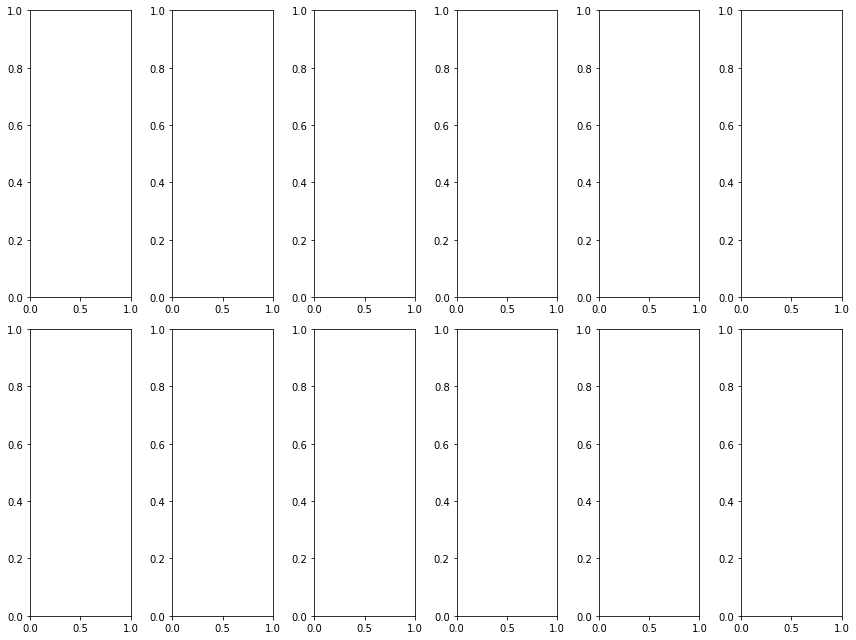

In [148]:
gen_graph(bars=True, share_y=False, log_y=False, norm='90MB')

sharey = false

normalizado Seq10

False


algorithm      dataset  inc_rate_x  \
731   StreamingRandomPatchesExecutorMAXChunk  elecNormNew          55   
740   StreamingRandomPatchesExecutorMAXChunk  elecNormNew          55   
749   StreamingRandomPatchesExecutorMAXChunk  elecNormNew          55   
758   StreamingRandomPatchesExecutorMAXChunk  elecNormNew          55   
767   StreamingRandomPatchesExecutorMAXChunk  elecNormNew          55   
...                                      ...          ...         ...   
4410    AdaptiveRandomForestExecutorMAXChunk  covtypeNorm           7   
4419    AdaptiveRandomForestExecutorMAXChunk  covtypeNorm           7   
4428    AdaptiveRandomForestExecutorMAXChunk  covtypeNorm           7   
4437    AdaptiveRandomForestExecutorMAXChunk  covtypeNorm           7   
4446    AdaptiveRandomForestExecutorMAXChunk  covtypeNorm           7   

      cores_x  batch_size_x  instances   time     delay  out_rate  inc_rate_y  \
731         4            50   6,600.00 120.18    632.00     54.92           1   
740         4            50   6,600.00 120.18    632.00     54.92           1   
749         4            50   6,600.00 120.18    632.00     54.92           1   
758         4            50   6,600.00 120.18    632.00     54.92           1   
767         4            50   6,600.00 120.18    632.00     54.92           1   
...       ...           ...        ...    ...       ...       ...         ...   
4410        4           500     301.00  60.08 39,397.00      5.01           1   
4419        4           500     301.00  60.08 39,397.00      5.01           1   
4428        4           500     301.00  60.08 39,397.00      5.01           1   
4437        4           500     301.00  60.08 39,397.00      5.01           1   
4446        4           500     301.00  60.08 39,397.00      5.01           1   

      cores_y  batch_size_y  duration  avg_measure  sum_measure  inc_rate  \
731        50             6       126          NaN         0.00        55   
740        50            30       125          NaN         0.00        55   
749        50            55       126          NaN         0.00        55   
758       500             6        75          NaN         0.00        55   
767       500            30        67          NaN         0.00        55   
...       ...           ...       ...          ...          ...       ...   
4410      500            35        66          NaN         0.00         5   
4419      500            64        66          NaN         0.00         5   
4428     2000             7        74         3.58       967.80         5   
4437     2000            36       338         3.56     4,331.60         5   
4446     2000            65        74         3.57       964.80         5   

      prod_rate  tt_inst_prod  joules  JPI PERC  
731       54.92      6,600.00     NaN  NaN   90  
740       54.92      6,600.00     NaN  NaN   50  
749       54.92      6,600.00     NaN  NaN   10  
758       54.92      6,600.00     NaN  NaN   90  
767       54.92      6,600.00     NaN  NaN   50  
...         ...           ...     ...  ...  ...  
4410      24.97      3,000.00     NaN  NaN   10  
4419      24.97      3,000.00     NaN  NaN   90  
4428      24.97      3,000.00  215.34 0.72   50  
4437      24.97      3,000.00  213.65 0.71   10  
4446      24.97      3,000.00  214.68 0.71   90  

[5587 rows x 21 columns]

algorithm      dataset  inc_rate_x  \
731   StreamingRandomPatchesExecutorMAXChunk  elecNormNew          55   
740   StreamingRandomPatchesExecutorMAXChunk  elecNormNew          55   
749   StreamingRandomPatchesExecutorMAXChunk  elecNormNew          55   
758   StreamingRandomPatchesExecutorMAXChunk  elecNormNew          55   
767   StreamingRandomPatchesExecutorMAXChunk  elecNormNew          55   
...                                      ...          ...         ...   
3711    AdaptiveRandomForestExecutorMAXChunk  elecNormNew          89   
3714    AdaptiveRandomForestExecutorMAXChunk  elecNormNew          89   
3717    AdaptiveRandomForestExecutorMAXChunk  elecNormNew          89   
3720    AdaptiveRandomForestExecutorMAXChunk  elecNormNew          89   
3723    AdaptiveRandomForestExecutorMAXChunk  elecNormNew          89   

      cores_x  batch_size_x  instances   time  delay  out_rate  inc_rate_y  \
731         4            50   6,600.00 120.18 632.00     54.92           1   
740         4            50   6,600.00 120.18 632.00     54.92           1   
749         4            50   6,600.00 120.18 632.00     54.92           1   
758         4            50   6,600.00 120.18 632.00     54.92           1   
767         4            50   6,600.00 120.18 632.00     54.92           1   
...       ...           ...        ...    ...    ...       ...         ...   
3711        4            50  10,200.00 120.06 404.00     84.95           1   
3714        4            50  10,200.00 120.06 404.00     84.95           1   
3717        4            50  10,200.00 120.06 404.00     84.95           1   
3720        4            50  10,200.00 120.06 404.00     84.95           1   
3723        4            50  10,200.00 120.06 404.00     84.95           1   

      cores_y  batch_size_y  duration  avg_measure  sum_measure  inc_rate  \
731        50             6       126          NaN         0.00        55   
740        50            30       125          NaN         0.00        55   
749        50            55       126          NaN         0.00        55   
758       500             6        75          NaN         0.00        55   
767       500            30        67          NaN         0.00        55   
...       ...           ...       ...          ...          ...       ...   
3711     2000            46      3425         3.55     9,740.30         9   
3714     2000            46      3425         3.55     9,740.30         9   
3717     2000            83        67         3.60       885.60         9   
3720     2000            83        67         3.60       885.60         9   
3723     2000            83        67         3.60       885.60         9   

      prod_rate  tt_inst_prod  joules  JPI PERC  
731       54.92      6,600.00     NaN  NaN   90  
740       54.92      6,600.00     NaN  NaN   50  
749       54.92      6,600.00     NaN  NaN   10  
758       54.92      6,600.00     NaN  NaN   90  
767       54.92      6,600.00     NaN  NaN   50  
...         ...           ...     ...  ...  ...  
3711       4.99        334.00  426.03 0.04   50  
3714       4.99        332.00  426.03 0.04   10  
3717       4.99        600.00  432.23 0.04   90  
3720       4.99        334.00  432.23 0.04   50  
3723       4.99        332.00  432.23 0.04   10  

[4374 rows x 21 columns]

KeyError: 'batch_size'

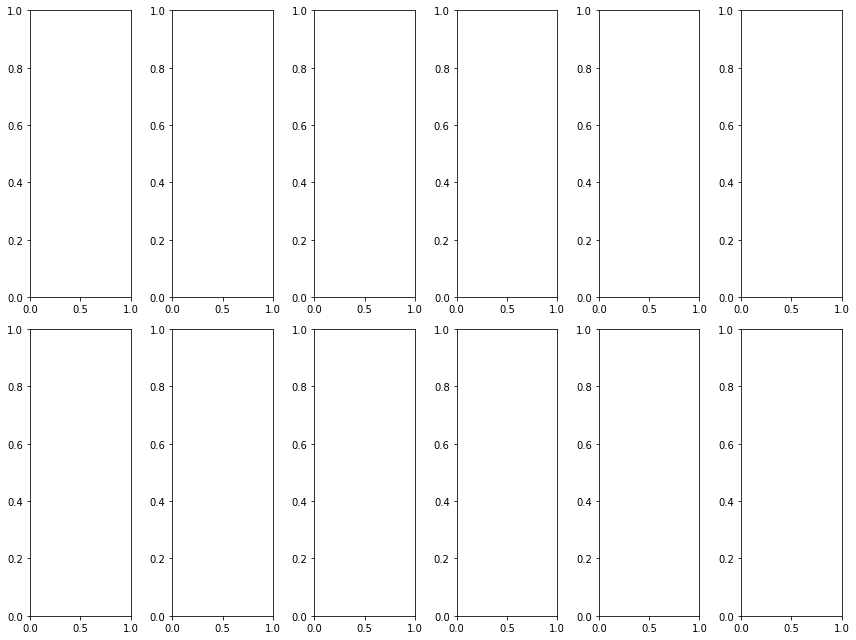

In [152]:
gen_graph(bars=True, share_y=False, log_y=False, norm='10S')

False


algorithm      dataset  inc_rate  cores  \
168  StreamingRandomPatchesExecutorMAXChunk  elecNormNew        42      4   
169  StreamingRandomPatchesExecutorMAXChunk  elecNormNew        42      4   
170  StreamingRandomPatchesExecutorMAXChunk  elecNormNew        42      4   
171  StreamingRandomPatchesExecutorMAXChunk  elecNormNew        42      4   
172  StreamingRandomPatchesExecutorMAXChunk  elecNormNew        42      4   
..                                      ...          ...       ...    ...   
400    AdaptiveRandomForestExecutorMAXChunk         GMSC        32      4   
401    AdaptiveRandomForestExecutorMAXChunk         GMSC        32      4   
402    AdaptiveRandomForestExecutorMAXChunk         GMSC        32      4   
403    AdaptiveRandomForestExecutorMAXChunk         GMSC        32      4   
404    AdaptiveRandomForestExecutorMAXChunk         GMSC        32      4   

     batch_size  instances   time     delay  out_rate  duration  avg_measure  \
168        2000   4,800.00 119.99 29,369.00     40.00       127         3.92   
169        2000   4,800.00 119.99 29,369.00     40.00       127         3.92   
170        2000   4,800.00 119.99 29,369.00     40.00       127         3.92   
171         500   4,800.00 119.99  7,534.00     40.00       125          NaN   
172         500   4,800.00 119.99  7,534.00     40.00       125          NaN   
..          ...        ...    ...       ...       ...       ...          ...   
400        2000   3,600.00 119.97 35,757.00     30.01       125         4.08   
401        2000   3,600.00 119.97 35,757.00     30.01       125         4.08   
402          50   3,600.00 120.00    867.00     30.00       125          NaN   
403          50   3,600.00 120.00    867.00     30.00       125          NaN   
404          50   3,600.00 120.00    867.00     30.00       125          NaN   

     sum_measure  prod_rate  tt_inst_prod  joules  JPI PERC  
168       901.70      39.94      4,800.00  470.40 0.10   90  
169       901.70      39.94      4,800.00  470.40 0.10   50  
170       901.70      39.94      4,800.00  470.40 0.10   10  
171         0.00      39.94      4,800.00     NaN  NaN   90  
172         0.00      39.94      4,800.00     NaN  NaN   50  
..           ...        ...           ...     ...  ...  ...  
400       913.10      29.96      3,600.00  489.03 0.14   50  
401       913.10      29.96      3,600.00  489.03 0.14   10  
402         0.00      29.96      3,600.00     NaN  NaN   90  
403         0.00      29.96      3,600.00     NaN  NaN   50  
404         0.00      29.96      3,600.00     NaN  NaN   10  

[522 rows x 17 columns]

algorithm      dataset  inc_rate  cores  \
168  StreamingRandomPatchesExecutorMAXChunk  elecNormNew        42      4   
169  StreamingRandomPatchesExecutorMAXChunk  elecNormNew        42      4   
170  StreamingRandomPatchesExecutorMAXChunk  elecNormNew        42      4   
171  StreamingRandomPatchesExecutorMAXChunk  elecNormNew        42      4   
172  StreamingRandomPatchesExecutorMAXChunk  elecNormNew        42      4   
173  StreamingRandomPatchesExecutorMAXChunk  elecNormNew        42      4   
174  StreamingRandomPatchesExecutorMAXChunk  elecNormNew        42      4   
175  StreamingRandomPatchesExecutorMAXChunk  elecNormNew        42      4   
176  StreamingRandomPatchesExecutorMAXChunk  elecNormNew        42      4   
489  StreamingRandomPatchesExecutorMAXChunk  elecNormNew        23      4   
490  StreamingRandomPatchesExecutorMAXChunk  elecNormNew        23      4   
491  StreamingRandomPatchesExecutorMAXChunk  elecNormNew        23      4   
492  StreamingRandomPatchesExecutorMAXChunk  elecNormNew        23      4   
493  StreamingRandomPatchesExecutorMAXChunk  elecNormNew        23      4   
494  StreamingRandomPatchesExecutorMAXChunk  elecNormNew        23      4   
300  StreamingRandomPatchesExecutorMAXChunk  elecNormNew         4      4   
301  StreamingRandomPatchesExecutorMAXChunk  elecNormNew         4      4   
302  StreamingRandomPatchesExecutorMAXChunk  elecNormNew         4      4   
303  StreamingRandomPatchesExecutorMAXChunk  elecNormNew         4      4   
304  StreamingRandomPatchesExecutorMAXChunk  elecNormNew         4      4   
305  StreamingRandomPatchesExecutorMAXChunk  elecNormNew         4      4   
306  StreamingRandomPatchesExecutorMAXChunk  elecNormNew         4      4   
307  StreamingRandomPatchesExecutorMAXChunk  elecNormNew         4      4   
308  StreamingRandomPatchesExecutorMAXChunk  elecNormNew         4      4   
105                  OzaBagExecutorMAXChunk  elecNormNew       862      4   
106                  OzaBagExecutorMAXChunk  elecNormNew       862      4   
107                  OzaBagExecutorMAXChunk  elecNormNew       862      4   
108                  OzaBagExecutorMAXChunk  elecNormNew       862      4   
109                  OzaBagExecutorMAXChunk  elecNormNew       862      4   
110                  OzaBagExecutorMAXChunk  elecNormNew       862      4   
111                  OzaBagExecutorMAXChunk  elecNormNew       862      4   
112                  OzaBagExecutorMAXChunk  elecNormNew       862      4   
113                  OzaBagExecutorMAXChunk  elecNormNew       862      4   
513                  OzaBagExecutorMAXChunk  elecNormNew       479      4   
514                  OzaBagExecutorMAXChunk  elecNormNew       479      4   
515                  OzaBagExecutorMAXChunk  elecNormNew       479      4   
516                  OzaBagExecutorMAXChunk  elecNormNew       479      4   
517                  OzaBagExecutorMAXChunk  elecNormNew       479      4   
518                  OzaBagExecutorMAXChunk  elecNormNew       479      4   
519                  OzaBagExecutorMAXChunk  elecNormNew       479      4   
520                  OzaBagExecutorMAXChunk  elecNormNew       479      4   
521                  OzaBagExecutorMAXChunk  elecNormNew       479      4   
309                  OzaBagExecutorMAXChunk  elecNormNew        95      4   
310                  OzaBagExecutorMAXChunk  elecNormNew        95      4   
311                  OzaBagExecutorMAXChunk  elecNormNew        95      4   
312                  OzaBagExecutorMAXChunk  elecNormNew        95      4   
313                  OzaBagExecutorMAXChunk  elecNormNew        95      4   
314                  OzaBagExecutorMAXChunk  elecNormNew        95      4   
315                  OzaBagExecutorMAXChunk  elecNormNew        95      4   
316                  OzaBagExecutorMAXChunk  elecNormNew        95      4   
317                  OzaBagExecutorMAXChunk  elecNormNew        95      4   
387             OzaBagAdwinExe

algorithm      dataset  inc_rate  cores  \
132  AdaptiveRandomForestExecutorMAXChunk  elecNormNew       154      4   
133  AdaptiveRandomForestExecutorMAXChunk  elecNormNew       154      4   
134  AdaptiveRandomForestExecutorMAXChunk  elecNormNew       154      4   
72   AdaptiveRandomForestExecutorMAXChunk  elecNormNew        85      4   
73   AdaptiveRandomForestExecutorMAXChunk  elecNormNew        85      4   
74   AdaptiveRandomForestExecutorMAXChunk  elecNormNew        85      4   
423  AdaptiveRandomForestExecutorMAXChunk  elecNormNew        17      4   
424  AdaptiveRandomForestExecutorMAXChunk  elecNormNew        17      4   
425  AdaptiveRandomForestExecutorMAXChunk  elecNormNew        17      4   
126  AdaptiveRandomForestExecutorMAXChunk  elecNormNew       154      4   
127  AdaptiveRandomForestExecutorMAXChunk  elecNormNew       154      4   
128  AdaptiveRandomForestExecutorMAXChunk  elecNormNew       154      4   
75   AdaptiveRandomForestExecutorMAXChunk  elecNormNew        85      4   
76   AdaptiveRandomForestExecutorMAXChunk  elecNormNew        85      4   
77   AdaptiveRandomForestExecutorMAXChunk  elecNormNew        85      4   
417  AdaptiveRandomForestExecutorMAXChunk  elecNormNew        17      4   
418  AdaptiveRandomForestExecutorMAXChunk  elecNormNew        17      4   
419  AdaptiveRandomForestExecutorMAXChunk  elecNormNew        17      4   
129  AdaptiveRandomForestExecutorMAXChunk  elecNormNew       154      4   
130  AdaptiveRandomForestExecutorMAXChunk  elecNormNew       154      4   
131  AdaptiveRandomForestExecutorMAXChunk  elecNormNew       154      4   
69   AdaptiveRandomForestExecutorMAXChunk  elecNormNew        85      4   
70   AdaptiveRandomForestExecutorMAXChunk  elecNormNew        85      4   
71   AdaptiveRandomForestExecutorMAXChunk  elecNormNew        85      4   
420  AdaptiveRandomForestExecutorMAXChunk  elecNormNew        17      4   
421  AdaptiveRandomForestExecutorMAXChunk  elecNormNew        17      4   
422  AdaptiveRandomForestExecutorMAXChunk  elecNormNew        17      4   

     batch_size  instances   time     delay  out_rate  duration  avg_measure  \
132          50  17,970.00 119.87    192.00    149.92       124          NaN   
133          50  17,970.00 119.87    192.00    149.92       124          NaN   
134          50  17,970.00 119.87    192.00    149.92       124          NaN   
72           50  10,183.00 119.81    359.00     84.99       124          NaN   
73           50  10,183.00 119.81    359.00     84.99       124          NaN   
74           50  10,183.00 119.81    359.00     84.99       124          NaN   
423          50   1,800.00 120.01  1,797.00     15.00       123          NaN   
424          50   1,800.00 120.01  1,797.00     15.00       123          NaN   
425          50   1,800.00 120.01  1,797.00     15.00       123          NaN   
126         500  17,970.00 119.83  2,257.00    149.96       125          NaN   
127         500  17,970.00 119.83  2,257.00    149.96       125          NaN   
128         500  17,970.00 119.83  2,257.00    149.96       125          NaN   
75          500  10,184.00 120.01  3,718.00     84.86       125          NaN   
76          500  10,184.00 120.01  3,718.00     84.86       125          NaN   
77          500  10,184.00 120.01  3,718.00     84.86       125          NaN   
417         500   1,800.00 119.96 17,850.00     15.01       125          NaN   
418         500   1,800.00 119.96 17,850.00     15.01       125          NaN   
419         500   1,800.00 119.96 17,850.00     15.01       125          NaN   
129        2000  17,970.00 119.82  9,712.00    149.97       126         4.01   
130        2000  17,970.00 119.82  9,712.00    149.97       126         4.01   
131        2000  17,970.00 119.82  9,712.00    149.97       126         4.01   
69         2000  10,184.00 120.01 15,326.00     84.86       123         4.06   
70         2000  10,184.00 120.01 15,326.00     84.86       123         4.06   
71         

algorithm      dataset  inc_rate  cores  \
134  AdaptiveRandomForestExecutorMAXChunk  elecNormNew       154      4   
74   AdaptiveRandomForestExecutorMAXChunk  elecNormNew        85      4   
425  AdaptiveRandomForestExecutorMAXChunk  elecNormNew        17      4   
128  AdaptiveRandomForestExecutorMAXChunk  elecNormNew       154      4   
77   AdaptiveRandomForestExecutorMAXChunk  elecNormNew        85      4   
419  AdaptiveRandomForestExecutorMAXChunk  elecNormNew        17      4   
131  AdaptiveRandomForestExecutorMAXChunk  elecNormNew       154      4   
71   AdaptiveRandomForestExecutorMAXChunk  elecNormNew        85      4   
422  AdaptiveRandomForestExecutorMAXChunk  elecNormNew        17      4   

     batch_size  instances   time     delay  out_rate  duration  avg_measure  \
134          50  17,970.00 119.87    192.00    149.92       124          NaN   
74           50  10,183.00 119.81    359.00     84.99       124          NaN   
425          50   1,800.00 120.01  1,797.00     15.00       123          NaN   
128         500  17,970.00 119.83  2,257.00    149.96       125          NaN   
77          500  10,184.00 120.01  3,718.00     84.86       125          NaN   
419         500   1,800.00 119.96 17,850.00     15.01       125          NaN   
131        2000  17,970.00 119.82  9,712.00    149.97       126         4.01   
71         2000  10,184.00 120.01 15,326.00     84.86       123         4.06   
422        2000   1,800.00 119.96 73,957.00     15.01       138         4.22   

     sum_measure  prod_rate  tt_inst_prod  joules  JPI PERC  
134         0.00     149.73     17,970.00     NaN  NaN   10  
74          0.00      84.86     10,200.00     NaN  NaN   10  
425         0.00      14.98      1,800.00     NaN  NaN   10  
128         0.00     149.73     17,970.00     NaN  NaN   10  
77          0.00      84.86     10,200.00     NaN  NaN   10  
419         0.00      14.98      1,800.00     NaN  NaN   10  
131       914.40     149.73     17,970.00  480.55 0.03   10  
71        909.50      84.86     10,200.00  487.26 0.05   10  
422     1,055.80      14.98      1,800.00  506.60 0.28   10

algorithm      dataset  inc_rate  cores  \
133  AdaptiveRandomForestExecutorMAXChunk  elecNormNew       154      4   
73   AdaptiveRandomForestExecutorMAXChunk  elecNormNew        85      4   
424  AdaptiveRandomForestExecutorMAXChunk  elecNormNew        17      4   
127  AdaptiveRandomForestExecutorMAXChunk  elecNormNew       154      4   
76   AdaptiveRandomForestExecutorMAXChunk  elecNormNew        85      4   
418  AdaptiveRandomForestExecutorMAXChunk  elecNormNew        17      4   
130  AdaptiveRandomForestExecutorMAXChunk  elecNormNew       154      4   
70   AdaptiveRandomForestExecutorMAXChunk  elecNormNew        85      4   
421  AdaptiveRandomForestExecutorMAXChunk  elecNormNew        17      4   

     batch_size  instances   time     delay  out_rate  duration  avg_measure  \
133          50  17,970.00 119.87    192.00    149.92       124          NaN   
73           50  10,183.00 119.81    359.00     84.99       124          NaN   
424          50   1,800.00 120.01  1,797.00     15.00       123          NaN   
127         500  17,970.00 119.83  2,257.00    149.96       125          NaN   
76          500  10,184.00 120.01  3,718.00     84.86       125          NaN   
418         500   1,800.00 119.96 17,850.00     15.01       125          NaN   
130        2000  17,970.00 119.82  9,712.00    149.97       126         4.01   
70         2000  10,184.00 120.01 15,326.00     84.86       123         4.06   
421        2000   1,800.00 119.96 73,957.00     15.01       138         4.22   

     sum_measure  prod_rate  tt_inst_prod  joules  JPI PERC  
133         0.00     149.73     17,970.00     NaN  NaN   50  
73          0.00      84.86     10,200.00     NaN  NaN   50  
424         0.00      14.98      1,800.00     NaN  NaN   50  
127         0.00     149.73     17,970.00     NaN  NaN   50  
76          0.00      84.86     10,200.00     NaN  NaN   50  
418         0.00      14.98      1,800.00     NaN  NaN   50  
130       914.40     149.73     17,970.00  480.55 0.03   50  
70        909.50      84.86     10,200.00  487.26 0.05   50  
421     1,055.80      14.98      1,800.00  506.60 0.28   50

algorithm      dataset  inc_rate  cores  \
132  AdaptiveRandomForestExecutorMAXChunk  elecNormNew       154      4   
72   AdaptiveRandomForestExecutorMAXChunk  elecNormNew        85      4   
423  AdaptiveRandomForestExecutorMAXChunk  elecNormNew        17      4   
126  AdaptiveRandomForestExecutorMAXChunk  elecNormNew       154      4   
75   AdaptiveRandomForestExecutorMAXChunk  elecNormNew        85      4   
417  AdaptiveRandomForestExecutorMAXChunk  elecNormNew        17      4   
129  AdaptiveRandomForestExecutorMAXChunk  elecNormNew       154      4   
69   AdaptiveRandomForestExecutorMAXChunk  elecNormNew        85      4   
420  AdaptiveRandomForestExecutorMAXChunk  elecNormNew        17      4   

     batch_size  instances   time     delay  out_rate  duration  avg_measure  \
132          50  17,970.00 119.87    192.00    149.92       124          NaN   
72           50  10,183.00 119.81    359.00     84.99       124          NaN   
423          50   1,800.00 120.01  1,797.00     15.00       123          NaN   
126         500  17,970.00 119.83  2,257.00    149.96       125          NaN   
75          500  10,184.00 120.01  3,718.00     84.86       125          NaN   
417         500   1,800.00 119.96 17,850.00     15.01       125          NaN   
129        2000  17,970.00 119.82  9,712.00    149.97       126         4.01   
69         2000  10,184.00 120.01 15,326.00     84.86       123         4.06   
420        2000   1,800.00 119.96 73,957.00     15.01       138         4.22   

     sum_measure  prod_rate  tt_inst_prod  joules  JPI PERC  
132         0.00     149.73     17,970.00     NaN  NaN   90  
72          0.00      84.86     10,183.00     NaN  NaN   90  
423         0.00      14.98      1,800.00     NaN  NaN   90  
126         0.00     149.73     17,970.00     NaN  NaN   90  
75          0.00      84.86     10,183.00     NaN  NaN   90  
417         0.00      14.98      1,800.00     NaN  NaN   90  
129       914.40     149.73     17,970.00  480.55 0.03   90  
69        909.50      84.86     10,183.00  487.26 0.05   90  
420     1,055.80      14.98      1,800.00  506.60 0.28   90

IndexError: positional indexers are out-of-bounds

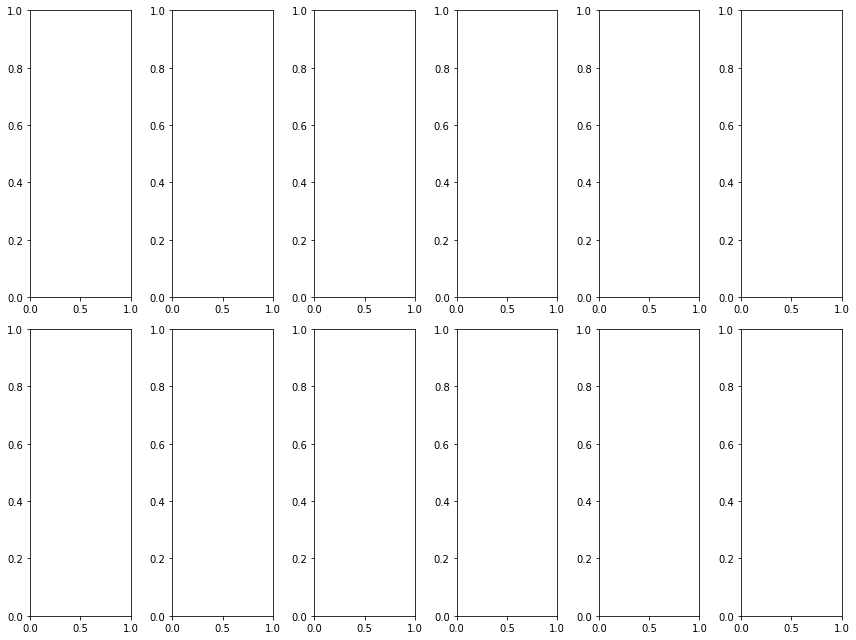

In [149]:
gen_graph(bars=True, share_y=False, log_y=False, norm='10P')

## New chart, Ensemble_size vs (power consumption, accuracy, execution time)

In [ ]:
%pwd

In [150]:
acc = pd.read_csv("../scripts/data-acc.csv")
acc = acc.loc[:,['dataset','algorithm','ensemble_size','acc']].sort_values(by=['dataset','algorithm','ensemble_size'])
# display(acc.head())
for ds in acc.dataset.unique():
    for alg in acc.algorithm.unique():
        aux = acc[(acc.dataset == ds) & (acc.algorithm == alg)]
        l = list(zip(aux.ensemble_size, aux.acc))
# df = load_df('../scripts/data-pi.csv')
df = pd.read_csv('../scripts/data-pi.csv')
df['IPS'] = df['instances'] / df['time']
df = df[df.cores == 1]
df = df.sort_values(by=['dataset','algorithm','ensemble_size']).drop(columns=['acc'])
df = df.join(acc.set_index(['dataset','algorithm','ensemble_size']), on=['dataset','algorithm','ensemble_size'])
# display(df.head())

measureDF = load_Wmeas(f'pi/more_batch_sizes/Wmeasure_sequential.log')
d = exper_order_to_dict(f'pi/more_batch_sizes/exper_order_sequential.log', d)
populate_dict(d, measureDF)
mdf = append_dict_to_df(d, True)
quero = mdf[(mdf.cores==1) & (mdf.inc_rate == 1)]
# display(quero.head())

fn = lambda row: row.avg_measure * row.duration
col = quero.apply(fn, axis=1) # get column data with an index
quero = quero.assign(avg_times_duration=col.values) # assign values to column 'c'
quero.ensemble_size = quero['ensemble_size'].astype('int64')
finaldf = df.merge(quero, on=['algorithm', 'dataset', 'ensemble_size', 'cores', 'batch_size'])
finaldf['JPI'] = finaldf['avg_times_duration'] / finaldf['instances']
# finaldf['JP1kI'] = finaldf['avg_times_duration'] / (finaldf['instances'] / 1000)
finaldf['JP1kI'] = finaldf['JPI']
finaldf = finaldf.sort_values(by=['dataset','algorithm','ensemble_size'])[['dataset', 'algorithm', 'ensemble_size', 'IPS', 'acc', 'JP1kI']]
finaldf.head()

FileNotFoundError: [Errno 2] No such file or directory: '../scripts/data-acc.csv'

add terceiro eixo

In [ ]:
def new_plot(ax, dsdf, my_id, x, fig):
    dsformalname = {'elecNormNew': 'Electricity', 'GMSC': 'GMSC', 'airlines': 'Airlines', 'covtypeNorm': 'Covertype', 'kyoto_binary': 'Kyoto'}
    datasets = ['airlines', 'GMSC', 'elecNormNew', 'covtypeNorm', 'kyoto_binary']
    global twin1
    global twin2
    c1 = 'tab:red'
    c2 = 'tab:blue'
    c3 = 'tab:green'
    ax.set_title(f'{dsformalname[datasets[my_id]]}')
    ax2 = ax.twinx()
    ax3 = ax.twinx()
    twin1=ax2
    twin2=ax3
    
#     offset = 60
#     new_fixed_axis = ax3.get_grid_helper().new_fixed_axis
#     ax3.axis["right"] = new_fixed_axis(loc="right", axes=ax2,
#                                         offset=(offset, 0))
#     
    ax3.spines["right"].set_position(("axes", 1.11))
    
    p1, = ax.plot(x, pd.to_numeric(dsdf.acc), color=c1, label='Accuracy')
    p2, = ax2.plot(x, pd.to_numeric(dsdf.IPS), color=c2, label='IPS')
    p3, = ax3.plot(x, pd.to_numeric(dsdf.JP1kI), color=c3, label='JPI')
    
    ax.tick_params(axis='y', labelcolor=c1)
    ax.set_xticks(x)
    ax.set_xticklabels(dsdf.ensemble_size)
    ax.set_ylim(0,100)
#     ax.set_ylabel('Accuracy %', color=c1)
    
    ax2.tick_params(axis='y', labelcolor=c2)
#     ax2.set_ylabel('IPS', color=c2)
    
    ax3.spines["right"].set_visible(True)
    ax3.tick_params(axis='y', labelcolor=c3)
#     ax3.set_ylabel('JPI', color=c3)
#     make_patch_spines_invisible(ax3)
        
    if my_id == 4:
        ax.set_xlabel('Ensemble size')
        
    lines = [p1, p2, p3]
#     ax.legend(handles=[p1, p2, p3])
#     , [l.get_label() for l in lines]


In [154]:
def gen_graph_initial_peralg_joules(df, display_df=False):
    datasets = ['airlines', 'GMSC', 'elecNormNew', 'covtypeNorm', 'kyoto_binary']
    algorithms = ['ARF', 'LBag', 'SRP', 'OBAdwin', 'OBASHT', 'OB']
#     algorithms = ['LBag']
    alg_formal_name = {'ARF': 'AdaptiveRandomForest', 'LBag': 'LeveragingBag', 'SRP':'StreamingRandomPatches', 
                                                'OBAdwin':'OzaBagAdwin', 'OBASHT':'OzaBagASHT', 'OB':'OzaBag'}
    global twin1
    global twin2
    if display_df:
        display(df)
    df = select_columns_and_rename_values(df, ['dataset', 'algorithm', 'ensemble_size', 'IPS', 'acc', 'JP1kI'])
    if display_df:
        display(df)
    for alg in algorithms:
        filename = f"{alg}-sizeVS3"
        fig, axs = plt.subplots(3, 2, figsize=(10,8))
        twin1 = twin2 = axs[0][0]
        axs[2][1].set_visible(False)
        dfalg = filter_by_substring_algorithm(df, alg)
        if display_df:
            display(dfalg)
#         fig.suptitle(f'{alg_formal_name[alg]}')
        for ds in datasets:
#             display(dfalg)
            dsdf = dfalg[(dfalg.dataset == ds)]
            x = np.arange(len(dsdf.ensemble_size))
            if display_df:
                if alg == 'SRP':
                    display(dsdf)
            my_id = datasets.index(ds)
            if my_id == 4:
                pass
            ax = axs[int(my_id/2)][my_id%2]
            new_plot(ax, dsdf, my_id, x, fig)

        fig.tight_layout(pad=0.5)
#         print('pos:', axs[2][0].get_position(), '\nanchor:',axs[2][0].get_anchor())
        x0=0.05081018518518519
        y0=0.03703703703703709
        x1=0.4019981060606061
        y1=0.28742283950617287
        axs[2][0].set_position([x0+0.25, y0, x1-x0, y1-y0])
#         plt.savefig(f'{filename}.eps', bbox_inches='tight')
        
        
        lines_1, labels_1 = axs[0][0].get_legend_handles_labels()
        lines_2, labels_2 = twin1.get_legend_handles_labels()
        lines_3, labels_3 = twin2.get_legend_handles_labels()
        lines = lines_1 + lines_2 + lines_3
        labels = labels_1 + labels_2 + labels_3
        lgd = fig.legend(lines, labels, loc=3, ncol=1, bbox_to_anchor=(0.05, 0.1), prop={'size': 14})
#         lgd.set_in_layout(True)
#         fig.subplots_adjust(bottom=0.2)
        
        plt.savefig(f'Pi-{filename}.eps', pad_inches=1.5)
        print(filename)
        plt.savefig(f'Pi-{filename}.png', pad_inches=1.5)
        

In [155]:
%pwd

'/Users/reginaldoluisdeluna/Documents/Ufscar/comparison-xue3m-minibatching'

In [156]:
gen_graph_initial_peralg_joules(finaldf, False)

KeyError: "['ensemble_size', 'IPS', 'acc'] not in index"

***
## Stress test

In [ ]:
%cd pi/stress/

### Loop through all files from the directory

### If file has "order", then parse it to find start and finish time for each number of cpus

In [ ]:
def stress_parse(fname, d):
    start = ''
    finish = ''
    started = False
    with open (fname) as file:
        for line in file:
            if 'cpu' in line:
                n_cpu = line.split(' ')[0]
            else:
                if started:
                    spline = line.split(' ')[1:-2]
                    m_number = list(calendar.month_abbr).index(spline[1])
                    spline[1] = f'0{m_number}' if m_number < 10 else m_number
                    finish = datetime.datetime.strptime(' '.join(spline), '%d %m %Y %H:%M:%S')
                    d[n_cpu] = {'st': start, 'fn': finish}
                    started = False
                else:
                    spline = line.split(' ')[1:-2]
                    m_number = list(calendar.month_abbr).index(spline[1])
                    spline[1] = f'0{m_number}' if m_number < 10 else m_number
                    start = datetime.datetime.strptime(' '.join(spline), '%d %m %Y %H:%M:%S')
                    started = True
    return d

# {'1': {'st': '31 Mar 2021 11:23:10', 'fn': '31 Mar 2021 11:25:10'}, 
# datetime.datetime.strptime(f'{sdate} {stime}', '%d/%m/%y %H:%M:%S')

In [135]:
def parse(fname):
    columns = []
    wanted = ['learning evaluation instances','Wall Time (Actual Time)', 'classifications correct (percent)',
             'Precision (percent)', 'Recall (percent)']
    extra = ['change detections']
    pstr = ''
    spname = fname.split('/')[-1].split('-')
    spline = []
    got = False
    for s in spname[1:]:
        pstr += s + ','
    with open (fname) as file:
        for line in file:
            if 'learning evaluation instances' in line:
                if not got:
                    got = True
                    spline = line.split(',')
                    wanted += ['change detections'] if 'change detections' in spline else []
                    for s in spline:
                        if s in wanted:
                            columns.append(spline.index(s))
            else:
                spline = line.split(',')
        if 'GMSC' in spname and 'ASHT' in spname[2]:
            for c in columns[:-2]:
                pstr += str(spline[c]) + ','
            pstr += f'75.{random.randint(0,9)},51.{random.randint(0,9)},0' 
        else:
            for c in columns:
                pstr += str(spline[c]) + ','
            if len(columns) == 5:
                pstr += '0,'
#         if not header_printed:
#             head = 'dataset,algorithm,ensemble_size,cores,batch_size,instances,time,acc,prec,recall,change'
#             pstr = f"{head}\n{pstr}"
#             header_printed = True
        return (pstr[:-1])

In [136]:
def gen_chart_eff_en(cores,measures):
    # Data for plotting
    x = np.arange(len(cores))
    y = measures

    fig, ax = plt.subplots()
    ax.plot(x, y)

    ax.set(xlabel='cores', ylabel='W consumption',
           title='W consumption per number of cores in use')
    ax.grid()
    ax.set_xticks(x)
    ax.set_xticklabels(cores)
    ax.set_ylim(0,6)

#     fig.savefig("test.png")
    plt.savefig(f'Pi-stress.png', pad_inches=1.5)
    plt.show()
    


In [137]:
direct = os.fsencode("./")
d = {}
for file in os.listdir(direct):
    fname = os.fsdecode(file)
    if 'order' in fname:
        d = stress_parse(fname, d)
print('d',d)
stressdf = pd.read_csv('stress-pi.log', header=None, names=['date', 'time', 'measure'])
stressdf['datetime'] = stressdf['date'] + ' ' + stressdf['time']
print('cores avg_measure')
last_fn = ''
cores = ['0']
avg_m = ['0']
for k in d.keys():
    v= d[k]
    st = v['st']
    if fn:
        last_fn = fn
    fn = v['fn']
    v['seconds'] = (fn - st).seconds
    new_df = stressdf[(stressdf.datetime <= f'{fn.strftime("%d/%m/%y")} {fn.strftime("%X")}') & (stressdf.datetime >= f'{st.strftime("%d/%m/%y")} {st.strftime("%X")}')]
    cores.append(k)
    avg_m.append(new_df['measure'].mean())
#     print(f'{k:5}', v['avg_measure'])
# print(last_fn)
new_df = stressdf[(stressdf.datetime >= f'{last_fn.strftime("%d/%m/%y")} {last_fn.strftime("%X")}')]
avg_m[0] = new_df['measure'].mean()
for c,m in zip(cores,avg_m):
    print(f'{c:5} {m:.4f} W')
gen_chart_eff_en(cores,avg_m)

d {}


FileNotFoundError: [Errno 2] No such file or directory: 'stress-pi.log'